In [201]:
%pylab inline
import keras
import keras.backend as K
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from keras import Input, Model, Sequential
from keras.layers import Lambda, LSTM, RepeatVector, Dense, TimeDistributed, Bidirectional, concatenate,\
Conv1D, MaxPooling1D, UpSampling1D, BatchNormalization, Activation, Flatten, Reshape
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/home/ing-luca/.local/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
def get_data(data_filepath, timesteps=100, rescale=True):
    def split_data(dataset, timesteps):
        D = dataset.shape[1]
        if D < timesteps:
            return None
        elif D == timesteps:
            return dataset
        else:
            splitted_data, remaining_data = np.hsplit(dataset, [timesteps])
            remaining_data = split_data(remaining_data, timesteps)
            if remaining_data is not None:
                return np.vstack([splitted_data, remaining_data])
            return splitted_data

    data = np.load(data_filepath)
    if rescale:
        percentile_1 = np.percentile(data, 1)
        percentile_99 = np.percentile(data, 99)
        data[data < percentile_1] = percentile_1
        data[data > percentile_99] = percentile_99
        data = MinMaxScaler(feature_range=(-1, 1)).fit_transform(data)
    if timesteps > 0:
        data = split_data(data, timesteps)
    return data

In [112]:
balances_filepath = "../../datasets/berka_dataset/parsed/balances.npy"
transactions_filepath = "../../datasets/berka_dataset/parsed/transactions.npy"

timesteps = 32
transactions = get_data(transactions_filepath, timesteps=timesteps, rescale=True)
np.random.shuffle(transactions)
transactions = transactions[:]
N, D = transactions.shape
print(N, D)

306000 32


# Autoencoders

In [114]:
lr = 0.01
epochs = 1000
loss = 'mse'
latent_dim = 10
lstm_dim = 64
validation_split = 0.3
split_index = N-int(N*validation_split)
optimizer = Adam(lr, epsilon=1e-08, amsgrad=True, clipnorm=1.0)

indexes = np.random.choice(range(split_index, N), 16, replace=False)
early_stopping = EarlyStopping(monitor='loss', min_delta=0.00005, patience=10, verbose=0, mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1, mode='auto', epsilon=0.0005, cooldown=0, min_lr=0)

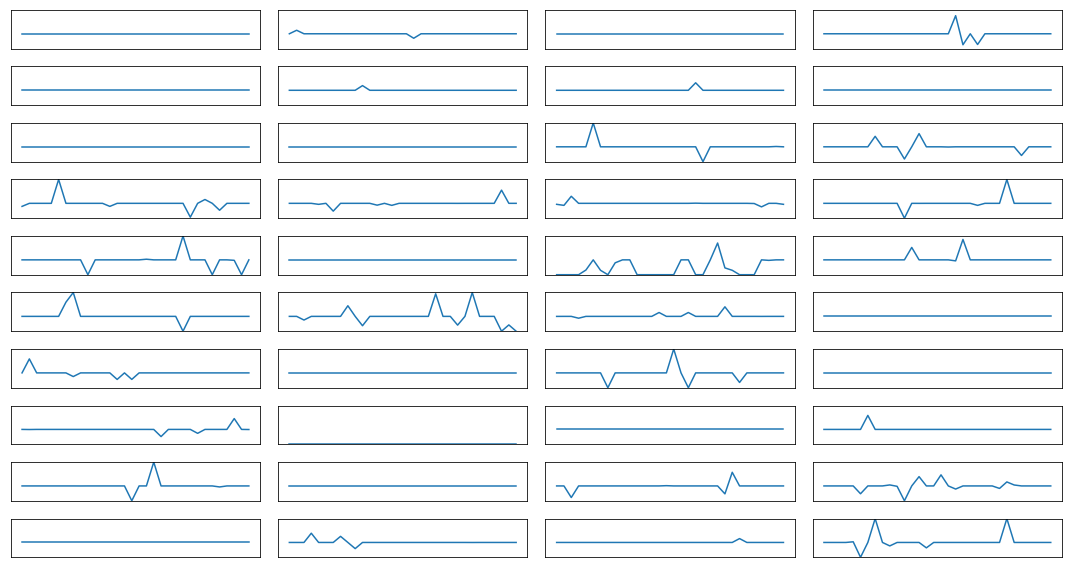

In [115]:
plt.subplots(10, 4, figsize=(15, 8))
for i, index in enumerate(range(0, 4000, 100)):
    plt.subplot(10, 4, i+1)
    plt.plot(transactions[index])
    plt.xticks([])
    plt.yticks([])
    plt.ylim(-1, 1)
    plt.tight_layout()
plt.show()

In [116]:
def plot_predictions(autoencoder, indexes, data, reverse=False, add_timesteps=False):
    plt.subplots(4, 4, figsize=(15, 5))
    steps = np.reshape(np.arange(0, 1, 1/timesteps), (1, timesteps))
    print(steps.shape)
    
    for i, index in enumerate(indexes):
        plt.subplot(4, 4, i+1)
        plt.plot(data[index])
        if reverse:
            if add_timesteps:
                plt.plot((autoencoder.predict([data[index:index+1], steps]).T)[::-1])
            else:
                plt.plot((autoencoder.predict(data[index:index+1]).T)[::-1])
        else:
            if add_timesteps:
                plt.plot(autoencoder.predict([data[index:index+1], steps]).T)
            else:
                plt.plot(autoencoder.predict(data[index:index+1]).T)
        plt.xticks([])
        plt.yticks([])
        plt.ylim(-1, 1)
    plt.tight_layout()
    plt.show()
    
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.show()
    
def train_autoencoder(autoencoder, inputs, outputs):
    autoencoder.summary()
    history = autoencoder.fit(inputs, outputs, epochs=epochs, validation_split=validation_split, callbacks=[early_stopping, reduce_lr])
    return history

### Dense-Dense autoencoder

In [ ]:
def get_dense_dense_autoencoder(timesteps, latent_dim, loss, lr):
    autoencoder = Sequential()
    autoencoder.add(Dense(latent_dim, activation='tanh', input_shape=(timesteps,)))
    autoencoder.add(Dense(timesteps, activation='tanh'))
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

dense_dense_autoencoder = get_dense_dense_autoencoder(timesteps, latent_dim, loss, lr)
history = train_autoencoder(dense_dense_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(dense_dense_autoencoder, indexes, transactions)

### LSTM-Dense autoencoder

In [ ]:
def get_lstm_dense_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr):
    autoencoder = Sequential()
    autoencoder.add(Lambda(lambda x: K.expand_dims(x), input_shape=(timesteps,)))
    autoencoder.add(LSTM(lstm_dim, return_sequences = False))
    autoencoder.add(Dense(latent_dim, activation='tanh'))
    autoencoder.add(Dense(timesteps, activation='tanh'))
    
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

lstm_dense_autoencoder = get_lstm_dense_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(lstm_dense_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(lstm_dense_autoencoder, indexes, transactions)

### Dense-LSTM autoencoder

In [ ]:
def get_dense_lstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr):
    autoencoder = Sequential()
    autoencoder.add(Dense(latent_dim, activation='tanh', input_shape=(timesteps,)))
    autoencoder.add(RepeatVector(timesteps))
    autoencoder.add(LSTM(lstm_dim, return_sequences=True))
    autoencoder.add(TimeDistributed(Dense(1, activation='tanh')))
    autoencoder.add(Lambda(lambda x: K.squeeze(x, -1)))
    
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

dense_lstm_autoencoder = get_dense_lstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(dense_lstm_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(dense_lstm_autoencoder, indexes, transactions)

### LSTM-LSTM autoencoder

In [ ]:
def get_lstm_lstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr):
    autoencoder = Sequential()
    autoencoder.add(Lambda(lambda x: K.expand_dims(x), input_shape=(timesteps,)))
    autoencoder.add(LSTM(lstm_dim, return_sequences = False))
    autoencoder.add(Dense(latent_dim, activation='tanh'))
    autoencoder.add(RepeatVector(timesteps))
    autoencoder.add(LSTM(lstm_dim, return_sequences=True))
    autoencoder.add(TimeDistributed(Dense(1, activation='tanh')))
    autoencoder.add(Lambda(lambda x: K.squeeze(x, -1)))
    
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

lstm_lstm_autoencoder = get_lstm_lstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(lstm_lstm_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(lstm_lstm_autoencoder, indexes, transactions)

### BLSTM-BLSTM autoencoder

In [ ]:
def get_blstm_blstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr=0.001):
    model_inputs = Input((timesteps,))
    encoder = Lambda(lambda x: K.expand_dims(x))(model_inputs)

    encoder = Bidirectional(LSTM(lstm_dim, return_sequences = False))(encoder)
    encoder = Dense(latent_dim, activation='tanh')(encoder)
    encoder = RepeatVector(timesteps)(encoder)
    
    decoder = Bidirectional(LSTM(lstm_dim, return_sequences=True))(encoder)
    decoder = TimeDistributed(Dense(1, activation='tanh'))(decoder)
    decoder = Lambda(lambda x: K.squeeze(x, -1))(decoder)
    
    autoencoder = Model(model_inputs, decoder)

    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

steps = np.arange(0, 1, 1/timesteps)
steps = np.tile(steps,(transactions.shape[0],1))

blstm_blstm_autoencoder = get_blstm_blstm_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(blstm_blstm_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(blstm_blstm_autoencoder, indexes, transactions)

### BLSTM-BLSTM autoencoder (with steps)

In [ ]:
def get_blstm_blstm_steps_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr=0.001):
    model_inputs = Input((timesteps,))
    encoder = Lambda(lambda x: K.expand_dims(x))(model_inputs)

    model_inputs_2 = Input((timesteps,))
    steps = Lambda(lambda x: K.expand_dims(x))(model_inputs_2)

    encoder = Bidirectional(LSTM(lstm_dim, return_sequences = False))(encoder)
    encoder = Dense(latent_dim, activation='tanh')(encoder)
    encoder = RepeatVector(timesteps)(encoder)
    encoder = concatenate([encoder, steps])
    
    decoder = Bidirectional(LSTM(lstm_dim, return_sequences=True))(encoder)
    decoder = TimeDistributed(Dense(1, activation='tanh'))(decoder)
    decoder = Lambda(lambda x: K.squeeze(x, -1))(decoder)
    
    autoencoder = Model([model_inputs, model_inputs_2], decoder)

    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

steps = np.arange(0, 1, 1/timesteps)
steps = np.tile(steps,(transactions.shape[0],1))

blstm_blstm_steps_autoencoder = get_blstm_blstm_steps_autoencoder(timesteps, lstm_dim, latent_dim, loss, lr)
history = train_autoencoder(blstm_blstm_steps_autoencoder, [transactions, steps], transactions)
plot_history(history)
plot_predictions(blstm_blstm_steps_autoencoder, indexes, transactions, add_timesteps=True)

### Conv Conv autoencoder

In [117]:
def get_conv_conv_autoencoder(timesteps, loss, lr):
    autoencoder = Sequential()
    autoencoder.add(Lambda(lambda x: K.expand_dims(x), input_shape=(timesteps,)))
    autoencoder.add(Conv1D(32, 5, activation='tanh', padding='same'))
    autoencoder.add(MaxPooling1D(2, padding='same'))
    autoencoder.add(Conv1D(64, 4, activation='tanh', padding='same'))
    autoencoder.add(MaxPooling1D(2, padding='same'))
    autoencoder.add(Conv1D(3, 3, activation='tanh', padding='same'))
    autoencoder.add(MaxPooling1D(2, padding='same'))

    autoencoder.add(Conv1D(3, 3, activation='tanh', padding='same'))
    autoencoder.add(UpSampling1D(2))
    autoencoder.add(Conv1D(64, 4, activation='tanh', padding='same'))
    autoencoder.add(UpSampling1D(2))
    autoencoder.add(Conv1D(32, 5, activation='tanh', padding='same'))
    autoencoder.add(UpSampling1D(2))
    autoencoder.add(Conv1D(1, 3, activation='tanh', padding='same'))
    autoencoder.add(Lambda(lambda x: K.squeeze(x, -1)))
    autoencoder.compile(loss=loss, optimizer=optimizer)
    return autoencoder

conv_conv_autoencoder = get_conv_conv_autoencoder(timesteps, loss, lr)
history = train_autoencoder(conv_conv_autoencoder, transactions, transactions)
plot_history(history)
plot_predictions(conv_conv_autoencoder, indexes, transactions)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_68 (Lambda)           (None, 32, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 32, 32)            192       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 16, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 16, 64)            8256      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 8, 64)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 8, 3)              579       
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 4, 3)              0         
__________

KeyboardInterrupt: 

## wasserstein GAN

In [215]:
def save_imgs(epoch):
    rows, columns = 5, 5
    noise = np.random.normal(0, 1, (rows * columns, latent_dim))
    generated_transactions = generator.predict(noise)

    plt.subplots(rows, columns, figsize=(15, 5))
    k = 1
    for i in range(rows):
        for j in range(columns):
            plt.subplot(rows, columns, k)
            plt.plot(generated_transactions[k-1])
            plt.xticks([])
            plt.yticks([])
            plt.ylim(-1, 1)
            k += 1
    plt.tight_layout()
    plt.savefig("wgan/%05d.png" % epoch)
    plt.savefig("wgan/last.png")
    plt.close()

def save_losses(losses):
    plt.plot(losses[0])
    plt.plot(losses[1])
    plt.savefig("wgan/losses.png")
    plt.legend(['generator', 'discriminator'])
    plt.close()
    
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)

def get_generator(noise_dim, timesteps):
    generator_inputs = Input((latent_dim,))
    
    generated = Reshape((4, 3))(generator_inputs)
    generated = Conv1D(3, 3, activation='tanh', padding='same')(generated)
    generated = UpSampling1D(2)(generated)
    generated = Conv1D(64, 4, activation='tanh', padding='same')(generated)
    generated = UpSampling1D(2)(generated)
    generated = Conv1D(32, 5, activation='tanh', padding='same')(generated)
    generated = UpSampling1D(2)(generated)
    generated = Conv1D(1, 3, activation='tanh', padding='same')(generated)
    generated = Lambda(lambda x: K.squeeze(x, -1))(generated)
    
#     generated = RepeatVector(timesteps)(generator_inputs)    
#     generated = Bidirectional(LSTM(32, return_sequences=True))(generated)
#     generated = TimeDistributed(Dense(1, activation='tanh'))(generated)
#     generated = Lambda(lambda x: K.squeeze(x, -1))(generated)
    
#     generated = Dense(timesteps, activation='tanh')(generator_inputs)
#     generated = Dense(timesteps, activation='tanh')(generated)
#     generated = Dense(timesteps, activation='tanh')(generated)

    generator = Model(generator_inputs, generated, 'generator')
    
#     generator.summary()
    return generator

def get_discriminator(timesteps):
    discriminator_inputs = Input((timesteps,))
    
    discriminated = Lambda(lambda x: K.expand_dims(x))(discriminator_inputs)
    discriminated = Conv1D(32, 5, activation='tanh', padding='same')(discriminated)
    discriminated = MaxPooling1D(2, padding='same')(discriminated)
    discriminated = Conv1D(64, 4, activation='tanh', padding='same')(discriminated)
    discriminated = MaxPooling1D(2, padding='same')(discriminated)
    discriminated = Conv1D(3, 3, activation='tanh', padding='same')(discriminated)
    discriminated = MaxPooling1D(2, padding='same')(discriminated)
    discriminated = Flatten()(discriminated)
    discriminated = Dense(1)(discriminated)
    
#     discriminated = Lambda(lambda x: K.expand_dims(x))(discriminator_inputs)
#     discriminated = Bidirectional(LSTM(32, return_sequences = False))(discriminated)
#     discriminated = Dense(1)(discriminated)

#     discriminated = Dense(timesteps, activation='tanh')(discriminator_inputs)
#     discriminated = Dense(timesteps, activation='tanh')(discriminated)
#     discriminated = Dense(1)(discriminated)
    
    discriminator = Model(discriminator_inputs, discriminated, 'discriminator')
    
    return discriminator

def get_gan(latent_dim, timesteps, lr):
    optimizer = RMSprop(lr, clipnorm=1.0)
    
    generator = get_generator(latent_dim, timesteps)
    generator.compile(loss=wasserstein_loss, optimizer=optimizer)

    discriminator = get_discriminator(timesteps)
    discriminator.compile(loss=wasserstein_loss, optimizer=optimizer)

    z = Input(shape=(latent_dim,))
    fake = generator(z)

    real = Input(shape=[timesteps,])
    
    discriminator.trainable=False

    valid = discriminator(fake)
    
    gan = Model(z, valid, 'GAN')
    
    gan.compile(loss=wasserstein_loss, optimizer=optimizer, metrics=['accuracy'])
    
    gan.summary()
    return gan, generator, discriminator

In [216]:
batch_size = 32
half_batch = int(batch_size / 2)
epochs = int(1e5)
n_discriminator = 5
n_generator = 1
latent_dim = 12
clip_value = 0.01
lr = 0.00005
img_frequency = 100

In [218]:
gan, generator, discriminator = get_gan(latent_dim, timesteps, lr)

def genSine(n, timesteps, add_noise):
    delta = np.random.randint(0, 5, (n, 1))
    axis = np.arange(0, 10, 0.3125)
    axis = np.tile(axis, (n, 1))
    axis += delta
    sinusoid = np.sin(axis)
    if add_noise:
        sinusoid += np.random.uniform(0, 0.2, (n, timesteps))
    sinusoid[sinusoid > 1] = 1
    sinusoid[sinusoid < -1] = -1
    return sinusoid

losses = [[],[]]
for epoch in range(epochs):
    for _ in range(n_discriminator):
        indexes = np.random.randint(0, transactions.shape[0], half_batch)
        batch_transactions = transactions[indexes]
#         batch_transactions = genSine(half_batch, timesteps, True)

        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        
        generated_transactions = generator.predict(noise)
        
        discriminator_loss_real = discriminator.train_on_batch(batch_transactions, -np.ones((half_batch, 1)))
        discriminator_loss_fake = discriminator.train_on_batch(generated_transactions, np.ones((half_batch, 1)))
        discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
        
#         for l in discriminator.layers:
#             weights = l.get_weights()
#             weights = [np.clip(w, -clip_value, clip_value) for w in weights]
#             l.set_weights(weights)

    for _ in range(n_generator):
        noise = np.random.normal(0, 1, (batch_size, latent_dim))

        generator_loss = gan.train_on_batch(noise, -np.ones((batch_size, 1)))
    losses[0].append(1 - generator_loss[0])
    losses[1].append(1 - discriminator_loss)

    print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - discriminator_loss, 1 - generator_loss[0]))
    
    if epoch % img_frequency == 0:
        save_imgs(epoch)
        save_losses(losses)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_260 (InputLayer)       (None, 12)                0         
_________________________________________________________________
generator (Model)            (None, 32)                11231     
_________________________________________________________________
discriminator (Model)        (None, 1)                 9040      
Total params: 20,271
Trainable params: 11,231
Non-trainable params: 9,040
_________________________________________________________________


/home/ing-luca/.local/lib/python3.5/site-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.068486] [G loss: 0.987375]
1 [D loss: 1.084242] [G loss: 0.971237]
2 [D loss: 1.121148] [G loss: 0.955035]
3 [D loss: 1.100477] [G loss: 0.958007]
4 [D loss: 1.131227] [G loss: 0.968879]
5 [D loss: 1.128859] [G loss: 0.958470]
6 [D loss: 1.145247] [G loss: 0.989545]
7 [D loss: 1.157574] [G loss: 0.952823]
8 [D loss: 1.186567] [G loss: 0.947483]
9 [D loss: 1.156065] [G loss: 0.964240]
10 [D loss: 1.193192] [G loss: 0.936386]
11 [D loss: 1.241696] [G loss: 0.935912]
12 [D loss: 1.208530] [G loss: 0.965687]
13 [D loss: 1.224151] [G loss: 0.907608]
14 [D loss: 1.263673] [G loss: 0.951956]
15 [D loss: 1.246272] [G loss: 0.965695]
16 [D loss: 1.253758] [G loss: 0.940916]
17 [D loss: 1.270572] [G loss: 0.966744]
18 [D loss: 1.299499] [G loss: 0.951694]
19 [D loss: 1.319939] [G loss: 0.943193]
20 [D loss: 1.351470] [G loss: 0.868945]
21 [D loss: 1.298291] [G loss: 0.910464]
22 [D loss: 1.359943] [G loss: 0.942265]
23 [D loss: 1.315732] [G loss: 0.918776]
24 [D loss: 1.306061] [G l

200 [D loss: 0.978782] [G loss: 3.044225]
201 [D loss: 1.102155] [G loss: 3.082869]
202 [D loss: 1.055050] [G loss: 3.080498]
203 [D loss: 1.014417] [G loss: 3.059614]
204 [D loss: 1.086197] [G loss: 3.131694]
205 [D loss: 0.953766] [G loss: 3.135303]
206 [D loss: 1.051475] [G loss: 3.197206]
207 [D loss: 0.919248] [G loss: 3.148429]
208 [D loss: 0.945799] [G loss: 3.148106]
209 [D loss: 0.966947] [G loss: 3.216032]
210 [D loss: 0.959823] [G loss: 3.110570]
211 [D loss: 0.977677] [G loss: 3.195916]
212 [D loss: 0.964967] [G loss: 3.192847]
213 [D loss: 1.027254] [G loss: 3.214491]
214 [D loss: 0.904591] [G loss: 3.211905]
215 [D loss: 0.941308] [G loss: 3.266731]
216 [D loss: 1.047450] [G loss: 3.241833]
217 [D loss: 0.972231] [G loss: 3.193814]
218 [D loss: 0.954626] [G loss: 3.270225]
219 [D loss: 0.932190] [G loss: 3.289403]
220 [D loss: 0.940138] [G loss: 3.213835]
221 [D loss: 0.928127] [G loss: 3.284941]
222 [D loss: 0.939335] [G loss: 3.285529]
223 [D loss: 0.921819] [G loss: 3.

398 [D loss: 1.011431] [G loss: 3.197574]
399 [D loss: 1.016028] [G loss: 3.167925]
400 [D loss: 1.026875] [G loss: 3.160535]
401 [D loss: 0.993936] [G loss: 3.154519]
402 [D loss: 1.013919] [G loss: 3.175870]
403 [D loss: 1.033480] [G loss: 3.159271]
404 [D loss: 1.005378] [G loss: 3.168646]
405 [D loss: 0.994420] [G loss: 3.184591]
406 [D loss: 1.002653] [G loss: 3.160374]
407 [D loss: 1.014697] [G loss: 3.168986]
408 [D loss: 1.006675] [G loss: 3.194125]
409 [D loss: 0.942587] [G loss: 3.186045]
410 [D loss: 1.021769] [G loss: 3.204202]
411 [D loss: 1.027559] [G loss: 3.168362]
412 [D loss: 0.990101] [G loss: 3.211637]
413 [D loss: 1.014900] [G loss: 3.192542]
414 [D loss: 0.995770] [G loss: 3.166781]
415 [D loss: 1.006064] [G loss: 3.187246]
416 [D loss: 1.008512] [G loss: 3.183694]
417 [D loss: 1.013542] [G loss: 3.189045]
418 [D loss: 1.009434] [G loss: 3.212608]
419 [D loss: 1.008111] [G loss: 3.202329]
420 [D loss: 1.013304] [G loss: 3.175377]
421 [D loss: 1.034551] [G loss: 3.

594 [D loss: 1.001745] [G loss: 3.278471]
595 [D loss: 0.987010] [G loss: 3.276794]
596 [D loss: 1.005279] [G loss: 3.271595]
597 [D loss: 1.008857] [G loss: 3.272611]
598 [D loss: 0.997422] [G loss: 3.286211]
599 [D loss: 0.996892] [G loss: 3.272851]
600 [D loss: 1.001544] [G loss: 3.273108]
601 [D loss: 0.982626] [G loss: 3.281954]
602 [D loss: 0.995798] [G loss: 3.290242]
603 [D loss: 1.008087] [G loss: 3.266340]
604 [D loss: 1.005960] [G loss: 3.272778]
605 [D loss: 1.015452] [G loss: 3.273181]
606 [D loss: 1.000401] [G loss: 3.276407]
607 [D loss: 0.997797] [G loss: 3.280413]
608 [D loss: 0.991815] [G loss: 3.271562]
609 [D loss: 1.003810] [G loss: 3.264603]
610 [D loss: 0.998366] [G loss: 3.280280]
611 [D loss: 0.988969] [G loss: 3.274650]
612 [D loss: 1.004873] [G loss: 3.274216]
613 [D loss: 1.009848] [G loss: 3.270566]
614 [D loss: 1.007765] [G loss: 3.263814]
615 [D loss: 0.996360] [G loss: 3.293042]
616 [D loss: 1.014743] [G loss: 3.267316]
617 [D loss: 0.999450] [G loss: 3.

791 [D loss: 1.036745] [G loss: 3.166573]
792 [D loss: 1.007015] [G loss: 3.159159]
793 [D loss: 1.020952] [G loss: 3.175745]
794 [D loss: 1.006312] [G loss: 3.139648]
795 [D loss: 1.013563] [G loss: 3.151033]
796 [D loss: 1.042334] [G loss: 3.121393]
797 [D loss: 1.037689] [G loss: 3.121706]
798 [D loss: 1.036395] [G loss: 3.147254]
799 [D loss: 1.051919] [G loss: 3.131898]
800 [D loss: 1.026029] [G loss: 3.108000]
801 [D loss: 1.018378] [G loss: 3.132385]
802 [D loss: 1.019569] [G loss: 3.142090]
803 [D loss: 1.039053] [G loss: 3.121459]
804 [D loss: 1.005888] [G loss: 3.124627]
805 [D loss: 1.022751] [G loss: 3.136088]
806 [D loss: 1.015234] [G loss: 3.120818]
807 [D loss: 1.060182] [G loss: 3.118942]
808 [D loss: 1.026370] [G loss: 3.135821]
809 [D loss: 1.011511] [G loss: 3.133871]
810 [D loss: 1.036826] [G loss: 3.133683]
811 [D loss: 1.017852] [G loss: 3.139414]
812 [D loss: 1.028493] [G loss: 3.148003]
813 [D loss: 1.025580] [G loss: 3.105282]
814 [D loss: 1.048922] [G loss: 3.

988 [D loss: 1.040423] [G loss: 3.006704]
989 [D loss: 1.059771] [G loss: 2.950799]
990 [D loss: 1.021503] [G loss: 3.006824]
991 [D loss: 1.045788] [G loss: 2.988553]
992 [D loss: 1.067537] [G loss: 2.994560]
993 [D loss: 1.057938] [G loss: 3.009441]
994 [D loss: 1.081294] [G loss: 3.048068]
995 [D loss: 1.038442] [G loss: 3.048557]
996 [D loss: 0.995959] [G loss: 2.987361]
997 [D loss: 1.124324] [G loss: 2.960624]
998 [D loss: 1.090744] [G loss: 2.978875]
999 [D loss: 1.084812] [G loss: 3.061817]
1000 [D loss: 1.070907] [G loss: 2.996991]
1001 [D loss: 1.037384] [G loss: 2.975405]
1002 [D loss: 1.051791] [G loss: 3.032072]
1003 [D loss: 1.035859] [G loss: 2.982553]
1004 [D loss: 1.024483] [G loss: 2.954440]
1005 [D loss: 1.092818] [G loss: 3.012243]
1006 [D loss: 1.016414] [G loss: 3.037843]
1007 [D loss: 1.088180] [G loss: 2.997856]
1008 [D loss: 1.056058] [G loss: 3.022162]
1009 [D loss: 1.009587] [G loss: 3.012890]
1010 [D loss: 1.019448] [G loss: 2.986205]
1011 [D loss: 1.072154]

1182 [D loss: 1.041472] [G loss: 3.082998]
1183 [D loss: 1.012616] [G loss: 3.069238]
1184 [D loss: 1.010494] [G loss: 3.085695]
1185 [D loss: 1.058091] [G loss: 3.102278]
1186 [D loss: 1.038993] [G loss: 3.087608]
1187 [D loss: 1.078553] [G loss: 2.997073]
1188 [D loss: 1.012014] [G loss: 3.100047]
1189 [D loss: 1.023062] [G loss: 3.057102]
1190 [D loss: 1.091396] [G loss: 3.062004]
1191 [D loss: 1.069699] [G loss: 3.006781]
1192 [D loss: 1.035934] [G loss: 3.093002]
1193 [D loss: 1.019499] [G loss: 3.048918]
1194 [D loss: 1.095475] [G loss: 3.084917]
1195 [D loss: 1.066606] [G loss: 3.127162]
1196 [D loss: 1.060828] [G loss: 3.072118]
1197 [D loss: 1.038541] [G loss: 3.104532]
1198 [D loss: 1.052342] [G loss: 3.057715]
1199 [D loss: 1.060678] [G loss: 3.123443]
1200 [D loss: 1.016314] [G loss: 3.062301]
1201 [D loss: 1.008395] [G loss: 3.040796]
1202 [D loss: 1.015394] [G loss: 3.062757]
1203 [D loss: 1.047279] [G loss: 3.056878]
1204 [D loss: 1.036188] [G loss: 3.079240]
1205 [D los

1373 [D loss: 1.052752] [G loss: 3.000074]
1374 [D loss: 1.027687] [G loss: 2.989230]
1375 [D loss: 1.055175] [G loss: 2.984900]
1376 [D loss: 1.117342] [G loss: 2.968238]
1377 [D loss: 1.076995] [G loss: 3.013493]
1378 [D loss: 1.101506] [G loss: 2.981450]
1379 [D loss: 1.053506] [G loss: 2.989262]
1380 [D loss: 1.044258] [G loss: 2.982840]
1381 [D loss: 1.036160] [G loss: 3.012575]
1382 [D loss: 1.084688] [G loss: 2.953862]
1383 [D loss: 1.133792] [G loss: 3.032494]
1384 [D loss: 1.102523] [G loss: 2.993822]
1385 [D loss: 1.065790] [G loss: 2.977106]
1386 [D loss: 1.051838] [G loss: 2.946769]
1387 [D loss: 1.104611] [G loss: 2.960424]
1388 [D loss: 1.089952] [G loss: 2.978083]
1389 [D loss: 1.071452] [G loss: 2.946884]
1390 [D loss: 1.053869] [G loss: 2.939679]
1391 [D loss: 0.987607] [G loss: 2.969701]
1392 [D loss: 1.044393] [G loss: 2.994326]
1393 [D loss: 1.087376] [G loss: 2.953089]
1394 [D loss: 1.115851] [G loss: 2.959413]
1395 [D loss: 1.092537] [G loss: 2.986797]
1396 [D los

1565 [D loss: 1.002806] [G loss: 2.972424]
1566 [D loss: 1.004933] [G loss: 2.943983]
1567 [D loss: 1.044921] [G loss: 2.943166]
1568 [D loss: 1.078617] [G loss: 2.982710]
1569 [D loss: 0.998510] [G loss: 2.922120]
1570 [D loss: 1.062821] [G loss: 2.963942]
1571 [D loss: 1.033705] [G loss: 2.921680]
1572 [D loss: 1.082623] [G loss: 2.944340]
1573 [D loss: 1.076953] [G loss: 2.953552]
1574 [D loss: 1.066725] [G loss: 2.913443]
1575 [D loss: 1.056622] [G loss: 2.975913]
1576 [D loss: 1.061087] [G loss: 2.969023]
1577 [D loss: 1.090103] [G loss: 2.963463]
1578 [D loss: 1.042125] [G loss: 2.991119]
1579 [D loss: 1.025720] [G loss: 2.952663]
1580 [D loss: 1.035746] [G loss: 2.998332]
1581 [D loss: 1.060888] [G loss: 2.974758]
1582 [D loss: 1.076013] [G loss: 2.964412]
1583 [D loss: 1.053645] [G loss: 2.951112]
1584 [D loss: 1.026232] [G loss: 2.969462]
1585 [D loss: 1.024767] [G loss: 2.971845]
1586 [D loss: 1.072383] [G loss: 2.962441]
1587 [D loss: 1.088780] [G loss: 2.959955]
1588 [D los

1757 [D loss: 1.064745] [G loss: 2.940084]
1758 [D loss: 1.087868] [G loss: 2.926075]
1759 [D loss: 1.075429] [G loss: 2.932166]
1760 [D loss: 1.075142] [G loss: 2.966664]
1761 [D loss: 1.084212] [G loss: 2.939180]
1762 [D loss: 1.074379] [G loss: 2.916280]
1763 [D loss: 1.062915] [G loss: 2.977758]
1764 [D loss: 1.084682] [G loss: 2.903477]
1765 [D loss: 1.070989] [G loss: 2.912390]
1766 [D loss: 1.124506] [G loss: 2.943362]
1767 [D loss: 1.132175] [G loss: 2.909310]
1768 [D loss: 1.085431] [G loss: 2.934425]
1769 [D loss: 1.071368] [G loss: 2.897827]
1770 [D loss: 1.126617] [G loss: 2.878212]
1771 [D loss: 1.076793] [G loss: 2.869605]
1772 [D loss: 1.149962] [G loss: 2.885715]
1773 [D loss: 1.092212] [G loss: 2.922132]
1774 [D loss: 1.071686] [G loss: 2.869922]
1775 [D loss: 1.137085] [G loss: 2.916540]
1776 [D loss: 1.145703] [G loss: 2.951473]
1777 [D loss: 1.074051] [G loss: 2.932703]
1778 [D loss: 1.098715] [G loss: 2.896073]
1779 [D loss: 1.106109] [G loss: 2.901224]
1780 [D los

1950 [D loss: 1.122180] [G loss: 2.847219]
1951 [D loss: 1.169217] [G loss: 2.878637]
1952 [D loss: 1.105518] [G loss: 2.932657]
1953 [D loss: 1.109482] [G loss: 2.864246]
1954 [D loss: 1.089473] [G loss: 2.867502]
1955 [D loss: 1.083588] [G loss: 2.865016]
1956 [D loss: 1.166133] [G loss: 2.889820]
1957 [D loss: 1.149405] [G loss: 2.881543]
1958 [D loss: 1.129523] [G loss: 2.882424]
1959 [D loss: 1.105381] [G loss: 2.870658]
1960 [D loss: 1.194769] [G loss: 2.885804]
1961 [D loss: 1.115752] [G loss: 2.899870]
1962 [D loss: 1.173432] [G loss: 2.877631]
1963 [D loss: 1.098925] [G loss: 2.853225]
1964 [D loss: 1.096436] [G loss: 2.852500]
1965 [D loss: 1.098426] [G loss: 2.878831]
1966 [D loss: 1.147079] [G loss: 2.880585]
1967 [D loss: 1.065755] [G loss: 2.852222]
1968 [D loss: 1.072565] [G loss: 2.854468]
1969 [D loss: 1.081328] [G loss: 2.873784]
1970 [D loss: 1.065196] [G loss: 2.895669]
1971 [D loss: 1.138051] [G loss: 2.880406]
1972 [D loss: 1.109690] [G loss: 2.858235]
1973 [D los

2141 [D loss: 1.110387] [G loss: 2.835371]
2142 [D loss: 1.192559] [G loss: 2.806611]
2143 [D loss: 1.133186] [G loss: 2.803806]
2144 [D loss: 1.136691] [G loss: 2.837537]
2145 [D loss: 1.166998] [G loss: 2.810039]
2146 [D loss: 1.186538] [G loss: 2.811758]
2147 [D loss: 1.135917] [G loss: 2.845855]
2148 [D loss: 1.161800] [G loss: 2.812455]
2149 [D loss: 1.110120] [G loss: 2.813335]
2150 [D loss: 1.086958] [G loss: 2.788218]
2151 [D loss: 1.078105] [G loss: 2.866097]
2152 [D loss: 1.162382] [G loss: 2.816048]
2153 [D loss: 1.148347] [G loss: 2.825562]
2154 [D loss: 1.138104] [G loss: 2.844575]
2155 [D loss: 1.181378] [G loss: 2.868808]
2156 [D loss: 1.136970] [G loss: 2.822765]
2157 [D loss: 1.106844] [G loss: 2.818426]
2158 [D loss: 1.209374] [G loss: 2.822352]
2159 [D loss: 1.113307] [G loss: 2.857427]
2160 [D loss: 1.116222] [G loss: 2.808021]
2161 [D loss: 1.154561] [G loss: 2.756402]
2162 [D loss: 1.097312] [G loss: 2.869927]
2163 [D loss: 1.150655] [G loss: 2.836613]
2164 [D los

2333 [D loss: 1.055868] [G loss: 2.850623]
2334 [D loss: 1.166641] [G loss: 2.909551]
2335 [D loss: 1.199615] [G loss: 2.827387]
2336 [D loss: 1.195062] [G loss: 2.903511]
2337 [D loss: 1.248554] [G loss: 2.890388]
2338 [D loss: 1.105518] [G loss: 2.888029]
2339 [D loss: 1.103093] [G loss: 2.887520]
2340 [D loss: 1.298457] [G loss: 2.855535]
2341 [D loss: 1.133784] [G loss: 2.841524]
2342 [D loss: 1.126198] [G loss: 2.889608]
2343 [D loss: 1.164627] [G loss: 2.826867]
2344 [D loss: 1.160333] [G loss: 2.898520]
2345 [D loss: 1.077519] [G loss: 2.834664]
2346 [D loss: 1.215055] [G loss: 2.852483]
2347 [D loss: 1.155538] [G loss: 2.847581]
2348 [D loss: 1.190127] [G loss: 2.867978]
2349 [D loss: 1.151444] [G loss: 2.857993]
2350 [D loss: 1.120459] [G loss: 2.845187]
2351 [D loss: 1.161337] [G loss: 2.849465]
2352 [D loss: 1.219760] [G loss: 2.858635]
2353 [D loss: 1.158632] [G loss: 2.821217]
2354 [D loss: 1.228583] [G loss: 2.860682]
2355 [D loss: 1.195396] [G loss: 2.837835]
2356 [D los

2525 [D loss: 1.248396] [G loss: 2.714957]
2526 [D loss: 1.184359] [G loss: 2.707443]
2527 [D loss: 1.292817] [G loss: 2.699754]
2528 [D loss: 1.228673] [G loss: 2.695957]
2529 [D loss: 1.336275] [G loss: 2.705254]
2530 [D loss: 1.343342] [G loss: 2.738258]
2531 [D loss: 1.240237] [G loss: 2.715082]
2532 [D loss: 1.267219] [G loss: 2.700981]
2533 [D loss: 1.107201] [G loss: 2.700084]
2534 [D loss: 1.292449] [G loss: 2.703961]
2535 [D loss: 1.316309] [G loss: 2.735860]
2536 [D loss: 1.218685] [G loss: 2.738050]
2537 [D loss: 1.242551] [G loss: 2.703849]
2538 [D loss: 1.232466] [G loss: 2.730900]
2539 [D loss: 1.217911] [G loss: 2.699096]
2540 [D loss: 1.151037] [G loss: 2.748915]
2541 [D loss: 1.226639] [G loss: 2.726094]
2542 [D loss: 1.196838] [G loss: 2.721926]
2543 [D loss: 1.206022] [G loss: 2.730601]
2544 [D loss: 1.214884] [G loss: 2.729072]
2545 [D loss: 1.179569] [G loss: 2.724422]
2546 [D loss: 1.286412] [G loss: 2.694948]
2547 [D loss: 1.156395] [G loss: 2.774809]
2548 [D los

2717 [D loss: 1.301716] [G loss: 2.684590]
2718 [D loss: 1.352501] [G loss: 2.637820]
2719 [D loss: 1.346240] [G loss: 2.597439]
2720 [D loss: 1.319562] [G loss: 2.625388]
2721 [D loss: 1.162117] [G loss: 2.638982]
2722 [D loss: 1.245387] [G loss: 2.624376]
2723 [D loss: 1.236913] [G loss: 2.592869]
2724 [D loss: 1.418888] [G loss: 2.665892]
2725 [D loss: 1.188427] [G loss: 2.657409]
2726 [D loss: 1.255027] [G loss: 2.576661]
2727 [D loss: 1.278103] [G loss: 2.644670]
2728 [D loss: 1.237499] [G loss: 2.619392]
2729 [D loss: 1.185242] [G loss: 2.606217]
2730 [D loss: 1.170306] [G loss: 2.675145]
2731 [D loss: 1.311751] [G loss: 2.690760]
2732 [D loss: 1.328183] [G loss: 2.651143]
2733 [D loss: 1.127321] [G loss: 2.600879]
2734 [D loss: 1.100806] [G loss: 2.686224]
2735 [D loss: 1.337706] [G loss: 2.680485]
2736 [D loss: 1.249110] [G loss: 2.685277]
2737 [D loss: 1.338211] [G loss: 2.661035]
2738 [D loss: 1.196707] [G loss: 2.667514]
2739 [D loss: 1.305781] [G loss: 2.653582]
2740 [D los

2909 [D loss: 1.315741] [G loss: 2.693219]
2910 [D loss: 1.325395] [G loss: 2.688250]
2911 [D loss: 1.377384] [G loss: 2.783175]
2912 [D loss: 1.298127] [G loss: 2.738228]
2913 [D loss: 1.460016] [G loss: 2.686472]
2914 [D loss: 1.184545] [G loss: 2.729701]
2915 [D loss: 1.155032] [G loss: 2.623114]
2916 [D loss: 1.229875] [G loss: 2.657803]
2917 [D loss: 1.384452] [G loss: 2.726737]
2918 [D loss: 1.421863] [G loss: 2.735131]
2919 [D loss: 1.323934] [G loss: 2.720034]
2920 [D loss: 1.093232] [G loss: 2.666249]
2921 [D loss: 1.247836] [G loss: 2.708618]
2922 [D loss: 1.208622] [G loss: 2.696121]
2923 [D loss: 1.265529] [G loss: 2.654468]
2924 [D loss: 1.136469] [G loss: 2.722339]
2925 [D loss: 1.375227] [G loss: 2.634773]
2926 [D loss: 1.227036] [G loss: 2.675119]
2927 [D loss: 1.185990] [G loss: 2.665061]
2928 [D loss: 1.268317] [G loss: 2.675335]
2929 [D loss: 1.319237] [G loss: 2.665694]
2930 [D loss: 1.230079] [G loss: 2.694879]
2931 [D loss: 1.204309] [G loss: 2.665047]
2932 [D los

3101 [D loss: 1.568683] [G loss: 2.628529]
3102 [D loss: 1.373292] [G loss: 2.577642]
3103 [D loss: 1.280726] [G loss: 2.531087]
3104 [D loss: 1.386064] [G loss: 2.561548]
3105 [D loss: 1.297762] [G loss: 2.539371]
3106 [D loss: 1.530928] [G loss: 2.537203]
3107 [D loss: 1.330385] [G loss: 2.548055]
3108 [D loss: 1.250013] [G loss: 2.592454]
3109 [D loss: 1.291345] [G loss: 2.550189]
3110 [D loss: 1.389660] [G loss: 2.577753]
3111 [D loss: 1.268909] [G loss: 2.532927]
3112 [D loss: 1.269546] [G loss: 2.600574]
3113 [D loss: 1.740214] [G loss: 2.574837]
3114 [D loss: 1.437035] [G loss: 2.588185]
3115 [D loss: 1.286862] [G loss: 2.622585]
3116 [D loss: 1.365352] [G loss: 2.572972]
3117 [D loss: 1.401682] [G loss: 2.578732]
3118 [D loss: 1.422876] [G loss: 2.587757]
3119 [D loss: 1.427097] [G loss: 2.586675]
3120 [D loss: 1.424031] [G loss: 2.551629]
3121 [D loss: 1.360098] [G loss: 2.569742]
3122 [D loss: 1.527936] [G loss: 2.544099]
3123 [D loss: 1.238584] [G loss: 2.547456]
3124 [D los

3293 [D loss: 1.462888] [G loss: 2.674778]
3294 [D loss: 1.327653] [G loss: 2.586781]
3295 [D loss: 1.264467] [G loss: 2.617049]
3296 [D loss: 1.315109] [G loss: 2.623008]
3297 [D loss: 1.555874] [G loss: 2.683182]
3298 [D loss: 1.482284] [G loss: 2.569396]
3299 [D loss: 1.465415] [G loss: 2.592371]
3300 [D loss: 1.421992] [G loss: 2.519167]
3301 [D loss: 1.354114] [G loss: 2.570205]
3302 [D loss: 1.554101] [G loss: 2.463853]
3303 [D loss: 1.539166] [G loss: 2.555763]
3304 [D loss: 1.564313] [G loss: 2.568898]
3305 [D loss: 1.578267] [G loss: 2.588641]
3306 [D loss: 1.584463] [G loss: 2.521374]
3307 [D loss: 1.817194] [G loss: 2.607892]
3308 [D loss: 1.217051] [G loss: 2.635740]
3309 [D loss: 1.424989] [G loss: 2.522615]
3310 [D loss: 1.522979] [G loss: 2.467018]
3311 [D loss: 1.484962] [G loss: 2.552809]
3312 [D loss: 1.321353] [G loss: 2.551690]
3313 [D loss: 1.322090] [G loss: 2.590005]
3314 [D loss: 1.466713] [G loss: 2.537538]
3315 [D loss: 1.343048] [G loss: 2.518206]
3316 [D los

3485 [D loss: 1.385289] [G loss: 2.422206]
3486 [D loss: 1.513929] [G loss: 2.534370]
3487 [D loss: 1.562727] [G loss: 2.525780]
3488 [D loss: 1.755989] [G loss: 2.577443]
3489 [D loss: 1.417920] [G loss: 2.469997]
3490 [D loss: 1.676892] [G loss: 2.501864]
3491 [D loss: 1.420648] [G loss: 2.414298]
3492 [D loss: 1.645059] [G loss: 2.396487]
3493 [D loss: 1.578770] [G loss: 2.460778]
3494 [D loss: 1.464629] [G loss: 2.479102]
3495 [D loss: 1.667154] [G loss: 2.429878]
3496 [D loss: 1.731289] [G loss: 2.312935]
3497 [D loss: 1.646424] [G loss: 2.431475]
3498 [D loss: 1.535325] [G loss: 2.415172]
3499 [D loss: 1.575951] [G loss: 2.482884]
3500 [D loss: 1.627356] [G loss: 2.509359]
3501 [D loss: 1.691618] [G loss: 2.500649]
3502 [D loss: 1.622947] [G loss: 2.335396]
3503 [D loss: 1.571620] [G loss: 2.438363]
3504 [D loss: 1.586095] [G loss: 2.423588]
3505 [D loss: 1.674457] [G loss: 2.485935]
3506 [D loss: 1.586540] [G loss: 2.390279]
3507 [D loss: 1.613153] [G loss: 2.391870]
3508 [D los

3676 [D loss: 1.871480] [G loss: 2.212383]
3677 [D loss: 1.755061] [G loss: 2.206412]
3678 [D loss: 1.744443] [G loss: 2.261790]
3679 [D loss: 1.865001] [G loss: 2.069514]
3680 [D loss: 1.658609] [G loss: 2.026655]
3681 [D loss: 1.751739] [G loss: 2.261053]
3682 [D loss: 1.775072] [G loss: 2.174137]
3683 [D loss: 1.587959] [G loss: 2.076303]
3684 [D loss: 1.731992] [G loss: 2.125417]
3685 [D loss: 1.777506] [G loss: 2.136140]
3686 [D loss: 1.817662] [G loss: 2.231812]
3687 [D loss: 1.857461] [G loss: 2.251953]
3688 [D loss: 1.775940] [G loss: 2.033634]
3689 [D loss: 1.733014] [G loss: 2.163070]
3690 [D loss: 1.707526] [G loss: 2.160814]
3691 [D loss: 1.920202] [G loss: 2.199568]
3692 [D loss: 1.747094] [G loss: 2.229358]
3693 [D loss: 1.741830] [G loss: 2.264349]
3694 [D loss: 1.726599] [G loss: 2.171294]
3695 [D loss: 1.763874] [G loss: 2.265918]
3696 [D loss: 1.790387] [G loss: 2.264708]
3697 [D loss: 1.766978] [G loss: 2.371073]
3698 [D loss: 1.795675] [G loss: 2.280590]
3699 [D los

3868 [D loss: 1.575948] [G loss: 3.348448]
3869 [D loss: 1.587466] [G loss: 3.305364]
3870 [D loss: 1.715143] [G loss: 3.421329]
3871 [D loss: 1.758416] [G loss: 3.418247]
3872 [D loss: 1.564469] [G loss: 3.340301]
3873 [D loss: 1.794276] [G loss: 3.175449]
3874 [D loss: 1.688025] [G loss: 3.399982]
3875 [D loss: 1.538360] [G loss: 3.406517]
3876 [D loss: 1.424973] [G loss: 3.372315]
3877 [D loss: 1.806864] [G loss: 3.382386]
3878 [D loss: 1.669045] [G loss: 3.400865]
3879 [D loss: 1.685751] [G loss: 3.360929]
3880 [D loss: 1.632846] [G loss: 3.452272]
3881 [D loss: 1.728085] [G loss: 3.372264]
3882 [D loss: 1.719196] [G loss: 3.497763]
3883 [D loss: 1.580911] [G loss: 3.679931]
3884 [D loss: 1.412452] [G loss: 3.468685]
3885 [D loss: 1.634797] [G loss: 3.576797]
3886 [D loss: 1.760734] [G loss: 3.464806]
3887 [D loss: 1.699292] [G loss: 3.622410]
3888 [D loss: 1.747138] [G loss: 3.557014]
3889 [D loss: 1.788471] [G loss: 3.476036]
3890 [D loss: 1.753119] [G loss: 3.549247]
3891 [D los

4061 [D loss: 1.226517] [G loss: 5.128426]
4062 [D loss: 1.271851] [G loss: 5.110375]
4063 [D loss: 1.266114] [G loss: 5.137177]
4064 [D loss: 1.325592] [G loss: 5.134434]
4065 [D loss: 1.455043] [G loss: 5.152060]
4066 [D loss: 1.215996] [G loss: 5.223966]
4067 [D loss: 1.129107] [G loss: 5.211584]
4068 [D loss: 1.320260] [G loss: 5.130495]
4069 [D loss: 1.298903] [G loss: 5.185700]
4070 [D loss: 1.397514] [G loss: 5.186172]
4071 [D loss: 1.382417] [G loss: 5.207590]
4072 [D loss: 1.223568] [G loss: 5.243985]
4073 [D loss: 1.263001] [G loss: 5.253377]
4074 [D loss: 1.236454] [G loss: 5.242738]
4075 [D loss: 1.379719] [G loss: 5.240098]
4076 [D loss: 1.224039] [G loss: 5.245191]
4077 [D loss: 1.462524] [G loss: 5.307136]
4078 [D loss: 1.374907] [G loss: 5.286300]
4079 [D loss: 1.422317] [G loss: 5.313936]
4080 [D loss: 1.363674] [G loss: 5.312964]
4081 [D loss: 1.326586] [G loss: 5.325791]
4082 [D loss: 1.191825] [G loss: 5.291385]
4083 [D loss: 1.334979] [G loss: 5.283475]
4084 [D los

4253 [D loss: 1.236679] [G loss: 5.250660]
4254 [D loss: 1.388817] [G loss: 5.266034]
4255 [D loss: 1.289964] [G loss: 5.267033]
4256 [D loss: 1.462690] [G loss: 5.258706]
4257 [D loss: 1.367329] [G loss: 5.281684]
4258 [D loss: 1.264530] [G loss: 5.247502]
4259 [D loss: 1.226632] [G loss: 5.242844]
4260 [D loss: 1.498679] [G loss: 5.261915]
4261 [D loss: 1.358792] [G loss: 5.229111]
4262 [D loss: 1.274064] [G loss: 5.295217]
4263 [D loss: 1.258429] [G loss: 5.300001]
4264 [D loss: 1.419602] [G loss: 5.259706]
4265 [D loss: 1.239327] [G loss: 5.340436]
4266 [D loss: 1.255459] [G loss: 5.272143]
4267 [D loss: 1.307628] [G loss: 5.263915]
4268 [D loss: 1.260237] [G loss: 5.253108]
4269 [D loss: 1.333688] [G loss: 5.270707]
4270 [D loss: 1.276898] [G loss: 5.329647]
4271 [D loss: 1.374966] [G loss: 5.250226]
4272 [D loss: 1.356193] [G loss: 5.348850]
4273 [D loss: 1.398249] [G loss: 5.287051]
4274 [D loss: 1.348351] [G loss: 5.268981]
4275 [D loss: 1.349581] [G loss: 5.262229]
4276 [D los

4447 [D loss: 1.284973] [G loss: 4.947468]
4448 [D loss: 1.556878] [G loss: 4.904139]
4449 [D loss: 1.598992] [G loss: 5.011357]
4450 [D loss: 1.570282] [G loss: 4.982862]
4451 [D loss: 1.253084] [G loss: 5.050988]
4452 [D loss: 1.383121] [G loss: 4.985644]
4453 [D loss: 1.460757] [G loss: 4.916790]
4454 [D loss: 1.286825] [G loss: 4.895264]
4455 [D loss: 1.858514] [G loss: 4.948957]
4456 [D loss: 1.502423] [G loss: 5.015420]
4457 [D loss: 1.791854] [G loss: 4.945045]
4458 [D loss: 1.605968] [G loss: 4.897636]
4459 [D loss: 1.272755] [G loss: 4.991245]
4460 [D loss: 1.628546] [G loss: 4.899244]
4461 [D loss: 1.303246] [G loss: 5.056690]
4462 [D loss: 1.244512] [G loss: 5.045719]
4463 [D loss: 1.288639] [G loss: 5.019620]
4464 [D loss: 1.707278] [G loss: 5.027795]
4465 [D loss: 1.089925] [G loss: 4.935477]
4466 [D loss: 1.262830] [G loss: 4.769256]
4467 [D loss: 1.559801] [G loss: 4.890235]
4468 [D loss: 1.550083] [G loss: 4.973925]
4469 [D loss: 1.224607] [G loss: 4.880295]
4470 [D los

4641 [D loss: 1.560823] [G loss: 4.962507]
4642 [D loss: 1.325093] [G loss: 4.752333]
4643 [D loss: 1.605137] [G loss: 4.908874]
4644 [D loss: 1.614872] [G loss: 4.858711]
4645 [D loss: 1.388973] [G loss: 4.925939]
4646 [D loss: 1.350736] [G loss: 4.870177]
4647 [D loss: 1.270158] [G loss: 4.979572]
4648 [D loss: 1.748542] [G loss: 4.892281]
4649 [D loss: 1.347194] [G loss: 4.853732]
4650 [D loss: 1.396387] [G loss: 4.829167]
4651 [D loss: 1.501173] [G loss: 4.927163]
4652 [D loss: 1.574489] [G loss: 4.858196]
4653 [D loss: 1.414435] [G loss: 4.901593]
4654 [D loss: 1.430638] [G loss: 4.659208]
4655 [D loss: 1.586944] [G loss: 4.773571]
4656 [D loss: 1.798960] [G loss: 4.732336]
4657 [D loss: 1.399667] [G loss: 4.888150]
4658 [D loss: 1.564149] [G loss: 4.752071]
4659 [D loss: 1.539481] [G loss: 5.050469]
4660 [D loss: 1.348257] [G loss: 4.822264]
4661 [D loss: 1.695181] [G loss: 4.888608]
4662 [D loss: 1.363053] [G loss: 4.818856]
4663 [D loss: 1.546382] [G loss: 4.742752]
4664 [D los

4833 [D loss: 1.813791] [G loss: 4.068489]
4834 [D loss: 1.704064] [G loss: 4.295739]
4835 [D loss: 1.705930] [G loss: 4.261106]
4836 [D loss: 1.760953] [G loss: 4.093510]
4837 [D loss: 1.630318] [G loss: 4.218030]
4838 [D loss: 1.718145] [G loss: 4.076947]
4839 [D loss: 2.148871] [G loss: 4.162260]
4840 [D loss: 1.921275] [G loss: 4.233828]
4841 [D loss: 1.852757] [G loss: 4.116892]
4842 [D loss: 2.000170] [G loss: 4.348910]
4843 [D loss: 1.843922] [G loss: 4.147058]
4844 [D loss: 1.957477] [G loss: 4.181023]
4845 [D loss: 1.789637] [G loss: 4.109352]
4846 [D loss: 2.059947] [G loss: 4.161290]
4847 [D loss: 2.149028] [G loss: 4.142369]
4848 [D loss: 1.670127] [G loss: 4.095574]
4849 [D loss: 1.801073] [G loss: 4.233918]
4850 [D loss: 2.032600] [G loss: 4.147242]
4851 [D loss: 1.912118] [G loss: 4.049420]
4852 [D loss: 1.747225] [G loss: 4.189437]
4853 [D loss: 1.834234] [G loss: 4.167025]
4854 [D loss: 1.664163] [G loss: 4.191383]
4855 [D loss: 1.962240] [G loss: 4.191720]
4856 [D los

5024 [D loss: 1.910754] [G loss: 4.099139]
5025 [D loss: 2.285740] [G loss: 4.092496]
5026 [D loss: 2.265949] [G loss: 4.162869]
5027 [D loss: 2.013496] [G loss: 3.994892]
5028 [D loss: 1.864342] [G loss: 3.960882]
5029 [D loss: 1.921370] [G loss: 4.032252]
5030 [D loss: 1.730001] [G loss: 3.931091]
5031 [D loss: 2.103729] [G loss: 3.935740]
5032 [D loss: 1.863912] [G loss: 3.988857]
5033 [D loss: 1.889890] [G loss: 3.849715]
5034 [D loss: 2.183593] [G loss: 4.012843]
5035 [D loss: 1.708038] [G loss: 3.845771]
5036 [D loss: 1.889763] [G loss: 4.086727]
5037 [D loss: 2.221889] [G loss: 3.816803]
5038 [D loss: 1.981419] [G loss: 3.927000]
5039 [D loss: 1.938661] [G loss: 3.859415]
5040 [D loss: 1.679727] [G loss: 3.904969]
5041 [D loss: 1.845383] [G loss: 3.962781]
5042 [D loss: 1.777038] [G loss: 3.935843]
5043 [D loss: 2.071778] [G loss: 3.824848]
5044 [D loss: 1.726201] [G loss: 3.914544]
5045 [D loss: 1.784523] [G loss: 3.924242]
5046 [D loss: 1.797064] [G loss: 3.958079]
5047 [D los

5217 [D loss: 1.953300] [G loss: 4.639503]
5218 [D loss: 1.986248] [G loss: 4.605512]
5219 [D loss: 2.250971] [G loss: 4.635471]
5220 [D loss: 1.948863] [G loss: 4.687628]
5221 [D loss: 1.846361] [G loss: 4.535540]
5222 [D loss: 1.945583] [G loss: 4.748714]
5223 [D loss: 1.752640] [G loss: 4.799180]
5224 [D loss: 1.950072] [G loss: 4.703994]
5225 [D loss: 2.006580] [G loss: 4.666198]
5226 [D loss: 1.678883] [G loss: 4.837565]
5227 [D loss: 1.899394] [G loss: 4.838211]
5228 [D loss: 1.836652] [G loss: 4.706310]
5229 [D loss: 2.117191] [G loss: 4.824450]
5230 [D loss: 1.712810] [G loss: 4.818538]
5231 [D loss: 2.076124] [G loss: 4.736119]
5232 [D loss: 1.880433] [G loss: 4.975922]
5233 [D loss: 1.887673] [G loss: 4.835529]
5234 [D loss: 1.812433] [G loss: 4.932554]
5235 [D loss: 1.817500] [G loss: 4.891858]
5236 [D loss: 1.886731] [G loss: 5.062051]
5237 [D loss: 1.813312] [G loss: 4.876923]
5238 [D loss: 1.821074] [G loss: 4.991088]
5239 [D loss: 2.015093] [G loss: 4.941535]
5240 [D los

5409 [D loss: 2.314533] [G loss: 4.619920]
5410 [D loss: 1.874932] [G loss: 4.769763]
5411 [D loss: 2.045024] [G loss: 4.763589]
5412 [D loss: 1.812580] [G loss: 4.728897]
5413 [D loss: 2.135268] [G loss: 4.730632]
5414 [D loss: 1.867760] [G loss: 4.704350]
5415 [D loss: 1.873469] [G loss: 4.653924]
5416 [D loss: 1.959349] [G loss: 4.636651]
5417 [D loss: 1.679898] [G loss: 4.681057]
5418 [D loss: 1.899920] [G loss: 4.777066]
5419 [D loss: 2.255549] [G loss: 4.712075]
5420 [D loss: 1.962897] [G loss: 4.611477]
5421 [D loss: 1.374574] [G loss: 4.653817]
5422 [D loss: 1.785882] [G loss: 4.614299]
5423 [D loss: 1.954972] [G loss: 4.626170]
5424 [D loss: 2.283667] [G loss: 4.583892]
5425 [D loss: 1.655258] [G loss: 4.682343]
5426 [D loss: 2.108437] [G loss: 4.635173]
5427 [D loss: 2.154118] [G loss: 4.580203]
5428 [D loss: 1.950651] [G loss: 4.617431]
5429 [D loss: 1.770728] [G loss: 4.551169]
5430 [D loss: 1.788505] [G loss: 4.633648]
5431 [D loss: 2.210643] [G loss: 4.566822]
5432 [D los

5601 [D loss: 1.779612] [G loss: 5.298449]
5602 [D loss: 1.960391] [G loss: 5.585352]
5603 [D loss: 2.043650] [G loss: 5.300232]
5604 [D loss: 2.058769] [G loss: 5.412377]
5605 [D loss: 1.989012] [G loss: 5.271871]
5606 [D loss: 1.846266] [G loss: 5.303513]
5607 [D loss: 1.571193] [G loss: 5.397626]
5608 [D loss: 1.749244] [G loss: 5.306950]
5609 [D loss: 2.091490] [G loss: 5.578989]
5610 [D loss: 1.660480] [G loss: 5.374676]
5611 [D loss: 1.725828] [G loss: 5.411104]
5612 [D loss: 1.746094] [G loss: 5.278786]
5613 [D loss: 1.656142] [G loss: 5.350308]
5614 [D loss: 1.638937] [G loss: 5.232044]
5615 [D loss: 1.364637] [G loss: 5.471227]
5616 [D loss: 1.422600] [G loss: 5.526113]
5617 [D loss: 1.634315] [G loss: 5.583698]
5618 [D loss: 1.467018] [G loss: 5.565095]
5619 [D loss: 1.782817] [G loss: 5.336266]
5620 [D loss: 1.855741] [G loss: 5.616580]
5621 [D loss: 1.874303] [G loss: 5.332629]
5622 [D loss: 1.718973] [G loss: 5.484003]
5623 [D loss: 1.843583] [G loss: 5.180026]
5624 [D los

5795 [D loss: 1.754986] [G loss: 6.236647]
5796 [D loss: 1.711783] [G loss: 6.132081]
5797 [D loss: 1.821302] [G loss: 6.221484]
5798 [D loss: 1.857810] [G loss: 6.264474]
5799 [D loss: 1.631959] [G loss: 6.234673]
5800 [D loss: 1.726110] [G loss: 6.311707]
5801 [D loss: 1.542408] [G loss: 6.223291]
5802 [D loss: 1.639688] [G loss: 6.257316]
5803 [D loss: 1.242696] [G loss: 6.208734]
5804 [D loss: 1.691681] [G loss: 6.329201]
5805 [D loss: 1.724086] [G loss: 6.240644]
5806 [D loss: 1.860979] [G loss: 6.397333]
5807 [D loss: 1.767135] [G loss: 6.417527]
5808 [D loss: 2.074727] [G loss: 6.278617]
5809 [D loss: 1.824856] [G loss: 6.167999]
5810 [D loss: 1.961287] [G loss: 6.109037]
5811 [D loss: 1.854978] [G loss: 6.172489]
5812 [D loss: 1.704264] [G loss: 6.206564]
5813 [D loss: 1.693878] [G loss: 6.104847]
5814 [D loss: 1.833658] [G loss: 6.114005]
5815 [D loss: 1.959488] [G loss: 6.107998]
5816 [D loss: 1.960266] [G loss: 5.995438]
5817 [D loss: 1.658293] [G loss: 6.135486]
5818 [D los

5989 [D loss: 1.991587] [G loss: 5.430974]
5990 [D loss: 2.015328] [G loss: 5.639207]
5991 [D loss: 2.360001] [G loss: 5.400248]
5992 [D loss: 2.035032] [G loss: 5.585483]
5993 [D loss: 1.623811] [G loss: 5.369618]
5994 [D loss: 2.345730] [G loss: 5.305371]
5995 [D loss: 2.162069] [G loss: 5.261844]
5996 [D loss: 1.475768] [G loss: 5.694900]
5997 [D loss: 2.343540] [G loss: 5.504066]
5998 [D loss: 2.363877] [G loss: 5.395540]
5999 [D loss: 2.106663] [G loss: 5.525523]
6000 [D loss: 2.251210] [G loss: 5.534986]
6001 [D loss: 2.345581] [G loss: 5.581343]
6002 [D loss: 1.880608] [G loss: 5.664752]
6003 [D loss: 2.007797] [G loss: 5.581314]
6004 [D loss: 2.214453] [G loss: 5.791319]
6005 [D loss: 2.086370] [G loss: 5.704010]
6006 [D loss: 1.814754] [G loss: 5.432199]
6007 [D loss: 2.045928] [G loss: 5.842162]
6008 [D loss: 1.977903] [G loss: 5.554531]
6009 [D loss: 2.178460] [G loss: 5.594996]
6010 [D loss: 2.252275] [G loss: 5.572720]
6011 [D loss: 1.598141] [G loss: 5.468183]
6012 [D los

6182 [D loss: 1.301814] [G loss: 9.002863]
6183 [D loss: 1.162934] [G loss: 8.994898]
6184 [D loss: 1.159907] [G loss: 8.975316]
6185 [D loss: 1.348295] [G loss: 9.020946]
6186 [D loss: 1.185513] [G loss: 9.103357]
6187 [D loss: 1.221699] [G loss: 9.032956]
6188 [D loss: 1.260160] [G loss: 9.076977]
6189 [D loss: 1.140070] [G loss: 9.059503]
6190 [D loss: 1.270579] [G loss: 9.118274]
6191 [D loss: 1.265781] [G loss: 9.183334]
6192 [D loss: 1.254743] [G loss: 9.271582]
6193 [D loss: 1.145052] [G loss: 9.109259]
6194 [D loss: 1.247793] [G loss: 9.161525]
6195 [D loss: 1.259147] [G loss: 9.214987]
6196 [D loss: 1.192205] [G loss: 9.170509]
6197 [D loss: 1.196272] [G loss: 9.165329]
6198 [D loss: 1.253977] [G loss: 9.257483]
6199 [D loss: 1.204102] [G loss: 9.180296]
6200 [D loss: 1.187555] [G loss: 9.131698]
6201 [D loss: 1.154963] [G loss: 9.254632]
6202 [D loss: 1.177921] [G loss: 9.247673]
6203 [D loss: 1.233969] [G loss: 9.359135]
6204 [D loss: 1.245377] [G loss: 9.305489]
6205 [D los

6373 [D loss: 1.130365] [G loss: 10.055698]
6374 [D loss: 1.099237] [G loss: 10.070791]
6375 [D loss: 1.103825] [G loss: 10.064074]
6376 [D loss: 1.041705] [G loss: 10.051497]
6377 [D loss: 1.170170] [G loss: 10.087179]
6378 [D loss: 1.152317] [G loss: 10.054901]
6379 [D loss: 1.127622] [G loss: 10.056355]
6380 [D loss: 1.057314] [G loss: 10.064877]
6381 [D loss: 1.044305] [G loss: 10.075160]
6382 [D loss: 1.114914] [G loss: 10.060410]
6383 [D loss: 1.121464] [G loss: 10.060270]
6384 [D loss: 1.106850] [G loss: 10.068859]
6385 [D loss: 1.134648] [G loss: 10.050082]
6386 [D loss: 1.131878] [G loss: 10.058591]
6387 [D loss: 1.078003] [G loss: 10.104830]
6388 [D loss: 1.109682] [G loss: 10.067902]
6389 [D loss: 1.070974] [G loss: 10.069783]
6390 [D loss: 1.108169] [G loss: 10.073619]
6391 [D loss: 1.178579] [G loss: 10.019299]
6392 [D loss: 1.152057] [G loss: 10.028307]
6393 [D loss: 1.136978] [G loss: 10.064365]
6394 [D loss: 1.132053] [G loss: 10.089840]
6395 [D loss: 1.168350] [G loss:

6565 [D loss: 1.211438] [G loss: 9.059165]
6566 [D loss: 1.492700] [G loss: 9.097718]
6567 [D loss: 1.352526] [G loss: 9.102724]
6568 [D loss: 1.318407] [G loss: 9.132996]
6569 [D loss: 1.179915] [G loss: 9.120682]
6570 [D loss: 1.410865] [G loss: 9.080160]
6571 [D loss: 1.198900] [G loss: 9.110497]
6572 [D loss: 1.411265] [G loss: 9.127428]
6573 [D loss: 1.420463] [G loss: 9.040817]
6574 [D loss: 1.230688] [G loss: 9.166785]
6575 [D loss: 1.452457] [G loss: 9.085354]
6576 [D loss: 1.262985] [G loss: 9.112650]
6577 [D loss: 1.537276] [G loss: 9.100338]
6578 [D loss: 1.380860] [G loss: 9.141171]
6579 [D loss: 1.375291] [G loss: 9.087385]
6580 [D loss: 1.495964] [G loss: 9.066107]
6581 [D loss: 1.541102] [G loss: 9.086331]
6582 [D loss: 1.224704] [G loss: 9.124757]
6583 [D loss: 1.460390] [G loss: 9.102404]
6584 [D loss: 1.317096] [G loss: 9.090498]
6585 [D loss: 1.225137] [G loss: 9.077208]
6586 [D loss: 1.277808] [G loss: 9.121664]
6587 [D loss: 1.573598] [G loss: 9.072115]
6588 [D los

6758 [D loss: 1.271733] [G loss: 8.933278]
6759 [D loss: 1.416042] [G loss: 8.970619]
6760 [D loss: 1.533399] [G loss: 9.035128]
6761 [D loss: 1.465496] [G loss: 8.917220]
6762 [D loss: 1.486121] [G loss: 8.788671]
6763 [D loss: 1.384043] [G loss: 8.858169]
6764 [D loss: 1.159974] [G loss: 8.903279]
6765 [D loss: 1.403448] [G loss: 8.788363]
6766 [D loss: 1.562500] [G loss: 8.828908]
6767 [D loss: 1.641580] [G loss: 8.845650]
6768 [D loss: 1.206911] [G loss: 9.033014]
6769 [D loss: 1.655071] [G loss: 8.729892]
6770 [D loss: 1.626994] [G loss: 8.759247]
6771 [D loss: 1.347254] [G loss: 8.860378]
6772 [D loss: 1.566329] [G loss: 8.923834]
6773 [D loss: 1.302407] [G loss: 8.891089]
6774 [D loss: 1.532179] [G loss: 8.865307]
6775 [D loss: 1.406312] [G loss: 8.836530]
6776 [D loss: 1.571370] [G loss: 8.809558]
6777 [D loss: 1.300469] [G loss: 8.794458]
6778 [D loss: 1.439766] [G loss: 8.802305]
6779 [D loss: 1.745880] [G loss: 8.833306]
6780 [D loss: 1.590599] [G loss: 8.777390]
6781 [D los

6949 [D loss: 1.418069] [G loss: 8.579625]
6950 [D loss: 1.786745] [G loss: 8.519804]
6951 [D loss: 1.630956] [G loss: 8.417531]
6952 [D loss: 1.727002] [G loss: 8.462211]
6953 [D loss: 1.795006] [G loss: 8.479226]
6954 [D loss: 1.783973] [G loss: 8.419946]
6955 [D loss: 1.655653] [G loss: 8.441307]
6956 [D loss: 1.701586] [G loss: 8.424237]
6957 [D loss: 1.689653] [G loss: 8.455013]
6958 [D loss: 1.994172] [G loss: 8.533178]
6959 [D loss: 1.925921] [G loss: 8.405176]
6960 [D loss: 1.707276] [G loss: 8.575470]
6961 [D loss: 1.806495] [G loss: 8.470683]
6962 [D loss: 1.821880] [G loss: 8.413610]
6963 [D loss: 1.584523] [G loss: 8.545887]
6964 [D loss: 1.897691] [G loss: 8.552732]
6965 [D loss: 1.635886] [G loss: 8.536638]
6966 [D loss: 1.910964] [G loss: 8.498324]
6967 [D loss: 1.946493] [G loss: 8.396589]
6968 [D loss: 1.504495] [G loss: 8.461660]
6969 [D loss: 1.714581] [G loss: 8.382173]
6970 [D loss: 1.466896] [G loss: 8.367725]
6971 [D loss: 1.651995] [G loss: 8.464614]
6972 [D los

7141 [D loss: 1.814451] [G loss: 8.020484]
7142 [D loss: 1.711241] [G loss: 7.973586]
7143 [D loss: 2.026190] [G loss: 7.927121]
7144 [D loss: 1.980679] [G loss: 7.893802]
7145 [D loss: 1.743078] [G loss: 7.918478]
7146 [D loss: 1.776674] [G loss: 8.060749]
7147 [D loss: 2.026422] [G loss: 7.930509]
7148 [D loss: 1.797574] [G loss: 7.936617]
7149 [D loss: 1.715372] [G loss: 7.927867]
7150 [D loss: 1.905934] [G loss: 7.955695]
7151 [D loss: 2.074371] [G loss: 7.930384]
7152 [D loss: 1.813649] [G loss: 7.916013]
7153 [D loss: 1.698873] [G loss: 7.950771]
7154 [D loss: 2.058282] [G loss: 8.003823]
7155 [D loss: 1.917539] [G loss: 7.997359]
7156 [D loss: 1.853016] [G loss: 7.912345]
7157 [D loss: 2.063896] [G loss: 7.886541]
7158 [D loss: 2.200819] [G loss: 7.982592]
7159 [D loss: 2.342265] [G loss: 7.905509]
7160 [D loss: 2.070533] [G loss: 8.078761]
7161 [D loss: 1.981589] [G loss: 7.919717]
7162 [D loss: 1.855724] [G loss: 8.005300]
7163 [D loss: 1.751449] [G loss: 7.927034]
7164 [D los

7334 [D loss: 2.298107] [G loss: 7.341413]
7335 [D loss: 1.964117] [G loss: 7.345228]
7336 [D loss: 2.109147] [G loss: 7.262267]
7337 [D loss: 1.980326] [G loss: 7.308866]
7338 [D loss: 2.332142] [G loss: 7.195639]
7339 [D loss: 2.241423] [G loss: 7.261514]
7340 [D loss: 2.426614] [G loss: 7.230810]
7341 [D loss: 2.364643] [G loss: 7.346906]
7342 [D loss: 2.345415] [G loss: 7.309339]
7343 [D loss: 2.364725] [G loss: 7.236047]
7344 [D loss: 2.200717] [G loss: 7.282927]
7345 [D loss: 2.061494] [G loss: 7.309938]
7346 [D loss: 1.863424] [G loss: 7.304602]
7347 [D loss: 2.101837] [G loss: 7.220695]
7348 [D loss: 2.223003] [G loss: 7.349709]
7349 [D loss: 2.673549] [G loss: 7.160657]
7350 [D loss: 2.279466] [G loss: 7.219652]
7351 [D loss: 1.964465] [G loss: 7.227830]
7352 [D loss: 2.675549] [G loss: 7.288762]
7353 [D loss: 2.531088] [G loss: 7.277205]
7354 [D loss: 2.702552] [G loss: 7.270193]
7355 [D loss: 2.245872] [G loss: 7.207669]
7356 [D loss: 2.489766] [G loss: 7.168727]
7357 [D los

7525 [D loss: 2.873822] [G loss: 6.909271]
7526 [D loss: 2.401048] [G loss: 6.854417]
7527 [D loss: 2.608088] [G loss: 6.947589]
7528 [D loss: 3.036993] [G loss: 6.975836]
7529 [D loss: 2.530934] [G loss: 7.025953]
7530 [D loss: 2.490780] [G loss: 6.825931]
7531 [D loss: 2.776569] [G loss: 6.918436]
7532 [D loss: 2.291010] [G loss: 6.981854]
7533 [D loss: 2.088771] [G loss: 7.021616]
7534 [D loss: 2.313832] [G loss: 7.061376]
7535 [D loss: 2.142891] [G loss: 7.002546]
7536 [D loss: 2.263406] [G loss: 6.978472]
7537 [D loss: 2.457055] [G loss: 6.998219]
7538 [D loss: 2.393252] [G loss: 6.971823]
7539 [D loss: 2.570498] [G loss: 6.994353]
7540 [D loss: 2.681491] [G loss: 7.006982]
7541 [D loss: 2.241278] [G loss: 6.929989]
7542 [D loss: 2.417262] [G loss: 6.987253]
7543 [D loss: 2.445175] [G loss: 6.987090]
7544 [D loss: 2.432641] [G loss: 6.999034]
7545 [D loss: 2.008914] [G loss: 6.878679]
7546 [D loss: 2.534496] [G loss: 6.992352]
7547 [D loss: 2.337926] [G loss: 6.984836]
7548 [D los

7717 [D loss: 2.041859] [G loss: 8.729251]
7718 [D loss: 1.515594] [G loss: 8.953115]
7719 [D loss: 2.689535] [G loss: 8.914142]
7720 [D loss: 1.748308] [G loss: 9.213972]
7721 [D loss: 1.866987] [G loss: 8.635724]
7722 [D loss: 2.292190] [G loss: 8.688878]
7723 [D loss: 1.823588] [G loss: 8.960959]
7724 [D loss: 1.392200] [G loss: 9.035793]
7725 [D loss: 1.301771] [G loss: 8.488159]
7726 [D loss: 2.347168] [G loss: 8.925639]
7727 [D loss: 1.605212] [G loss: 9.298528]
7728 [D loss: 1.169047] [G loss: 9.047682]
7729 [D loss: 1.589556] [G loss: 8.926290]
7730 [D loss: 1.441876] [G loss: 8.991541]
7731 [D loss: 1.471998] [G loss: 8.842028]
7732 [D loss: 1.962240] [G loss: 8.968843]
7733 [D loss: 2.108073] [G loss: 9.065735]
7734 [D loss: 1.444432] [G loss: 9.456010]
7735 [D loss: 2.182006] [G loss: 9.350818]
7736 [D loss: 2.036060] [G loss: 9.250048]
7737 [D loss: 1.846734] [G loss: 8.998009]
7738 [D loss: 1.478586] [G loss: 9.426396]
7739 [D loss: 1.100794] [G loss: 8.994520]
7740 [D los

7910 [D loss: 3.149294] [G loss: 7.693957]
7911 [D loss: 3.025140] [G loss: 8.016707]
7912 [D loss: 2.922381] [G loss: 8.094345]
7913 [D loss: 2.571763] [G loss: 7.740972]
7914 [D loss: 2.221082] [G loss: 7.983581]
7915 [D loss: 3.336097] [G loss: 8.091750]
7916 [D loss: 2.836737] [G loss: 8.513857]
7917 [D loss: 2.468532] [G loss: 8.485771]
7918 [D loss: 3.305128] [G loss: 8.071340]
7919 [D loss: 2.958291] [G loss: 7.759681]
7920 [D loss: 2.491817] [G loss: 7.705321]
7921 [D loss: 2.650916] [G loss: 8.371605]
7922 [D loss: 2.745789] [G loss: 7.926920]
7923 [D loss: 3.045302] [G loss: 7.588847]
7924 [D loss: 2.504095] [G loss: 8.361791]
7925 [D loss: 2.493990] [G loss: 7.650229]
7926 [D loss: 2.912418] [G loss: 8.297113]
7927 [D loss: 2.987997] [G loss: 8.332214]
7928 [D loss: 3.034818] [G loss: 8.033942]
7929 [D loss: 3.509060] [G loss: 7.753708]
7930 [D loss: 2.901002] [G loss: 8.321854]
7931 [D loss: 2.352247] [G loss: 8.291847]
7932 [D loss: 3.621672] [G loss: 8.549963]
7933 [D los

8101 [D loss: 1.101775] [G loss: 14.249049]
8102 [D loss: 0.852365] [G loss: 14.263205]
8103 [D loss: 0.933023] [G loss: 14.343768]
8104 [D loss: 0.728464] [G loss: 14.362656]
8105 [D loss: 0.975368] [G loss: 14.394868]
8106 [D loss: 0.911526] [G loss: 14.398613]
8107 [D loss: 0.828089] [G loss: 14.459120]
8108 [D loss: 1.002707] [G loss: 14.435103]
8109 [D loss: 0.823983] [G loss: 14.506456]
8110 [D loss: 0.915710] [G loss: 14.449064]
8111 [D loss: 0.939148] [G loss: 14.475890]
8112 [D loss: 0.959909] [G loss: 14.504904]
8113 [D loss: 0.966212] [G loss: 14.540169]
8114 [D loss: 0.988970] [G loss: 14.535538]
8115 [D loss: 1.001291] [G loss: 14.566057]
8116 [D loss: 0.961476] [G loss: 14.583879]
8117 [D loss: 1.060393] [G loss: 14.607604]
8118 [D loss: 0.833824] [G loss: 14.621681]
8119 [D loss: 1.048939] [G loss: 14.613792]
8120 [D loss: 0.842650] [G loss: 14.578808]
8121 [D loss: 0.987589] [G loss: 14.597370]
8122 [D loss: 0.841246] [G loss: 14.620913]
8123 [D loss: 0.851044] [G loss:

8289 [D loss: 0.977392] [G loss: 14.794000]
8290 [D loss: 0.878891] [G loss: 14.784219]
8291 [D loss: 1.017635] [G loss: 14.806805]
8292 [D loss: 0.901927] [G loss: 14.805252]
8293 [D loss: 0.999043] [G loss: 14.769780]
8294 [D loss: 0.966509] [G loss: 14.779685]
8295 [D loss: 0.940434] [G loss: 14.785269]
8296 [D loss: 0.896884] [G loss: 14.794912]
8297 [D loss: 0.987819] [G loss: 14.787205]
8298 [D loss: 0.898274] [G loss: 14.805420]
8299 [D loss: 0.952041] [G loss: 14.747156]
8300 [D loss: 0.869984] [G loss: 14.792643]
8301 [D loss: 0.953429] [G loss: 14.784542]
8302 [D loss: 0.920928] [G loss: 14.795917]
8303 [D loss: 0.902423] [G loss: 14.780323]
8304 [D loss: 0.933568] [G loss: 14.787527]
8305 [D loss: 0.939958] [G loss: 14.773661]
8306 [D loss: 0.957575] [G loss: 14.769053]
8307 [D loss: 0.834740] [G loss: 14.783612]
8308 [D loss: 0.940588] [G loss: 14.789032]
8309 [D loss: 0.973837] [G loss: 14.766560]
8310 [D loss: 0.910928] [G loss: 14.774849]
8311 [D loss: 0.975542] [G loss:

8477 [D loss: 1.256667] [G loss: 13.223316]
8478 [D loss: 1.146269] [G loss: 13.160257]
8479 [D loss: 1.326687] [G loss: 13.128193]
8480 [D loss: 1.221225] [G loss: 13.045025]
8481 [D loss: 1.338941] [G loss: 13.086017]
8482 [D loss: 1.274741] [G loss: 13.005755]
8483 [D loss: 1.180967] [G loss: 12.898899]
8484 [D loss: 1.422881] [G loss: 12.882351]
8485 [D loss: 1.276205] [G loss: 12.869568]
8486 [D loss: 1.349716] [G loss: 12.782865]
8487 [D loss: 1.394175] [G loss: 12.681427]
8488 [D loss: 1.620069] [G loss: 12.588182]
8489 [D loss: 1.426595] [G loss: 12.659122]
8490 [D loss: 1.623933] [G loss: 12.461185]
8491 [D loss: 1.611073] [G loss: 12.429966]
8492 [D loss: 1.267151] [G loss: 12.320357]
8493 [D loss: 1.755069] [G loss: 12.287437]
8494 [D loss: 1.819496] [G loss: 12.135229]
8495 [D loss: 1.774406] [G loss: 12.111891]
8496 [D loss: 1.412087] [G loss: 12.022840]
8497 [D loss: 1.823230] [G loss: 11.892234]
8498 [D loss: 1.670323] [G loss: 11.820559]
8499 [D loss: 1.790388] [G loss:

8669 [D loss: 1.567603] [G loss: 12.215607]
8670 [D loss: 1.664350] [G loss: 12.310511]
8671 [D loss: 1.611498] [G loss: 12.417732]
8672 [D loss: 2.167740] [G loss: 12.393553]
8673 [D loss: 1.788327] [G loss: 12.359117]
8674 [D loss: 1.589559] [G loss: 12.440777]
8675 [D loss: 1.762057] [G loss: 12.358185]
8676 [D loss: 1.723639] [G loss: 12.576866]
8677 [D loss: 1.512064] [G loss: 12.538561]
8678 [D loss: 1.741620] [G loss: 12.605373]
8679 [D loss: 1.631666] [G loss: 12.579197]
8680 [D loss: 1.325764] [G loss: 12.626051]
8681 [D loss: 1.636716] [G loss: 12.688631]
8682 [D loss: 1.718074] [G loss: 12.744431]
8683 [D loss: 1.639227] [G loss: 12.663960]
8684 [D loss: 1.635490] [G loss: 12.713020]
8685 [D loss: 1.534966] [G loss: 12.710539]
8686 [D loss: 1.504241] [G loss: 12.821077]
8687 [D loss: 1.551817] [G loss: 12.780262]
8688 [D loss: 1.621649] [G loss: 12.902784]
8689 [D loss: 1.667630] [G loss: 12.944386]
8690 [D loss: 1.748456] [G loss: 12.854024]
8691 [D loss: 1.726370] [G loss:

8856 [D loss: 1.304739] [G loss: 14.108461]
8857 [D loss: 1.466863] [G loss: 14.064104]
8858 [D loss: 1.452095] [G loss: 14.125108]
8859 [D loss: 1.471713] [G loss: 14.098339]
8860 [D loss: 1.403695] [G loss: 14.088379]
8861 [D loss: 1.352624] [G loss: 14.022480]
8862 [D loss: 1.387321] [G loss: 14.041937]
8863 [D loss: 1.423176] [G loss: 14.108877]
8864 [D loss: 1.379212] [G loss: 14.013600]
8865 [D loss: 1.474834] [G loss: 14.102375]
8866 [D loss: 1.382199] [G loss: 14.070016]
8867 [D loss: 1.371789] [G loss: 14.043537]
8868 [D loss: 1.609141] [G loss: 14.046275]
8869 [D loss: 1.317761] [G loss: 14.049863]
8870 [D loss: 1.307123] [G loss: 14.075570]
8871 [D loss: 1.279965] [G loss: 14.023025]
8872 [D loss: 1.487794] [G loss: 14.094921]
8873 [D loss: 1.358441] [G loss: 14.061343]
8874 [D loss: 1.325986] [G loss: 14.037539]
8875 [D loss: 1.385278] [G loss: 14.072078]
8876 [D loss: 1.438846] [G loss: 14.032339]
8877 [D loss: 1.471003] [G loss: 14.075511]
8878 [D loss: 1.382680] [G loss:

9044 [D loss: 1.433360] [G loss: 14.078444]
9045 [D loss: 1.512327] [G loss: 14.038227]
9046 [D loss: 1.516590] [G loss: 14.078094]
9047 [D loss: 1.579074] [G loss: 14.056561]
9048 [D loss: 1.518972] [G loss: 14.114378]
9049 [D loss: 1.574584] [G loss: 14.061902]
9050 [D loss: 1.670836] [G loss: 14.064146]
9051 [D loss: 1.546231] [G loss: 14.102304]
9052 [D loss: 1.406949] [G loss: 14.142338]
9053 [D loss: 1.715650] [G loss: 14.077841]
9054 [D loss: 1.366505] [G loss: 14.083143]
9055 [D loss: 1.644830] [G loss: 14.052738]
9056 [D loss: 1.480868] [G loss: 14.029823]
9057 [D loss: 1.514154] [G loss: 14.073673]
9058 [D loss: 1.615259] [G loss: 14.023622]
9059 [D loss: 1.399117] [G loss: 14.006084]
9060 [D loss: 1.513082] [G loss: 14.021770]
9061 [D loss: 1.489055] [G loss: 13.983622]
9062 [D loss: 1.248702] [G loss: 14.007792]
9063 [D loss: 1.684974] [G loss: 13.983584]
9064 [D loss: 1.326606] [G loss: 14.042800]
9065 [D loss: 1.477137] [G loss: 14.033895]
9066 [D loss: 1.629315] [G loss:

9233 [D loss: 1.591973] [G loss: 13.945712]
9234 [D loss: 1.500397] [G loss: 13.954723]
9235 [D loss: 1.371268] [G loss: 13.848949]
9236 [D loss: 1.829241] [G loss: 13.901637]
9237 [D loss: 1.639154] [G loss: 13.884276]
9238 [D loss: 1.610399] [G loss: 13.899870]
9239 [D loss: 1.642589] [G loss: 13.877381]
9240 [D loss: 1.988895] [G loss: 13.933134]
9241 [D loss: 1.634243] [G loss: 13.922924]
9242 [D loss: 1.771974] [G loss: 13.993244]
9243 [D loss: 1.844185] [G loss: 13.924980]
9244 [D loss: 1.368111] [G loss: 13.954511]
9245 [D loss: 1.719653] [G loss: 13.914461]
9246 [D loss: 1.447022] [G loss: 13.914944]
9247 [D loss: 1.563627] [G loss: 13.889544]
9248 [D loss: 1.724548] [G loss: 13.969827]
9249 [D loss: 1.860646] [G loss: 13.989936]
9250 [D loss: 1.748446] [G loss: 13.895246]
9251 [D loss: 1.803446] [G loss: 13.905010]
9252 [D loss: 1.428809] [G loss: 13.932718]
9253 [D loss: 1.489683] [G loss: 13.907536]
9254 [D loss: 1.432618] [G loss: 13.919968]
9255 [D loss: 1.621747] [G loss:

9421 [D loss: 1.680177] [G loss: 13.842941]
9422 [D loss: 1.690892] [G loss: 13.739111]
9423 [D loss: 1.599472] [G loss: 13.722984]
9424 [D loss: 1.612289] [G loss: 13.705765]
9425 [D loss: 1.595538] [G loss: 13.790669]
9426 [D loss: 1.668983] [G loss: 13.811630]
9427 [D loss: 2.004702] [G loss: 13.636529]
9428 [D loss: 1.842235] [G loss: 13.749466]
9429 [D loss: 1.923614] [G loss: 13.747521]
9430 [D loss: 1.863811] [G loss: 13.763233]
9431 [D loss: 1.939421] [G loss: 13.759520]
9432 [D loss: 1.588370] [G loss: 13.758461]
9433 [D loss: 1.941538] [G loss: 13.733027]
9434 [D loss: 1.873850] [G loss: 13.769347]
9435 [D loss: 2.033404] [G loss: 13.786251]
9436 [D loss: 1.486552] [G loss: 13.821325]
9437 [D loss: 1.912899] [G loss: 13.793148]
9438 [D loss: 1.883515] [G loss: 13.712465]
9439 [D loss: 1.658744] [G loss: 13.724709]
9440 [D loss: 1.849808] [G loss: 13.739758]
9441 [D loss: 1.833061] [G loss: 13.754317]
9442 [D loss: 1.993575] [G loss: 13.717154]
9443 [D loss: 1.995824] [G loss:

9609 [D loss: 1.867478] [G loss: 13.619519]
9610 [D loss: 2.001187] [G loss: 13.678850]
9611 [D loss: 1.575957] [G loss: 13.638182]
9612 [D loss: 1.987702] [G loss: 13.608297]
9613 [D loss: 1.684217] [G loss: 13.647426]
9614 [D loss: 2.360345] [G loss: 13.655516]
9615 [D loss: 1.758837] [G loss: 13.587336]
9616 [D loss: 2.204266] [G loss: 13.604807]
9617 [D loss: 2.154856] [G loss: 13.585538]
9618 [D loss: 2.041040] [G loss: 13.707366]
9619 [D loss: 1.852659] [G loss: 13.615583]
9620 [D loss: 1.974121] [G loss: 13.557564]
9621 [D loss: 1.901212] [G loss: 13.627338]
9622 [D loss: 2.082677] [G loss: 13.641232]
9623 [D loss: 1.542587] [G loss: 13.605161]
9624 [D loss: 1.834854] [G loss: 13.631054]
9625 [D loss: 1.834843] [G loss: 13.624233]
9626 [D loss: 2.080563] [G loss: 13.621170]
9627 [D loss: 1.823923] [G loss: 13.640595]
9628 [D loss: 2.481270] [G loss: 13.590137]
9629 [D loss: 1.654543] [G loss: 13.597410]
9630 [D loss: 2.409450] [G loss: 13.636602]
9631 [D loss: 2.209505] [G loss:

9797 [D loss: 2.310882] [G loss: 13.510094]
9798 [D loss: 2.153851] [G loss: 13.460762]
9799 [D loss: 2.234509] [G loss: 13.491700]
9800 [D loss: 2.204298] [G loss: 13.472395]
9801 [D loss: 2.332737] [G loss: 13.472579]
9802 [D loss: 2.212700] [G loss: 13.486128]
9803 [D loss: 1.944666] [G loss: 13.466955]
9804 [D loss: 1.909367] [G loss: 13.448765]
9805 [D loss: 2.265311] [G loss: 13.492239]
9806 [D loss: 2.102029] [G loss: 13.498617]
9807 [D loss: 2.063018] [G loss: 13.374967]
9808 [D loss: 2.505786] [G loss: 13.433965]
9809 [D loss: 2.177004] [G loss: 13.398897]
9810 [D loss: 2.323574] [G loss: 13.427778]
9811 [D loss: 2.350108] [G loss: 13.431890]
9812 [D loss: 2.406782] [G loss: 13.514072]
9813 [D loss: 2.595044] [G loss: 13.466935]
9814 [D loss: 2.164523] [G loss: 13.466494]
9815 [D loss: 2.196166] [G loss: 13.492173]
9816 [D loss: 2.236277] [G loss: 13.478253]
9817 [D loss: 2.361647] [G loss: 13.463097]
9818 [D loss: 2.201290] [G loss: 13.445660]
9819 [D loss: 1.887049] [G loss:

9985 [D loss: 2.585835] [G loss: 13.336148]
9986 [D loss: 2.468057] [G loss: 13.337394]
9987 [D loss: 2.643082] [G loss: 13.344204]
9988 [D loss: 2.358048] [G loss: 13.321728]
9989 [D loss: 2.126393] [G loss: 13.286531]
9990 [D loss: 2.543707] [G loss: 13.313365]
9991 [D loss: 2.477102] [G loss: 13.370397]
9992 [D loss: 2.539286] [G loss: 13.339237]
9993 [D loss: 2.441331] [G loss: 13.320450]
9994 [D loss: 2.122111] [G loss: 13.342680]
9995 [D loss: 2.196292] [G loss: 13.282769]
9996 [D loss: 2.627604] [G loss: 13.274469]
9997 [D loss: 2.739829] [G loss: 13.294818]
9998 [D loss: 2.015875] [G loss: 13.370346]
9999 [D loss: 2.482444] [G loss: 13.307158]
10000 [D loss: 2.625276] [G loss: 13.316763]
10001 [D loss: 2.266943] [G loss: 13.304346]
10002 [D loss: 2.737741] [G loss: 13.286923]
10003 [D loss: 1.988781] [G loss: 13.285519]
10004 [D loss: 2.207249] [G loss: 13.266655]
10005 [D loss: 2.030734] [G loss: 13.304014]
10006 [D loss: 2.263626] [G loss: 13.301552]
10007 [D loss: 2.395851] 

10170 [D loss: 3.117211] [G loss: 13.081518]
10171 [D loss: 2.079728] [G loss: 13.046602]
10172 [D loss: 2.576489] [G loss: 13.049253]
10173 [D loss: 2.520968] [G loss: 12.959255]
10174 [D loss: 2.249996] [G loss: 12.979138]
10175 [D loss: 2.731353] [G loss: 12.955244]
10176 [D loss: 2.437048] [G loss: 12.997285]
10177 [D loss: 2.780624] [G loss: 12.974211]
10178 [D loss: 2.496430] [G loss: 12.951641]
10179 [D loss: 3.030298] [G loss: 12.993248]
10180 [D loss: 2.126715] [G loss: 13.009842]
10181 [D loss: 2.975943] [G loss: 12.954571]
10182 [D loss: 2.137199] [G loss: 12.986855]
10183 [D loss: 2.609322] [G loss: 13.063661]
10184 [D loss: 2.648459] [G loss: 13.025732]
10185 [D loss: 2.554381] [G loss: 13.066125]
10186 [D loss: 2.365179] [G loss: 12.978945]
10187 [D loss: 2.708074] [G loss: 13.066813]
10188 [D loss: 3.058270] [G loss: 13.119448]
10189 [D loss: 2.859505] [G loss: 13.047215]
10190 [D loss: 2.385437] [G loss: 13.303782]
10191 [D loss: 2.384395] [G loss: 13.173180]
10192 [D l

10353 [D loss: 2.608086] [G loss: 13.968906]
10354 [D loss: 2.488421] [G loss: 14.063404]
10355 [D loss: 2.694785] [G loss: 14.193443]
10356 [D loss: 2.705516] [G loss: 13.953882]
10357 [D loss: 2.505774] [G loss: 13.868996]
10358 [D loss: 2.815480] [G loss: 13.696531]
10359 [D loss: 2.590000] [G loss: 13.683290]
10360 [D loss: 2.925144] [G loss: 14.000307]
10361 [D loss: 2.777589] [G loss: 13.938062]
10362 [D loss: 2.748811] [G loss: 13.922255]
10363 [D loss: 2.561557] [G loss: 13.681620]
10364 [D loss: 2.751554] [G loss: 14.070247]
10365 [D loss: 2.584640] [G loss: 13.730404]
10366 [D loss: 2.832262] [G loss: 14.283262]
10367 [D loss: 2.674196] [G loss: 13.922115]
10368 [D loss: 2.341302] [G loss: 14.055988]
10369 [D loss: 2.594642] [G loss: 13.566153]
10370 [D loss: 2.814378] [G loss: 14.029953]
10371 [D loss: 2.357399] [G loss: 13.855302]
10372 [D loss: 3.268122] [G loss: 13.482203]
10373 [D loss: 2.488508] [G loss: 13.771341]
10374 [D loss: 2.367612] [G loss: 13.594980]
10375 [D l

10537 [D loss: 2.598595] [G loss: 14.812426]
10538 [D loss: 2.410077] [G loss: 15.030044]
10539 [D loss: 2.893937] [G loss: 14.837585]
10540 [D loss: 2.230953] [G loss: 14.804934]
10541 [D loss: 2.407302] [G loss: 15.269567]
10542 [D loss: 2.390573] [G loss: 14.843626]
10543 [D loss: 2.402963] [G loss: 15.229925]
10544 [D loss: 2.630317] [G loss: 15.265874]
10545 [D loss: 2.501975] [G loss: 14.704413]
10546 [D loss: 2.589643] [G loss: 14.839008]
10547 [D loss: 2.649323] [G loss: 14.729307]
10548 [D loss: 2.230490] [G loss: 14.959976]
10549 [D loss: 2.383730] [G loss: 14.686076]
10550 [D loss: 2.200300] [G loss: 15.020703]
10551 [D loss: 2.463176] [G loss: 15.148649]
10552 [D loss: 2.520928] [G loss: 14.776773]
10553 [D loss: 2.784232] [G loss: 15.364386]
10554 [D loss: 2.392243] [G loss: 15.267237]
10555 [D loss: 2.336821] [G loss: 14.960256]
10556 [D loss: 2.483563] [G loss: 15.468670]
10557 [D loss: 2.394975] [G loss: 15.031152]
10558 [D loss: 2.491727] [G loss: 15.115650]
10559 [D l

10721 [D loss: 1.288466] [G loss: 18.850153]
10722 [D loss: 1.244336] [G loss: 18.869293]
10723 [D loss: 1.269880] [G loss: 18.872458]
10724 [D loss: 1.289041] [G loss: 18.889992]
10725 [D loss: 1.190974] [G loss: 18.869236]
10726 [D loss: 1.217138] [G loss: 18.908566]
10727 [D loss: 1.404626] [G loss: 18.891754]
10728 [D loss: 1.144487] [G loss: 18.893734]
10729 [D loss: 1.193069] [G loss: 18.889795]
10730 [D loss: 1.209195] [G loss: 18.922064]
10731 [D loss: 1.332706] [G loss: 18.906096]
10732 [D loss: 1.213686] [G loss: 18.931606]
10733 [D loss: 1.191565] [G loss: 18.911037]
10734 [D loss: 1.255819] [G loss: 18.946743]
10735 [D loss: 1.324472] [G loss: 18.924038]
10736 [D loss: 1.256243] [G loss: 18.919773]
10737 [D loss: 1.288254] [G loss: 18.910843]
10738 [D loss: 1.177235] [G loss: 18.920219]
10739 [D loss: 1.243992] [G loss: 18.912718]
10740 [D loss: 1.227537] [G loss: 18.938934]
10741 [D loss: 1.240020] [G loss: 18.912271]
10742 [D loss: 1.123672] [G loss: 18.943104]
10743 [D l

10905 [D loss: 3.154443] [G loss: 12.034826]
10906 [D loss: 3.421251] [G loss: 12.056545]
10907 [D loss: 3.431686] [G loss: 12.241460]
10908 [D loss: 3.275973] [G loss: 12.422075]
10909 [D loss: 3.350752] [G loss: 12.168148]
10910 [D loss: 3.382163] [G loss: 12.714788]
10911 [D loss: 3.994761] [G loss: 12.911201]
10912 [D loss: 3.680716] [G loss: 12.624394]
10913 [D loss: 3.455249] [G loss: 12.876881]
10914 [D loss: 3.357059] [G loss: 13.436004]
10915 [D loss: 3.028509] [G loss: 12.659906]
10916 [D loss: 2.867226] [G loss: 12.884884]
10917 [D loss: 3.429293] [G loss: 13.062914]
10918 [D loss: 2.711854] [G loss: 12.870615]
10919 [D loss: 3.526172] [G loss: 13.271190]
10920 [D loss: 2.924278] [G loss: 13.366463]
10921 [D loss: 2.867321] [G loss: 13.211231]
10922 [D loss: 2.817698] [G loss: 13.516034]
10923 [D loss: 3.229062] [G loss: 13.437023]
10924 [D loss: 2.873374] [G loss: 13.650414]
10925 [D loss: 2.455307] [G loss: 14.011884]
10926 [D loss: 2.967791] [G loss: 13.848597]
10927 [D l

11089 [D loss: 1.364746] [G loss: 18.651550]
11090 [D loss: 1.565402] [G loss: 18.635237]
11091 [D loss: 1.495767] [G loss: 18.688194]
11092 [D loss: 1.554088] [G loss: 18.670406]
11093 [D loss: 1.400921] [G loss: 18.702667]
11094 [D loss: 1.695473] [G loss: 18.697407]
11095 [D loss: 1.446980] [G loss: 18.701464]
11096 [D loss: 1.530306] [G loss: 18.689831]
11097 [D loss: 1.618038] [G loss: 18.698780]
11098 [D loss: 1.490206] [G loss: 18.676214]
11099 [D loss: 1.400357] [G loss: 18.730379]
11100 [D loss: 1.485653] [G loss: 18.701088]
11101 [D loss: 1.626552] [G loss: 18.712624]
11102 [D loss: 1.377717] [G loss: 18.721313]
11103 [D loss: 1.722503] [G loss: 18.742788]
11104 [D loss: 1.418758] [G loss: 18.731228]
11105 [D loss: 1.562105] [G loss: 18.772800]
11106 [D loss: 1.476634] [G loss: 18.742054]
11107 [D loss: 1.589838] [G loss: 18.788925]
11108 [D loss: 1.409159] [G loss: 18.774586]
11109 [D loss: 1.625590] [G loss: 18.749704]
11110 [D loss: 1.592709] [G loss: 18.794472]
11111 [D l

11273 [D loss: 1.536283] [G loss: 18.412302]
11274 [D loss: 1.654818] [G loss: 18.441975]
11275 [D loss: 1.666997] [G loss: 18.418159]
11276 [D loss: 1.810539] [G loss: 18.365143]
11277 [D loss: 1.577429] [G loss: 18.380619]
11278 [D loss: 1.640264] [G loss: 18.408670]
11279 [D loss: 1.812076] [G loss: 18.387844]
11280 [D loss: 1.901905] [G loss: 18.371761]
11281 [D loss: 1.560112] [G loss: 18.396698]
11282 [D loss: 1.972377] [G loss: 18.364349]
11283 [D loss: 1.801353] [G loss: 18.382725]
11284 [D loss: 1.580007] [G loss: 18.384998]
11285 [D loss: 1.815606] [G loss: 18.386761]
11286 [D loss: 1.731289] [G loss: 18.396082]
11287 [D loss: 1.772244] [G loss: 18.382862]
11288 [D loss: 1.722668] [G loss: 18.385159]
11289 [D loss: 1.635462] [G loss: 18.357382]
11290 [D loss: 1.599826] [G loss: 18.352512]
11291 [D loss: 1.850335] [G loss: 18.340508]
11292 [D loss: 1.746337] [G loss: 18.372242]
11293 [D loss: 1.988247] [G loss: 18.375116]
11294 [D loss: 1.667648] [G loss: 18.320419]
11295 [D l

11457 [D loss: 2.274163] [G loss: 18.086920]
11458 [D loss: 1.833762] [G loss: 18.076813]
11459 [D loss: 2.220021] [G loss: 18.005827]
11460 [D loss: 1.750345] [G loss: 18.079540]
11461 [D loss: 2.096139] [G loss: 18.084667]
11462 [D loss: 1.914719] [G loss: 18.096817]
11463 [D loss: 1.859254] [G loss: 18.067850]
11464 [D loss: 1.626531] [G loss: 18.077229]
11465 [D loss: 1.815487] [G loss: 18.087305]
11466 [D loss: 1.817562] [G loss: 18.069328]
11467 [D loss: 2.012601] [G loss: 18.042725]
11468 [D loss: 2.117040] [G loss: 18.111414]
11469 [D loss: 1.839835] [G loss: 18.091436]
11470 [D loss: 1.594689] [G loss: 18.070015]
11471 [D loss: 1.762142] [G loss: 18.042564]
11472 [D loss: 1.943907] [G loss: 18.048178]
11473 [D loss: 2.107643] [G loss: 18.097675]
11474 [D loss: 2.017736] [G loss: 18.051073]
11475 [D loss: 2.446695] [G loss: 18.098791]
11476 [D loss: 2.251112] [G loss: 18.031769]
11477 [D loss: 1.738088] [G loss: 18.047924]
11478 [D loss: 1.999943] [G loss: 18.057693]
11479 [D l

11641 [D loss: 2.128715] [G loss: 17.965099]
11642 [D loss: 1.722481] [G loss: 17.996731]
11643 [D loss: 2.399772] [G loss: 17.977318]
11644 [D loss: 2.160232] [G loss: 17.985100]
11645 [D loss: 2.161789] [G loss: 17.993090]
11646 [D loss: 1.827852] [G loss: 17.962078]
11647 [D loss: 2.506557] [G loss: 17.978260]
11648 [D loss: 1.931123] [G loss: 17.961119]
11649 [D loss: 2.186327] [G loss: 17.965111]
11650 [D loss: 2.346952] [G loss: 17.965046]
11651 [D loss: 2.233679] [G loss: 17.979834]
11652 [D loss: 2.134029] [G loss: 17.975536]
11653 [D loss: 2.121627] [G loss: 17.930130]
11654 [D loss: 2.009398] [G loss: 17.965176]
11655 [D loss: 1.824957] [G loss: 17.940798]
11656 [D loss: 2.297749] [G loss: 17.986097]
11657 [D loss: 1.744217] [G loss: 17.935139]
11658 [D loss: 2.365191] [G loss: 17.952057]
11659 [D loss: 2.159329] [G loss: 17.950062]
11660 [D loss: 1.929720] [G loss: 17.948792]
11661 [D loss: 1.760884] [G loss: 17.947517]
11662 [D loss: 2.176327] [G loss: 17.965349]
11663 [D l

11825 [D loss: 1.960543] [G loss: 17.291458]
11826 [D loss: 2.643587] [G loss: 17.342880]
11827 [D loss: 2.223794] [G loss: 17.369970]
11828 [D loss: 2.037104] [G loss: 17.450253]
11829 [D loss: 2.453253] [G loss: 17.429958]
11830 [D loss: 2.577208] [G loss: 17.527761]
11831 [D loss: 2.272592] [G loss: 17.461365]
11832 [D loss: 2.222859] [G loss: 17.413147]
11833 [D loss: 2.387654] [G loss: 17.460749]
11834 [D loss: 2.672907] [G loss: 17.366859]
11835 [D loss: 2.204079] [G loss: 17.416195]
11836 [D loss: 3.105760] [G loss: 17.386883]
11837 [D loss: 2.476928] [G loss: 17.318810]
11838 [D loss: 2.185322] [G loss: 17.329290]
11839 [D loss: 2.368000] [G loss: 17.357635]
11840 [D loss: 2.890905] [G loss: 17.382580]
11841 [D loss: 2.013975] [G loss: 17.344135]
11842 [D loss: 2.443153] [G loss: 17.234142]
11843 [D loss: 2.217763] [G loss: 17.299622]
11844 [D loss: 2.179396] [G loss: 17.424370]
11845 [D loss: 2.604681] [G loss: 17.363831]
11846 [D loss: 2.628020] [G loss: 17.279118]
11847 [D l

12009 [D loss: 2.472118] [G loss: 18.344112]
12010 [D loss: 2.485928] [G loss: 18.337763]
12011 [D loss: 2.512605] [G loss: 18.276218]
12012 [D loss: 2.460062] [G loss: 18.471558]
12013 [D loss: 2.126945] [G loss: 18.373981]
12014 [D loss: 2.312006] [G loss: 18.376446]
12015 [D loss: 2.415458] [G loss: 18.445429]
12016 [D loss: 2.290198] [G loss: 18.444242]
12017 [D loss: 2.039575] [G loss: 18.324978]
12018 [D loss: 2.113401] [G loss: 18.437891]
12019 [D loss: 2.600685] [G loss: 18.393108]
12020 [D loss: 2.140655] [G loss: 18.497927]
12021 [D loss: 1.974260] [G loss: 18.560011]
12022 [D loss: 2.299989] [G loss: 18.523573]
12023 [D loss: 1.860865] [G loss: 18.579880]
12024 [D loss: 2.220857] [G loss: 18.578398]
12025 [D loss: 2.090311] [G loss: 18.582598]
12026 [D loss: 1.981970] [G loss: 18.619085]
12027 [D loss: 2.439126] [G loss: 18.623463]
12028 [D loss: 2.268007] [G loss: 18.758171]
12029 [D loss: 2.131023] [G loss: 18.657207]
12030 [D loss: 2.153191] [G loss: 18.662334]
12031 [D l

12193 [D loss: 1.967205] [G loss: 19.547104]
12194 [D loss: 1.867970] [G loss: 19.541901]
12195 [D loss: 1.870558] [G loss: 19.547993]
12196 [D loss: 2.098252] [G loss: 19.534689]
12197 [D loss: 2.093389] [G loss: 19.538029]
12198 [D loss: 1.879004] [G loss: 19.535976]
12199 [D loss: 2.368258] [G loss: 19.527338]
12200 [D loss: 2.306997] [G loss: 19.530283]
12201 [D loss: 1.767262] [G loss: 19.513226]
12202 [D loss: 1.947408] [G loss: 19.523762]
12203 [D loss: 2.206042] [G loss: 19.514000]
12204 [D loss: 2.046953] [G loss: 19.512053]
12205 [D loss: 2.175587] [G loss: 19.513134]
12206 [D loss: 2.129222] [G loss: 19.520485]
12207 [D loss: 1.871897] [G loss: 19.510048]
12208 [D loss: 1.951502] [G loss: 19.487984]
12209 [D loss: 2.488989] [G loss: 19.513666]
12210 [D loss: 1.973156] [G loss: 19.505100]
12211 [D loss: 2.156022] [G loss: 19.509211]
12212 [D loss: 2.021350] [G loss: 19.501270]
12213 [D loss: 2.058317] [G loss: 19.506676]
12214 [D loss: 1.901628] [G loss: 19.497581]
12215 [D l

12377 [D loss: 2.157660] [G loss: 18.749634]
12378 [D loss: 2.513553] [G loss: 18.684372]
12379 [D loss: 2.467491] [G loss: 18.665821]
12380 [D loss: 2.655466] [G loss: 18.499634]
12381 [D loss: 2.200634] [G loss: 18.758581]
12382 [D loss: 2.213391] [G loss: 18.908005]
12383 [D loss: 2.341720] [G loss: 18.761669]
12384 [D loss: 2.060921] [G loss: 18.619883]
12385 [D loss: 2.074068] [G loss: 18.633146]
12386 [D loss: 2.482081] [G loss: 18.622141]
12387 [D loss: 2.273878] [G loss: 18.530350]
12388 [D loss: 2.112099] [G loss: 18.613140]
12389 [D loss: 2.266719] [G loss: 18.689653]
12390 [D loss: 2.452720] [G loss: 18.496809]
12391 [D loss: 2.142302] [G loss: 18.639458]
12392 [D loss: 2.155088] [G loss: 18.590721]
12393 [D loss: 2.511282] [G loss: 18.589375]
12394 [D loss: 2.179058] [G loss: 18.710529]
12395 [D loss: 1.949972] [G loss: 18.557547]
12396 [D loss: 2.283691] [G loss: 18.400997]
12397 [D loss: 1.975658] [G loss: 18.474072]
12398 [D loss: 2.960301] [G loss: 18.507113]
12399 [D l

12561 [D loss: 2.225292] [G loss: 18.909882]
12562 [D loss: 2.257973] [G loss: 18.801044]
12563 [D loss: 2.531288] [G loss: 18.719055]
12564 [D loss: 2.483346] [G loss: 18.883171]
12565 [D loss: 2.410654] [G loss: 18.749397]
12566 [D loss: 2.410592] [G loss: 18.725388]
12567 [D loss: 2.200987] [G loss: 18.926853]
12568 [D loss: 2.515217] [G loss: 18.642784]
12569 [D loss: 2.270529] [G loss: 18.863031]
12570 [D loss: 2.180609] [G loss: 18.934761]
12571 [D loss: 2.669360] [G loss: 18.915394]
12572 [D loss: 2.477116] [G loss: 18.791254]
12573 [D loss: 2.396973] [G loss: 18.908152]
12574 [D loss: 2.657080] [G loss: 18.926632]
12575 [D loss: 2.499053] [G loss: 18.887257]
12576 [D loss: 2.251833] [G loss: 18.836227]
12577 [D loss: 2.612478] [G loss: 19.009983]
12578 [D loss: 2.473965] [G loss: 18.943707]
12579 [D loss: 2.560197] [G loss: 19.123047]
12580 [D loss: 2.189008] [G loss: 19.006878]
12581 [D loss: 2.505837] [G loss: 19.044132]
12582 [D loss: 2.373312] [G loss: 19.142811]
12583 [D l

12745 [D loss: 1.828578] [G loss: 20.231243]
12746 [D loss: 2.259346] [G loss: 20.252415]
12747 [D loss: 2.115982] [G loss: 20.241852]
12748 [D loss: 2.514299] [G loss: 20.230995]
12749 [D loss: 2.558382] [G loss: 20.246410]
12750 [D loss: 1.979765] [G loss: 20.230038]
12751 [D loss: 1.922227] [G loss: 20.245113]
12752 [D loss: 2.024236] [G loss: 20.239294]
12753 [D loss: 2.341320] [G loss: 20.224972]
12754 [D loss: 2.211171] [G loss: 20.217319]
12755 [D loss: 1.921964] [G loss: 20.234314]
12756 [D loss: 2.133223] [G loss: 20.241489]
12757 [D loss: 2.067289] [G loss: 20.237957]
12758 [D loss: 1.941293] [G loss: 20.236649]
12759 [D loss: 1.891491] [G loss: 20.237623]
12760 [D loss: 2.205795] [G loss: 20.246126]
12761 [D loss: 2.462065] [G loss: 20.227112]
12762 [D loss: 2.345078] [G loss: 20.234859]
12763 [D loss: 2.257205] [G loss: 20.242128]
12764 [D loss: 1.896152] [G loss: 20.240402]
12765 [D loss: 2.393522] [G loss: 20.222080]
12766 [D loss: 2.107615] [G loss: 20.233822]
12767 [D l

12929 [D loss: 3.006589] [G loss: 20.053318]
12930 [D loss: 2.473568] [G loss: 19.992397]
12931 [D loss: 2.136060] [G loss: 20.015415]
12932 [D loss: 2.270979] [G loss: 20.042543]
12933 [D loss: 2.268472] [G loss: 20.006882]
12934 [D loss: 2.680555] [G loss: 20.001022]
12935 [D loss: 2.164581] [G loss: 20.004005]
12936 [D loss: 2.465479] [G loss: 20.009760]
12937 [D loss: 2.409943] [G loss: 19.990452]
12938 [D loss: 2.486125] [G loss: 20.007656]
12939 [D loss: 2.218676] [G loss: 19.998390]
12940 [D loss: 1.844455] [G loss: 20.032280]
12941 [D loss: 2.484596] [G loss: 20.012890]
12942 [D loss: 2.895468] [G loss: 20.011745]
12943 [D loss: 2.056432] [G loss: 19.987066]
12944 [D loss: 2.194153] [G loss: 20.011866]
12945 [D loss: 2.508286] [G loss: 19.961292]
12946 [D loss: 2.309675] [G loss: 19.992649]
12947 [D loss: 2.273176] [G loss: 19.999168]
12948 [D loss: 1.974859] [G loss: 19.964903]
12949 [D loss: 2.434656] [G loss: 19.996019]
12950 [D loss: 2.272988] [G loss: 19.988749]
12951 [D l

13113 [D loss: 2.948343] [G loss: 19.668762]
13114 [D loss: 1.831377] [G loss: 19.551254]
13115 [D loss: 2.911299] [G loss: 19.671329]
13116 [D loss: 2.776921] [G loss: 19.802322]
13117 [D loss: 2.143502] [G loss: 19.688110]
13118 [D loss: 2.589550] [G loss: 19.626720]
13119 [D loss: 2.967670] [G loss: 19.627968]
13120 [D loss: 2.924992] [G loss: 19.683744]
13121 [D loss: 2.153467] [G loss: 19.711903]
13122 [D loss: 2.778665] [G loss: 19.709633]
13123 [D loss: 2.196422] [G loss: 19.549099]
13124 [D loss: 2.478247] [G loss: 19.696280]
13125 [D loss: 2.765272] [G loss: 19.640507]
13126 [D loss: 1.989866] [G loss: 19.675406]
13127 [D loss: 2.958788] [G loss: 19.592836]
13128 [D loss: 2.681166] [G loss: 19.584137]
13129 [D loss: 2.035528] [G loss: 19.614021]
13130 [D loss: 2.330070] [G loss: 19.676867]
13131 [D loss: 2.368792] [G loss: 19.671080]
13132 [D loss: 2.705770] [G loss: 19.641457]
13133 [D loss: 2.560404] [G loss: 19.555836]
13134 [D loss: 1.728883] [G loss: 19.553022]
13135 [D l

13297 [D loss: 2.393560] [G loss: 19.398643]
13298 [D loss: 3.052273] [G loss: 19.323681]
13299 [D loss: 3.003440] [G loss: 19.429226]
13300 [D loss: 2.483945] [G loss: 19.405174]
13301 [D loss: 3.308171] [G loss: 19.462725]
13302 [D loss: 2.668057] [G loss: 19.456381]
13303 [D loss: 2.955009] [G loss: 19.505686]
13304 [D loss: 2.710171] [G loss: 19.415709]
13305 [D loss: 2.668100] [G loss: 19.496988]
13306 [D loss: 2.929470] [G loss: 19.440994]
13307 [D loss: 2.479992] [G loss: 19.492043]
13308 [D loss: 3.156326] [G loss: 19.444216]
13309 [D loss: 2.688173] [G loss: 19.363066]
13310 [D loss: 2.737064] [G loss: 19.488609]
13311 [D loss: 2.554917] [G loss: 19.430140]
13312 [D loss: 2.879602] [G loss: 19.443520]
13313 [D loss: 2.271992] [G loss: 19.409414]
13314 [D loss: 2.729185] [G loss: 19.511808]
13315 [D loss: 2.845806] [G loss: 19.317507]
13316 [D loss: 2.491577] [G loss: 19.407803]
13317 [D loss: 3.020292] [G loss: 19.545439]
13318 [D loss: 2.898649] [G loss: 19.562849]
13319 [D l

13481 [D loss: 2.700796] [G loss: 19.440075]
13482 [D loss: 3.083821] [G loss: 19.488377]
13483 [D loss: 2.828210] [G loss: 19.527969]
13484 [D loss: 3.242825] [G loss: 19.500835]
13485 [D loss: 3.420710] [G loss: 19.558084]
13486 [D loss: 2.991199] [G loss: 19.490265]
13487 [D loss: 2.779468] [G loss: 19.427891]
13488 [D loss: 2.577200] [G loss: 19.550711]
13489 [D loss: 3.141389] [G loss: 19.412300]
13490 [D loss: 2.803687] [G loss: 19.403702]
13491 [D loss: 3.195955] [G loss: 19.562134]
13492 [D loss: 3.284636] [G loss: 19.404320]
13493 [D loss: 2.267485] [G loss: 19.372868]
13494 [D loss: 2.277782] [G loss: 19.384031]
13495 [D loss: 2.411319] [G loss: 19.393528]
13496 [D loss: 2.942323] [G loss: 19.467094]
13497 [D loss: 3.007187] [G loss: 19.532410]
13498 [D loss: 2.659230] [G loss: 19.365570]
13499 [D loss: 2.654698] [G loss: 19.414793]
13500 [D loss: 2.752652] [G loss: 19.574642]
13501 [D loss: 3.251727] [G loss: 19.432077]
13502 [D loss: 2.712477] [G loss: 19.397131]
13503 [D l

13665 [D loss: 3.489944] [G loss: 19.619909]
13666 [D loss: 2.837185] [G loss: 19.627207]
13667 [D loss: 3.090016] [G loss: 19.704380]
13668 [D loss: 2.569552] [G loss: 19.721254]
13669 [D loss: 3.182833] [G loss: 19.799509]
13670 [D loss: 2.938873] [G loss: 19.748734]
13671 [D loss: 3.131474] [G loss: 19.729259]
13672 [D loss: 2.986077] [G loss: 19.788296]
13673 [D loss: 3.454654] [G loss: 19.718494]
13674 [D loss: 2.699703] [G loss: 19.611996]
13675 [D loss: 2.943516] [G loss: 19.675880]
13676 [D loss: 2.956225] [G loss: 19.730110]
13677 [D loss: 2.405205] [G loss: 19.771538]
13678 [D loss: 2.501524] [G loss: 19.618996]
13679 [D loss: 3.638564] [G loss: 19.650316]
13680 [D loss: 2.640085] [G loss: 19.757647]
13681 [D loss: 2.801172] [G loss: 19.788631]
13682 [D loss: 2.672615] [G loss: 19.771339]
13683 [D loss: 2.636643] [G loss: 19.781277]
13684 [D loss: 2.842127] [G loss: 19.712996]
13685 [D loss: 3.754504] [G loss: 19.848001]
13686 [D loss: 2.994358] [G loss: 19.773247]
13687 [D l

13849 [D loss: 2.960525] [G loss: 20.271160]
13850 [D loss: 2.666069] [G loss: 20.395416]
13851 [D loss: 2.963957] [G loss: 20.381824]
13852 [D loss: 2.908134] [G loss: 20.339931]
13853 [D loss: 2.768677] [G loss: 20.368690]
13854 [D loss: 3.260550] [G loss: 20.293653]
13855 [D loss: 2.854556] [G loss: 20.417004]
13856 [D loss: 3.044407] [G loss: 20.246834]
13857 [D loss: 2.756296] [G loss: 20.358454]
13858 [D loss: 2.571602] [G loss: 20.289883]
13859 [D loss: 2.296283] [G loss: 20.416626]
13860 [D loss: 3.042098] [G loss: 20.327803]
13861 [D loss: 2.822832] [G loss: 20.321182]
13862 [D loss: 3.541539] [G loss: 20.406929]
13863 [D loss: 2.736585] [G loss: 20.157187]
13864 [D loss: 3.321755] [G loss: 20.352219]
13865 [D loss: 3.278220] [G loss: 20.299683]
13866 [D loss: 3.162094] [G loss: 20.307705]
13867 [D loss: 2.874426] [G loss: 20.362553]
13868 [D loss: 2.545989] [G loss: 20.332401]
13869 [D loss: 3.091341] [G loss: 20.298309]
13870 [D loss: 2.296461] [G loss: 20.249519]
13871 [D l

14033 [D loss: 3.288577] [G loss: 20.770679]
14034 [D loss: 3.098927] [G loss: 20.778124]
14035 [D loss: 3.209803] [G loss: 20.777725]
14036 [D loss: 3.361057] [G loss: 20.782848]
14037 [D loss: 3.025153] [G loss: 20.743727]
14038 [D loss: 2.764525] [G loss: 20.805969]
14039 [D loss: 3.134228] [G loss: 20.714323]
14040 [D loss: 2.673840] [G loss: 20.885368]
14041 [D loss: 3.061046] [G loss: 20.792259]
14042 [D loss: 2.462570] [G loss: 20.788551]
14043 [D loss: 3.307828] [G loss: 20.733580]
14044 [D loss: 2.692589] [G loss: 20.825760]
14045 [D loss: 3.526873] [G loss: 20.792059]
14046 [D loss: 2.806078] [G loss: 20.808449]
14047 [D loss: 2.274761] [G loss: 20.797886]
14048 [D loss: 2.956049] [G loss: 20.819691]
14049 [D loss: 2.720012] [G loss: 20.807457]
14050 [D loss: 2.931752] [G loss: 20.791288]
14051 [D loss: 3.177471] [G loss: 20.775286]
14052 [D loss: 3.079769] [G loss: 20.830259]
14053 [D loss: 3.002119] [G loss: 20.760122]
14054 [D loss: 1.792611] [G loss: 20.864143]
14055 [D l

14217 [D loss: 3.334410] [G loss: 20.628086]
14218 [D loss: 3.417031] [G loss: 20.487741]
14219 [D loss: 2.600752] [G loss: 20.471149]
14220 [D loss: 3.071743] [G loss: 20.584583]
14221 [D loss: 3.529165] [G loss: 20.550972]
14222 [D loss: 2.632811] [G loss: 20.560547]
14223 [D loss: 2.865402] [G loss: 20.642723]
14224 [D loss: 3.087648] [G loss: 20.540514]
14225 [D loss: 2.934630] [G loss: 20.567732]
14226 [D loss: 3.558940] [G loss: 20.544287]
14227 [D loss: 3.082182] [G loss: 20.538998]
14228 [D loss: 2.623607] [G loss: 20.550604]
14229 [D loss: 3.645773] [G loss: 20.440819]
14230 [D loss: 3.526275] [G loss: 20.520767]
14231 [D loss: 2.802956] [G loss: 20.459538]
14232 [D loss: 2.896173] [G loss: 20.513170]
14233 [D loss: 2.976953] [G loss: 20.474346]
14234 [D loss: 3.455340] [G loss: 20.521109]
14235 [D loss: 3.021427] [G loss: 20.446514]
14236 [D loss: 3.023818] [G loss: 20.455437]
14237 [D loss: 3.055111] [G loss: 20.491648]
14238 [D loss: 3.383173] [G loss: 20.414534]
14239 [D l

14401 [D loss: 2.692776] [G loss: 19.676666]
14402 [D loss: 2.458577] [G loss: 19.642344]
14403 [D loss: 3.708935] [G loss: 19.710098]
14404 [D loss: 2.939986] [G loss: 19.884325]
14405 [D loss: 2.604347] [G loss: 19.722115]
14406 [D loss: 3.146308] [G loss: 19.657791]
14407 [D loss: 3.288953] [G loss: 19.691921]
14408 [D loss: 3.144426] [G loss: 19.636948]
14409 [D loss: 3.327078] [G loss: 19.632664]
14410 [D loss: 3.532712] [G loss: 19.494255]
14411 [D loss: 3.204342] [G loss: 19.630547]
14412 [D loss: 2.864727] [G loss: 19.496883]
14413 [D loss: 3.786458] [G loss: 19.569633]
14414 [D loss: 3.328745] [G loss: 19.634813]
14415 [D loss: 2.947536] [G loss: 19.729881]
14416 [D loss: 2.696618] [G loss: 19.613689]
14417 [D loss: 2.991488] [G loss: 19.666042]
14418 [D loss: 3.070462] [G loss: 19.717684]
14419 [D loss: 2.212444] [G loss: 19.674227]
14420 [D loss: 3.699291] [G loss: 19.602283]
14421 [D loss: 3.279285] [G loss: 19.815006]
14422 [D loss: 2.482026] [G loss: 19.827080]
14423 [D l

14585 [D loss: 4.210024] [G loss: 19.806702]
14586 [D loss: 4.478086] [G loss: 19.728914]
14587 [D loss: 4.049715] [G loss: 19.552052]
14588 [D loss: 3.891167] [G loss: 19.690029]
14589 [D loss: 3.435434] [G loss: 19.687935]
14590 [D loss: 4.160799] [G loss: 19.506733]
14591 [D loss: 2.658754] [G loss: 19.633896]
14592 [D loss: 3.481174] [G loss: 19.519901]
14593 [D loss: 3.593693] [G loss: 19.673347]
14594 [D loss: 2.793950] [G loss: 19.544098]
14595 [D loss: 4.376134] [G loss: 19.735264]
14596 [D loss: 3.222996] [G loss: 19.766104]
14597 [D loss: 3.899288] [G loss: 19.607504]
14598 [D loss: 3.014361] [G loss: 19.435068]
14599 [D loss: 3.527428] [G loss: 19.566750]
14600 [D loss: 3.178553] [G loss: 19.615681]
14601 [D loss: 4.293383] [G loss: 19.529709]
14602 [D loss: 3.963602] [G loss: 19.754532]
14603 [D loss: 3.249452] [G loss: 19.540564]
14604 [D loss: 4.521108] [G loss: 19.545673]
14605 [D loss: 3.013365] [G loss: 19.684875]
14606 [D loss: 3.884852] [G loss: 19.632763]
14607 [D l

14769 [D loss: 3.190957] [G loss: 21.364311]
14770 [D loss: 3.727780] [G loss: 21.477921]
14771 [D loss: 3.572052] [G loss: 21.475883]
14772 [D loss: 3.687491] [G loss: 21.468460]
14773 [D loss: 3.670307] [G loss: 21.606733]
14774 [D loss: 2.811716] [G loss: 21.579361]
14775 [D loss: 3.786354] [G loss: 21.620625]
14776 [D loss: 3.016184] [G loss: 21.637003]
14777 [D loss: 2.726068] [G loss: 21.660152]
14778 [D loss: 3.263887] [G loss: 21.697477]
14779 [D loss: 3.040957] [G loss: 21.696587]
14780 [D loss: 2.889222] [G loss: 21.700529]
14781 [D loss: 3.126063] [G loss: 21.686180]
14782 [D loss: 2.966476] [G loss: 21.720018]
14783 [D loss: 2.998664] [G loss: 21.783970]
14784 [D loss: 2.993381] [G loss: 21.716383]
14785 [D loss: 3.711147] [G loss: 21.755726]
14786 [D loss: 3.399765] [G loss: 21.828629]
14787 [D loss: 3.043478] [G loss: 21.801003]
14788 [D loss: 3.738023] [G loss: 21.835489]
14789 [D loss: 2.496241] [G loss: 21.792288]
14790 [D loss: 3.308759] [G loss: 21.826601]
14791 [D l

14953 [D loss: 2.720731] [G loss: 23.136906]
14954 [D loss: 3.135640] [G loss: 23.163204]
14955 [D loss: 3.587285] [G loss: 23.148638]
14956 [D loss: 2.643214] [G loss: 23.167887]
14957 [D loss: 3.121561] [G loss: 23.173660]
14958 [D loss: 3.109669] [G loss: 23.155485]
14959 [D loss: 3.253834] [G loss: 23.149277]
14960 [D loss: 2.572864] [G loss: 23.136837]
14961 [D loss: 3.233688] [G loss: 23.129080]
14962 [D loss: 3.686134] [G loss: 23.104424]
14963 [D loss: 3.242273] [G loss: 23.111876]
14964 [D loss: 2.914907] [G loss: 23.071169]
14965 [D loss: 3.171572] [G loss: 23.086821]
14966 [D loss: 3.265220] [G loss: 23.074755]
14967 [D loss: 2.402524] [G loss: 23.079453]
14968 [D loss: 3.227893] [G loss: 23.078880]
14969 [D loss: 2.924648] [G loss: 23.064541]
14970 [D loss: 3.124423] [G loss: 23.074860]
14971 [D loss: 3.189819] [G loss: 23.078857]
14972 [D loss: 2.865425] [G loss: 23.076866]
14973 [D loss: 2.402702] [G loss: 23.084703]
14974 [D loss: 3.316234] [G loss: 23.107094]
14975 [D l

15137 [D loss: 3.389161] [G loss: 22.948215]
15138 [D loss: 2.759151] [G loss: 22.919979]
15139 [D loss: 3.611557] [G loss: 22.911985]
15140 [D loss: 3.601416] [G loss: 22.943291]
15141 [D loss: 3.702776] [G loss: 22.946003]
15142 [D loss: 3.253881] [G loss: 22.948265]
15143 [D loss: 2.875084] [G loss: 22.950338]
15144 [D loss: 3.867156] [G loss: 22.943199]
15145 [D loss: 3.735115] [G loss: 22.967817]
15146 [D loss: 2.776721] [G loss: 22.945885]
15147 [D loss: 3.355750] [G loss: 22.938557]
15148 [D loss: 2.751166] [G loss: 22.968693]
15149 [D loss: 3.314420] [G loss: 22.951159]
15150 [D loss: 2.850271] [G loss: 22.977486]
15151 [D loss: 3.042104] [G loss: 22.984331]
15152 [D loss: 3.615734] [G loss: 22.942837]
15153 [D loss: 3.255051] [G loss: 22.985359]
15154 [D loss: 2.960302] [G loss: 22.978462]
15155 [D loss: 2.954187] [G loss: 22.947681]
15156 [D loss: 3.314569] [G loss: 22.982342]
15157 [D loss: 3.045156] [G loss: 22.939243]
15158 [D loss: 3.153488] [G loss: 22.987854]
15159 [D l

15321 [D loss: 3.585894] [G loss: 19.884697]
15322 [D loss: 3.451373] [G loss: 20.093300]
15323 [D loss: 4.802217] [G loss: 19.800528]
15324 [D loss: 4.058055] [G loss: 19.710808]
15325 [D loss: 4.104115] [G loss: 19.907522]
15326 [D loss: 4.200781] [G loss: 20.090036]
15327 [D loss: 3.706303] [G loss: 20.166653]
15328 [D loss: 4.199095] [G loss: 20.143166]
15329 [D loss: 4.197128] [G loss: 20.148060]
15330 [D loss: 4.263728] [G loss: 20.057062]
15331 [D loss: 4.480465] [G loss: 20.246754]
15332 [D loss: 3.593391] [G loss: 20.168507]
15333 [D loss: 4.215175] [G loss: 20.382164]
15334 [D loss: 3.873234] [G loss: 20.386593]
15335 [D loss: 4.093117] [G loss: 20.476200]
15336 [D loss: 4.483910] [G loss: 20.479649]
15337 [D loss: 4.659956] [G loss: 20.462431]
15338 [D loss: 4.560898] [G loss: 20.589588]
15339 [D loss: 2.347445] [G loss: 20.590179]
15340 [D loss: 2.729268] [G loss: 20.815197]
15341 [D loss: 4.289130] [G loss: 20.772831]
15342 [D loss: 3.898821] [G loss: 20.826855]
15343 [D l

15505 [D loss: 3.191200] [G loss: 23.665434]
15506 [D loss: 2.732109] [G loss: 23.683769]
15507 [D loss: 2.615683] [G loss: 23.727371]
15508 [D loss: 2.920851] [G loss: 23.685240]
15509 [D loss: 3.355049] [G loss: 23.715359]
15510 [D loss: 3.057062] [G loss: 23.701984]
15511 [D loss: 3.729163] [G loss: 23.717937]
15512 [D loss: 3.344348] [G loss: 23.684427]
15513 [D loss: 3.177221] [G loss: 23.728170]
15514 [D loss: 3.041139] [G loss: 23.729549]
15515 [D loss: 3.489536] [G loss: 23.764431]
15516 [D loss: 2.887999] [G loss: 23.749214]
15517 [D loss: 3.346858] [G loss: 23.740654]
15518 [D loss: 3.226744] [G loss: 23.758575]
15519 [D loss: 3.739257] [G loss: 23.750874]
15520 [D loss: 3.118467] [G loss: 23.767490]
15521 [D loss: 3.700683] [G loss: 23.746525]
15522 [D loss: 3.553237] [G loss: 23.762650]
15523 [D loss: 2.930624] [G loss: 23.754498]
15524 [D loss: 2.444675] [G loss: 23.756109]
15525 [D loss: 2.661917] [G loss: 23.751820]
15526 [D loss: 2.856067] [G loss: 23.761610]
15527 [D l

15689 [D loss: 3.175588] [G loss: 22.820534]
15690 [D loss: 3.698061] [G loss: 22.757034]
15691 [D loss: 2.878043] [G loss: 22.639973]
15692 [D loss: 3.642937] [G loss: 22.609247]
15693 [D loss: 3.271952] [G loss: 22.578188]
15694 [D loss: 3.953573] [G loss: 22.256725]
15695 [D loss: 3.720430] [G loss: 22.567364]
15696 [D loss: 3.501124] [G loss: 22.295332]
15697 [D loss: 2.995111] [G loss: 22.165585]
15698 [D loss: 3.739945] [G loss: 22.211836]
15699 [D loss: 3.965457] [G loss: 22.189589]
15700 [D loss: 3.420868] [G loss: 22.356840]
15701 [D loss: 3.354706] [G loss: 22.378216]
15702 [D loss: 3.680304] [G loss: 22.403072]
15703 [D loss: 3.449183] [G loss: 22.025013]
15704 [D loss: 3.504118] [G loss: 22.018364]
15705 [D loss: 4.400338] [G loss: 22.113007]
15706 [D loss: 4.127654] [G loss: 22.014786]
15707 [D loss: 3.712568] [G loss: 21.844181]
15708 [D loss: 3.795842] [G loss: 22.007360]
15709 [D loss: 3.615582] [G loss: 22.046631]
15710 [D loss: 3.507508] [G loss: 21.746674]
15711 [D l

15873 [D loss: 2.560879] [G loss: 24.245537]
15874 [D loss: 3.199187] [G loss: 24.316833]
15875 [D loss: 3.396353] [G loss: 24.290825]
15876 [D loss: 3.087005] [G loss: 24.312412]
15877 [D loss: 3.895988] [G loss: 24.363464]
15878 [D loss: 2.834720] [G loss: 24.390841]
15879 [D loss: 3.325747] [G loss: 24.378048]
15880 [D loss: 3.584431] [G loss: 24.415392]
15881 [D loss: 3.422451] [G loss: 24.408016]
15882 [D loss: 2.463873] [G loss: 24.445736]
15883 [D loss: 3.305670] [G loss: 24.469765]
15884 [D loss: 3.491545] [G loss: 24.515820]
15885 [D loss: 2.483906] [G loss: 24.508316]
15886 [D loss: 2.802207] [G loss: 24.519205]
15887 [D loss: 2.726554] [G loss: 24.532238]
15888 [D loss: 3.110107] [G loss: 24.514303]
15889 [D loss: 2.928940] [G loss: 24.545561]
15890 [D loss: 3.197439] [G loss: 24.560268]
15891 [D loss: 4.164932] [G loss: 24.580696]
15892 [D loss: 2.878863] [G loss: 24.610712]
15893 [D loss: 2.403872] [G loss: 24.633736]
15894 [D loss: 3.287354] [G loss: 24.662567]
15895 [D l

16057 [D loss: 3.390312] [G loss: 25.671896]
16058 [D loss: 2.923650] [G loss: 25.626518]
16059 [D loss: 2.283511] [G loss: 25.636486]
16060 [D loss: 3.280282] [G loss: 25.606293]
16061 [D loss: 2.461904] [G loss: 25.625313]
16062 [D loss: 2.739813] [G loss: 25.570431]
16063 [D loss: 2.997829] [G loss: 25.560156]
16064 [D loss: 2.845319] [G loss: 25.554392]
16065 [D loss: 3.545013] [G loss: 25.555790]
16066 [D loss: 3.287264] [G loss: 25.499504]
16067 [D loss: 3.121922] [G loss: 25.471775]
16068 [D loss: 3.363716] [G loss: 25.469589]
16069 [D loss: 2.596725] [G loss: 25.472496]
16070 [D loss: 3.454036] [G loss: 25.470795]
16071 [D loss: 3.154785] [G loss: 25.488445]
16072 [D loss: 3.180278] [G loss: 25.480778]
16073 [D loss: 3.242045] [G loss: 25.480164]
16074 [D loss: 3.503622] [G loss: 25.473724]
16075 [D loss: 2.864513] [G loss: 25.480232]
16076 [D loss: 2.744310] [G loss: 25.507736]
16077 [D loss: 3.409493] [G loss: 25.535931]
16078 [D loss: 3.338831] [G loss: 25.512157]
16079 [D l

16241 [D loss: 3.887563] [G loss: 21.543423]
16242 [D loss: 5.035378] [G loss: 20.889067]
16243 [D loss: 3.863221] [G loss: 21.089310]
16244 [D loss: 5.033628] [G loss: 21.040550]
16245 [D loss: 5.854059] [G loss: 21.111462]
16246 [D loss: 3.953828] [G loss: 21.322239]
16247 [D loss: 5.626410] [G loss: 21.123398]
16248 [D loss: 4.401430] [G loss: 20.990486]
16249 [D loss: 4.382090] [G loss: 20.627121]
16250 [D loss: 4.859415] [G loss: 20.911417]
16251 [D loss: 4.808848] [G loss: 20.660980]
16252 [D loss: 4.540468] [G loss: 21.052799]
16253 [D loss: 4.269835] [G loss: 21.234150]
16254 [D loss: 3.395494] [G loss: 21.370827]
16255 [D loss: 4.010762] [G loss: 21.378036]
16256 [D loss: 4.733485] [G loss: 20.971401]
16257 [D loss: 4.706641] [G loss: 21.401489]
16258 [D loss: 4.356183] [G loss: 21.992382]
16259 [D loss: 5.223153] [G loss: 21.677732]
16260 [D loss: 4.546101] [G loss: 22.107140]
16261 [D loss: 4.172294] [G loss: 22.150352]
16262 [D loss: 3.837637] [G loss: 21.759199]
16263 [D l

16425 [D loss: 2.900329] [G loss: 27.723015]
16426 [D loss: 2.498949] [G loss: 27.685780]
16427 [D loss: 2.582681] [G loss: 27.722416]
16428 [D loss: 2.564830] [G loss: 27.703724]
16429 [D loss: 2.525416] [G loss: 27.710796]
16430 [D loss: 2.473081] [G loss: 27.701836]
16431 [D loss: 2.468797] [G loss: 27.705992]
16432 [D loss: 2.497578] [G loss: 27.720940]
16433 [D loss: 3.005611] [G loss: 27.719780]
16434 [D loss: 3.310277] [G loss: 27.724310]
16435 [D loss: 2.510345] [G loss: 27.727142]
16436 [D loss: 2.377027] [G loss: 27.737734]
16437 [D loss: 2.820301] [G loss: 27.698877]
16438 [D loss: 2.748500] [G loss: 27.729492]
16439 [D loss: 2.290241] [G loss: 27.701973]
16440 [D loss: 2.746269] [G loss: 27.711792]
16441 [D loss: 2.788561] [G loss: 27.723862]
16442 [D loss: 2.549351] [G loss: 27.728231]
16443 [D loss: 2.581900] [G loss: 27.729305]
16444 [D loss: 2.929937] [G loss: 27.737930]
16445 [D loss: 2.882706] [G loss: 27.732233]
16446 [D loss: 2.958990] [G loss: 27.746555]
16447 [D l

16609 [D loss: 3.094929] [G loss: 27.417931]
16610 [D loss: 2.936816] [G loss: 27.379505]
16611 [D loss: 2.638495] [G loss: 27.352358]
16612 [D loss: 2.533653] [G loss: 27.385979]
16613 [D loss: 2.155471] [G loss: 27.362740]
16614 [D loss: 2.330820] [G loss: 27.389477]
16615 [D loss: 2.995770] [G loss: 27.410454]
16616 [D loss: 3.052979] [G loss: 27.363522]
16617 [D loss: 2.636337] [G loss: 27.399586]
16618 [D loss: 3.060706] [G loss: 27.428808]
16619 [D loss: 3.321585] [G loss: 27.395645]
16620 [D loss: 2.470419] [G loss: 27.372452]
16621 [D loss: 2.153902] [G loss: 27.358814]
16622 [D loss: 2.708059] [G loss: 27.372021]
16623 [D loss: 2.636259] [G loss: 27.396374]
16624 [D loss: 2.923788] [G loss: 27.353592]
16625 [D loss: 2.041122] [G loss: 27.312983]
16626 [D loss: 2.998893] [G loss: 27.316601]
16627 [D loss: 2.735752] [G loss: 27.349487]
16628 [D loss: 3.213092] [G loss: 27.354530]
16629 [D loss: 2.609434] [G loss: 27.284374]
16630 [D loss: 2.005399] [G loss: 27.286686]
16631 [D l

16793 [D loss: 2.442030] [G loss: 26.931122]
16794 [D loss: 3.958061] [G loss: 26.804363]
16795 [D loss: 3.138209] [G loss: 26.940851]
16796 [D loss: 2.921919] [G loss: 26.856541]
16797 [D loss: 2.840340] [G loss: 26.874470]
16798 [D loss: 3.641302] [G loss: 26.882950]
16799 [D loss: 3.235126] [G loss: 26.917772]
16800 [D loss: 3.141358] [G loss: 26.839184]
16801 [D loss: 3.191351] [G loss: 26.843710]
16802 [D loss: 3.525022] [G loss: 26.838791]
16803 [D loss: 3.629588] [G loss: 26.946789]
16804 [D loss: 3.267973] [G loss: 26.879494]
16805 [D loss: 3.236239] [G loss: 26.858397]
16806 [D loss: 2.501940] [G loss: 26.866516]
16807 [D loss: 3.538317] [G loss: 26.866379]
16808 [D loss: 4.315956] [G loss: 26.813175]
16809 [D loss: 3.347448] [G loss: 26.893013]
16810 [D loss: 3.650135] [G loss: 26.912502]
16811 [D loss: 3.726954] [G loss: 26.820795]
16812 [D loss: 3.652377] [G loss: 26.947121]
16813 [D loss: 2.593693] [G loss: 26.780125]
16814 [D loss: 3.029320] [G loss: 26.880238]
16815 [D l

16977 [D loss: 2.932919] [G loss: 26.240036]
16978 [D loss: 3.358199] [G loss: 26.219311]
16979 [D loss: 3.637767] [G loss: 26.311844]
16980 [D loss: 3.378494] [G loss: 26.206383]
16981 [D loss: 3.588968] [G loss: 26.284798]
16982 [D loss: 3.486321] [G loss: 26.311892]
16983 [D loss: 3.010246] [G loss: 26.242523]
16984 [D loss: 3.534159] [G loss: 26.347439]
16985 [D loss: 4.495945] [G loss: 26.271969]
16986 [D loss: 3.831452] [G loss: 26.275005]
16987 [D loss: 2.679863] [G loss: 26.291660]
16988 [D loss: 3.970834] [G loss: 26.291172]
16989 [D loss: 3.769868] [G loss: 26.372816]
16990 [D loss: 3.665648] [G loss: 26.397203]
16991 [D loss: 3.725555] [G loss: 26.345625]
16992 [D loss: 2.875271] [G loss: 26.391010]
16993 [D loss: 3.485773] [G loss: 26.333591]
16994 [D loss: 4.139213] [G loss: 26.356468]
16995 [D loss: 3.513580] [G loss: 26.380589]
16996 [D loss: 3.597289] [G loss: 26.394812]
16997 [D loss: 3.822903] [G loss: 26.387962]
16998 [D loss: 3.398830] [G loss: 26.420753]
16999 [D l

17161 [D loss: 2.916063] [G loss: 27.738716]
17162 [D loss: 3.559185] [G loss: 27.636593]
17163 [D loss: 2.436133] [G loss: 27.655161]
17164 [D loss: 3.674650] [G loss: 27.689659]
17165 [D loss: 3.414815] [G loss: 27.656467]
17166 [D loss: 3.149672] [G loss: 27.594463]
17167 [D loss: 2.881901] [G loss: 27.670591]
17168 [D loss: 2.671139] [G loss: 27.599209]
17169 [D loss: 3.451830] [G loss: 27.750778]
17170 [D loss: 2.750578] [G loss: 27.681683]
17171 [D loss: 3.047203] [G loss: 27.622402]
17172 [D loss: 3.892403] [G loss: 27.594055]
17173 [D loss: 4.057972] [G loss: 27.743603]
17174 [D loss: 3.662668] [G loss: 27.679790]
17175 [D loss: 3.510666] [G loss: 27.690022]
17176 [D loss: 3.788612] [G loss: 27.590569]
17177 [D loss: 2.900816] [G loss: 27.689449]
17178 [D loss: 2.827441] [G loss: 27.769979]
17179 [D loss: 3.786837] [G loss: 27.644804]
17180 [D loss: 3.250435] [G loss: 27.635416]
17181 [D loss: 2.853741] [G loss: 27.597363]
17182 [D loss: 3.276087] [G loss: 27.633835]
17183 [D l

17346 [D loss: 2.668784] [G loss: 27.598087]
17347 [D loss: 3.479446] [G loss: 27.586021]
17348 [D loss: 3.740612] [G loss: 27.544079]
17349 [D loss: 3.360422] [G loss: 27.636421]
17350 [D loss: 3.245244] [G loss: 27.572414]
17351 [D loss: 3.245770] [G loss: 27.673470]
17352 [D loss: 3.247478] [G loss: 27.567173]
17353 [D loss: 3.780025] [G loss: 27.509800]
17354 [D loss: 3.290666] [G loss: 27.596039]
17355 [D loss: 3.378588] [G loss: 27.464973]
17356 [D loss: 3.837128] [G loss: 27.560387]
17357 [D loss: 4.045820] [G loss: 27.552742]
17358 [D loss: 3.529640] [G loss: 27.593651]
17359 [D loss: 3.491611] [G loss: 27.582928]
17360 [D loss: 2.326530] [G loss: 27.512516]
17361 [D loss: 3.028617] [G loss: 27.496443]
17362 [D loss: 3.008112] [G loss: 27.545044]
17363 [D loss: 3.069647] [G loss: 27.543049]
17364 [D loss: 2.821500] [G loss: 27.644333]
17365 [D loss: 4.102207] [G loss: 27.638140]
17366 [D loss: 3.100058] [G loss: 27.618683]
17367 [D loss: 3.684500] [G loss: 27.593136]
17368 [D l

17529 [D loss: 3.736178] [G loss: 27.404610]
17530 [D loss: 3.479771] [G loss: 27.239235]
17531 [D loss: 3.757730] [G loss: 27.350496]
17532 [D loss: 3.642186] [G loss: 27.223534]
17533 [D loss: 3.781396] [G loss: 27.240295]
17534 [D loss: 4.088701] [G loss: 27.277073]
17535 [D loss: 3.375621] [G loss: 27.242325]
17536 [D loss: 3.570324] [G loss: 27.277050]
17537 [D loss: 4.608031] [G loss: 27.196770]
17538 [D loss: 2.670081] [G loss: 27.206928]
17539 [D loss: 3.722427] [G loss: 27.385372]
17540 [D loss: 3.662519] [G loss: 27.201908]
17541 [D loss: 3.663925] [G loss: 27.219345]
17542 [D loss: 3.734084] [G loss: 27.136578]
17543 [D loss: 4.881868] [G loss: 27.286083]
17544 [D loss: 3.343086] [G loss: 27.098801]
17545 [D loss: 3.351724] [G loss: 27.369295]
17546 [D loss: 4.054001] [G loss: 27.330956]
17547 [D loss: 3.694248] [G loss: 27.108082]
17548 [D loss: 3.201869] [G loss: 27.264603]
17549 [D loss: 4.570855] [G loss: 27.241772]
17550 [D loss: 4.029505] [G loss: 27.266605]
17551 [D l

17713 [D loss: 3.684389] [G loss: 26.553278]
17714 [D loss: 3.374928] [G loss: 26.738832]
17715 [D loss: 3.632328] [G loss: 26.809933]
17716 [D loss: 3.381301] [G loss: 26.883682]
17717 [D loss: 3.327065] [G loss: 26.725704]
17718 [D loss: 3.633516] [G loss: 26.594433]
17719 [D loss: 4.521141] [G loss: 26.569641]
17720 [D loss: 4.364854] [G loss: 26.570707]
17721 [D loss: 4.329533] [G loss: 26.774250]
17722 [D loss: 4.135201] [G loss: 26.825836]
17723 [D loss: 4.115972] [G loss: 26.720112]
17724 [D loss: 3.979232] [G loss: 26.749245]
17725 [D loss: 4.071100] [G loss: 26.665226]
17726 [D loss: 4.112925] [G loss: 26.884403]
17727 [D loss: 4.353972] [G loss: 26.704195]
17728 [D loss: 3.444554] [G loss: 26.812737]
17729 [D loss: 3.777372] [G loss: 26.776402]
17730 [D loss: 2.967003] [G loss: 26.847458]
17731 [D loss: 4.471079] [G loss: 26.836666]
17732 [D loss: 4.766120] [G loss: 26.856295]
17733 [D loss: 3.818551] [G loss: 26.933163]
17734 [D loss: 3.333739] [G loss: 26.908466]
17735 [D l

17898 [D loss: 4.410540] [G loss: 25.075230]
17899 [D loss: 4.268502] [G loss: 24.934376]
17900 [D loss: 4.968843] [G loss: 25.104567]
17901 [D loss: 5.141048] [G loss: 25.239876]
17902 [D loss: 4.432461] [G loss: 25.421173]
17903 [D loss: 4.990128] [G loss: 25.086636]
17904 [D loss: 3.723136] [G loss: 25.054861]
17905 [D loss: 4.808610] [G loss: 25.201046]
17906 [D loss: 5.026207] [G loss: 25.141163]
17907 [D loss: 5.034986] [G loss: 25.424179]
17908 [D loss: 4.424080] [G loss: 25.248756]
17909 [D loss: 4.063761] [G loss: 25.503510]
17910 [D loss: 4.109507] [G loss: 25.433159]
17911 [D loss: 4.991436] [G loss: 25.204117]
17912 [D loss: 3.749797] [G loss: 25.310419]
17913 [D loss: 4.328773] [G loss: 25.405722]
17914 [D loss: 3.947689] [G loss: 25.116123]
17915 [D loss: 4.886542] [G loss: 25.156805]
17916 [D loss: 3.839437] [G loss: 25.078819]
17917 [D loss: 5.207513] [G loss: 25.313866]
17918 [D loss: 3.896432] [G loss: 25.711491]
17919 [D loss: 4.139128] [G loss: 25.155014]
17920 [D l

18081 [D loss: 4.213292] [G loss: 24.849701]
18082 [D loss: 5.104401] [G loss: 24.796898]
18083 [D loss: 5.543713] [G loss: 24.480473]
18084 [D loss: 4.048505] [G loss: 24.379440]
18085 [D loss: 4.563995] [G loss: 24.958096]
18086 [D loss: 5.000080] [G loss: 24.994465]
18087 [D loss: 4.861538] [G loss: 24.861340]
18088 [D loss: 4.387591] [G loss: 24.966541]
18089 [D loss: 5.068243] [G loss: 24.644495]
18090 [D loss: 3.844881] [G loss: 24.234039]
18091 [D loss: 6.508743] [G loss: 24.240738]
18092 [D loss: 6.043987] [G loss: 24.376484]
18093 [D loss: 5.129970] [G loss: 24.500713]
18094 [D loss: 4.625786] [G loss: 25.125677]
18095 [D loss: 4.875362] [G loss: 24.577440]
18096 [D loss: 5.350421] [G loss: 23.908714]
18097 [D loss: 4.952507] [G loss: 24.296877]
18098 [D loss: 5.171768] [G loss: 24.384014]
18099 [D loss: 4.255113] [G loss: 24.323841]
18100 [D loss: 6.380421] [G loss: 24.537762]
18101 [D loss: 4.795130] [G loss: 24.381903]
18102 [D loss: 4.226515] [G loss: 24.801144]
18103 [D l

18265 [D loss: 6.589167] [G loss: 21.561522]
18266 [D loss: 4.646874] [G loss: 21.753345]
18267 [D loss: 4.891681] [G loss: 21.645908]
18268 [D loss: 4.817966] [G loss: 22.442162]
18269 [D loss: 5.588260] [G loss: 21.891497]
18270 [D loss: 6.594584] [G loss: 22.589821]
18271 [D loss: 6.235636] [G loss: 22.296391]
18272 [D loss: 5.750313] [G loss: 22.379871]
18273 [D loss: 5.833790] [G loss: 22.013535]
18274 [D loss: 5.834051] [G loss: 21.978285]
18275 [D loss: 4.947578] [G loss: 22.046274]
18276 [D loss: 5.086727] [G loss: 22.467117]
18277 [D loss: 5.282089] [G loss: 21.952875]
18278 [D loss: 6.705574] [G loss: 22.353832]
18279 [D loss: 5.844431] [G loss: 21.896250]
18280 [D loss: 6.118008] [G loss: 21.891996]
18281 [D loss: 5.754512] [G loss: 21.882729]
18282 [D loss: 5.202120] [G loss: 21.966393]
18283 [D loss: 6.082077] [G loss: 22.143700]
18284 [D loss: 5.852450] [G loss: 22.445511]
18285 [D loss: 5.906403] [G loss: 22.047720]
18286 [D loss: 5.378016] [G loss: 22.196140]
18287 [D l

18449 [D loss: 6.768400] [G loss: 21.238251]
18450 [D loss: 5.727739] [G loss: 21.146290]
18451 [D loss: 6.372051] [G loss: 20.767773]
18452 [D loss: 8.024424] [G loss: 21.426155]
18453 [D loss: 7.054851] [G loss: 21.176609]
18454 [D loss: 5.777893] [G loss: 21.307907]
18455 [D loss: 4.266550] [G loss: 21.319181]
18456 [D loss: 5.797185] [G loss: 21.147842]
18457 [D loss: 5.396978] [G loss: 21.214743]
18458 [D loss: 6.348330] [G loss: 20.608780]
18459 [D loss: 5.778076] [G loss: 21.015888]
18460 [D loss: 6.620161] [G loss: 21.148190]
18461 [D loss: 7.832003] [G loss: 20.846611]
18462 [D loss: 6.127063] [G loss: 20.898438]
18463 [D loss: 6.035536] [G loss: 21.361301]
18464 [D loss: 7.881126] [G loss: 21.068670]
18465 [D loss: 6.162729] [G loss: 20.661667]
18466 [D loss: 6.546047] [G loss: 21.049675]
18467 [D loss: 7.319185] [G loss: 21.232670]
18468 [D loss: 6.376145] [G loss: 20.781857]
18469 [D loss: 5.275769] [G loss: 20.819778]
18470 [D loss: 7.304696] [G loss: 21.214903]
18471 [D l

18634 [D loss: 6.378333] [G loss: 20.235645]
18635 [D loss: 8.011274] [G loss: 20.613243]
18636 [D loss: 6.766295] [G loss: 20.521709]
18637 [D loss: 7.254856] [G loss: 20.551712]
18638 [D loss: 6.076219] [G loss: 20.457020]
18639 [D loss: 7.822104] [G loss: 20.271708]
18640 [D loss: 6.248048] [G loss: 20.670826]
18641 [D loss: 7.987144] [G loss: 20.553436]
18642 [D loss: 6.313756] [G loss: 21.089058]
18643 [D loss: 6.141020] [G loss: 20.225792]
18644 [D loss: 6.649549] [G loss: 20.415379]
18645 [D loss: 6.345016] [G loss: 20.606853]
18646 [D loss: 7.638159] [G loss: 20.454462]
18647 [D loss: 8.172824] [G loss: 20.676235]
18648 [D loss: 7.015764] [G loss: 20.334208]
18649 [D loss: 7.932972] [G loss: 20.511227]
18650 [D loss: 6.219334] [G loss: 20.434303]
18651 [D loss: 7.508137] [G loss: 20.391972]
18652 [D loss: 5.566408] [G loss: 20.804104]
18653 [D loss: 7.345097] [G loss: 20.367800]
18654 [D loss: 5.234284] [G loss: 20.334110]
18655 [D loss: 7.454021] [G loss: 20.474922]
18656 [D l

18817 [D loss: 8.036968] [G loss: 20.620457]
18818 [D loss: 6.418331] [G loss: 20.496017]
18819 [D loss: 8.651844] [G loss: 19.904827]
18820 [D loss: 7.010780] [G loss: 20.297886]
18821 [D loss: 7.451171] [G loss: 20.536589]
18822 [D loss: 5.822976] [G loss: 20.397686]
18823 [D loss: 8.422371] [G loss: 20.256165]
18824 [D loss: 5.987786] [G loss: 20.443913]
18825 [D loss: 8.050678] [G loss: 20.657299]
18826 [D loss: 6.883933] [G loss: 20.428009]
18827 [D loss: 6.288685] [G loss: 20.640736]
18828 [D loss: 6.745913] [G loss: 20.641710]
18829 [D loss: 7.014832] [G loss: 20.560333]
18830 [D loss: 7.045595] [G loss: 20.464848]
18831 [D loss: 7.385614] [G loss: 20.672096]
18832 [D loss: 7.471451] [G loss: 20.645889]
18833 [D loss: 7.327930] [G loss: 20.218510]
18834 [D loss: 7.446499] [G loss: 20.419834]
18835 [D loss: 5.005039] [G loss: 20.580997]
18836 [D loss: 7.512514] [G loss: 20.147919]
18837 [D loss: 6.533639] [G loss: 20.793905]
18838 [D loss: 6.768972] [G loss: 20.204939]
18839 [D l

19001 [D loss: 6.842326] [G loss: 19.897772]
19002 [D loss: 5.271004] [G loss: 20.433842]
19003 [D loss: 7.713703] [G loss: 21.020718]
19004 [D loss: 6.672611] [G loss: 20.661045]
19005 [D loss: 6.698418] [G loss: 20.628933]
19006 [D loss: 7.497608] [G loss: 20.730503]
19007 [D loss: 8.075670] [G loss: 20.271713]
19008 [D loss: 6.813505] [G loss: 20.510607]
19009 [D loss: 7.663357] [G loss: 20.948475]
19010 [D loss: 6.162307] [G loss: 20.082443]
19011 [D loss: 6.807856] [G loss: 20.489761]
19012 [D loss: 7.589400] [G loss: 20.349493]
19013 [D loss: 5.943329] [G loss: 20.520035]
19014 [D loss: 6.360804] [G loss: 20.359100]
19015 [D loss: 7.095650] [G loss: 20.140366]
19016 [D loss: 6.050680] [G loss: 20.627941]
19017 [D loss: 8.443340] [G loss: 20.638531]
19018 [D loss: 8.226142] [G loss: 20.409870]
19019 [D loss: 8.683853] [G loss: 20.537189]
19020 [D loss: 7.524254] [G loss: 20.614256]
19021 [D loss: 6.474653] [G loss: 20.691982]
19022 [D loss: 7.447083] [G loss: 20.733521]
19023 [D l

19185 [D loss: 7.252625] [G loss: 21.150736]
19186 [D loss: 6.970282] [G loss: 21.486973]
19187 [D loss: 6.576745] [G loss: 21.927296]
19188 [D loss: 8.133571] [G loss: 21.785831]
19189 [D loss: 5.278388] [G loss: 21.512529]
19190 [D loss: 7.909102] [G loss: 21.187412]
19191 [D loss: 5.185031] [G loss: 21.618687]
19192 [D loss: 6.648097] [G loss: 21.173666]
19193 [D loss: 7.296659] [G loss: 21.155029]
19194 [D loss: 7.029217] [G loss: 21.028152]
19195 [D loss: 7.158773] [G loss: 20.797857]
19196 [D loss: 5.985003] [G loss: 21.086895]
19197 [D loss: 4.780466] [G loss: 21.052479]
19198 [D loss: 7.191079] [G loss: 20.629765]
19199 [D loss: 7.302736] [G loss: 20.976929]
19200 [D loss: 7.883924] [G loss: 20.907906]
19201 [D loss: 6.880847] [G loss: 20.566383]
19202 [D loss: 6.071273] [G loss: 20.865078]
19203 [D loss: 6.431593] [G loss: 21.012194]
19204 [D loss: 6.748888] [G loss: 20.244606]
19205 [D loss: 9.636856] [G loss: 20.792908]
19206 [D loss: 6.564702] [G loss: 20.866421]
19207 [D l

19369 [D loss: 5.862842] [G loss: 20.799667]
19370 [D loss: 6.253681] [G loss: 20.360806]
19371 [D loss: 7.079052] [G loss: 20.107628]
19372 [D loss: 7.588808] [G loss: 20.201290]
19373 [D loss: 6.336063] [G loss: 21.321058]
19374 [D loss: 8.550906] [G loss: 20.751598]
19375 [D loss: 7.457767] [G loss: 20.669580]
19376 [D loss: 7.696260] [G loss: 19.831181]
19377 [D loss: 6.228983] [G loss: 20.284645]
19378 [D loss: 8.067774] [G loss: 20.603870]
19379 [D loss: 7.687587] [G loss: 19.928352]
19380 [D loss: 6.070741] [G loss: 20.244648]
19381 [D loss: 9.375077] [G loss: 20.552277]
19382 [D loss: 7.762305] [G loss: 20.457935]
19383 [D loss: 8.301702] [G loss: 20.477106]
19384 [D loss: 8.020424] [G loss: 20.309433]
19385 [D loss: 7.597414] [G loss: 20.117292]
19386 [D loss: 8.114783] [G loss: 20.568153]
19387 [D loss: 7.682257] [G loss: 20.877855]
19388 [D loss: 8.266249] [G loss: 19.895258]
19389 [D loss: 7.461412] [G loss: 20.582924]
19390 [D loss: 7.865727] [G loss: 19.853678]
19391 [D l

19553 [D loss: 8.914167] [G loss: 15.694072]
19554 [D loss: 8.222701] [G loss: 17.120285]
19555 [D loss: 9.114906] [G loss: 14.883783]
19556 [D loss: 8.043736] [G loss: 15.666704]
19557 [D loss: 7.872676] [G loss: 14.947168]
19558 [D loss: 7.822557] [G loss: 15.762600]
19559 [D loss: 9.964767] [G loss: 15.891527]
19560 [D loss: 9.222445] [G loss: 16.181190]
19561 [D loss: 8.724227] [G loss: 15.759896]
19562 [D loss: 9.521917] [G loss: 16.533730]
19563 [D loss: 8.713195] [G loss: 14.914188]
19564 [D loss: 9.057568] [G loss: 14.978832]
19565 [D loss: 6.210534] [G loss: 16.459295]
19566 [D loss: 8.895015] [G loss: 16.684242]
19567 [D loss: 7.798450] [G loss: 14.842907]
19568 [D loss: 9.897077] [G loss: 15.100228]
19569 [D loss: 8.932041] [G loss: 15.186871]
19570 [D loss: 10.030195] [G loss: 18.065708]
19571 [D loss: 9.071788] [G loss: 15.806646]
19572 [D loss: 7.395312] [G loss: 15.695337]
19573 [D loss: 7.656034] [G loss: 16.031792]
19574 [D loss: 9.402141] [G loss: 14.933534]
19575 [D 

19737 [D loss: 8.469829] [G loss: 10.142124]
19738 [D loss: 9.683985] [G loss: 11.036808]
19739 [D loss: 9.640522] [G loss: 11.187836]
19740 [D loss: 8.557596] [G loss: 10.839973]
19741 [D loss: 8.569385] [G loss: 11.102483]
19742 [D loss: 8.565199] [G loss: 9.966106]
19743 [D loss: 8.787934] [G loss: 10.817655]
19744 [D loss: 9.062851] [G loss: 10.337903]
19745 [D loss: 9.450316] [G loss: 10.193092]
19746 [D loss: 9.836056] [G loss: 10.993198]
19747 [D loss: 10.039389] [G loss: 10.363509]
19748 [D loss: 8.818047] [G loss: 10.550476]
19749 [D loss: 9.609562] [G loss: 10.805975]
19750 [D loss: 11.533571] [G loss: 9.522738]
19751 [D loss: 9.575562] [G loss: 11.194813]
19752 [D loss: 10.284765] [G loss: 10.829641]
19753 [D loss: 10.680810] [G loss: 10.090051]
19754 [D loss: 9.461385] [G loss: 9.784152]
19755 [D loss: 9.767998] [G loss: 10.611867]
19756 [D loss: 10.107512] [G loss: 9.885366]
19757 [D loss: 11.018866] [G loss: 9.150563]
19758 [D loss: 10.341918] [G loss: 10.353392]
19759 [D

19921 [D loss: 10.514532] [G loss: 11.664934]
19922 [D loss: 11.492840] [G loss: 10.164217]
19923 [D loss: 10.912820] [G loss: 10.412890]
19924 [D loss: 10.059517] [G loss: 10.277496]
19925 [D loss: 8.290751] [G loss: 9.689931]
19926 [D loss: 9.102543] [G loss: 10.608641]
19927 [D loss: 13.158102] [G loss: 10.347266]
19928 [D loss: 10.463354] [G loss: 11.613855]
19929 [D loss: 11.502457] [G loss: 9.396313]
19930 [D loss: 9.721221] [G loss: 10.839788]
19931 [D loss: 12.633276] [G loss: 12.197092]
19932 [D loss: 11.326708] [G loss: 9.448110]
19933 [D loss: 9.890914] [G loss: 10.910873]
19934 [D loss: 11.393713] [G loss: 9.670674]
19935 [D loss: 10.239322] [G loss: 9.159514]
19936 [D loss: 8.681966] [G loss: 10.323861]
19937 [D loss: 11.131870] [G loss: 9.884094]
19938 [D loss: 8.931492] [G loss: 10.236698]
19939 [D loss: 14.176389] [G loss: 10.590745]
19940 [D loss: 14.017922] [G loss: 9.476492]
19941 [D loss: 10.791589] [G loss: 9.983185]
19942 [D loss: 12.707348] [G loss: 11.433419]
19

20105 [D loss: 11.764032] [G loss: 8.132567]
20106 [D loss: 11.524045] [G loss: 9.119486]
20107 [D loss: 12.100967] [G loss: 7.908082]
20108 [D loss: 11.116188] [G loss: 6.463819]
20109 [D loss: 11.972115] [G loss: 8.136437]
20110 [D loss: 11.520769] [G loss: 8.410428]
20111 [D loss: 12.632542] [G loss: 8.705631]
20112 [D loss: 11.204480] [G loss: 8.314745]
20113 [D loss: 12.907101] [G loss: 8.089656]
20114 [D loss: 12.120354] [G loss: 7.901233]
20115 [D loss: 11.683025] [G loss: 7.750756]
20116 [D loss: 9.918120] [G loss: 7.394969]
20117 [D loss: 12.335918] [G loss: 7.322619]
20118 [D loss: 13.425553] [G loss: 8.651951]
20119 [D loss: 13.442340] [G loss: 7.188843]
20120 [D loss: 11.786308] [G loss: 8.138720]
20121 [D loss: 11.134209] [G loss: 9.275331]
20122 [D loss: 13.701475] [G loss: 7.924247]
20123 [D loss: 10.717661] [G loss: 7.291132]
20124 [D loss: 10.887544] [G loss: 7.757048]
20125 [D loss: 13.749963] [G loss: 8.119517]
20126 [D loss: 13.705296] [G loss: 7.594809]
20127 [D lo

20289 [D loss: 13.878410] [G loss: -0.362023]
20290 [D loss: 14.052375] [G loss: -0.498071]
20291 [D loss: 11.696294] [G loss: 0.508578]
20292 [D loss: 13.868649] [G loss: -0.219995]
20293 [D loss: 15.384561] [G loss: 0.565162]
20294 [D loss: 14.712396] [G loss: -0.390485]
20295 [D loss: 13.197071] [G loss: 0.335520]
20296 [D loss: 13.805847] [G loss: 0.741598]
20297 [D loss: 13.658868] [G loss: -0.161088]
20298 [D loss: 16.160199] [G loss: -0.141601]
20299 [D loss: 14.090859] [G loss: 0.955823]
20300 [D loss: 15.024563] [G loss: -0.561739]
20301 [D loss: 14.444947] [G loss: -1.178868]
20302 [D loss: 13.020193] [G loss: 0.786430]
20303 [D loss: 16.344437] [G loss: -0.875055]
20304 [D loss: 13.299025] [G loss: 0.492587]
20305 [D loss: 9.901920] [G loss: -0.871118]
20306 [D loss: 14.051490] [G loss: -0.445181]
20307 [D loss: 13.420538] [G loss: -0.154126]
20308 [D loss: 15.522305] [G loss: 0.660034]
20309 [D loss: 13.317826] [G loss: 0.880459]
20310 [D loss: 15.109214] [G loss: -1.025395

20473 [D loss: 15.250732] [G loss: 9.595166]
20474 [D loss: 12.444592] [G loss: 11.036594]
20475 [D loss: 13.030958] [G loss: 9.583908]
20476 [D loss: 16.191778] [G loss: 9.253681]
20477 [D loss: 15.531517] [G loss: 11.212818]
20478 [D loss: 15.682596] [G loss: 9.059752]
20479 [D loss: 12.963685] [G loss: 8.076347]
20480 [D loss: 13.664896] [G loss: 8.030682]
20481 [D loss: 15.644509] [G loss: 11.003550]
20482 [D loss: 15.977535] [G loss: 9.102266]
20483 [D loss: 12.947624] [G loss: 9.346123]
20484 [D loss: 13.161293] [G loss: 10.544165]
20485 [D loss: 17.362730] [G loss: 10.368532]
20486 [D loss: 14.724315] [G loss: 8.350113]
20487 [D loss: 15.501379] [G loss: 12.176540]
20488 [D loss: 14.099283] [G loss: 10.329864]
20489 [D loss: 11.993958] [G loss: 12.886324]
20490 [D loss: 15.626804] [G loss: 12.724901]
20491 [D loss: 15.518515] [G loss: 8.600136]
20492 [D loss: 14.578205] [G loss: 10.706886]
20493 [D loss: 14.977468] [G loss: 8.454911]
20494 [D loss: 12.655848] [G loss: 8.836658]


20653 [D loss: 12.982393] [G loss: 13.633497]
20654 [D loss: 14.479276] [G loss: 12.525120]
20655 [D loss: 12.218149] [G loss: 14.310450]
20656 [D loss: 13.778448] [G loss: 12.104317]
20657 [D loss: 13.354339] [G loss: 12.868489]
20658 [D loss: 15.714293] [G loss: 14.671371]
20659 [D loss: 14.245577] [G loss: 14.499640]
20660 [D loss: 12.959678] [G loss: 16.486674]
20661 [D loss: 12.629898] [G loss: 14.651931]
20662 [D loss: 15.471174] [G loss: 12.776873]
20663 [D loss: 12.931482] [G loss: 10.148039]
20664 [D loss: 12.292124] [G loss: 13.625514]
20665 [D loss: 12.635458] [G loss: 15.343859]
20666 [D loss: 15.736054] [G loss: 14.232374]
20667 [D loss: 12.280755] [G loss: 13.681198]
20668 [D loss: 14.695271] [G loss: 15.160988]
20669 [D loss: 11.564065] [G loss: 15.928101]
20670 [D loss: 15.259196] [G loss: 17.051281]
20671 [D loss: 13.835403] [G loss: 16.179037]
20672 [D loss: 12.104066] [G loss: 11.743633]
20673 [D loss: 10.838544] [G loss: 13.490640]
20674 [D loss: 13.283719] [G loss:

20833 [D loss: 7.224451] [G loss: 22.329353]
20834 [D loss: 9.663095] [G loss: 22.747711]
20835 [D loss: 10.061562] [G loss: 23.004967]
20836 [D loss: 10.271030] [G loss: 18.599838]
20837 [D loss: 9.224993] [G loss: 23.185005]
20838 [D loss: 8.901093] [G loss: 21.689592]
20839 [D loss: 9.538248] [G loss: 23.732878]
20840 [D loss: 9.904320] [G loss: 22.084198]
20841 [D loss: 9.650957] [G loss: 23.597988]
20842 [D loss: 7.872434] [G loss: 22.292234]
20843 [D loss: 8.290197] [G loss: 21.937445]
20844 [D loss: 9.923685] [G loss: 23.911053]
20845 [D loss: 9.274703] [G loss: 22.191975]
20846 [D loss: 9.029759] [G loss: 23.543819]
20847 [D loss: 10.066055] [G loss: 22.856794]
20848 [D loss: 11.242878] [G loss: 21.368908]
20849 [D loss: 9.703627] [G loss: 20.824543]
20850 [D loss: 8.711233] [G loss: 24.016497]
20851 [D loss: 10.776371] [G loss: 22.843300]
20852 [D loss: 10.911066] [G loss: 21.045940]
20853 [D loss: 9.846025] [G loss: 22.067543]
20854 [D loss: 9.065484] [G loss: 22.758787]
2085

21014 [D loss: 9.685165] [G loss: 23.987701]
21015 [D loss: 12.235777] [G loss: 25.852900]
21016 [D loss: 8.415563] [G loss: 23.854803]
21017 [D loss: 10.479599] [G loss: 21.628086]
21018 [D loss: 9.758962] [G loss: 21.588320]
21019 [D loss: 11.796416] [G loss: 24.929968]
21020 [D loss: 10.820213] [G loss: 24.230459]
21021 [D loss: 10.220881] [G loss: 26.393135]
21022 [D loss: 8.589018] [G loss: 25.507372]
21023 [D loss: 8.433802] [G loss: 26.201012]
21024 [D loss: 8.128183] [G loss: 21.428371]
21025 [D loss: 10.478516] [G loss: 23.542999]
21026 [D loss: 8.438267] [G loss: 23.543739]
21027 [D loss: 10.545813] [G loss: 22.353594]
21028 [D loss: 9.126131] [G loss: 25.048500]
21029 [D loss: 9.629595] [G loss: 23.814251]
21030 [D loss: 9.699887] [G loss: 22.325354]
21031 [D loss: 9.409410] [G loss: 25.255505]
21032 [D loss: 8.324829] [G loss: 23.108286]
21033 [D loss: 12.934254] [G loss: 20.261009]
21034 [D loss: 8.516515] [G loss: 20.736784]
21035 [D loss: 10.441955] [G loss: 24.462152]
2

21197 [D loss: 10.614119] [G loss: 25.059395]
21198 [D loss: 11.991454] [G loss: 23.881979]
21199 [D loss: 9.195753] [G loss: 23.162010]
21200 [D loss: 12.831409] [G loss: 22.474672]
21201 [D loss: 11.057137] [G loss: 21.275677]
21202 [D loss: 7.350407] [G loss: 23.306229]
21203 [D loss: 10.782904] [G loss: 20.012857]
21204 [D loss: 12.405720] [G loss: 25.421204]
21205 [D loss: 10.967581] [G loss: 21.113621]
21206 [D loss: 10.403263] [G loss: 20.097290]
21207 [D loss: 10.755595] [G loss: 20.910389]
21208 [D loss: 10.690838] [G loss: 25.902851]
21209 [D loss: 9.397791] [G loss: 24.426762]
21210 [D loss: 10.981390] [G loss: 23.548422]
21211 [D loss: 11.999520] [G loss: 21.673840]
21212 [D loss: 7.689693] [G loss: 23.761761]
21213 [D loss: 10.748859] [G loss: 23.192015]
21214 [D loss: 8.975395] [G loss: 22.466173]
21215 [D loss: 11.807244] [G loss: 22.897602]
21216 [D loss: 10.029186] [G loss: 21.444643]
21217 [D loss: 10.472759] [G loss: 19.772552]
21218 [D loss: 12.613740] [G loss: 24.2

21377 [D loss: 9.205871] [G loss: 20.304407]
21378 [D loss: 10.160393] [G loss: 22.035261]
21379 [D loss: 11.971714] [G loss: 22.186157]
21380 [D loss: 7.368894] [G loss: 20.667044]
21381 [D loss: 9.813090] [G loss: 22.352461]
21382 [D loss: 10.755131] [G loss: 20.060726]
21383 [D loss: 14.047043] [G loss: 19.341047]
21384 [D loss: 14.076711] [G loss: 21.528816]
21385 [D loss: 9.886700] [G loss: 21.297106]
21386 [D loss: 12.590340] [G loss: 22.501480]
21387 [D loss: 11.242083] [G loss: 20.410557]
21388 [D loss: 10.431128] [G loss: 22.591738]
21389 [D loss: 10.774242] [G loss: 21.768145]
21390 [D loss: 12.744446] [G loss: 22.660713]
21391 [D loss: 12.530733] [G loss: 19.742979]
21392 [D loss: 10.175392] [G loss: 21.798618]
21393 [D loss: 10.708819] [G loss: 21.279959]
21394 [D loss: 9.914383] [G loss: 20.020813]
21395 [D loss: 10.618002] [G loss: 22.107872]
21396 [D loss: 11.975897] [G loss: 20.858620]
21397 [D loss: 11.265054] [G loss: 21.201160]
21398 [D loss: 11.253129] [G loss: 20.0

21557 [D loss: 14.814727] [G loss: 17.002129]
21558 [D loss: 13.457810] [G loss: 15.637550]
21559 [D loss: 12.917049] [G loss: 15.836239]
21560 [D loss: 11.927552] [G loss: 17.113174]
21561 [D loss: 14.829262] [G loss: 16.285623]
21562 [D loss: 15.819540] [G loss: 15.909893]
21563 [D loss: 14.458734] [G loss: 17.825710]
21564 [D loss: 15.421128] [G loss: 16.754181]
21565 [D loss: 11.507081] [G loss: 17.944630]
21566 [D loss: 13.834373] [G loss: 18.319927]
21567 [D loss: 11.869913] [G loss: 18.659027]
21568 [D loss: 11.804817] [G loss: 18.251951]
21569 [D loss: 13.872763] [G loss: 16.733923]
21570 [D loss: 14.841919] [G loss: 17.174519]
21571 [D loss: 13.908031] [G loss: 17.161663]
21572 [D loss: 13.361390] [G loss: 18.730762]
21573 [D loss: 13.116727] [G loss: 19.199150]
21574 [D loss: 12.881560] [G loss: 19.988277]
21575 [D loss: 13.033881] [G loss: 18.172846]
21576 [D loss: 14.615664] [G loss: 16.705276]
21577 [D loss: 14.669966] [G loss: 16.719836]
21578 [D loss: 13.988106] [G loss:

21737 [D loss: 13.089956] [G loss: 14.958931]
21738 [D loss: 15.469191] [G loss: 17.097309]
21739 [D loss: 14.382586] [G loss: 19.049503]
21740 [D loss: 15.322689] [G loss: 16.328017]
21741 [D loss: 15.426527] [G loss: 15.048542]
21742 [D loss: 12.727734] [G loss: 14.740998]
21743 [D loss: 13.957076] [G loss: 15.603434]
21744 [D loss: 15.802443] [G loss: 17.541546]
21745 [D loss: 15.057299] [G loss: 18.922083]
21746 [D loss: 13.513138] [G loss: 17.659653]
21747 [D loss: 15.446470] [G loss: 15.667459]
21748 [D loss: 14.412914] [G loss: 17.211863]
21749 [D loss: 13.800730] [G loss: 19.329609]
21750 [D loss: 14.532454] [G loss: 16.430567]
21751 [D loss: 13.332786] [G loss: 18.661249]
21752 [D loss: 14.433884] [G loss: 18.776430]
21753 [D loss: 16.157595] [G loss: 17.124462]
21754 [D loss: 14.851814] [G loss: 16.511501]
21755 [D loss: 13.281450] [G loss: 17.173727]
21756 [D loss: 13.941944] [G loss: 17.544298]
21757 [D loss: 13.349792] [G loss: 16.813614]
21758 [D loss: 13.482387] [G loss:

21917 [D loss: 15.886690] [G loss: 16.078400]
21918 [D loss: 15.537199] [G loss: 16.461420]
21919 [D loss: 17.328585] [G loss: 12.252523]
21920 [D loss: 16.306447] [G loss: 16.077071]
21921 [D loss: 15.564648] [G loss: 13.259924]
21922 [D loss: 15.642653] [G loss: 14.281168]
21923 [D loss: 15.664721] [G loss: 14.602722]
21924 [D loss: 15.214272] [G loss: 14.844059]
21925 [D loss: 16.181175] [G loss: 16.163973]
21926 [D loss: 15.395180] [G loss: 14.102090]
21927 [D loss: 16.765999] [G loss: 12.981340]
21928 [D loss: 16.640814] [G loss: 15.303699]
21929 [D loss: 14.244535] [G loss: 13.525080]
21930 [D loss: 15.655089] [G loss: 14.438450]
21931 [D loss: 15.426529] [G loss: 12.710210]
21932 [D loss: 14.535549] [G loss: 12.449746]
21933 [D loss: 15.980312] [G loss: 14.607837]
21934 [D loss: 15.391411] [G loss: 14.293485]
21935 [D loss: 16.513230] [G loss: 16.256620]
21936 [D loss: 17.704985] [G loss: 13.082301]
21937 [D loss: 16.803808] [G loss: 13.771557]
21938 [D loss: 16.082089] [G loss:

22097 [D loss: 19.882984] [G loss: 8.264562]
22098 [D loss: 18.460226] [G loss: 10.369177]
22099 [D loss: 18.454123] [G loss: 9.389242]
22100 [D loss: 16.588465] [G loss: 10.644165]
22101 [D loss: 19.227036] [G loss: 9.537057]
22102 [D loss: 17.667372] [G loss: 9.863205]
22103 [D loss: 20.115290] [G loss: 9.537275]
22104 [D loss: 19.387146] [G loss: 11.015222]
22105 [D loss: 19.686829] [G loss: 7.344741]
22106 [D loss: 19.233370] [G loss: 6.862089]
22107 [D loss: 18.219423] [G loss: 9.652149]
22108 [D loss: 18.912151] [G loss: 10.244221]
22109 [D loss: 20.751261] [G loss: 10.262802]
22110 [D loss: 18.260927] [G loss: 8.721211]
22111 [D loss: 17.363243] [G loss: 9.727769]
22112 [D loss: 17.474714] [G loss: 9.917245]
22113 [D loss: 17.689953] [G loss: 10.001824]
22114 [D loss: 18.325478] [G loss: 10.159310]
22115 [D loss: 18.601955] [G loss: 8.252755]
22116 [D loss: 16.053955] [G loss: 9.244246]
22117 [D loss: 16.865949] [G loss: 9.750894]
22118 [D loss: 20.233463] [G loss: 10.060548]
22

22281 [D loss: 20.781948] [G loss: 9.406478]
22282 [D loss: 20.214556] [G loss: 7.569627]
22283 [D loss: 19.374306] [G loss: 7.725240]
22284 [D loss: 18.683571] [G loss: 7.235169]
22285 [D loss: 17.652308] [G loss: 7.854416]
22286 [D loss: 19.012360] [G loss: 9.656911]
22287 [D loss: 18.048428] [G loss: 8.125639]
22288 [D loss: 17.279449] [G loss: 7.624605]
22289 [D loss: 19.563465] [G loss: 10.568189]
22290 [D loss: 19.803150] [G loss: 8.522271]
22291 [D loss: 19.213615] [G loss: 9.651485]
22292 [D loss: 19.562571] [G loss: 9.515602]
22293 [D loss: 17.913326] [G loss: 10.288341]
22294 [D loss: 21.148062] [G loss: 6.440366]
22295 [D loss: 20.167564] [G loss: 6.769749]
22296 [D loss: 19.350756] [G loss: 7.021108]
22297 [D loss: 18.721764] [G loss: 8.116492]
22298 [D loss: 19.439497] [G loss: 7.857965]
22299 [D loss: 17.524805] [G loss: 6.330438]
22300 [D loss: 20.518801] [G loss: 9.899689]
22301 [D loss: 16.600912] [G loss: 9.384483]
22302 [D loss: 19.031757] [G loss: 8.634914]
22303 [D

22464 [D loss: 21.486948] [G loss: 6.407162]
22465 [D loss: 21.467344] [G loss: 6.185644]
22466 [D loss: 20.269711] [G loss: 5.714817]
22467 [D loss: 22.713276] [G loss: 6.170267]
22468 [D loss: 18.716774] [G loss: 5.492024]
22469 [D loss: 21.322620] [G loss: 5.387399]
22470 [D loss: 19.466139] [G loss: 5.905085]
22471 [D loss: 20.574671] [G loss: 5.226350]
22472 [D loss: 19.397530] [G loss: 7.456806]
22473 [D loss: 21.696732] [G loss: 5.856546]
22474 [D loss: 21.929968] [G loss: 5.141396]
22475 [D loss: 22.152985] [G loss: 6.105425]
22476 [D loss: 22.085178] [G loss: 6.758237]
22477 [D loss: 21.123341] [G loss: 3.990327]
22478 [D loss: 21.552189] [G loss: 3.803865]
22479 [D loss: 19.348518] [G loss: 5.295643]
22480 [D loss: 20.499325] [G loss: 5.992012]
22481 [D loss: 20.081099] [G loss: 6.476602]
22482 [D loss: 20.005106] [G loss: 3.927969]
22483 [D loss: 20.655722] [G loss: 4.434122]
22484 [D loss: 20.950155] [G loss: 4.816015]
22485 [D loss: 21.467922] [G loss: 5.808035]
22486 [D l

22649 [D loss: 18.144510] [G loss: 4.970780]
22650 [D loss: 20.964590] [G loss: 3.406425]
22651 [D loss: 21.842121] [G loss: 5.751190]
22652 [D loss: 19.567945] [G loss: 5.186085]
22653 [D loss: 19.946938] [G loss: 5.942342]
22654 [D loss: 18.657944] [G loss: 4.445163]
22655 [D loss: 21.648335] [G loss: 6.107626]
22656 [D loss: 18.461191] [G loss: 4.544900]
22657 [D loss: 22.551325] [G loss: 6.446462]
22658 [D loss: 19.150684] [G loss: 5.918863]
22659 [D loss: 20.152748] [G loss: 6.898751]
22660 [D loss: 20.197037] [G loss: 3.752279]
22661 [D loss: 17.255232] [G loss: 4.635449]
22662 [D loss: 20.367249] [G loss: 5.083704]
22663 [D loss: 18.852133] [G loss: 6.009812]
22664 [D loss: 21.263586] [G loss: 7.818066]
22665 [D loss: 19.901154] [G loss: 5.396816]
22666 [D loss: 20.422710] [G loss: 5.044738]
22667 [D loss: 21.503298] [G loss: 5.210692]
22668 [D loss: 20.255159] [G loss: 6.892094]
22669 [D loss: 21.662119] [G loss: 4.237171]
22670 [D loss: 20.336130] [G loss: 4.655008]
22671 [D l

22833 [D loss: 22.012007] [G loss: 7.122878]
22834 [D loss: 21.358410] [G loss: 5.573528]
22835 [D loss: 20.600195] [G loss: 6.164190]
22836 [D loss: 18.298161] [G loss: 5.572162]
22837 [D loss: 18.702429] [G loss: 4.733669]
22838 [D loss: 19.465923] [G loss: 3.965333]
22839 [D loss: 19.974512] [G loss: 5.588232]
22840 [D loss: 21.214178] [G loss: 5.099465]
22841 [D loss: 21.924204] [G loss: 5.005855]
22842 [D loss: 19.520437] [G loss: 5.222795]
22843 [D loss: 22.023750] [G loss: 5.214173]
22844 [D loss: 22.389196] [G loss: 8.142469]
22845 [D loss: 19.357912] [G loss: 3.636170]
22846 [D loss: 21.373032] [G loss: 6.097007]
22847 [D loss: 20.003386] [G loss: 5.348734]
22848 [D loss: 18.957319] [G loss: 3.990249]
22849 [D loss: 22.764278] [G loss: 6.697889]
22850 [D loss: 18.706293] [G loss: 5.183349]
22851 [D loss: 21.953409] [G loss: 7.093655]
22852 [D loss: 19.764711] [G loss: 5.041556]
22853 [D loss: 19.465103] [G loss: 4.602835]
22854 [D loss: 19.366951] [G loss: 6.543512]
22855 [D l

23017 [D loss: 21.157536] [G loss: 7.336758]
23018 [D loss: 21.025799] [G loss: 7.289513]
23019 [D loss: 21.938282] [G loss: 8.391865]
23020 [D loss: 18.341953] [G loss: 9.543146]
23021 [D loss: 21.197506] [G loss: 8.349715]
23022 [D loss: 19.958067] [G loss: 8.220456]
23023 [D loss: 20.955017] [G loss: 6.803250]
23024 [D loss: 22.188290] [G loss: 6.690385]
23025 [D loss: 20.957542] [G loss: 6.336389]
23026 [D loss: 19.662573] [G loss: 7.592751]
23027 [D loss: 21.722511] [G loss: 6.140135]
23028 [D loss: 20.259502] [G loss: 7.137504]
23029 [D loss: 19.153854] [G loss: 4.787580]
23030 [D loss: 20.896885] [G loss: 6.879428]
23031 [D loss: 21.977732] [G loss: 6.248178]
23032 [D loss: 22.535040] [G loss: 6.131032]
23033 [D loss: 20.083332] [G loss: 5.364608]
23034 [D loss: 22.394815] [G loss: 4.987197]
23035 [D loss: 18.720299] [G loss: 7.066999]
23036 [D loss: 19.729410] [G loss: 8.358496]
23037 [D loss: 22.754150] [G loss: 5.541308]
23038 [D loss: 20.116795] [G loss: 6.958943]
23039 [D l

23201 [D loss: 18.855789] [G loss: 10.893250]
23202 [D loss: 20.315144] [G loss: 5.674668]
23203 [D loss: 20.652645] [G loss: 7.229880]
23204 [D loss: 21.280605] [G loss: 10.024479]
23205 [D loss: 21.743341] [G loss: 10.819923]
23206 [D loss: 20.158302] [G loss: 9.472133]
23207 [D loss: 19.694918] [G loss: 8.165232]
23208 [D loss: 19.568556] [G loss: 11.301783]
23209 [D loss: 19.791798] [G loss: 12.847004]
23210 [D loss: 19.265476] [G loss: 10.323195]
23211 [D loss: 19.541628] [G loss: 7.627257]
23212 [D loss: 19.217909] [G loss: 11.037247]
23213 [D loss: 17.654190] [G loss: 11.330229]
23214 [D loss: 19.672684] [G loss: 10.359251]
23215 [D loss: 17.811304] [G loss: 10.813897]
23216 [D loss: 18.721676] [G loss: 11.209402]
23217 [D loss: 18.236906] [G loss: 9.796432]
23218 [D loss: 18.881378] [G loss: 9.823738]
23219 [D loss: 18.399906] [G loss: 9.707379]
23220 [D loss: 16.743470] [G loss: 12.301112]
23221 [D loss: 17.573380] [G loss: 11.498297]
23222 [D loss: 17.276398] [G loss: 10.9960

23381 [D loss: 14.183632] [G loss: 20.743435]
23382 [D loss: 16.952995] [G loss: 21.365028]
23383 [D loss: 16.344757] [G loss: 20.792368]
23384 [D loss: 15.138309] [G loss: 21.344307]
23385 [D loss: 13.870260] [G loss: 19.831648]
23386 [D loss: 16.241573] [G loss: 20.674067]
23387 [D loss: 16.949980] [G loss: 21.271181]
23388 [D loss: 11.867836] [G loss: 20.079596]
23389 [D loss: 15.741278] [G loss: 20.958406]
23390 [D loss: 14.392887] [G loss: 21.086056]
23391 [D loss: 15.816187] [G loss: 23.758451]
23392 [D loss: 14.833509] [G loss: 20.073143]
23393 [D loss: 14.629593] [G loss: 20.095549]
23394 [D loss: 15.916601] [G loss: 20.545694]
23395 [D loss: 12.737844] [G loss: 21.538025]
23396 [D loss: 16.210178] [G loss: 22.535664]
23397 [D loss: 13.443936] [G loss: 19.957623]
23398 [D loss: 13.540236] [G loss: 21.187984]
23399 [D loss: 13.343044] [G loss: 22.092756]
23400 [D loss: 15.141196] [G loss: 20.488949]
23401 [D loss: 16.649187] [G loss: 19.144278]
23402 [D loss: 13.607012] [G loss:

23561 [D loss: 17.642511] [G loss: 19.249601]
23562 [D loss: 16.109363] [G loss: 18.641012]
23563 [D loss: 15.663157] [G loss: 15.692653]
23564 [D loss: 16.054124] [G loss: 17.639767]
23565 [D loss: 14.788511] [G loss: 18.896917]
23566 [D loss: 15.951296] [G loss: 18.760281]
23567 [D loss: 16.400619] [G loss: 19.820890]
23568 [D loss: 17.127882] [G loss: 17.030590]
23569 [D loss: 18.994041] [G loss: 18.487368]
23570 [D loss: 17.673376] [G loss: 14.700483]
23571 [D loss: 18.993834] [G loss: 17.260115]
23572 [D loss: 15.096325] [G loss: 16.779441]
23573 [D loss: 15.348675] [G loss: 16.151995]
23574 [D loss: 15.334017] [G loss: 18.904140]
23575 [D loss: 16.272640] [G loss: 16.668380]
23576 [D loss: 16.848171] [G loss: 19.298588]
23577 [D loss: 15.860530] [G loss: 19.347252]
23578 [D loss: 14.837318] [G loss: 17.871426]
23579 [D loss: 17.028660] [G loss: 14.976701]
23580 [D loss: 17.931814] [G loss: 17.593576]
23581 [D loss: 18.041952] [G loss: 19.856327]
23582 [D loss: 15.968187] [G loss:

23741 [D loss: 19.560045] [G loss: 11.425861]
23742 [D loss: 19.149761] [G loss: 14.308484]
23743 [D loss: 16.106895] [G loss: 12.731582]
23744 [D loss: 18.155500] [G loss: 15.201734]
23745 [D loss: 20.571278] [G loss: 15.370777]
23746 [D loss: 21.111065] [G loss: 13.496251]
23747 [D loss: 20.895054] [G loss: 15.887989]
23748 [D loss: 18.825394] [G loss: 12.883694]
23749 [D loss: 18.225349] [G loss: 12.590796]
23750 [D loss: 19.118065] [G loss: 15.559353]
23751 [D loss: 19.128275] [G loss: 15.892467]
23752 [D loss: 19.668661] [G loss: 14.495848]
23753 [D loss: 18.249968] [G loss: 12.738979]
23754 [D loss: 17.742668] [G loss: 14.047701]
23755 [D loss: 16.197254] [G loss: 12.370482]
23756 [D loss: 17.495079] [G loss: 17.520916]
23757 [D loss: 21.001831] [G loss: 13.866003]
23758 [D loss: 19.561668] [G loss: 12.836078]
23759 [D loss: 16.705935] [G loss: 15.503688]
23760 [D loss: 19.531055] [G loss: 13.796926]
23761 [D loss: 17.866325] [G loss: 17.599316]
23762 [D loss: 19.052387] [G loss:

23921 [D loss: 18.751101] [G loss: 10.229404]
23922 [D loss: 23.597174] [G loss: 11.885403]
23923 [D loss: 23.740730] [G loss: 12.072874]
23924 [D loss: 20.906563] [G loss: 12.796930]
23925 [D loss: 21.777063] [G loss: 15.273390]
23926 [D loss: 21.659122] [G loss: 11.769550]
23927 [D loss: 22.597570] [G loss: 11.535797]
23928 [D loss: 22.806938] [G loss: 12.943144]
23929 [D loss: 19.703901] [G loss: 14.608698]
23930 [D loss: 20.682697] [G loss: 8.566024]
23931 [D loss: 21.266008] [G loss: 9.912926]
23932 [D loss: 20.261591] [G loss: 11.846468]
23933 [D loss: 22.169413] [G loss: 9.656857]
23934 [D loss: 21.686670] [G loss: 11.520798]
23935 [D loss: 22.170694] [G loss: 10.884105]
23936 [D loss: 20.052330] [G loss: 13.779897]
23937 [D loss: 20.740582] [G loss: 13.153188]
23938 [D loss: 20.967056] [G loss: 9.567389]
23939 [D loss: 23.437765] [G loss: 12.089050]
23940 [D loss: 23.161022] [G loss: 11.063171]
23941 [D loss: 21.264942] [G loss: 11.942532]
23942 [D loss: 22.213366] [G loss: 14.

24105 [D loss: 23.194607] [G loss: 10.778085]
24106 [D loss: 20.643085] [G loss: 10.791653]
24107 [D loss: 22.117062] [G loss: 9.024456]
24108 [D loss: 21.733864] [G loss: 9.590208]
24109 [D loss: 21.417141] [G loss: 7.379088]
24110 [D loss: 23.018337] [G loss: 9.069123]
24111 [D loss: 22.044922] [G loss: 9.366601]
24112 [D loss: 24.534283] [G loss: 12.786021]
24113 [D loss: 21.146181] [G loss: 11.043825]
24114 [D loss: 24.305269] [G loss: 9.501215]
24115 [D loss: 23.207790] [G loss: 8.780962]
24116 [D loss: 19.413164] [G loss: 9.605713]
24117 [D loss: 22.270834] [G loss: 10.268663]
24118 [D loss: 21.406048] [G loss: 6.212526]
24119 [D loss: 23.114042] [G loss: 8.703502]
24120 [D loss: 22.229855] [G loss: 9.485366]
24121 [D loss: 22.635021] [G loss: 8.376285]
24122 [D loss: 23.362150] [G loss: 7.832225]
24123 [D loss: 20.610224] [G loss: 8.782876]
24124 [D loss: 20.905622] [G loss: 7.940366]
24125 [D loss: 22.300898] [G loss: 8.111513]
24126 [D loss: 23.522301] [G loss: 7.221731]
24127

24289 [D loss: 20.897018] [G loss: 10.352712]
24290 [D loss: 22.866138] [G loss: 14.810699]
24291 [D loss: 23.711302] [G loss: 10.035492]
24292 [D loss: 20.755337] [G loss: 12.393581]
24293 [D loss: 22.873280] [G loss: 10.696237]
24294 [D loss: 21.709824] [G loss: 13.051119]
24295 [D loss: 20.028015] [G loss: 10.057108]
24296 [D loss: 20.585171] [G loss: 11.209114]
24297 [D loss: 21.520538] [G loss: 11.522812]
24298 [D loss: 20.518953] [G loss: 11.075810]
24299 [D loss: 20.271460] [G loss: 10.698669]
24300 [D loss: 19.959951] [G loss: 10.901415]
24301 [D loss: 22.512976] [G loss: 10.883781]
24302 [D loss: 22.882483] [G loss: 10.843879]
24303 [D loss: 21.621109] [G loss: 9.748100]
24304 [D loss: 20.621548] [G loss: 9.925444]
24305 [D loss: 22.379166] [G loss: 11.393496]
24306 [D loss: 21.821318] [G loss: 12.276743]
24307 [D loss: 19.948486] [G loss: 13.942467]
24308 [D loss: 18.804640] [G loss: 11.576826]
24309 [D loss: 20.257832] [G loss: 11.059862]
24310 [D loss: 20.430103] [G loss: 1

24469 [D loss: 15.846090] [G loss: 25.367111]
24470 [D loss: 14.900599] [G loss: 25.288147]
24471 [D loss: 12.553430] [G loss: 23.900352]
24472 [D loss: 13.934957] [G loss: 29.347303]
24473 [D loss: 15.849579] [G loss: 27.471781]
24474 [D loss: 15.650032] [G loss: 27.084187]
24475 [D loss: 15.065274] [G loss: 25.324018]
24476 [D loss: 15.765570] [G loss: 27.859451]
24477 [D loss: 13.351562] [G loss: 24.454231]
24478 [D loss: 13.912855] [G loss: 29.897871]
24479 [D loss: 15.956415] [G loss: 27.549423]
24480 [D loss: 13.758770] [G loss: 26.721666]
24481 [D loss: 13.402283] [G loss: 28.930429]
24482 [D loss: 14.035137] [G loss: 28.952961]
24483 [D loss: 11.318680] [G loss: 29.288290]
24484 [D loss: 12.306957] [G loss: 28.698627]
24485 [D loss: 13.704672] [G loss: 29.775713]
24486 [D loss: 14.127598] [G loss: 27.711308]
24487 [D loss: 11.751045] [G loss: 29.070879]
24488 [D loss: 12.833346] [G loss: 30.331909]
24489 [D loss: 14.990728] [G loss: 28.691940]
24490 [D loss: 14.109182] [G loss:

24649 [D loss: 9.492142] [G loss: 33.708584]
24650 [D loss: 9.266367] [G loss: 38.848213]
24651 [D loss: 9.503193] [G loss: 36.648560]
24652 [D loss: 9.370064] [G loss: 39.413067]
24653 [D loss: 12.307701] [G loss: 34.252571]
24654 [D loss: 9.115925] [G loss: 35.338287]
24655 [D loss: 10.409811] [G loss: 35.428146]
24656 [D loss: 8.753216] [G loss: 37.156979]
24657 [D loss: 8.486679] [G loss: 40.361893]
24658 [D loss: 10.860464] [G loss: 35.547356]
24659 [D loss: 9.964241] [G loss: 32.969177]
24660 [D loss: 10.455280] [G loss: 35.045601]
24661 [D loss: 9.146334] [G loss: 38.181297]
24662 [D loss: 9.500488] [G loss: 35.609707]
24663 [D loss: 10.138321] [G loss: 38.118557]
24664 [D loss: 12.864933] [G loss: 36.187435]
24665 [D loss: 7.833185] [G loss: 34.439079]
24666 [D loss: 9.687374] [G loss: 38.074554]
24667 [D loss: 11.423307] [G loss: 36.344219]
24668 [D loss: 12.594132] [G loss: 34.057262]
24669 [D loss: 9.718678] [G loss: 38.449482]
24670 [D loss: 12.030119] [G loss: 32.107971]
2

24829 [D loss: 11.858086] [G loss: 34.146233]
24830 [D loss: 12.462091] [G loss: 35.323936]
24831 [D loss: 12.338306] [G loss: 32.766933]
24832 [D loss: 11.832088] [G loss: 35.616043]
24833 [D loss: 10.846209] [G loss: 31.227459]
24834 [D loss: 12.819745] [G loss: 35.139267]
24835 [D loss: 11.274578] [G loss: 36.958824]
24836 [D loss: 13.662159] [G loss: 34.309647]
24837 [D loss: 10.991337] [G loss: 35.502304]
24838 [D loss: 11.545195] [G loss: 36.295464]
24839 [D loss: 10.409801] [G loss: 29.836372]
24840 [D loss: 10.773607] [G loss: 33.748688]
24841 [D loss: 12.485666] [G loss: 35.621098]
24842 [D loss: 11.624624] [G loss: 32.655144]
24843 [D loss: 12.075588] [G loss: 31.006613]
24844 [D loss: 13.844676] [G loss: 32.283136]
24845 [D loss: 7.908173] [G loss: 34.189232]
24846 [D loss: 10.224173] [G loss: 34.762024]
24847 [D loss: 11.405670] [G loss: 31.489223]
24848 [D loss: 10.955240] [G loss: 34.795631]
24849 [D loss: 11.378983] [G loss: 33.666882]
24850 [D loss: 13.018354] [G loss: 

25009 [D loss: 15.219915] [G loss: 25.651913]
25010 [D loss: 14.004022] [G loss: 28.136562]
25011 [D loss: 13.362642] [G loss: 31.244843]
25012 [D loss: 13.840448] [G loss: 28.298706]
25013 [D loss: 13.729807] [G loss: 28.738262]
25014 [D loss: 12.343310] [G loss: 27.967529]
25015 [D loss: 15.387594] [G loss: 26.239372]
25016 [D loss: 14.726165] [G loss: 27.999096]
25017 [D loss: 10.907345] [G loss: 27.561954]
25018 [D loss: 14.595518] [G loss: 31.581966]
25019 [D loss: 14.177209] [G loss: 27.467598]
25020 [D loss: 13.643073] [G loss: 27.580128]
25021 [D loss: 18.019997] [G loss: 27.036407]
25022 [D loss: 15.459553] [G loss: 32.697832]
25023 [D loss: 15.216097] [G loss: 29.020386]
25024 [D loss: 12.966897] [G loss: 28.512255]
25025 [D loss: 16.201895] [G loss: 31.278719]
25026 [D loss: 14.372197] [G loss: 30.428644]
25027 [D loss: 13.828220] [G loss: 27.357433]
25028 [D loss: 15.608100] [G loss: 27.376644]
25029 [D loss: 13.893174] [G loss: 31.021809]
25030 [D loss: 14.377567] [G loss:

25189 [D loss: 15.889042] [G loss: 25.069124]
25190 [D loss: 14.798544] [G loss: 24.450514]
25191 [D loss: 15.531546] [G loss: 25.804398]
25192 [D loss: 15.929029] [G loss: 27.771355]
25193 [D loss: 16.030329] [G loss: 27.199087]
25194 [D loss: 15.699737] [G loss: 25.706051]
25195 [D loss: 15.360111] [G loss: 26.189480]
25196 [D loss: 14.048265] [G loss: 28.303581]
25197 [D loss: 15.539433] [G loss: 26.079594]
25198 [D loss: 16.003086] [G loss: 28.863571]
25199 [D loss: 12.859276] [G loss: 25.024368]
25200 [D loss: 17.448582] [G loss: 26.738482]
25201 [D loss: 15.168565] [G loss: 23.182739]
25202 [D loss: 12.906767] [G loss: 25.499313]
25203 [D loss: 14.024048] [G loss: 25.467905]
25204 [D loss: 18.103218] [G loss: 26.079994]
25205 [D loss: 17.997631] [G loss: 23.877071]
25206 [D loss: 14.605243] [G loss: 27.717392]
25207 [D loss: 14.401712] [G loss: 26.722820]
25208 [D loss: 17.066681] [G loss: 22.944830]
25209 [D loss: 15.458703] [G loss: 24.696867]
25210 [D loss: 14.903358] [G loss:

25369 [D loss: 19.265419] [G loss: 21.199917]
25370 [D loss: 16.405842] [G loss: 20.883801]
25371 [D loss: 18.046078] [G loss: 18.237579]
25372 [D loss: 16.513836] [G loss: 22.582663]
25373 [D loss: 18.750711] [G loss: 18.054905]
25374 [D loss: 17.338470] [G loss: 19.590511]
25375 [D loss: 19.545332] [G loss: 19.642395]
25376 [D loss: 19.887707] [G loss: 16.856922]
25377 [D loss: 20.788166] [G loss: 18.691288]
25378 [D loss: 17.084347] [G loss: 19.504398]
25379 [D loss: 20.937325] [G loss: 21.436161]
25380 [D loss: 16.424800] [G loss: 17.231873]
25381 [D loss: 17.681763] [G loss: 20.708544]
25382 [D loss: 18.842516] [G loss: 19.432434]
25383 [D loss: 20.272369] [G loss: 19.512615]
25384 [D loss: 17.737101] [G loss: 20.000784]
25385 [D loss: 17.075954] [G loss: 19.400801]
25386 [D loss: 17.606928] [G loss: 16.236998]
25387 [D loss: 17.247602] [G loss: 16.193224]
25388 [D loss: 18.909256] [G loss: 19.628891]
25389 [D loss: 18.846022] [G loss: 19.204163]
25390 [D loss: 19.212667] [G loss:

25549 [D loss: 19.863962] [G loss: 14.470747]
25550 [D loss: 21.522482] [G loss: 12.719625]
25551 [D loss: 21.704252] [G loss: 9.630165]
25552 [D loss: 23.956284] [G loss: 14.096385]
25553 [D loss: 19.608641] [G loss: 12.286496]
25554 [D loss: 20.309334] [G loss: 13.289610]
25555 [D loss: 19.782112] [G loss: 13.561871]
25556 [D loss: 22.794163] [G loss: 10.821239]
25557 [D loss: 21.634552] [G loss: 12.514669]
25558 [D loss: 20.199055] [G loss: 12.274889]
25559 [D loss: 19.614286] [G loss: 12.187113]
25560 [D loss: 20.769035] [G loss: 13.835416]
25561 [D loss: 22.308924] [G loss: 12.883737]
25562 [D loss: 24.947222] [G loss: 11.556791]
25563 [D loss: 24.822063] [G loss: 12.023441]
25564 [D loss: 22.522392] [G loss: 13.553600]
25565 [D loss: 23.551292] [G loss: 12.323937]
25566 [D loss: 23.705181] [G loss: 10.610764]
25567 [D loss: 21.359583] [G loss: 11.077740]
25568 [D loss: 21.421497] [G loss: 11.869133]
25569 [D loss: 21.735680] [G loss: 10.725667]
25570 [D loss: 24.058102] [G loss: 

25729 [D loss: 21.208603] [G loss: 7.314006]
25730 [D loss: 23.812012] [G loss: 10.028497]
25731 [D loss: 24.538582] [G loss: 8.155523]
25732 [D loss: 22.540627] [G loss: 8.459365]
25733 [D loss: 24.125116] [G loss: 8.956830]
25734 [D loss: 26.367479] [G loss: 10.231481]
25735 [D loss: 24.316639] [G loss: 13.308617]
25736 [D loss: 24.551247] [G loss: 7.974431]
25737 [D loss: 24.913322] [G loss: 7.437242]
25738 [D loss: 25.269547] [G loss: 7.630061]
25739 [D loss: 23.461823] [G loss: 9.693260]
25740 [D loss: 23.148228] [G loss: 8.830252]
25741 [D loss: 27.208593] [G loss: 7.994864]
25742 [D loss: 21.898561] [G loss: 9.671472]
25743 [D loss: 23.945892] [G loss: 5.829906]
25744 [D loss: 24.115856] [G loss: 8.721714]
25745 [D loss: 23.235807] [G loss: 9.130820]
25746 [D loss: 26.004446] [G loss: 10.984776]
25747 [D loss: 21.895887] [G loss: 7.764425]
25748 [D loss: 25.977348] [G loss: 7.728772]
25749 [D loss: 23.902225] [G loss: 8.437537]
25750 [D loss: 23.899170] [G loss: 6.220000]
25751 

25913 [D loss: 22.480356] [G loss: 9.407404]
25914 [D loss: 22.286215] [G loss: 7.302253]
25915 [D loss: 26.143969] [G loss: 7.566603]
25916 [D loss: 24.268879] [G loss: 9.236423]
25917 [D loss: 24.661314] [G loss: 7.201110]
25918 [D loss: 23.805635] [G loss: 8.830068]
25919 [D loss: 23.322084] [G loss: 8.583139]
25920 [D loss: 24.533308] [G loss: 6.379329]
25921 [D loss: 25.138857] [G loss: 7.027204]
25922 [D loss: 23.039476] [G loss: 10.890552]
25923 [D loss: 25.786747] [G loss: 5.533688]
25924 [D loss: 26.104553] [G loss: 7.380475]
25925 [D loss: 24.748009] [G loss: 6.982839]
25926 [D loss: 27.145124] [G loss: 7.574102]
25927 [D loss: 23.066786] [G loss: 8.305614]
25928 [D loss: 25.982389] [G loss: 7.986358]
25929 [D loss: 22.911503] [G loss: 7.669822]
25930 [D loss: 25.034464] [G loss: 6.917213]
25931 [D loss: 24.667620] [G loss: 8.707081]
25932 [D loss: 25.912569] [G loss: 7.629407]
25933 [D loss: 26.790131] [G loss: 9.538980]
25934 [D loss: 25.686832] [G loss: 8.122604]
25935 [D 

26097 [D loss: 20.262159] [G loss: 9.014749]
26098 [D loss: 24.410011] [G loss: 6.288485]
26099 [D loss: 23.100197] [G loss: 5.577834]
26100 [D loss: 26.713280] [G loss: 7.085193]
26101 [D loss: 26.181240] [G loss: 8.544594]
26102 [D loss: 26.640491] [G loss: 10.084138]
26103 [D loss: 25.628017] [G loss: 8.148386]
26104 [D loss: 27.005516] [G loss: 6.836688]
26105 [D loss: 26.511517] [G loss: 5.307763]
26106 [D loss: 23.022301] [G loss: 8.932699]
26107 [D loss: 25.069065] [G loss: 6.545508]
26108 [D loss: 25.933388] [G loss: 11.323809]
26109 [D loss: 23.061291] [G loss: 5.807466]
26110 [D loss: 23.577763] [G loss: 9.374793]
26111 [D loss: 26.752197] [G loss: 5.984663]
26112 [D loss: 24.864971] [G loss: 5.639841]
26113 [D loss: 25.192169] [G loss: 9.395539]
26114 [D loss: 25.429388] [G loss: 6.569152]
26115 [D loss: 24.725550] [G loss: 10.034267]
26116 [D loss: 24.166424] [G loss: 6.098050]
26117 [D loss: 26.935209] [G loss: 6.619665]
26118 [D loss: 24.199982] [G loss: 7.076591]
26119 [

26281 [D loss: 23.238773] [G loss: 12.549456]
26282 [D loss: 25.696758] [G loss: 10.511685]
26283 [D loss: 24.970072] [G loss: 10.575132]
26284 [D loss: 22.524727] [G loss: 13.401997]
26285 [D loss: 22.025383] [G loss: 10.757012]
26286 [D loss: 23.273235] [G loss: 12.575186]
26287 [D loss: 22.450436] [G loss: 10.588091]
26288 [D loss: 24.440840] [G loss: 12.880220]
26289 [D loss: 23.764954] [G loss: 9.928680]
26290 [D loss: 26.524052] [G loss: 10.060928]
26291 [D loss: 25.784462] [G loss: 9.487303]
26292 [D loss: 23.822498] [G loss: 15.162469]
26293 [D loss: 23.484734] [G loss: 10.075251]
26294 [D loss: 21.780521] [G loss: 10.100508]
26295 [D loss: 24.083643] [G loss: 11.346366]
26296 [D loss: 26.026327] [G loss: 12.210234]
26297 [D loss: 25.043509] [G loss: 13.924583]
26298 [D loss: 24.471930] [G loss: 10.531902]
26299 [D loss: 25.667118] [G loss: 11.195929]
26300 [D loss: 22.168114] [G loss: 10.906988]
26301 [D loss: 23.771725] [G loss: 10.944944]
26302 [D loss: 23.451904] [G loss: 1

26461 [D loss: 26.364897] [G loss: 9.160282]
26462 [D loss: 25.810432] [G loss: 11.811307]
26463 [D loss: 21.890285] [G loss: 11.767518]
26464 [D loss: 25.069290] [G loss: 11.119486]
26465 [D loss: 24.106483] [G loss: 12.567717]
26466 [D loss: 26.541021] [G loss: 10.956120]
26467 [D loss: 26.371719] [G loss: 14.273605]
26468 [D loss: 25.772560] [G loss: 11.480151]
26469 [D loss: 23.450993] [G loss: 10.198137]
26470 [D loss: 23.936508] [G loss: 13.621710]
26471 [D loss: 23.402037] [G loss: 11.232342]
26472 [D loss: 22.996014] [G loss: 11.225325]
26473 [D loss: 25.482567] [G loss: 12.941316]
26474 [D loss: 23.928534] [G loss: 11.998808]
26475 [D loss: 25.015148] [G loss: 13.366601]
26476 [D loss: 26.255032] [G loss: 11.277322]
26477 [D loss: 25.821295] [G loss: 13.587811]
26478 [D loss: 23.028751] [G loss: 12.546639]
26479 [D loss: 26.263947] [G loss: 9.244488]
26480 [D loss: 22.846916] [G loss: 16.285313]
26481 [D loss: 25.709984] [G loss: 12.064823]
26482 [D loss: 24.339218] [G loss: 9

26641 [D loss: 18.913971] [G loss: 22.592285]
26642 [D loss: 19.141113] [G loss: 23.485199]
26643 [D loss: 18.249104] [G loss: 23.142464]
26644 [D loss: 19.032955] [G loss: 22.493500]
26645 [D loss: 19.502695] [G loss: 24.777905]
26646 [D loss: 18.486092] [G loss: 24.048096]
26647 [D loss: 16.102175] [G loss: 21.906532]
26648 [D loss: 17.064007] [G loss: 20.450703]
26649 [D loss: 22.881594] [G loss: 21.457438]
26650 [D loss: 20.367687] [G loss: 21.556648]
26651 [D loss: 20.760834] [G loss: 22.549706]
26652 [D loss: 21.197176] [G loss: 21.550301]
26653 [D loss: 18.678518] [G loss: 23.116072]
26654 [D loss: 18.299290] [G loss: 24.774582]
26655 [D loss: 17.679121] [G loss: 22.359245]
26656 [D loss: 20.391598] [G loss: 22.561697]
26657 [D loss: 17.130310] [G loss: 24.181404]
26658 [D loss: 20.944012] [G loss: 19.392151]
26659 [D loss: 21.051682] [G loss: 22.237381]
26660 [D loss: 19.637247] [G loss: 23.877754]
26661 [D loss: 19.304955] [G loss: 23.505943]
26662 [D loss: 16.868244] [G loss:

26821 [D loss: 18.794670] [G loss: 22.528488]
26822 [D loss: 18.482634] [G loss: 23.695173]
26823 [D loss: 17.739685] [G loss: 20.287746]
26824 [D loss: 19.686501] [G loss: 22.802032]
26825 [D loss: 19.112816] [G loss: 25.572361]
26826 [D loss: 19.778753] [G loss: 23.025196]
26827 [D loss: 21.935781] [G loss: 21.310921]
26828 [D loss: 19.466698] [G loss: 23.019768]
26829 [D loss: 21.013641] [G loss: 24.078690]
26830 [D loss: 20.359655] [G loss: 23.290266]
26831 [D loss: 20.607573] [G loss: 24.295708]
26832 [D loss: 21.431900] [G loss: 17.747803]
26833 [D loss: 23.109371] [G loss: 21.136745]
26834 [D loss: 19.125431] [G loss: 21.670694]
26835 [D loss: 19.683117] [G loss: 22.026825]
26836 [D loss: 22.175350] [G loss: 21.852886]
26837 [D loss: 22.699919] [G loss: 20.108810]
26838 [D loss: 21.233109] [G loss: 21.715538]
26839 [D loss: 19.614950] [G loss: 21.383995]
26840 [D loss: 21.486780] [G loss: 23.236115]
26841 [D loss: 19.520473] [G loss: 22.444633]
26842 [D loss: 20.164932] [G loss:

27001 [D loss: 25.591078] [G loss: 14.516799]
27002 [D loss: 23.795109] [G loss: 13.418884]
27003 [D loss: 23.794138] [G loss: 14.970184]
27004 [D loss: 25.223675] [G loss: 17.444895]
27005 [D loss: 21.296066] [G loss: 17.421314]
27006 [D loss: 20.981987] [G loss: 18.852562]
27007 [D loss: 24.006001] [G loss: 17.530022]
27008 [D loss: 24.670723] [G loss: 15.883989]
27009 [D loss: 23.926435] [G loss: 16.156521]
27010 [D loss: 23.194317] [G loss: 15.095425]
27011 [D loss: 24.135611] [G loss: 17.769840]
27012 [D loss: 24.480402] [G loss: 13.798747]
27013 [D loss: 24.503088] [G loss: 14.083344]
27014 [D loss: 24.152435] [G loss: 15.972641]
27015 [D loss: 20.606956] [G loss: 14.691372]
27016 [D loss: 23.953472] [G loss: 15.445622]
27017 [D loss: 22.993187] [G loss: 15.340860]
27018 [D loss: 21.631298] [G loss: 14.920202]
27019 [D loss: 23.505051] [G loss: 15.807466]
27020 [D loss: 26.676125] [G loss: 13.146347]
27021 [D loss: 22.168560] [G loss: 16.086558]
27022 [D loss: 23.013121] [G loss:

27181 [D loss: 24.538921] [G loss: 11.745396]
27182 [D loss: 26.954025] [G loss: 9.581200]
27183 [D loss: 27.441265] [G loss: 9.200386]
27184 [D loss: 28.934044] [G loss: 11.144365]
27185 [D loss: 23.665260] [G loss: 9.275946]
27186 [D loss: 29.696074] [G loss: 8.321765]
27187 [D loss: 29.083080] [G loss: 10.104948]
27188 [D loss: 25.037640] [G loss: 8.860439]
27189 [D loss: 28.869463] [G loss: 9.014810]
27190 [D loss: 27.390482] [G loss: 6.709390]
27191 [D loss: 25.954248] [G loss: 7.598893]
27192 [D loss: 27.751873] [G loss: 9.580345]
27193 [D loss: 28.832775] [G loss: 10.238273]
27194 [D loss: 27.824533] [G loss: 8.258815]
27195 [D loss: 28.654278] [G loss: 10.767479]
27196 [D loss: 26.848907] [G loss: 9.148383]
27197 [D loss: 27.525698] [G loss: 10.850171]
27198 [D loss: 29.204594] [G loss: 6.186504]
27199 [D loss: 29.606001] [G loss: 8.401423]
27200 [D loss: 29.355862] [G loss: 7.268348]
27201 [D loss: 26.983192] [G loss: 5.953685]
27202 [D loss: 25.887783] [G loss: 8.846169]
2720

27365 [D loss: 28.964512] [G loss: 1.992809]
27366 [D loss: 28.356112] [G loss: 0.073193]
27367 [D loss: 28.428394] [G loss: 3.680509]
27368 [D loss: 31.160618] [G loss: 2.690846]
27369 [D loss: 29.982925] [G loss: 3.384323]
27370 [D loss: 28.739399] [G loss: 3.134343]
27371 [D loss: 30.382082] [G loss: 2.190847]
27372 [D loss: 30.761997] [G loss: 3.708555]
27373 [D loss: 30.882082] [G loss: 2.514665]
27374 [D loss: 29.953306] [G loss: 4.210151]
27375 [D loss: 29.763859] [G loss: 2.386116]
27376 [D loss: 25.837898] [G loss: 4.842272]
27377 [D loss: 30.912819] [G loss: 2.881059]
27378 [D loss: 29.099598] [G loss: 2.876748]
27379 [D loss: 30.696566] [G loss: 4.110964]
27380 [D loss: 30.762575] [G loss: 2.217492]
27381 [D loss: 27.544235] [G loss: 2.231201]
27382 [D loss: 29.546173] [G loss: 4.235188]
27383 [D loss: 33.756763] [G loss: 1.702363]
27384 [D loss: 30.045479] [G loss: 1.169967]
27385 [D loss: 27.566126] [G loss: 0.594025]
27386 [D loss: 28.856960] [G loss: 2.745838]
27387 [D l

27549 [D loss: 27.621901] [G loss: 4.134564]
27550 [D loss: 29.772705] [G loss: 3.067948]
27551 [D loss: 32.739384] [G loss: 2.288917]
27552 [D loss: 31.146791] [G loss: 4.784066]
27553 [D loss: 29.866228] [G loss: 2.520303]
27554 [D loss: 29.980104] [G loss: 2.217110]
27555 [D loss: 27.786709] [G loss: 4.515006]
27556 [D loss: 28.480408] [G loss: 1.951376]
27557 [D loss: 29.385239] [G loss: 6.291761]
27558 [D loss: 29.393436] [G loss: 5.520601]
27559 [D loss: 29.837320] [G loss: 1.629259]
27560 [D loss: 29.875771] [G loss: 3.992800]
27561 [D loss: 29.387573] [G loss: 2.182510]
27562 [D loss: 31.664730] [G loss: 3.477452]
27563 [D loss: 29.348818] [G loss: 4.536874]
27564 [D loss: 31.852264] [G loss: 2.236547]
27565 [D loss: 30.312792] [G loss: 4.925807]
27566 [D loss: 30.115547] [G loss: 4.478692]
27567 [D loss: 32.020241] [G loss: 4.257011]
27568 [D loss: 31.355547] [G loss: 2.374256]
27569 [D loss: 33.022972] [G loss: 4.748462]
27570 [D loss: 28.958179] [G loss: 4.635229]
27571 [D l

27733 [D loss: 29.793718] [G loss: 7.086436]
27734 [D loss: 31.117266] [G loss: 4.538685]
27735 [D loss: 28.153440] [G loss: 5.507997]
27736 [D loss: 27.027836] [G loss: 5.556700]
27737 [D loss: 30.432869] [G loss: 9.821800]
27738 [D loss: 28.773678] [G loss: 4.943640]
27739 [D loss: 29.132942] [G loss: 5.825460]
27740 [D loss: 30.688438] [G loss: 5.436425]
27741 [D loss: 30.003265] [G loss: 3.268245]
27742 [D loss: 30.350853] [G loss: 4.026448]
27743 [D loss: 29.920868] [G loss: 5.101704]
27744 [D loss: 29.213923] [G loss: 3.363681]
27745 [D loss: 27.989367] [G loss: 4.811655]
27746 [D loss: 31.408649] [G loss: 6.091192]
27747 [D loss: 27.589462] [G loss: 7.245944]
27748 [D loss: 27.295235] [G loss: 6.627028]
27749 [D loss: 29.331806] [G loss: 6.262333]
27750 [D loss: 28.979691] [G loss: 6.954831]
27751 [D loss: 30.950565] [G loss: 5.950632]
27752 [D loss: 27.980217] [G loss: 3.818938]
27753 [D loss: 27.044048] [G loss: 4.323652]
27754 [D loss: 28.336647] [G loss: 6.951972]
27755 [D l

27917 [D loss: 27.183289] [G loss: 5.349800]
27918 [D loss: 32.503555] [G loss: 1.699923]
27919 [D loss: 28.811047] [G loss: 2.730148]
27920 [D loss: 32.043800] [G loss: 0.986206]
27921 [D loss: 30.849117] [G loss: 0.240535]
27922 [D loss: 30.067186] [G loss: 4.019200]
27923 [D loss: 30.121611] [G loss: 1.299126]
27924 [D loss: 33.027615] [G loss: 1.694132]
27925 [D loss: 31.275835] [G loss: 2.023060]
27926 [D loss: 32.494276] [G loss: 0.378792]
27927 [D loss: 31.757526] [G loss: 3.725093]
27928 [D loss: 28.162857] [G loss: 2.866609]
27929 [D loss: 32.145685] [G loss: 0.935588]
27930 [D loss: 33.478188] [G loss: 2.865628]
27931 [D loss: 30.187401] [G loss: 1.823066]
27932 [D loss: 31.471609] [G loss: 1.483082]
27933 [D loss: 30.621443] [G loss: 1.555118]
27934 [D loss: 32.444527] [G loss: 3.489587]
27935 [D loss: 31.667850] [G loss: 0.417877]
27936 [D loss: 29.164410] [G loss: 1.743177]
27937 [D loss: 31.907175] [G loss: 2.141071]
27938 [D loss: 29.950401] [G loss: 0.920886]
27939 [D l

28101 [D loss: 30.274639] [G loss: 0.723806]
28102 [D loss: 33.803864] [G loss: -0.168432]
28103 [D loss: 27.224123] [G loss: -1.282625]
28104 [D loss: 29.625896] [G loss: 1.407304]
28105 [D loss: 33.910767] [G loss: 3.038715]
28106 [D loss: 32.123062] [G loss: 1.215532]
28107 [D loss: 28.788261] [G loss: 0.164919]
28108 [D loss: 27.486952] [G loss: 2.344522]
28109 [D loss: 29.233267] [G loss: -1.008186]
28110 [D loss: 33.113117] [G loss: 0.112438]
28111 [D loss: 29.572882] [G loss: 1.037131]
28112 [D loss: 30.097178] [G loss: 0.949643]
28113 [D loss: 32.898069] [G loss: 1.480039]
28114 [D loss: 29.040325] [G loss: 1.466531]
28115 [D loss: 33.545666] [G loss: -0.566914]
28116 [D loss: 32.124722] [G loss: 1.098655]
28117 [D loss: 29.977076] [G loss: -0.745165]
28118 [D loss: 26.944561] [G loss: 3.666749]
28119 [D loss: 30.459753] [G loss: 1.087154]
28120 [D loss: 31.773607] [G loss: 2.864862]
28121 [D loss: 29.117157] [G loss: 0.930389]
28122 [D loss: 31.599794] [G loss: 0.392987]
28123

28285 [D loss: 31.800457] [G loss: 1.060705]
28286 [D loss: 33.466255] [G loss: 1.804203]
28287 [D loss: 34.906898] [G loss: 2.717376]
28288 [D loss: 36.341091] [G loss: 0.213166]
28289 [D loss: 31.022577] [G loss: -2.384465]
28290 [D loss: 30.084377] [G loss: 0.183258]
28291 [D loss: 33.979946] [G loss: 1.479699]
28292 [D loss: 28.496197] [G loss: 1.186884]
28293 [D loss: 30.905838] [G loss: -2.623507]
28294 [D loss: 29.831306] [G loss: -1.063828]
28295 [D loss: 30.391546] [G loss: 0.519760]
28296 [D loss: 31.901760] [G loss: -0.495565]
28297 [D loss: 30.786968] [G loss: 2.143383]
28298 [D loss: 31.135876] [G loss: 0.719176]
28299 [D loss: 30.424576] [G loss: -2.147151]
28300 [D loss: 31.194613] [G loss: 1.113339]
28301 [D loss: 32.113523] [G loss: -0.422501]
28302 [D loss: 32.575817] [G loss: -0.408078]
28303 [D loss: 29.176359] [G loss: 0.028349]
28304 [D loss: 32.236326] [G loss: -1.563812]
28305 [D loss: 35.689648] [G loss: -2.215895]
28306 [D loss: 31.162672] [G loss: -2.682344]


28465 [D loss: 32.647673] [G loss: -0.313429]
28466 [D loss: 31.232445] [G loss: -3.310740]
28467 [D loss: 31.049078] [G loss: -1.861508]
28468 [D loss: 34.257511] [G loss: -3.265478]
28469 [D loss: 34.917061] [G loss: -1.239466]
28470 [D loss: 34.485222] [G loss: -3.963899]
28471 [D loss: 30.822414] [G loss: 0.173356]
28472 [D loss: 30.278017] [G loss: -1.536634]
28473 [D loss: 36.573227] [G loss: -2.359497]
28474 [D loss: 32.084986] [G loss: -0.011830]
28475 [D loss: 32.502466] [G loss: -2.124711]
28476 [D loss: 29.747278] [G loss: -2.907598]
28477 [D loss: 31.871035] [G loss: -1.766988]
28478 [D loss: 35.111820] [G loss: -2.941821]
28479 [D loss: 35.254169] [G loss: 0.210124]
28480 [D loss: 33.142941] [G loss: 0.377551]
28481 [D loss: 31.658205] [G loss: -2.346738]
28482 [D loss: 32.985102] [G loss: -2.224586]
28483 [D loss: 32.479687] [G loss: -1.409427]
28484 [D loss: 34.802818] [G loss: -1.064656]
28485 [D loss: 29.393045] [G loss: -0.741613]
28486 [D loss: 33.150936] [G loss: -2

28645 [D loss: 32.849699] [G loss: 4.082482]
28646 [D loss: 33.885746] [G loss: 5.211393]
28647 [D loss: 30.046177] [G loss: 8.796212]
28648 [D loss: 28.799934] [G loss: 3.425662]
28649 [D loss: 27.893658] [G loss: 5.713134]
28650 [D loss: 33.133198] [G loss: 1.879209]
28651 [D loss: 31.226498] [G loss: 5.109018]
28652 [D loss: 30.755899] [G loss: 9.317920]
28653 [D loss: 28.102116] [G loss: 2.724977]
28654 [D loss: 34.629349] [G loss: 4.838698]
28655 [D loss: 31.106453] [G loss: 4.172570]
28656 [D loss: 29.673668] [G loss: 4.016581]
28657 [D loss: 32.816208] [G loss: 5.622065]
28658 [D loss: 29.552074] [G loss: 6.690619]
28659 [D loss: 32.883064] [G loss: 4.329349]
28660 [D loss: 29.735001] [G loss: 5.801932]
28661 [D loss: 28.996939] [G loss: 6.737513]
28662 [D loss: 31.389736] [G loss: 6.589643]
28663 [D loss: 29.849335] [G loss: 3.930293]
28664 [D loss: 33.645370] [G loss: 1.764216]
28665 [D loss: 27.799643] [G loss: 7.199578]
28666 [D loss: 30.915241] [G loss: 5.621515]
28667 [D l

28829 [D loss: 31.760609] [G loss: 1.543728]
28830 [D loss: 32.098965] [G loss: 0.333366]
28831 [D loss: 31.244461] [G loss: 3.229105]
28832 [D loss: 34.179020] [G loss: 2.422321]
28833 [D loss: 31.816607] [G loss: 0.964017]
28834 [D loss: 31.859415] [G loss: 0.101192]
28835 [D loss: 29.089359] [G loss: 1.915982]
28836 [D loss: 32.063593] [G loss: 1.754504]
28837 [D loss: 34.856743] [G loss: 1.757583]
28838 [D loss: 33.693512] [G loss: 1.623286]
28839 [D loss: 33.944294] [G loss: 2.651298]
28840 [D loss: 29.178843] [G loss: 0.996957]
28841 [D loss: 34.744942] [G loss: 0.896712]
28842 [D loss: 26.612366] [G loss: 2.674836]
28843 [D loss: 34.046654] [G loss: 0.769813]
28844 [D loss: 33.426311] [G loss: 1.473726]
28845 [D loss: 30.804607] [G loss: 1.911056]
28846 [D loss: 31.371262] [G loss: 1.149593]
28847 [D loss: 32.859995] [G loss: 2.352573]
28848 [D loss: 33.663406] [G loss: 2.467755]
28849 [D loss: 36.239479] [G loss: 3.638469]
28850 [D loss: 29.796423] [G loss: 2.223743]
28851 [D l

29013 [D loss: 35.090168] [G loss: -1.011276]
29014 [D loss: 35.315369] [G loss: -1.762934]
29015 [D loss: 34.129528] [G loss: -2.964277]
29016 [D loss: 36.327553] [G loss: -2.644182]
29017 [D loss: 35.531116] [G loss: -1.525205]
29018 [D loss: 34.863667] [G loss: -1.063281]
29019 [D loss: 35.822975] [G loss: -2.734324]
29020 [D loss: 36.687180] [G loss: -1.148576]
29021 [D loss: 36.544186] [G loss: 0.769492]
29022 [D loss: 37.564167] [G loss: -2.634566]
29023 [D loss: 33.741924] [G loss: 2.698078]
29024 [D loss: 33.731949] [G loss: -1.703199]
29025 [D loss: 35.148335] [G loss: -3.330169]
29026 [D loss: 30.814089] [G loss: 0.173667]
29027 [D loss: 36.153137] [G loss: -2.712778]
29028 [D loss: 34.259064] [G loss: -3.048561]
29029 [D loss: 35.889759] [G loss: -1.042463]
29030 [D loss: 36.005943] [G loss: -2.727389]
29031 [D loss: 37.281162] [G loss: -3.473653]
29032 [D loss: 34.696335] [G loss: -2.304905]
29033 [D loss: 35.333981] [G loss: -2.949416]
29034 [D loss: 36.720692] [G loss: -0

29193 [D loss: 34.614601] [G loss: -0.455788]
29194 [D loss: 34.733379] [G loss: -1.627633]
29195 [D loss: 36.089722] [G loss: -2.405430]
29196 [D loss: 36.210148] [G loss: -2.867619]
29197 [D loss: 36.133907] [G loss: -4.624950]
29198 [D loss: 36.779011] [G loss: -1.100749]
29199 [D loss: 36.428410] [G loss: -3.313871]
29200 [D loss: 33.990894] [G loss: -3.024880]
29201 [D loss: 34.554035] [G loss: -1.101701]
29202 [D loss: 32.675997] [G loss: -1.423012]
29203 [D loss: 36.323444] [G loss: -1.967752]
29204 [D loss: 38.045658] [G loss: -1.171171]
29205 [D loss: 38.359966] [G loss: -1.036223]
29206 [D loss: 35.639664] [G loss: -2.065782]
29207 [D loss: 37.313179] [G loss: -1.616652]
29208 [D loss: 35.212906] [G loss: -3.658104]
29209 [D loss: 38.273075] [G loss: -2.723411]
29210 [D loss: 33.444199] [G loss: -2.802747]
29211 [D loss: 36.840160] [G loss: -2.797288]
29212 [D loss: 32.826744] [G loss: 1.197896]
29213 [D loss: 36.295494] [G loss: 0.233807]
29214 [D loss: 36.705162] [G loss: -

29374 [D loss: 36.464378] [G loss: -2.052565]
29375 [D loss: 34.416393] [G loss: -2.703032]
29376 [D loss: 35.842125] [G loss: -1.754905]
29377 [D loss: 36.524147] [G loss: -2.730356]
29378 [D loss: 36.546085] [G loss: -0.364958]
29379 [D loss: 36.438412] [G loss: -2.873981]
29380 [D loss: 36.860538] [G loss: -1.342863]
29381 [D loss: 37.635479] [G loss: -2.769704]
29382 [D loss: 37.613495] [G loss: -4.567236]
29383 [D loss: 34.634727] [G loss: -3.795750]
29384 [D loss: 35.076935] [G loss: -2.701164]
29385 [D loss: 36.838638] [G loss: -4.124555]
29386 [D loss: 38.251904] [G loss: -1.771239]
29387 [D loss: 37.242023] [G loss: -4.095761]
29388 [D loss: 36.257683] [G loss: -1.928185]
29389 [D loss: 35.092461] [G loss: -1.156652]
29390 [D loss: 37.919674] [G loss: -1.151062]
29391 [D loss: 36.819710] [G loss: -0.381761]
29392 [D loss: 37.067451] [G loss: -3.729754]
29393 [D loss: 34.224957] [G loss: -2.540037]
29394 [D loss: 35.032276] [G loss: -3.448506]
29395 [D loss: 36.394245] [G loss:

29553 [D loss: 38.684811] [G loss: -4.252121]
29554 [D loss: 38.561287] [G loss: -4.240520]
29555 [D loss: 36.888248] [G loss: -3.808004]
29556 [D loss: 37.408279] [G loss: -4.456669]
29557 [D loss: 39.514599] [G loss: -4.649677]
29558 [D loss: 38.835281] [G loss: -4.873975]
29559 [D loss: 36.394123] [G loss: -4.712955]
29560 [D loss: 38.342915] [G loss: -4.582999]
29561 [D loss: 38.539646] [G loss: -2.737032]
29562 [D loss: 39.236118] [G loss: -5.180295]
29563 [D loss: 39.287880] [G loss: -5.295340]
29564 [D loss: 38.063652] [G loss: -4.589499]
29565 [D loss: 38.709171] [G loss: -5.319795]
29566 [D loss: 36.787926] [G loss: -3.291245]
29567 [D loss: 39.743702] [G loss: -5.513054]
29568 [D loss: 38.136570] [G loss: -2.085814]
29569 [D loss: 38.064964] [G loss: -4.798398]
29570 [D loss: 38.097904] [G loss: -5.253876]
29571 [D loss: 40.513962] [G loss: -4.683200]
29572 [D loss: 37.389843] [G loss: -3.572911]
29573 [D loss: 38.039482] [G loss: -5.019310]
29574 [D loss: 34.983543] [G loss:

29733 [D loss: 40.070461] [G loss: -5.897648]
29734 [D loss: 38.388855] [G loss: -5.380626]
29735 [D loss: 38.825127] [G loss: -5.595916]
29736 [D loss: 39.076897] [G loss: -4.443097]
29737 [D loss: 37.478928] [G loss: -5.014122]
29738 [D loss: 39.372513] [G loss: -3.420542]
29739 [D loss: 38.950626] [G loss: -4.499006]
29740 [D loss: 37.223644] [G loss: -3.814219]
29741 [D loss: 38.509766] [G loss: -5.155997]
29742 [D loss: 39.640507] [G loss: -5.325280]
29743 [D loss: 36.788387] [G loss: -6.225026]
29744 [D loss: 37.978447] [G loss: -5.378747]
29745 [D loss: 38.871872] [G loss: -4.998652]
29746 [D loss: 39.411938] [G loss: -4.929587]
29747 [D loss: 37.877720] [G loss: -5.214130]
29748 [D loss: 39.554966] [G loss: -5.523330]
29749 [D loss: 38.312439] [G loss: -4.088543]
29750 [D loss: 38.004307] [G loss: -4.781111]
29751 [D loss: 40.505444] [G loss: -4.921619]
29752 [D loss: 40.264862] [G loss: -4.665973]
29753 [D loss: 38.819767] [G loss: -4.577049]
29754 [D loss: 38.402451] [G loss:

29913 [D loss: 38.911983] [G loss: -5.329615]
29914 [D loss: 38.083282] [G loss: -3.192565]
29915 [D loss: 37.758030] [G loss: -4.803186]
29916 [D loss: 37.791615] [G loss: -4.315290]
29917 [D loss: 38.702454] [G loss: -3.660539]
29918 [D loss: 38.357082] [G loss: -4.049786]
29919 [D loss: 37.820694] [G loss: -3.751889]
29920 [D loss: 38.314499] [G loss: -5.931629]
29921 [D loss: 39.107811] [G loss: -3.992371]
29922 [D loss: 37.775936] [G loss: -4.412067]
29923 [D loss: 37.956600] [G loss: -4.757875]
29924 [D loss: 37.505569] [G loss: -4.952952]
29925 [D loss: 38.984787] [G loss: -3.536753]
29926 [D loss: 36.114029] [G loss: -4.423272]
29927 [D loss: 37.250557] [G loss: -3.799450]
29928 [D loss: 38.768730] [G loss: -4.006391]
29929 [D loss: 40.018169] [G loss: -3.551291]
29930 [D loss: 35.323872] [G loss: -3.548713]
29931 [D loss: 38.760666] [G loss: -3.904714]
29932 [D loss: 38.481636] [G loss: -0.515748]
29933 [D loss: 38.286003] [G loss: -2.294533]
29934 [D loss: 38.251129] [G loss:

30093 [D loss: 40.181416] [G loss: -5.518178]
30094 [D loss: 38.392086] [G loss: -4.856928]
30095 [D loss: 39.258671] [G loss: -5.364509]
30096 [D loss: 40.143990] [G loss: -1.854054]
30097 [D loss: 39.318237] [G loss: -3.734882]
30098 [D loss: 38.857162] [G loss: -5.111486]
30099 [D loss: 39.103558] [G loss: -5.428210]
30100 [D loss: 41.137684] [G loss: -6.097176]
30101 [D loss: 38.348339] [G loss: -4.755479]
30102 [D loss: 38.162491] [G loss: -3.716978]
30103 [D loss: 38.241077] [G loss: -3.432514]
30104 [D loss: 38.797470] [G loss: -3.310147]
30105 [D loss: 38.154415] [G loss: -5.395525]
30106 [D loss: 35.794960] [G loss: -3.363960]
30107 [D loss: 36.705540] [G loss: -3.834919]
30108 [D loss: 40.315300] [G loss: -5.172812]
30109 [D loss: 39.645840] [G loss: -3.132382]
30110 [D loss: 41.051315] [G loss: -4.795409]
30111 [D loss: 36.645409] [G loss: -4.377529]
30112 [D loss: 39.030811] [G loss: -5.322060]
30113 [D loss: 37.103333] [G loss: -3.313570]
30114 [D loss: 40.397896] [G loss:

30273 [D loss: 39.544724] [G loss: -6.347580]
30274 [D loss: 38.858971] [G loss: -6.538483]
30275 [D loss: 40.192009] [G loss: -3.699950]
30276 [D loss: 38.704239] [G loss: -3.291998]
30277 [D loss: 39.501465] [G loss: -4.718483]
30278 [D loss: 39.883579] [G loss: -4.798648]
30279 [D loss: 38.129055] [G loss: -4.025997]
30280 [D loss: 40.222870] [G loss: -4.479228]
30281 [D loss: 39.011192] [G loss: -5.093990]
30282 [D loss: 36.959351] [G loss: -5.392169]
30283 [D loss: 38.878220] [G loss: -5.379276]
30284 [D loss: 39.430473] [G loss: -6.081717]
30285 [D loss: 40.802639] [G loss: -4.551601]
30286 [D loss: 36.833553] [G loss: -4.401105]
30287 [D loss: 40.689056] [G loss: -5.051964]
30288 [D loss: 40.057690] [G loss: -4.651664]
30289 [D loss: 41.123478] [G loss: -4.102229]
30290 [D loss: 39.704170] [G loss: -3.961965]
30291 [D loss: 36.845692] [G loss: -4.387151]
30292 [D loss: 40.048897] [G loss: -5.240645]
30293 [D loss: 40.859112] [G loss: -5.751512]
30294 [D loss: 39.594166] [G loss:

30453 [D loss: 38.136364] [G loss: -2.863910]
30454 [D loss: 40.390553] [G loss: -3.754950]
30455 [D loss: 40.345905] [G loss: -5.313064]
30456 [D loss: 37.213528] [G loss: -2.482401]
30457 [D loss: 38.992237] [G loss: -3.322552]
30458 [D loss: 40.210537] [G loss: -4.314542]
30459 [D loss: 38.311138] [G loss: -2.539745]
30460 [D loss: 38.980637] [G loss: -4.856070]
30461 [D loss: 40.485592] [G loss: -4.277119]
30462 [D loss: 36.467682] [G loss: -0.325374]
30463 [D loss: 38.609905] [G loss: -4.502577]
30464 [D loss: 37.583344] [G loss: -3.972988]
30465 [D loss: 39.079716] [G loss: -5.793505]
30466 [D loss: 40.209023] [G loss: -2.585368]
30467 [D loss: 40.086826] [G loss: -3.930306]
30468 [D loss: 39.086952] [G loss: -4.774944]
30469 [D loss: 37.502911] [G loss: -2.467519]
30470 [D loss: 37.886124] [G loss: -3.246816]
30471 [D loss: 39.582813] [G loss: -3.015798]
30472 [D loss: 39.532310] [G loss: -5.733448]
30473 [D loss: 38.205048] [G loss: -3.122955]
30474 [D loss: 39.213223] [G loss:

30633 [D loss: 37.245670] [G loss: -1.286597]
30634 [D loss: 36.669640] [G loss: -0.213724]
30635 [D loss: 40.605530] [G loss: -1.068535]
30636 [D loss: 38.454517] [G loss: -3.167659]
30637 [D loss: 38.437153] [G loss: -2.740582]
30638 [D loss: 37.965416] [G loss: -1.405039]
30639 [D loss: 38.189098] [G loss: -2.292023]
30640 [D loss: 38.004265] [G loss: -0.350478]
30641 [D loss: 38.521000] [G loss: -3.415501]
30642 [D loss: 38.617764] [G loss: -3.977736]
30643 [D loss: 33.342823] [G loss: -1.659422]
30644 [D loss: 38.384571] [G loss: -5.617762]
30645 [D loss: 38.543922] [G loss: -0.547359]
30646 [D loss: 38.456696] [G loss: -2.131054]
30647 [D loss: 39.981094] [G loss: -1.100402]
30648 [D loss: 41.056973] [G loss: -3.780522]
30649 [D loss: 38.296463] [G loss: -0.391304]
30650 [D loss: 36.820263] [G loss: -2.911276]
30651 [D loss: 36.980350] [G loss: -2.393687]
30652 [D loss: 36.346973] [G loss: -3.558424]
30653 [D loss: 39.038902] [G loss: -5.010829]
30654 [D loss: 40.353394] [G loss:

30813 [D loss: 39.770260] [G loss: -3.054129]
30814 [D loss: 39.307308] [G loss: -2.296653]
30815 [D loss: 36.957096] [G loss: -2.531198]
30816 [D loss: 35.214207] [G loss: -3.716008]
30817 [D loss: 37.360104] [G loss: -1.943768]
30818 [D loss: 36.508827] [G loss: -6.375757]
30819 [D loss: 38.955658] [G loss: -4.509964]
30820 [D loss: 37.935215] [G loss: -5.438321]
30821 [D loss: 38.448513] [G loss: -4.596289]
30822 [D loss: 39.735928] [G loss: -6.199173]
30823 [D loss: 39.988525] [G loss: -5.566773]
30824 [D loss: 41.319157] [G loss: -2.392581]
30825 [D loss: 35.280514] [G loss: -2.723561]
30826 [D loss: 37.592548] [G loss: -0.931076]
30827 [D loss: 39.072762] [G loss: -4.088895]
30828 [D loss: 38.504227] [G loss: -2.997905]
30829 [D loss: 37.807415] [G loss: -2.175797]
30830 [D loss: 39.771801] [G loss: -5.160183]
30831 [D loss: 38.175529] [G loss: -5.774035]
30832 [D loss: 41.314014] [G loss: -6.248592]
30833 [D loss: 37.621037] [G loss: -6.231997]
30834 [D loss: 37.993496] [G loss:

30993 [D loss: 40.324684] [G loss: -4.604545]
30994 [D loss: 38.984200] [G loss: -4.912833]
30995 [D loss: 38.810101] [G loss: -5.593040]
30996 [D loss: 40.447292] [G loss: -4.294044]
30997 [D loss: 40.260914] [G loss: -3.700012]
30998 [D loss: 40.125954] [G loss: -3.464053]
30999 [D loss: 39.115032] [G loss: -5.078153]
31000 [D loss: 41.346237] [G loss: -6.209132]
31001 [D loss: 41.496754] [G loss: -5.788852]
31002 [D loss: 38.873695] [G loss: -2.804790]
31003 [D loss: 40.345150] [G loss: -3.206498]
31004 [D loss: 42.449318] [G loss: -4.115873]
31005 [D loss: 40.146133] [G loss: -4.907296]
31006 [D loss: 38.136448] [G loss: -4.253342]
31007 [D loss: 41.457500] [G loss: -6.308203]
31008 [D loss: 39.756283] [G loss: -4.223413]
31009 [D loss: 39.429878] [G loss: -6.095302]
31010 [D loss: 41.349895] [G loss: -4.940820]
31011 [D loss: 42.683460] [G loss: -4.983223]
31012 [D loss: 39.345173] [G loss: -5.261898]
31013 [D loss: 40.797527] [G loss: -5.372383]
31014 [D loss: 39.868866] [G loss:

31173 [D loss: 40.291573] [G loss: -5.478813]
31174 [D loss: 40.709827] [G loss: -4.781586]
31175 [D loss: 39.241707] [G loss: -4.250273]
31176 [D loss: 39.153698] [G loss: -4.610792]
31177 [D loss: 40.957340] [G loss: -4.769142]
31178 [D loss: 40.057415] [G loss: -3.546411]
31179 [D loss: 40.232368] [G loss: -4.752078]
31180 [D loss: 38.328941] [G loss: -4.972566]
31181 [D loss: 40.819412] [G loss: -4.385143]
31182 [D loss: 40.867222] [G loss: -6.393372]
31183 [D loss: 40.398705] [G loss: -4.012248]
31184 [D loss: 39.079681] [G loss: -5.440389]
31185 [D loss: 40.555359] [G loss: -6.136587]
31186 [D loss: 39.562565] [G loss: -4.253007]
31187 [D loss: 41.061348] [G loss: -5.747485]
31188 [D loss: 41.601585] [G loss: -3.157281]
31189 [D loss: 40.480003] [G loss: -3.958734]
31190 [D loss: 39.934929] [G loss: -5.861919]
31191 [D loss: 40.515133] [G loss: -5.212704]
31192 [D loss: 39.942764] [G loss: -5.175446]
31193 [D loss: 39.939758] [G loss: -4.612850]
31194 [D loss: 38.645142] [G loss:

31353 [D loss: 34.457275] [G loss: -3.877041]
31354 [D loss: 38.140362] [G loss: -4.349261]
31355 [D loss: 40.571655] [G loss: -3.984005]
31356 [D loss: 39.593216] [G loss: -3.924721]
31357 [D loss: 42.003056] [G loss: -2.814621]
31358 [D loss: 39.502018] [G loss: -4.916649]
31359 [D loss: 39.938602] [G loss: -3.634343]
31360 [D loss: 41.584545] [G loss: -3.284694]
31361 [D loss: 41.685379] [G loss: -3.319914]
31362 [D loss: 40.200897] [G loss: -2.261176]
31363 [D loss: 37.169319] [G loss: -4.940153]
31364 [D loss: 41.313721] [G loss: -3.019957]
31365 [D loss: 40.115074] [G loss: -0.453283]
31366 [D loss: 42.430347] [G loss: -3.827273]
31367 [D loss: 41.458179] [G loss: -1.887754]
31368 [D loss: 41.718346] [G loss: -2.613772]
31369 [D loss: 38.732151] [G loss: -4.171926]
31370 [D loss: 41.285286] [G loss: -4.781620]
31371 [D loss: 40.583557] [G loss: -5.271194]
31372 [D loss: 40.295734] [G loss: -4.061925]
31373 [D loss: 40.215591] [G loss: -5.782785]
31374 [D loss: 39.423283] [G loss:

31533 [D loss: 37.873932] [G loss: 0.702948]
31534 [D loss: 39.058739] [G loss: -0.334905]
31535 [D loss: 37.275108] [G loss: -4.713076]
31536 [D loss: 39.792706] [G loss: -2.819808]
31537 [D loss: 38.676884] [G loss: -4.732557]
31538 [D loss: 36.078793] [G loss: -2.944021]
31539 [D loss: 36.885326] [G loss: -2.497402]
31540 [D loss: 40.721466] [G loss: -0.355542]
31541 [D loss: 40.607117] [G loss: -4.756890]
31542 [D loss: 39.764977] [G loss: -1.912986]
31543 [D loss: 38.904083] [G loss: -2.248966]
31544 [D loss: 39.806129] [G loss: -4.186430]
31545 [D loss: 41.026592] [G loss: -3.779332]
31546 [D loss: 42.480370] [G loss: -0.808882]
31547 [D loss: 37.212940] [G loss: -2.592501]
31548 [D loss: 39.222725] [G loss: -3.269052]
31549 [D loss: 42.225693] [G loss: -3.235446]
31550 [D loss: 40.384499] [G loss: -2.277544]
31551 [D loss: 39.011692] [G loss: -5.554915]
31552 [D loss: 37.706547] [G loss: 0.550885]
31553 [D loss: 40.103531] [G loss: -4.511146]
31554 [D loss: 40.063725] [G loss: 2

31713 [D loss: 39.433327] [G loss: -0.734594]
31714 [D loss: 34.257248] [G loss: 1.792659]
31715 [D loss: 37.842300] [G loss: 1.478606]
31716 [D loss: 33.495541] [G loss: -0.221868]
31717 [D loss: 39.138729] [G loss: 2.995062]
31718 [D loss: 35.535244] [G loss: -2.410287]
31719 [D loss: 40.147499] [G loss: 1.120674]
31720 [D loss: 39.450195] [G loss: 5.302000]
31721 [D loss: 40.970413] [G loss: 3.887761]
31722 [D loss: 34.473431] [G loss: 2.492603]
31723 [D loss: 36.819981] [G loss: 3.743798]
31724 [D loss: 37.171528] [G loss: 2.174536]
31725 [D loss: 36.595879] [G loss: 1.673718]
31726 [D loss: 37.534973] [G loss: -1.786621]
31727 [D loss: 39.910404] [G loss: 1.026633]
31728 [D loss: 36.615917] [G loss: 2.894829]
31729 [D loss: 37.151733] [G loss: 4.233245]
31730 [D loss: 38.116146] [G loss: 0.828421]
31731 [D loss: 32.100475] [G loss: -0.164398]
31732 [D loss: 39.602016] [G loss: 1.318461]
31733 [D loss: 36.800793] [G loss: 4.945987]
31734 [D loss: 37.415302] [G loss: -0.343275]
3173

31897 [D loss: 36.943748] [G loss: -0.071322]
31898 [D loss: 38.312805] [G loss: 5.167500]
31899 [D loss: 36.053703] [G loss: 1.753439]
31900 [D loss: 39.792336] [G loss: 0.430184]
31901 [D loss: 34.117371] [G loss: -0.649923]
31902 [D loss: 35.682606] [G loss: 0.656652]
31903 [D loss: 36.771038] [G loss: -0.615582]
31904 [D loss: 36.185558] [G loss: 4.780009]
31905 [D loss: 38.306255] [G loss: 3.137820]
31906 [D loss: 37.573032] [G loss: 1.035003]
31907 [D loss: 39.874851] [G loss: 1.385368]
31908 [D loss: 36.317825] [G loss: 3.811570]
31909 [D loss: 37.084133] [G loss: -0.099716]
31910 [D loss: 35.167202] [G loss: 1.452305]
31911 [D loss: 37.301594] [G loss: 0.078513]
31912 [D loss: 32.710218] [G loss: 3.069809]
31913 [D loss: 36.440128] [G loss: 2.682953]
31914 [D loss: 40.786251] [G loss: -2.075556]
31915 [D loss: 36.114227] [G loss: -0.666875]
31916 [D loss: 37.245083] [G loss: 1.210211]
31917 [D loss: 38.105671] [G loss: 1.664462]
31918 [D loss: 37.143223] [G loss: 0.347076]
3191

32081 [D loss: 32.128637] [G loss: 5.289230]
32082 [D loss: 36.375416] [G loss: 5.326910]
32083 [D loss: 34.061790] [G loss: 2.747194]
32084 [D loss: 35.726646] [G loss: 1.164444]
32085 [D loss: 35.733223] [G loss: 5.900612]
32086 [D loss: 35.286575] [G loss: 4.131084]
32087 [D loss: 36.609108] [G loss: 5.515896]
32088 [D loss: 36.050331] [G loss: 5.420152]
32089 [D loss: 31.369820] [G loss: 4.412783]
32090 [D loss: 33.349644] [G loss: 9.067209]
32091 [D loss: 39.064381] [G loss: 6.839616]
32092 [D loss: 34.544212] [G loss: 4.494450]
32093 [D loss: 34.783653] [G loss: 7.271582]
32094 [D loss: 37.831097] [G loss: 4.647754]
32095 [D loss: 36.062828] [G loss: 3.970621]
32096 [D loss: 37.723656] [G loss: 5.483301]
32097 [D loss: 33.263596] [G loss: 5.124911]
32098 [D loss: 35.705257] [G loss: 7.139481]
32099 [D loss: 33.141834] [G loss: 2.415753]
32100 [D loss: 34.334686] [G loss: 6.130507]
32101 [D loss: 34.548630] [G loss: 7.441271]
32102 [D loss: 33.807858] [G loss: 5.078713]
32103 [D l

32261 [D loss: 28.834953] [G loss: 13.050137]
32262 [D loss: 32.257765] [G loss: 13.657766]
32263 [D loss: 31.435650] [G loss: 12.858546]
32264 [D loss: 31.866783] [G loss: 14.278461]
32265 [D loss: 29.885941] [G loss: 14.764772]
32266 [D loss: 28.969143] [G loss: 14.270852]
32267 [D loss: 31.473341] [G loss: 16.742980]
32268 [D loss: 31.322136] [G loss: 14.226768]
32269 [D loss: 33.878029] [G loss: 16.974791]
32270 [D loss: 30.507233] [G loss: 16.134401]
32271 [D loss: 28.126003] [G loss: 17.905109]
32272 [D loss: 30.506208] [G loss: 16.570840]
32273 [D loss: 30.187788] [G loss: 13.387436]
32274 [D loss: 30.510269] [G loss: 13.717863]
32275 [D loss: 29.695807] [G loss: 13.608999]
32276 [D loss: 32.004709] [G loss: 13.062822]
32277 [D loss: 28.287537] [G loss: 17.839741]
32278 [D loss: 32.266518] [G loss: 13.921102]
32279 [D loss: 31.444807] [G loss: 13.287965]
32280 [D loss: 29.462507] [G loss: 14.879862]
32281 [D loss: 27.059393] [G loss: 15.737555]
32282 [D loss: 31.653542] [G loss:

32441 [D loss: 27.158987] [G loss: 17.173388]
32442 [D loss: 27.735939] [G loss: 19.671028]
32443 [D loss: 29.566090] [G loss: 17.193607]
32444 [D loss: 30.149540] [G loss: 18.026808]
32445 [D loss: 30.551357] [G loss: 21.079876]
32446 [D loss: 27.580082] [G loss: 18.948730]
32447 [D loss: 28.559456] [G loss: 17.017292]
32448 [D loss: 27.758556] [G loss: 16.773993]
32449 [D loss: 29.363708] [G loss: 17.837282]
32450 [D loss: 30.863750] [G loss: 16.082832]
32451 [D loss: 29.099850] [G loss: 15.906848]
32452 [D loss: 30.008413] [G loss: 19.904686]
32453 [D loss: 28.938400] [G loss: 18.301739]
32454 [D loss: 29.964472] [G loss: 18.396118]
32455 [D loss: 26.469702] [G loss: 18.363947]
32456 [D loss: 28.316614] [G loss: 17.721786]
32457 [D loss: 28.488659] [G loss: 18.195919]
32458 [D loss: 28.509075] [G loss: 18.375032]
32459 [D loss: 25.605330] [G loss: 18.192461]
32460 [D loss: 27.873287] [G loss: 18.831112]
32461 [D loss: 25.685463] [G loss: 20.456738]
32462 [D loss: 28.677776] [G loss:

32621 [D loss: 31.259390] [G loss: 14.969873]
32622 [D loss: 29.691271] [G loss: 13.151406]
32623 [D loss: 28.702589] [G loss: 13.240452]
32624 [D loss: 33.412247] [G loss: 14.266594]
32625 [D loss: 33.156250] [G loss: 14.935499]
32626 [D loss: 29.304920] [G loss: 12.489551]
32627 [D loss: 33.100338] [G loss: 11.596327]
32628 [D loss: 34.313831] [G loss: 11.847192]
32629 [D loss: 32.186249] [G loss: 12.964630]
32630 [D loss: 31.688389] [G loss: 13.369236]
32631 [D loss: 32.552559] [G loss: 13.694025]
32632 [D loss: 31.570517] [G loss: 11.361284]
32633 [D loss: 32.554035] [G loss: 11.134676]
32634 [D loss: 33.148117] [G loss: 13.107023]
32635 [D loss: 31.328117] [G loss: 12.359716]
32636 [D loss: 27.688698] [G loss: 12.528215]
32637 [D loss: 32.160061] [G loss: 11.235960]
32638 [D loss: 31.460979] [G loss: 13.941946]
32639 [D loss: 34.334427] [G loss: 12.661469]
32640 [D loss: 33.372997] [G loss: 13.539652]
32641 [D loss: 28.571404] [G loss: 12.623718]
32642 [D loss: 33.731499] [G loss:

32801 [D loss: 32.522415] [G loss: 9.852346]
32802 [D loss: 32.853832] [G loss: 9.007478]
32803 [D loss: 29.053398] [G loss: 11.778137]
32804 [D loss: 33.344536] [G loss: 10.501444]
32805 [D loss: 33.209747] [G loss: 11.478406]
32806 [D loss: 34.022507] [G loss: 11.110011]
32807 [D loss: 34.397221] [G loss: 10.177153]
32808 [D loss: 26.803490] [G loss: 11.413893]
32809 [D loss: 34.302727] [G loss: 9.377537]
32810 [D loss: 32.240665] [G loss: 12.333027]
32811 [D loss: 33.225346] [G loss: 11.643661]
32812 [D loss: 29.445564] [G loss: 11.015888]
32813 [D loss: 35.245258] [G loss: 9.671457]
32814 [D loss: 31.476028] [G loss: 9.930902]
32815 [D loss: 31.635464] [G loss: 9.660050]
32816 [D loss: 33.903595] [G loss: 11.512641]
32817 [D loss: 33.351318] [G loss: 11.657975]
32818 [D loss: 31.996431] [G loss: 10.801443]
32819 [D loss: 33.695915] [G loss: 10.801637]
32820 [D loss: 33.895760] [G loss: 9.884520]
32821 [D loss: 32.793530] [G loss: 10.207752]
32822 [D loss: 33.940842] [G loss: 10.801

32981 [D loss: 34.353973] [G loss: 14.309874]
32982 [D loss: 31.938002] [G loss: 9.450423]
32983 [D loss: 35.653114] [G loss: 9.423412]
32984 [D loss: 35.193401] [G loss: 9.748534]
32985 [D loss: 32.881918] [G loss: 8.945898]
32986 [D loss: 33.188004] [G loss: 9.666329]
32987 [D loss: 31.625536] [G loss: 7.900742]
32988 [D loss: 33.165310] [G loss: 8.308483]
32989 [D loss: 34.774269] [G loss: 9.874925]
32990 [D loss: 32.895781] [G loss: 9.336733]
32991 [D loss: 35.227539] [G loss: 13.123188]
32992 [D loss: 33.509964] [G loss: 9.155081]
32993 [D loss: 30.583096] [G loss: 9.303368]
32994 [D loss: 32.813847] [G loss: 10.945944]
32995 [D loss: 35.785248] [G loss: 10.756604]
32996 [D loss: 34.063816] [G loss: 10.449429]
32997 [D loss: 33.811974] [G loss: 12.406628]
32998 [D loss: 33.391922] [G loss: 9.552027]
32999 [D loss: 29.393097] [G loss: 8.773546]
33000 [D loss: 32.265833] [G loss: 9.770617]
33001 [D loss: 33.114529] [G loss: 11.602724]
33002 [D loss: 34.621262] [G loss: 10.246002]
33

33165 [D loss: 36.147919] [G loss: 8.307004]
33166 [D loss: 32.607315] [G loss: 9.891554]
33167 [D loss: 35.104443] [G loss: 11.766733]
33168 [D loss: 34.305885] [G loss: 10.822104]
33169 [D loss: 31.493851] [G loss: 8.749637]
33170 [D loss: 32.814489] [G loss: 9.016116]
33171 [D loss: 34.547470] [G loss: 7.159859]
33172 [D loss: 34.329720] [G loss: 6.797124]
33173 [D loss: 37.206062] [G loss: 8.717027]
33174 [D loss: 29.039986] [G loss: 12.787395]
33175 [D loss: 33.820328] [G loss: 8.500253]
33176 [D loss: 27.966263] [G loss: 6.788675]
33177 [D loss: 34.284443] [G loss: 8.171214]
33178 [D loss: 34.294540] [G loss: 7.227456]
33179 [D loss: 33.750397] [G loss: 8.555980]
33180 [D loss: 33.620026] [G loss: 6.801847]
33181 [D loss: 29.472578] [G loss: 7.078100]
33182 [D loss: 34.542812] [G loss: 6.450211]
33183 [D loss: 34.373478] [G loss: 7.539666]
33184 [D loss: 34.952126] [G loss: 8.147892]
33185 [D loss: 33.138252] [G loss: 7.535067]
33186 [D loss: 32.950075] [G loss: 9.830450]
33187 [

33349 [D loss: 35.576504] [G loss: 5.177613]
33350 [D loss: 32.688778] [G loss: 4.604711]
33351 [D loss: 37.838322] [G loss: 7.702404]
33352 [D loss: 37.396172] [G loss: 6.422729]
33353 [D loss: 36.542675] [G loss: 7.195157]
33354 [D loss: 35.592243] [G loss: 8.198524]
33355 [D loss: 33.812840] [G loss: 6.038980]
33356 [D loss: 36.600857] [G loss: 8.260039]
33357 [D loss: 28.172390] [G loss: 5.931817]
33358 [D loss: 35.057106] [G loss: 7.649385]
33359 [D loss: 38.729237] [G loss: 4.708318]
33360 [D loss: 38.132298] [G loss: 6.833343]
33361 [D loss: 34.057579] [G loss: 5.195647]
33362 [D loss: 33.071163] [G loss: 6.462204]
33363 [D loss: 35.815559] [G loss: 9.259178]
33364 [D loss: 34.769077] [G loss: 4.498024]
33365 [D loss: 34.658531] [G loss: 6.941085]
33366 [D loss: 33.389011] [G loss: 4.843448]
33367 [D loss: 33.763340] [G loss: 8.403109]
33368 [D loss: 32.803562] [G loss: 7.069419]
33369 [D loss: 34.649586] [G loss: 5.633149]
33370 [D loss: 33.136169] [G loss: 5.529310]
33371 [D l

33533 [D loss: 34.316788] [G loss: 3.849010]
33534 [D loss: 39.560394] [G loss: 4.398833]
33535 [D loss: 33.001858] [G loss: 6.034037]
33536 [D loss: 32.777576] [G loss: 2.315418]
33537 [D loss: 33.884003] [G loss: 5.532052]
33538 [D loss: 30.887348] [G loss: 8.512909]
33539 [D loss: 34.915131] [G loss: 3.855206]
33540 [D loss: 32.512728] [G loss: 3.647058]
33541 [D loss: 33.458492] [G loss: 3.976881]
33542 [D loss: 34.908142] [G loss: 4.909605]
33543 [D loss: 33.272217] [G loss: 5.351694]
33544 [D loss: 35.916698] [G loss: 3.118945]
33545 [D loss: 36.141384] [G loss: 2.339539]
33546 [D loss: 36.410667] [G loss: 2.114921]
33547 [D loss: 38.033756] [G loss: 4.608005]
33548 [D loss: 34.371258] [G loss: 5.050241]
33549 [D loss: 37.827732] [G loss: 5.132829]
33550 [D loss: 34.784344] [G loss: 4.803213]
33551 [D loss: 34.579010] [G loss: 4.121764]
33552 [D loss: 39.103233] [G loss: 5.567354]
33553 [D loss: 37.792976] [G loss: 6.519471]
33554 [D loss: 34.074188] [G loss: 4.326662]
33555 [D l

33717 [D loss: 33.277569] [G loss: 0.747282]
33718 [D loss: 36.805256] [G loss: -0.733682]
33719 [D loss: 35.122032] [G loss: 2.999380]
33720 [D loss: 36.131126] [G loss: -0.670721]
33721 [D loss: 36.482090] [G loss: -0.803335]
33722 [D loss: 36.479557] [G loss: 0.432429]
33723 [D loss: 35.546787] [G loss: 2.725144]
33724 [D loss: 34.893013] [G loss: 2.115214]
33725 [D loss: 39.838852] [G loss: -1.126466]
33726 [D loss: 40.233128] [G loss: 1.984596]
33727 [D loss: 36.370491] [G loss: -0.850679]
33728 [D loss: 39.089516] [G loss: 1.736289]
33729 [D loss: 38.668743] [G loss: 1.214332]
33730 [D loss: 36.160355] [G loss: 4.092569]
33731 [D loss: 33.303883] [G loss: 2.459746]
33732 [D loss: 32.038231] [G loss: 1.309354]
33733 [D loss: 33.527981] [G loss: -1.418949]
33734 [D loss: 37.175972] [G loss: 2.137323]
33735 [D loss: 35.498501] [G loss: 1.714936]
33736 [D loss: 40.080280] [G loss: 2.339815]
33737 [D loss: 36.364292] [G loss: 0.877609]
33738 [D loss: 36.821037] [G loss: -0.617779]
337

33901 [D loss: 31.929640] [G loss: 0.878022]
33902 [D loss: 36.689396] [G loss: 1.460692]
33903 [D loss: 36.469097] [G loss: 2.177288]
33904 [D loss: 37.574722] [G loss: 1.861530]
33905 [D loss: 37.866085] [G loss: -3.309407]
33906 [D loss: 36.146793] [G loss: -0.316720]
33907 [D loss: 37.472298] [G loss: -0.332901]
33908 [D loss: 34.604980] [G loss: -3.414074]
33909 [D loss: 37.184433] [G loss: -1.721946]
33910 [D loss: 36.733875] [G loss: 3.646603]
33911 [D loss: 36.794468] [G loss: 1.407872]
33912 [D loss: 36.123035] [G loss: -2.224259]
33913 [D loss: 37.960625] [G loss: 0.142037]
33914 [D loss: 39.076382] [G loss: 1.537431]
33915 [D loss: 39.786179] [G loss: -4.205391]
33916 [D loss: 34.937706] [G loss: -0.598858]
33917 [D loss: 40.709316] [G loss: -1.504651]
33918 [D loss: 38.366375] [G loss: 0.296967]
33919 [D loss: 36.646103] [G loss: -0.290618]
33920 [D loss: 37.530056] [G loss: -1.096436]
33921 [D loss: 36.144558] [G loss: -0.987686]
33922 [D loss: 35.481857] [G loss: 0.245566

34081 [D loss: 38.440125] [G loss: -1.506433]
34082 [D loss: 39.520588] [G loss: 0.114841]
34083 [D loss: 39.148087] [G loss: -3.629759]
34084 [D loss: 34.737747] [G loss: -1.842500]
34085 [D loss: 37.365410] [G loss: -2.667038]
34086 [D loss: 34.167671] [G loss: -4.647538]
34087 [D loss: 39.783821] [G loss: 0.483928]
34088 [D loss: 38.088169] [G loss: -5.096391]
34089 [D loss: 42.540783] [G loss: -3.005445]
34090 [D loss: 39.720306] [G loss: -3.912648]
34091 [D loss: 38.011181] [G loss: -2.801322]
34092 [D loss: 38.477528] [G loss: 0.208037]
34093 [D loss: 36.957047] [G loss: 2.131601]
34094 [D loss: 37.430382] [G loss: -0.497441]
34095 [D loss: 35.795555] [G loss: -2.404801]
34096 [D loss: 39.675320] [G loss: -6.335306]
34097 [D loss: 33.790020] [G loss: -4.316923]
34098 [D loss: 37.140533] [G loss: -6.264444]
34099 [D loss: 41.452190] [G loss: -2.815492]
34100 [D loss: 38.954067] [G loss: -4.332720]
34101 [D loss: 37.423714] [G loss: -2.754156]
34102 [D loss: 36.931618] [G loss: -1.

34261 [D loss: 40.001934] [G loss: -4.374708]
34262 [D loss: 36.866776] [G loss: -6.829405]
34263 [D loss: 35.675556] [G loss: -5.664230]
34264 [D loss: 39.985321] [G loss: -4.434990]
34265 [D loss: 37.078022] [G loss: -7.196621]
34266 [D loss: 38.612659] [G loss: -6.309375]
34267 [D loss: 41.203278] [G loss: -3.621901]
34268 [D loss: 39.427326] [G loss: -7.225721]
34269 [D loss: 38.433655] [G loss: -4.857477]
34270 [D loss: 40.060287] [G loss: -5.207779]
34271 [D loss: 35.684849] [G loss: -5.096269]
34272 [D loss: 35.701698] [G loss: -7.489304]
34273 [D loss: 38.926155] [G loss: -4.222222]
34274 [D loss: 38.217144] [G loss: -1.336951]
34275 [D loss: 37.439117] [G loss: -4.276292]
34276 [D loss: 37.486641] [G loss: -3.462770]
34277 [D loss: 40.112915] [G loss: -4.874582]
34278 [D loss: 39.998375] [G loss: -5.067623]
34279 [D loss: 38.022842] [G loss: -8.682991]
34280 [D loss: 40.418758] [G loss: -6.061067]
34281 [D loss: 33.742714] [G loss: -7.346779]
34282 [D loss: 36.992653] [G loss:

34442 [D loss: 41.652676] [G loss: -5.336798]
34443 [D loss: 39.357594] [G loss: -5.902949]
34444 [D loss: 38.339741] [G loss: -5.269871]
34445 [D loss: 35.059185] [G loss: -4.918811]
34446 [D loss: 40.229645] [G loss: -6.779941]
34447 [D loss: 39.624710] [G loss: -6.229097]
34448 [D loss: 36.741707] [G loss: -4.955707]
34449 [D loss: 40.974426] [G loss: -6.477684]
34450 [D loss: 34.307209] [G loss: -4.063706]
34451 [D loss: 37.896667] [G loss: -4.677594]
34452 [D loss: 38.597485] [G loss: -7.386698]
34453 [D loss: 38.794098] [G loss: -4.135823]
34454 [D loss: 35.134949] [G loss: -6.817284]
34455 [D loss: 33.361465] [G loss: -6.493060]
34456 [D loss: 39.206486] [G loss: -7.332479]
34457 [D loss: 41.542461] [G loss: -5.989522]
34458 [D loss: 36.987900] [G loss: -5.072557]
34459 [D loss: 34.306122] [G loss: -4.061920]
34460 [D loss: 41.006439] [G loss: -7.221878]
34461 [D loss: 33.166008] [G loss: -5.796968]
34462 [D loss: 40.870605] [G loss: -1.025901]
34463 [D loss: 40.088455] [G loss:

34621 [D loss: 41.391262] [G loss: -9.522331]
34622 [D loss: 38.284336] [G loss: -1.842041]
34623 [D loss: 36.939457] [G loss: -1.337425]
34624 [D loss: 39.413734] [G loss: -4.559165]
34625 [D loss: 40.926125] [G loss: -3.703096]
34626 [D loss: 38.751530] [G loss: -1.691479]
34627 [D loss: 41.491199] [G loss: -3.003108]
34628 [D loss: 42.044731] [G loss: -5.868797]
34629 [D loss: 38.256317] [G loss: -4.037277]
34630 [D loss: 42.318146] [G loss: -4.408880]
34631 [D loss: 37.115021] [G loss: -0.671466]
34632 [D loss: 39.716347] [G loss: -6.226023]
34633 [D loss: 34.704685] [G loss: -1.313974]
34634 [D loss: 35.861443] [G loss: -6.737229]
34635 [D loss: 41.889164] [G loss: -1.822084]
34636 [D loss: 39.398197] [G loss: -2.659470]
34637 [D loss: 36.068264] [G loss: -3.811714]
34638 [D loss: 34.481308] [G loss: -6.023211]
34639 [D loss: 38.641090] [G loss: -6.260953]
34640 [D loss: 44.411194] [G loss: -0.740031]
34641 [D loss: 39.888443] [G loss: 3.398073]
34642 [D loss: 40.419296] [G loss: 

34801 [D loss: 37.988167] [G loss: -1.883309]
34802 [D loss: 35.525421] [G loss: -1.006797]
34803 [D loss: 40.317932] [G loss: -1.226683]
34804 [D loss: 40.464607] [G loss: 1.663005]
34805 [D loss: 37.929203] [G loss: -3.098961]
34806 [D loss: 40.598175] [G loss: -1.090626]
34807 [D loss: 38.141811] [G loss: -1.189854]
34808 [D loss: 31.960329] [G loss: -1.676054]
34809 [D loss: 38.694695] [G loss: 1.088975]
34810 [D loss: 36.409504] [G loss: -1.126902]
34811 [D loss: 38.180473] [G loss: 3.093912]
34812 [D loss: 38.049210] [G loss: -5.173872]
34813 [D loss: 41.128582] [G loss: 5.084215]
34814 [D loss: 39.097855] [G loss: -2.926827]
34815 [D loss: 44.264996] [G loss: -5.066770]
34816 [D loss: 39.221447] [G loss: 0.435622]
34817 [D loss: 43.924095] [G loss: -1.048234]
34818 [D loss: 41.336376] [G loss: -3.307334]
34819 [D loss: 38.732220] [G loss: -1.279748]
34820 [D loss: 41.989811] [G loss: 5.046725]
34821 [D loss: 42.495388] [G loss: -1.784069]
34822 [D loss: 37.290188] [G loss: -1.14

34985 [D loss: 35.629368] [G loss: -2.663931]
34986 [D loss: 39.782307] [G loss: 4.042934]
34987 [D loss: 37.047756] [G loss: 0.971720]
34988 [D loss: 39.761791] [G loss: -1.629007]
34989 [D loss: 45.341221] [G loss: 1.986297]
34990 [D loss: 41.442547] [G loss: 3.180870]
34991 [D loss: 42.618992] [G loss: -0.519949]
34992 [D loss: 37.197578] [G loss: 5.441325]
34993 [D loss: 41.896950] [G loss: 6.322353]
34994 [D loss: 40.518070] [G loss: 4.472962]
34995 [D loss: 36.046383] [G loss: -0.830058]
34996 [D loss: 38.736500] [G loss: 5.209708]
34997 [D loss: 38.845699] [G loss: 0.557348]
34998 [D loss: 33.673786] [G loss: 5.052668]
34999 [D loss: 42.118847] [G loss: -3.317290]
35000 [D loss: 38.811054] [G loss: -1.839571]
35001 [D loss: 41.692356] [G loss: 6.270761]
35002 [D loss: 39.582615] [G loss: 0.163514]
35003 [D loss: 39.538086] [G loss: 3.062777]
35004 [D loss: 38.179913] [G loss: 1.050938]
35005 [D loss: 44.332756] [G loss: 1.844697]
35006 [D loss: 41.832504] [G loss: 0.556537]
3500

35165 [D loss: 38.532730] [G loss: -1.998066]
35166 [D loss: 44.531181] [G loss: -4.955752]
35167 [D loss: 42.407940] [G loss: 1.191354]
35168 [D loss: 42.214981] [G loss: -4.702779]
35169 [D loss: 43.500683] [G loss: -5.249673]
35170 [D loss: 41.543526] [G loss: -1.805608]
35171 [D loss: 38.296303] [G loss: -0.963233]
35172 [D loss: 38.702438] [G loss: -0.397614]
35173 [D loss: 42.637142] [G loss: -2.482466]
35174 [D loss: 41.020180] [G loss: -3.699608]
35175 [D loss: 40.867531] [G loss: -2.721945]
35176 [D loss: 43.074047] [G loss: 0.622040]
35177 [D loss: 40.682266] [G loss: -4.095939]
35178 [D loss: 40.318848] [G loss: -5.768052]
35179 [D loss: 43.923435] [G loss: 0.271054]
35180 [D loss: 43.318455] [G loss: -4.673838]
35181 [D loss: 44.656773] [G loss: -5.535590]
35182 [D loss: 45.456287] [G loss: -1.526484]
35183 [D loss: 40.994862] [G loss: -1.621894]
35184 [D loss: 44.107353] [G loss: -5.182242]
35185 [D loss: 40.091030] [G loss: -3.979510]
35186 [D loss: 43.491371] [G loss: -5

35345 [D loss: 46.131615] [G loss: -3.798445]
35346 [D loss: 43.416656] [G loss: -4.604848]
35347 [D loss: 48.143459] [G loss: -4.699984]
35348 [D loss: 44.750580] [G loss: -1.512818]
35349 [D loss: 39.708202] [G loss: -5.749881]
35350 [D loss: 45.920124] [G loss: -3.454945]
35351 [D loss: 43.233974] [G loss: -8.164114]
35352 [D loss: 37.302662] [G loss: -0.519567]
35353 [D loss: 44.667717] [G loss: -7.054728]
35354 [D loss: 44.111965] [G loss: 1.292475]
35355 [D loss: 43.103687] [G loss: -2.695779]
35356 [D loss: 43.270668] [G loss: -6.066998]
35357 [D loss: 45.842087] [G loss: -6.800982]
35358 [D loss: 43.204384] [G loss: -3.987158]
35359 [D loss: 44.606304] [G loss: -6.690319]
35360 [D loss: 41.941399] [G loss: -1.356820]
35361 [D loss: 42.216263] [G loss: -6.171934]
35362 [D loss: 42.358803] [G loss: -4.301419]
35363 [D loss: 42.287663] [G loss: -4.239573]
35364 [D loss: 38.748829] [G loss: -4.938547]
35365 [D loss: 41.236488] [G loss: -3.079698]
35366 [D loss: 46.568958] [G loss: 

35525 [D loss: 42.867500] [G loss: -6.616692]
35526 [D loss: 44.983952] [G loss: -4.230786]
35527 [D loss: 43.751896] [G loss: -3.462648]
35528 [D loss: 44.520725] [G loss: -4.934021]
35529 [D loss: 43.826252] [G loss: -3.434012]
35530 [D loss: 42.211510] [G loss: -6.546478]
35531 [D loss: 40.359978] [G loss: -4.148220]
35532 [D loss: 45.581627] [G loss: -4.524134]
35533 [D loss: 43.591576] [G loss: -5.754883]
35534 [D loss: 42.755543] [G loss: -4.238438]
35535 [D loss: 46.396893] [G loss: -3.668585]
35536 [D loss: 47.945713] [G loss: -5.442136]
35537 [D loss: 47.287163] [G loss: -3.185229]
35538 [D loss: 44.490932] [G loss: -5.628521]
35539 [D loss: 47.843773] [G loss: -5.537267]
35540 [D loss: 46.117195] [G loss: -6.624885]
35541 [D loss: 42.107540] [G loss: -5.541564]
35542 [D loss: 46.516335] [G loss: -5.451912]
35543 [D loss: 44.861568] [G loss: -8.705465]
35544 [D loss: 44.472710] [G loss: -3.150386]
35545 [D loss: 43.412178] [G loss: -5.839552]
35546 [D loss: 44.359646] [G loss:

35705 [D loss: 43.674889] [G loss: -8.434252]
35706 [D loss: 45.510494] [G loss: -6.037704]
35707 [D loss: 48.774834] [G loss: -6.661771]
35708 [D loss: 48.194469] [G loss: -3.302168]
35709 [D loss: 40.287846] [G loss: -3.366184]
35710 [D loss: 45.580799] [G loss: -2.634154]
35711 [D loss: 47.761749] [G loss: -1.669368]
35712 [D loss: 46.866093] [G loss: -8.762095]
35713 [D loss: 44.963936] [G loss: -4.200848]
35714 [D loss: 44.802830] [G loss: -5.541202]
35715 [D loss: 43.976112] [G loss: -4.104671]
35716 [D loss: 41.663898] [G loss: -5.391224]
35717 [D loss: 41.662327] [G loss: -4.598414]
35718 [D loss: 42.872688] [G loss: -7.087947]
35719 [D loss: 43.086349] [G loss: -8.274962]
35720 [D loss: 46.383385] [G loss: -7.528030]
35721 [D loss: 46.231976] [G loss: -7.748564]
35722 [D loss: 44.820103] [G loss: -8.922737]
35723 [D loss: 43.764027] [G loss: -8.026889]
35724 [D loss: 39.911171] [G loss: -6.257773]
35725 [D loss: 47.163425] [G loss: -7.682918]
35726 [D loss: 45.425198] [G loss:

35885 [D loss: 46.771088] [G loss: -7.865899]
35886 [D loss: 48.020405] [G loss: -5.847454]
35887 [D loss: 40.414875] [G loss: -6.439024]
35888 [D loss: 48.889751] [G loss: -6.452400]
35889 [D loss: 41.315819] [G loss: -8.456102]
35890 [D loss: 46.468605] [G loss: -8.972041]
35891 [D loss: 43.677059] [G loss: -8.910228]
35892 [D loss: 46.486614] [G loss: -9.633881]
35893 [D loss: 39.889091] [G loss: -10.701941]
35894 [D loss: 44.512329] [G loss: -5.689298]
35895 [D loss: 41.816475] [G loss: -11.209444]
35896 [D loss: 42.273098] [G loss: -6.758091]
35897 [D loss: 43.316601] [G loss: -9.297905]
35898 [D loss: 48.811832] [G loss: -11.126122]
35899 [D loss: 42.634224] [G loss: -6.494373]
35900 [D loss: 46.273861] [G loss: -6.742942]
35901 [D loss: 46.975998] [G loss: -11.557708]
35902 [D loss: 43.109386] [G loss: -6.830667]
35903 [D loss: 45.035603] [G loss: -8.773221]
35904 [D loss: 46.105919] [G loss: -9.162458]
35905 [D loss: 45.544586] [G loss: -9.469830]
35906 [D loss: 47.432663] [G l

36065 [D loss: 45.937031] [G loss: -6.403756]
36066 [D loss: 50.760338] [G loss: -11.807051]
36067 [D loss: 45.506485] [G loss: -5.963618]
36068 [D loss: 45.812126] [G loss: -11.457525]
36069 [D loss: 48.310040] [G loss: -5.442904]
36070 [D loss: 44.880199] [G loss: -7.650912]
36071 [D loss: 44.737175] [G loss: -3.590658]
36072 [D loss: 47.230164] [G loss: -10.089209]
36073 [D loss: 45.207733] [G loss: -4.998906]
36074 [D loss: 47.184723] [G loss: -6.120467]
36075 [D loss: 43.111252] [G loss: -4.902028]
36076 [D loss: 45.124439] [G loss: -7.343681]
36077 [D loss: 46.792873] [G loss: -10.000129]
36078 [D loss: 43.406578] [G loss: -5.854496]
36079 [D loss: 41.956028] [G loss: -10.395386]
36080 [D loss: 46.090641] [G loss: -9.316547]
36081 [D loss: 39.868046] [G loss: -10.265099]
36082 [D loss: 47.221210] [G loss: -7.355192]
36083 [D loss: 49.127125] [G loss: -8.928911]
36084 [D loss: 43.441906] [G loss: -8.986584]
36085 [D loss: 46.476017] [G loss: -5.398601]
36086 [D loss: 48.996376] [G

36245 [D loss: 47.481022] [G loss: -12.535940]
36246 [D loss: 48.071110] [G loss: -12.691910]
36247 [D loss: 44.575695] [G loss: -8.302135]
36248 [D loss: 49.630150] [G loss: -12.469563]
36249 [D loss: 44.233692] [G loss: -12.715502]
36250 [D loss: 46.245426] [G loss: -10.233932]
36251 [D loss: 42.757835] [G loss: -8.692410]
36252 [D loss: 46.863201] [G loss: -9.361874]
36253 [D loss: 49.194073] [G loss: -10.743519]
36254 [D loss: 47.235687] [G loss: -12.972444]
36255 [D loss: 46.656391] [G loss: -10.367065]
36256 [D loss: 47.226925] [G loss: -11.530483]
36257 [D loss: 42.756748] [G loss: -7.717643]
36258 [D loss: 45.846931] [G loss: -10.668567]
36259 [D loss: 47.394791] [G loss: -7.076602]
36260 [D loss: 44.757202] [G loss: -9.271963]
36261 [D loss: 45.725857] [G loss: -11.539810]
36262 [D loss: 39.377121] [G loss: -10.749760]
36263 [D loss: 49.149757] [G loss: -11.841415]
36264 [D loss: 49.363445] [G loss: -12.722219]
36265 [D loss: 47.731640] [G loss: -12.852066]
36266 [D loss: 43.7

36421 [D loss: 48.503052] [G loss: -13.540480]
36422 [D loss: 44.855526] [G loss: -10.725526]
36423 [D loss: 46.016495] [G loss: -12.523888]
36424 [D loss: 47.736660] [G loss: -9.432486]
36425 [D loss: 47.092499] [G loss: -13.004141]
36426 [D loss: 43.918659] [G loss: -11.357141]
36427 [D loss: 45.168385] [G loss: -12.868625]
36428 [D loss: 50.046150] [G loss: -9.827309]
36429 [D loss: 47.313133] [G loss: -12.074502]
36430 [D loss: 45.976524] [G loss: -11.300035]
36431 [D loss: 39.503891] [G loss: -13.159094]
36432 [D loss: 48.013123] [G loss: -11.311109]
36433 [D loss: 48.201725] [G loss: -11.456034]
36434 [D loss: 48.758648] [G loss: -12.179559]
36435 [D loss: 46.948532] [G loss: -12.949089]
36436 [D loss: 47.491249] [G loss: -11.722103]
36437 [D loss: 49.942829] [G loss: -12.656414]
36438 [D loss: 48.363571] [G loss: -12.278735]
36439 [D loss: 51.179485] [G loss: -10.434260]
36440 [D loss: 44.694572] [G loss: -13.149016]
36441 [D loss: 42.188133] [G loss: -12.324678]
36442 [D loss: 

36597 [D loss: 44.274513] [G loss: -9.391902]
36598 [D loss: 47.740223] [G loss: -9.432504]
36599 [D loss: 46.578003] [G loss: -9.961403]
36600 [D loss: 47.411499] [G loss: -11.659410]
36601 [D loss: 49.275711] [G loss: -14.277380]
36602 [D loss: 45.147175] [G loss: -11.070255]
36603 [D loss: 48.293659] [G loss: -8.844715]
36604 [D loss: 46.589973] [G loss: -13.235223]
36605 [D loss: 46.497967] [G loss: -10.198740]
36606 [D loss: 46.379700] [G loss: -11.922394]
36607 [D loss: 50.886181] [G loss: -12.077728]
36608 [D loss: 41.259621] [G loss: -12.509425]
36609 [D loss: 47.076042] [G loss: -12.827631]
36610 [D loss: 47.002911] [G loss: -10.878019]
36611 [D loss: 47.868980] [G loss: -9.478018]
36612 [D loss: 42.057293] [G loss: -9.728304]
36613 [D loss: 48.574665] [G loss: -9.295103]
36614 [D loss: 46.244560] [G loss: -10.753925]
36615 [D loss: 46.862961] [G loss: -9.806215]
36616 [D loss: 49.479858] [G loss: -10.861477]
36617 [D loss: 49.250477] [G loss: -9.502424]
36618 [D loss: 48.1708

36773 [D loss: 50.072891] [G loss: -12.724394]
36774 [D loss: 48.129017] [G loss: -10.745533]
36775 [D loss: 48.195744] [G loss: -10.525353]
36776 [D loss: 46.236431] [G loss: -9.593349]
36777 [D loss: 45.670216] [G loss: -10.474594]
36778 [D loss: 49.055397] [G loss: -15.224113]
36779 [D loss: 45.458061] [G loss: -12.054916]
36780 [D loss: 50.970116] [G loss: -12.395773]
36781 [D loss: 49.259369] [G loss: -12.294756]
36782 [D loss: 48.339134] [G loss: -13.055216]
36783 [D loss: 45.165012] [G loss: -12.419043]
36784 [D loss: 49.884296] [G loss: -8.235654]
36785 [D loss: 45.946999] [G loss: -11.871916]
36786 [D loss: 48.563370] [G loss: -12.230730]
36787 [D loss: 50.560921] [G loss: -12.270510]
36788 [D loss: 47.347038] [G loss: -15.759741]
36789 [D loss: 47.131348] [G loss: -6.600653]
36790 [D loss: 44.806477] [G loss: -14.378572]
36791 [D loss: 43.118076] [G loss: -13.163331]
36792 [D loss: 46.188473] [G loss: -13.040075]
36793 [D loss: 49.358910] [G loss: -12.102969]
36794 [D loss: 4

36949 [D loss: 44.948090] [G loss: -15.695686]
36950 [D loss: 49.653980] [G loss: -12.777668]
36951 [D loss: 49.924595] [G loss: -16.046913]
36952 [D loss: 49.355793] [G loss: -11.628178]
36953 [D loss: 45.342758] [G loss: -13.066899]
36954 [D loss: 51.414940] [G loss: -12.952740]
36955 [D loss: 47.824364] [G loss: -14.280251]
36956 [D loss: 49.048119] [G loss: -10.615629]
36957 [D loss: 48.017052] [G loss: -11.988992]
36958 [D loss: 49.722763] [G loss: -12.412182]
36959 [D loss: 43.530396] [G loss: -13.943230]
36960 [D loss: 49.403782] [G loss: -15.478067]
36961 [D loss: 49.817570] [G loss: -11.934586]
36962 [D loss: 48.764370] [G loss: -13.843960]
36963 [D loss: 47.978638] [G loss: -15.200920]
36964 [D loss: 47.936459] [G loss: -7.773772]
36965 [D loss: 49.010571] [G loss: -13.251921]
36966 [D loss: 48.436317] [G loss: -8.763813]
36967 [D loss: 50.148586] [G loss: -14.598867]
36968 [D loss: 51.380219] [G loss: -14.173295]
36969 [D loss: 47.315727] [G loss: -13.087117]
36970 [D loss: 

37125 [D loss: 50.950653] [G loss: -14.762731]
37126 [D loss: 51.963417] [G loss: -14.666084]
37127 [D loss: 50.189453] [G loss: -14.028250]
37128 [D loss: 46.726154] [G loss: -11.676713]
37129 [D loss: 52.067032] [G loss: -13.121897]
37130 [D loss: 49.636948] [G loss: -13.939248]
37131 [D loss: 48.518150] [G loss: -12.441911]
37132 [D loss: 46.185158] [G loss: -15.567757]
37133 [D loss: 51.354927] [G loss: -15.789211]
37134 [D loss: 49.000534] [G loss: -14.015524]
37135 [D loss: 49.534107] [G loss: -13.655913]
37136 [D loss: 50.036568] [G loss: -15.258917]
37137 [D loss: 52.929279] [G loss: -13.098932]
37138 [D loss: 50.238930] [G loss: -11.851016]
37139 [D loss: 50.242695] [G loss: -17.625143]
37140 [D loss: 52.948608] [G loss: -14.782166]
37141 [D loss: 51.297256] [G loss: -13.305613]
37142 [D loss: 51.115685] [G loss: -13.708075]
37143 [D loss: 48.247101] [G loss: -14.856413]
37144 [D loss: 47.098400] [G loss: -14.422499]
37145 [D loss: 52.086338] [G loss: -15.112045]
37146 [D loss

37301 [D loss: 52.602417] [G loss: -15.649570]
37302 [D loss: 50.717098] [G loss: -14.478744]
37303 [D loss: 44.684692] [G loss: -15.460159]
37304 [D loss: 49.389801] [G loss: -13.765153]
37305 [D loss: 51.094757] [G loss: -12.815380]
37306 [D loss: 48.589855] [G loss: -11.640368]
37307 [D loss: 50.001732] [G loss: -17.711594]
37308 [D loss: 50.930191] [G loss: -16.509542]
37309 [D loss: 49.336384] [G loss: -15.553028]
37310 [D loss: 49.861664] [G loss: -16.041672]
37311 [D loss: 47.691181] [G loss: -15.899174]
37312 [D loss: 48.495033] [G loss: -14.724965]
37313 [D loss: 44.243298] [G loss: -17.884447]
37314 [D loss: 52.008324] [G loss: -13.298458]
37315 [D loss: 49.041611] [G loss: -16.610615]
37316 [D loss: 51.215393] [G loss: -15.855309]
37317 [D loss: 50.032810] [G loss: -13.467764]
37318 [D loss: 52.739143] [G loss: -16.370728]
37319 [D loss: 48.729744] [G loss: -14.554897]
37320 [D loss: 51.275703] [G loss: -15.947315]
37321 [D loss: 47.813236] [G loss: -13.398154]
37322 [D loss

37477 [D loss: 47.630650] [G loss: -14.314669]
37478 [D loss: 49.154198] [G loss: -16.871403]
37479 [D loss: 52.294056] [G loss: -18.237852]
37480 [D loss: 47.776356] [G loss: -14.444392]
37481 [D loss: 48.167419] [G loss: -14.654591]
37482 [D loss: 48.060928] [G loss: -16.190228]
37483 [D loss: 48.375702] [G loss: -16.667789]
37484 [D loss: 52.350269] [G loss: -14.288175]
37485 [D loss: 50.508228] [G loss: -17.392971]
37486 [D loss: 49.771019] [G loss: -17.081728]
37487 [D loss: 47.542446] [G loss: -14.037106]
37488 [D loss: 50.038704] [G loss: -16.969494]
37489 [D loss: 46.964989] [G loss: -14.334116]
37490 [D loss: 46.638863] [G loss: -15.984749]
37491 [D loss: 49.582951] [G loss: -16.849060]
37492 [D loss: 48.879292] [G loss: -17.034191]
37493 [D loss: 52.234688] [G loss: -14.154284]
37494 [D loss: 47.912125] [G loss: -17.315468]
37495 [D loss: 50.370110] [G loss: -17.312244]
37496 [D loss: 46.897736] [G loss: -16.966984]
37497 [D loss: 50.505810] [G loss: -17.517254]
37498 [D loss

37653 [D loss: 47.354038] [G loss: -17.118813]
37654 [D loss: 50.813007] [G loss: -16.185308]
37655 [D loss: 50.557404] [G loss: -14.868415]
37656 [D loss: 49.644711] [G loss: -17.455791]
37657 [D loss: 50.407658] [G loss: -19.168377]
37658 [D loss: 47.278637] [G loss: -13.741890]
37659 [D loss: 44.332169] [G loss: -17.211884]
37660 [D loss: 48.849663] [G loss: -15.983406]
37661 [D loss: 49.136772] [G loss: -16.743801]
37662 [D loss: 49.992550] [G loss: -15.328747]
37663 [D loss: 49.119251] [G loss: -17.631130]
37664 [D loss: 50.806694] [G loss: -17.427685]
37665 [D loss: 50.145393] [G loss: -18.566153]
37666 [D loss: 48.431080] [G loss: -18.723984]
37667 [D loss: 48.442238] [G loss: -18.891487]
37668 [D loss: 50.795685] [G loss: -15.007305]
37669 [D loss: 49.944263] [G loss: -18.330538]
37670 [D loss: 48.269646] [G loss: -16.073118]
37671 [D loss: 43.640720] [G loss: -15.557238]
37672 [D loss: 51.178749] [G loss: -16.148724]
37673 [D loss: 51.126030] [G loss: -17.243275]
37674 [D loss

37829 [D loss: 49.818825] [G loss: -16.449713]
37830 [D loss: 47.648777] [G loss: -14.003087]
37831 [D loss: 52.534557] [G loss: -15.696150]
37832 [D loss: 46.256451] [G loss: -19.755402]
37833 [D loss: 52.877953] [G loss: -17.341415]
37834 [D loss: 44.844986] [G loss: -15.120279]
37835 [D loss: 48.864571] [G loss: -17.948502]
37836 [D loss: 48.699589] [G loss: -15.539703]
37837 [D loss: 50.957726] [G loss: -17.242435]
37838 [D loss: 50.697495] [G loss: -15.311026]
37839 [D loss: 51.710236] [G loss: -12.419881]
37840 [D loss: 53.818451] [G loss: -16.029697]
37841 [D loss: 49.350334] [G loss: -15.461662]
37842 [D loss: 48.888222] [G loss: -15.370804]
37843 [D loss: 51.181332] [G loss: -16.342564]
37844 [D loss: 52.931202] [G loss: -12.344466]
37845 [D loss: 49.911324] [G loss: -17.041222]
37846 [D loss: 52.855309] [G loss: -15.688625]
37847 [D loss: 51.423431] [G loss: -14.286108]
37848 [D loss: 52.592041] [G loss: -16.243298]
37849 [D loss: 48.040802] [G loss: -18.726654]
37850 [D loss

38005 [D loss: 51.148449] [G loss: -16.139629]
38006 [D loss: 49.159122] [G loss: -15.227814]
38007 [D loss: 47.456882] [G loss: -17.961338]
38008 [D loss: 53.382076] [G loss: -15.326115]
38009 [D loss: 47.727737] [G loss: -13.218392]
38010 [D loss: 48.130394] [G loss: -12.993362]
38011 [D loss: 48.824059] [G loss: -15.034536]
38012 [D loss: 48.487259] [G loss: -13.956084]
38013 [D loss: 48.453812] [G loss: -13.267401]
38014 [D loss: 50.471760] [G loss: -17.114269]
38015 [D loss: 47.656475] [G loss: -16.747955]
38016 [D loss: 50.743317] [G loss: -17.867065]
38017 [D loss: 50.781517] [G loss: -14.194251]
38018 [D loss: 50.559334] [G loss: -12.146463]
38019 [D loss: 46.698254] [G loss: -16.668648]
38020 [D loss: 54.611145] [G loss: -15.526537]
38021 [D loss: 50.638863] [G loss: -12.446632]
38022 [D loss: 53.135273] [G loss: -14.164444]
38023 [D loss: 50.702679] [G loss: -16.328609]
38024 [D loss: 54.403011] [G loss: -17.315025]
38025 [D loss: 54.197083] [G loss: -14.552225]
38026 [D loss

38181 [D loss: 53.891182] [G loss: -15.745266]
38182 [D loss: 54.304558] [G loss: -18.785519]
38183 [D loss: 48.701241] [G loss: -13.816175]
38184 [D loss: 52.100426] [G loss: -17.618517]
38185 [D loss: 54.156136] [G loss: -15.712757]
38186 [D loss: 52.343845] [G loss: -15.555683]
38187 [D loss: 52.411285] [G loss: -18.596275]
38188 [D loss: 52.919556] [G loss: -17.215374]
38189 [D loss: 51.588898] [G loss: -15.765141]
38190 [D loss: 48.860287] [G loss: -17.761169]
38191 [D loss: 53.707401] [G loss: -16.641235]
38192 [D loss: 50.240128] [G loss: -17.750679]
38193 [D loss: 49.397575] [G loss: -14.765346]
38194 [D loss: 52.992203] [G loss: -16.462431]
38195 [D loss: 45.555874] [G loss: -16.918411]
38196 [D loss: 52.942200] [G loss: -16.131634]
38197 [D loss: 51.808178] [G loss: -17.335218]
38198 [D loss: 51.657784] [G loss: -15.825350]
38199 [D loss: 50.097832] [G loss: -17.775448]
38200 [D loss: 48.907455] [G loss: -16.737865]
38201 [D loss: 49.060894] [G loss: -16.184891]
38202 [D loss

38357 [D loss: 50.333023] [G loss: -15.368061]
38358 [D loss: 48.743313] [G loss: -13.885494]
38359 [D loss: 53.435715] [G loss: -17.273079]
38360 [D loss: 49.318146] [G loss: -17.085138]
38361 [D loss: 50.113358] [G loss: -17.239822]
38362 [D loss: 49.100544] [G loss: -12.380911]
38363 [D loss: 48.654423] [G loss: -17.223196]
38364 [D loss: 49.184303] [G loss: -17.558495]
38365 [D loss: 52.093319] [G loss: -18.243402]
38366 [D loss: 45.560150] [G loss: -16.321938]
38367 [D loss: 48.806110] [G loss: -17.284210]
38368 [D loss: 49.529228] [G loss: -16.233540]
38369 [D loss: 48.810673] [G loss: -12.889464]
38370 [D loss: 54.427364] [G loss: -15.498241]
38371 [D loss: 51.303185] [G loss: -16.524401]
38372 [D loss: 49.659508] [G loss: -13.571638]
38373 [D loss: 50.013737] [G loss: -17.868721]
38374 [D loss: 52.200661] [G loss: -17.816628]
38375 [D loss: 45.808720] [G loss: -18.757988]
38376 [D loss: 53.634266] [G loss: -16.600893]
38377 [D loss: 47.702415] [G loss: -15.983788]
38378 [D loss

38533 [D loss: 54.485825] [G loss: -13.311209]
38534 [D loss: 53.049194] [G loss: -14.610365]
38535 [D loss: 52.504997] [G loss: -16.292820]
38536 [D loss: 51.502342] [G loss: -17.872215]
38537 [D loss: 50.310089] [G loss: -13.328442]
38538 [D loss: 53.010010] [G loss: -12.965588]
38539 [D loss: 51.428116] [G loss: -17.287201]
38540 [D loss: 55.684174] [G loss: -13.966166]
38541 [D loss: 46.844948] [G loss: -14.130672]
38542 [D loss: 51.657921] [G loss: -12.349583]
38543 [D loss: 53.845993] [G loss: -15.286251]
38544 [D loss: 46.762451] [G loss: -15.523119]
38545 [D loss: 46.984852] [G loss: -16.158089]
38546 [D loss: 53.693924] [G loss: -15.730375]
38547 [D loss: 51.823486] [G loss: -11.823627]
38548 [D loss: 47.683426] [G loss: -15.165962]
38549 [D loss: 51.940662] [G loss: -15.377811]
38550 [D loss: 52.873272] [G loss: -15.881897]
38551 [D loss: 50.176922] [G loss: -18.147739]
38552 [D loss: 47.593056] [G loss: -13.785308]
38553 [D loss: 45.147987] [G loss: -14.171535]
38554 [D loss

38709 [D loss: 47.863964] [G loss: -7.826142]
38710 [D loss: 46.139320] [G loss: -9.426170]
38711 [D loss: 49.360992] [G loss: -8.000310]
38712 [D loss: 48.886909] [G loss: -9.178278]
38713 [D loss: 48.717312] [G loss: -6.628197]
38714 [D loss: 45.454742] [G loss: -7.092943]
38715 [D loss: 43.090542] [G loss: -8.438944]
38716 [D loss: 45.843906] [G loss: -5.611192]
38717 [D loss: 48.785347] [G loss: -9.746826]
38718 [D loss: 47.462498] [G loss: -8.106163]
38719 [D loss: 41.279499] [G loss: -8.321586]
38720 [D loss: 50.059422] [G loss: -9.845024]
38721 [D loss: 50.777821] [G loss: -5.800064]
38722 [D loss: 45.311752] [G loss: -5.615258]
38723 [D loss: 45.891518] [G loss: -9.985997]
38724 [D loss: 48.064720] [G loss: -6.082522]
38725 [D loss: 50.582890] [G loss: -5.590625]
38726 [D loss: 47.049847] [G loss: -6.135966]
38727 [D loss: 45.400658] [G loss: -10.509171]
38728 [D loss: 46.212250] [G loss: -6.577701]
38729 [D loss: 47.575485] [G loss: -10.234509]
38730 [D loss: 50.523731] [G los

38889 [D loss: 39.567055] [G loss: -8.024265]
38890 [D loss: 47.875580] [G loss: -10.218758]
38891 [D loss: 46.132050] [G loss: -6.478985]
38892 [D loss: 46.366821] [G loss: -6.921030]
38893 [D loss: 42.832108] [G loss: -5.451368]
38894 [D loss: 45.467918] [G loss: -6.253578]
38895 [D loss: 46.011658] [G loss: -7.426144]
38896 [D loss: 44.996967] [G loss: -2.322149]
38897 [D loss: 45.749680] [G loss: -6.753758]
38898 [D loss: 42.893478] [G loss: -7.434519]
38899 [D loss: 45.967541] [G loss: -3.188503]
38900 [D loss: 47.885250] [G loss: -4.220045]
38901 [D loss: 43.925858] [G loss: -6.389851]
38902 [D loss: 48.024567] [G loss: -5.471452]
38903 [D loss: 43.332909] [G loss: -3.673851]
38904 [D loss: 48.296646] [G loss: -3.703100]
38905 [D loss: 46.976780] [G loss: -1.425958]
38906 [D loss: 45.078617] [G loss: -2.324951]
38907 [D loss: 46.628994] [G loss: -8.325954]
38908 [D loss: 43.413837] [G loss: -5.656429]
38909 [D loss: 48.370903] [G loss: -9.609398]
38910 [D loss: 45.146271] [G loss

39069 [D loss: 47.165352] [G loss: -10.847559]
39070 [D loss: 45.795200] [G loss: -7.912365]
39071 [D loss: 47.565166] [G loss: -6.243964]
39072 [D loss: 42.315159] [G loss: -8.847328]
39073 [D loss: 48.087784] [G loss: -10.126020]
39074 [D loss: 47.796322] [G loss: -6.961209]
39075 [D loss: 45.713295] [G loss: -9.986599]
39076 [D loss: 46.943314] [G loss: -5.751836]
39077 [D loss: 44.717224] [G loss: -8.075058]
39078 [D loss: 45.996113] [G loss: -8.792011]
39079 [D loss: 45.660545] [G loss: -6.518417]
39080 [D loss: 44.274029] [G loss: -8.520312]
39081 [D loss: 45.985626] [G loss: -9.786373]
39082 [D loss: 46.963921] [G loss: -7.438580]
39083 [D loss: 44.935383] [G loss: -10.206606]
39084 [D loss: 44.115807] [G loss: -9.511127]
39085 [D loss: 49.189148] [G loss: -8.648745]
39086 [D loss: 48.859798] [G loss: -10.745148]
39087 [D loss: 49.563492] [G loss: -3.854263]
39088 [D loss: 44.011723] [G loss: -6.680514]
39089 [D loss: 47.922218] [G loss: -8.618292]
39090 [D loss: 48.520199] [G l

39245 [D loss: 48.250214] [G loss: -16.182819]
39246 [D loss: 50.621685] [G loss: -12.134268]
39247 [D loss: 50.897621] [G loss: -17.963570]
39248 [D loss: 46.963253] [G loss: -14.629366]
39249 [D loss: 48.696892] [G loss: -14.082296]
39250 [D loss: 45.102478] [G loss: -13.772579]
39251 [D loss: 48.913765] [G loss: -9.275042]
39252 [D loss: 49.868999] [G loss: -14.169029]
39253 [D loss: 49.878796] [G loss: -15.082617]
39254 [D loss: 46.520992] [G loss: -13.732309]
39255 [D loss: 50.065472] [G loss: -11.011446]
39256 [D loss: 47.227165] [G loss: -16.599033]
39257 [D loss: 46.975204] [G loss: -12.739222]
39258 [D loss: 45.073891] [G loss: -14.317880]
39259 [D loss: 45.709934] [G loss: -15.866510]
39260 [D loss: 45.285080] [G loss: -15.170210]
39261 [D loss: 50.527046] [G loss: -14.941790]
39262 [D loss: 48.389992] [G loss: -11.478463]
39263 [D loss: 49.038631] [G loss: -12.824586]
39264 [D loss: 50.378731] [G loss: -13.590886]
39265 [D loss: 48.403938] [G loss: -13.999681]
39266 [D loss:

39421 [D loss: 52.345490] [G loss: -23.692772]
39422 [D loss: 50.230663] [G loss: -23.163681]
39423 [D loss: 52.844475] [G loss: -24.500195]
39424 [D loss: 46.094330] [G loss: -23.054054]
39425 [D loss: 49.276814] [G loss: -23.308939]
39426 [D loss: 51.692814] [G loss: -22.393261]
39427 [D loss: 46.933746] [G loss: -24.766539]
39428 [D loss: 48.111229] [G loss: -22.103081]
39429 [D loss: 49.440849] [G loss: -23.471781]
39430 [D loss: 49.417027] [G loss: -22.153883]
39431 [D loss: 51.358791] [G loss: -24.039663]
39432 [D loss: 50.457859] [G loss: -23.863745]
39433 [D loss: 45.942398] [G loss: -23.442398]
39434 [D loss: 46.802032] [G loss: -24.120132]
39435 [D loss: 48.601017] [G loss: -24.770596]
39436 [D loss: 49.791008] [G loss: -24.982639]
39437 [D loss: 52.311939] [G loss: -23.724083]
39438 [D loss: 45.333374] [G loss: -23.398724]
39439 [D loss: 43.774231] [G loss: -24.525936]
39440 [D loss: 50.103874] [G loss: -24.843243]
39441 [D loss: 47.621754] [G loss: -23.783415]
39442 [D loss

39597 [D loss: 50.955498] [G loss: -21.448198]
39598 [D loss: 53.224228] [G loss: -22.538694]
39599 [D loss: 51.273582] [G loss: -19.708588]
39600 [D loss: 55.024921] [G loss: -21.917179]
39601 [D loss: 55.277565] [G loss: -22.710293]
39602 [D loss: 53.939205] [G loss: -20.519897]
39603 [D loss: 56.917816] [G loss: -19.808477]
39604 [D loss: 53.473114] [G loss: -19.928612]
39605 [D loss: 54.089260] [G loss: -21.398302]
39606 [D loss: 46.099903] [G loss: -20.411587]
39607 [D loss: 53.027782] [G loss: -20.079102]
39608 [D loss: 50.895432] [G loss: -18.869247]
39609 [D loss: 54.344284] [G loss: -17.358976]
39610 [D loss: 46.919971] [G loss: -18.018051]
39611 [D loss: 50.336861] [G loss: -20.321602]
39612 [D loss: 52.935204] [G loss: -20.184917]
39613 [D loss: 52.755768] [G loss: -19.932173]
39614 [D loss: 52.055923] [G loss: -11.526466]
39615 [D loss: 48.730991] [G loss: -15.863256]
39616 [D loss: 49.663467] [G loss: -15.090038]
39617 [D loss: 47.176300] [G loss: -18.724148]
39618 [D loss

39777 [D loss: 45.816319] [G loss: 5.453458]
39778 [D loss: 41.978447] [G loss: 8.040302]
39779 [D loss: 45.295242] [G loss: 5.312269]
39780 [D loss: 40.707405] [G loss: 8.384998]
39781 [D loss: 41.601273] [G loss: 3.472877]
39782 [D loss: 44.966976] [G loss: 3.779531]
39783 [D loss: 42.182510] [G loss: 9.851460]
39784 [D loss: 46.737064] [G loss: 6.850957]
39785 [D loss: 45.036983] [G loss: 5.235316]
39786 [D loss: 47.044575] [G loss: 5.031591]
39787 [D loss: 45.594353] [G loss: 9.320505]
39788 [D loss: 43.081718] [G loss: 4.456762]
39789 [D loss: 47.157028] [G loss: 4.942067]
39790 [D loss: 45.300461] [G loss: 9.133091]
39791 [D loss: 42.132660] [G loss: 10.430535]
39792 [D loss: 43.650417] [G loss: 6.327671]
39793 [D loss: 46.282928] [G loss: 7.286369]
39794 [D loss: 44.790165] [G loss: 4.729055]
39795 [D loss: 42.423256] [G loss: 5.248871]
39796 [D loss: 46.570374] [G loss: 7.337047]
39797 [D loss: 44.261204] [G loss: 8.045127]
39798 [D loss: 45.197571] [G loss: 6.995875]
39799 [D 

39961 [D loss: 44.869522] [G loss: 2.348305]
39962 [D loss: 45.834770] [G loss: 5.124971]
39963 [D loss: 46.326290] [G loss: 4.475051]
39964 [D loss: 48.863716] [G loss: 0.892714]
39965 [D loss: 47.843906] [G loss: 1.418591]
39966 [D loss: 44.100189] [G loss: 2.124054]
39967 [D loss: 45.205635] [G loss: 5.442218]
39968 [D loss: 44.268047] [G loss: 2.593032]
39969 [D loss: 48.432671] [G loss: -0.016441]
39970 [D loss: 48.098145] [G loss: 4.045209]
39971 [D loss: 45.459557] [G loss: 3.358171]
39972 [D loss: 43.985790] [G loss: 4.479786]
39973 [D loss: 48.027332] [G loss: 2.219728]
39974 [D loss: 46.554749] [G loss: 0.372244]
39975 [D loss: 45.698421] [G loss: 2.151423]
39976 [D loss: 44.017887] [G loss: 3.197327]
39977 [D loss: 48.238152] [G loss: 0.120404]
39978 [D loss: 45.308231] [G loss: 4.129308]
39979 [D loss: 44.296661] [G loss: 1.610935]
39980 [D loss: 46.223072] [G loss: 2.875302]
39981 [D loss: 47.156956] [G loss: 5.692462]
39982 [D loss: 46.434189] [G loss: 1.493956]
39983 [D 

40145 [D loss: 46.865112] [G loss: 0.196037]
40146 [D loss: 45.158901] [G loss: -0.248150]
40147 [D loss: 45.067135] [G loss: 4.615954]
40148 [D loss: 48.505325] [G loss: 1.751738]
40149 [D loss: 44.902920] [G loss: -0.157368]
40150 [D loss: 43.688923] [G loss: 1.773390]
40151 [D loss: 44.726917] [G loss: 0.834919]
40152 [D loss: 43.658039] [G loss: 3.734254]
40153 [D loss: 45.253071] [G loss: 4.380006]
40154 [D loss: 50.983429] [G loss: 1.883081]
40155 [D loss: 47.228119] [G loss: 5.260755]
40156 [D loss: 47.857586] [G loss: 0.502915]
40157 [D loss: 48.395515] [G loss: 1.278158]
40158 [D loss: 45.023941] [G loss: 4.030422]
40159 [D loss: 45.366699] [G loss: 3.389977]
40160 [D loss: 48.830513] [G loss: 0.004233]
40161 [D loss: 46.439213] [G loss: 1.865151]
40162 [D loss: 46.847713] [G loss: 4.594189]
40163 [D loss: 46.514866] [G loss: -0.529146]
40164 [D loss: 48.494297] [G loss: 1.153068]
40165 [D loss: 46.494518] [G loss: 2.023426]
40166 [D loss: 47.824905] [G loss: 0.123556]
40167 [

40329 [D loss: 46.209095] [G loss: -1.657088]
40330 [D loss: 47.803177] [G loss: 1.206072]
40331 [D loss: 46.684822] [G loss: -0.442604]
40332 [D loss: 45.092682] [G loss: 0.533599]
40333 [D loss: 49.080379] [G loss: 0.960787]
40334 [D loss: 46.844486] [G loss: -0.144077]
40335 [D loss: 44.626335] [G loss: -0.189760]
40336 [D loss: 44.228733] [G loss: -0.265481]
40337 [D loss: 47.618069] [G loss: 0.366141]
40338 [D loss: 45.815357] [G loss: 1.366504]
40339 [D loss: 48.044785] [G loss: 0.750974]
40340 [D loss: 47.562035] [G loss: -0.399882]
40341 [D loss: 49.446266] [G loss: -0.660505]
40342 [D loss: 43.930031] [G loss: 0.765282]
40343 [D loss: 43.106586] [G loss: 2.827354]
40344 [D loss: 46.424442] [G loss: 3.542178]
40345 [D loss: 47.767853] [G loss: 2.043961]
40346 [D loss: 45.874664] [G loss: 3.006004]
40347 [D loss: 44.966728] [G loss: 5.735419]
40348 [D loss: 42.549255] [G loss: 0.217480]
40349 [D loss: 45.874443] [G loss: 2.289287]
40350 [D loss: 46.673717] [G loss: 1.477029]
403

40513 [D loss: 42.290413] [G loss: 2.316727]
40514 [D loss: 43.894794] [G loss: 3.030175]
40515 [D loss: 46.498852] [G loss: 5.170825]
40516 [D loss: 46.196987] [G loss: 5.233952]
40517 [D loss: 40.755997] [G loss: 3.849540]
40518 [D loss: 43.905350] [G loss: 3.514149]
40519 [D loss: 44.885967] [G loss: 2.046729]
40520 [D loss: 45.067223] [G loss: 5.233969]
40521 [D loss: 42.065708] [G loss: 4.072299]
40522 [D loss: 41.348343] [G loss: 5.455461]
40523 [D loss: 41.873066] [G loss: 3.951163]
40524 [D loss: 47.310806] [G loss: 4.738023]
40525 [D loss: 45.377636] [G loss: 7.822846]
40526 [D loss: 43.204586] [G loss: 5.274105]
40527 [D loss: 43.216732] [G loss: 9.072433]
40528 [D loss: 42.362869] [G loss: 3.475143]
40529 [D loss: 45.759190] [G loss: 4.243681]
40530 [D loss: 41.774178] [G loss: 2.304331]
40531 [D loss: 46.140053] [G loss: 3.427327]
40532 [D loss: 43.242958] [G loss: 9.595459]
40533 [D loss: 44.223186] [G loss: 5.168579]
40534 [D loss: 45.524792] [G loss: 6.192262]
40535 [D l

40697 [D loss: 40.166504] [G loss: 8.669932]
40698 [D loss: 37.763798] [G loss: 6.891872]
40699 [D loss: 39.770699] [G loss: 8.504625]
40700 [D loss: 39.296238] [G loss: 7.334649]
40701 [D loss: 42.214989] [G loss: 7.422721]
40702 [D loss: 42.639729] [G loss: 9.545748]
40703 [D loss: 39.505867] [G loss: 6.899211]
40704 [D loss: 39.380219] [G loss: 9.429815]
40705 [D loss: 44.552345] [G loss: 6.611091]
40706 [D loss: 44.013950] [G loss: 8.104770]
40707 [D loss: 45.556473] [G loss: 6.244659]
40708 [D loss: 42.417103] [G loss: 10.131784]
40709 [D loss: 41.075974] [G loss: 6.117252]
40710 [D loss: 43.271843] [G loss: 10.490446]
40711 [D loss: 41.607891] [G loss: 9.384119]
40712 [D loss: 37.822353] [G loss: 7.784043]
40713 [D loss: 42.553345] [G loss: 11.428751]
40714 [D loss: 42.186478] [G loss: 10.625545]
40715 [D loss: 41.984558] [G loss: 12.654989]
40716 [D loss: 42.212730] [G loss: 8.218457]
40717 [D loss: 40.378609] [G loss: 7.360420]
40718 [D loss: 41.624367] [G loss: 8.293164]
40719

40877 [D loss: 39.045959] [G loss: 15.102213]
40878 [D loss: 39.907070] [G loss: 16.921371]
40879 [D loss: 36.124023] [G loss: 16.405552]
40880 [D loss: 37.637665] [G loss: 15.819387]
40881 [D loss: 42.570301] [G loss: 19.301361]
40882 [D loss: 40.008217] [G loss: 18.392971]
40883 [D loss: 38.412086] [G loss: 15.016464]
40884 [D loss: 39.328682] [G loss: 15.454981]
40885 [D loss: 39.892334] [G loss: 15.602514]
40886 [D loss: 42.604095] [G loss: 19.683567]
40887 [D loss: 36.101204] [G loss: 16.511311]
40888 [D loss: 35.989841] [G loss: 14.763855]
40889 [D loss: 41.288788] [G loss: 16.980204]
40890 [D loss: 37.718498] [G loss: 17.641123]
40891 [D loss: 38.883209] [G loss: 15.812815]
40892 [D loss: 41.370308] [G loss: 18.255707]
40893 [D loss: 38.555161] [G loss: 16.350816]
40894 [D loss: 41.138268] [G loss: 15.730164]
40895 [D loss: 39.234261] [G loss: 14.199526]
40896 [D loss: 41.569424] [G loss: 18.189987]
40897 [D loss: 38.232433] [G loss: 19.324986]
40898 [D loss: 37.847397] [G loss:

41057 [D loss: 38.947254] [G loss: 21.693449]
41058 [D loss: 36.451271] [G loss: 20.843903]
41059 [D loss: 35.769848] [G loss: 20.267651]
41060 [D loss: 41.757721] [G loss: 21.525558]
41061 [D loss: 37.573738] [G loss: 22.592964]
41062 [D loss: 39.377880] [G loss: 26.697899]
41063 [D loss: 32.360958] [G loss: 21.477974]
41064 [D loss: 35.978363] [G loss: 23.431908]
41065 [D loss: 36.140198] [G loss: 18.497578]
41066 [D loss: 39.146805] [G loss: 23.169674]
41067 [D loss: 38.104851] [G loss: 23.792492]
41068 [D loss: 35.387215] [G loss: 21.485739]
41069 [D loss: 37.982105] [G loss: 24.815491]
41070 [D loss: 39.525566] [G loss: 21.193872]
41071 [D loss: 37.421211] [G loss: 23.150505]
41072 [D loss: 36.331154] [G loss: 19.999321]
41073 [D loss: 37.782471] [G loss: 19.165745]
41074 [D loss: 35.068153] [G loss: 19.815750]
41075 [D loss: 38.126625] [G loss: 20.880602]
41076 [D loss: 37.216114] [G loss: 17.712038]
41077 [D loss: 39.390053] [G loss: 20.009651]
41078 [D loss: 39.088390] [G loss:

41237 [D loss: 40.422009] [G loss: 23.821325]
41238 [D loss: 39.414246] [G loss: 20.141747]
41239 [D loss: 39.365440] [G loss: 20.420372]
41240 [D loss: 39.039333] [G loss: 19.924301]
41241 [D loss: 38.743950] [G loss: 23.306839]
41242 [D loss: 34.995140] [G loss: 17.429165]
41243 [D loss: 40.517517] [G loss: 21.876251]
41244 [D loss: 37.923523] [G loss: 19.673820]
41245 [D loss: 37.683834] [G loss: 19.268505]
41246 [D loss: 37.389797] [G loss: 23.216228]
41247 [D loss: 36.704819] [G loss: 22.254984]
41248 [D loss: 38.224434] [G loss: 20.598640]
41249 [D loss: 37.862186] [G loss: 20.264660]
41250 [D loss: 36.729568] [G loss: 21.800125]
41251 [D loss: 36.010567] [G loss: 19.525782]
41252 [D loss: 36.750530] [G loss: 21.276581]
41253 [D loss: 38.933323] [G loss: 19.014315]
41254 [D loss: 40.092155] [G loss: 18.093555]
41255 [D loss: 37.263832] [G loss: 19.661301]
41256 [D loss: 37.842445] [G loss: 18.641781]
41257 [D loss: 36.126472] [G loss: 20.161491]
41258 [D loss: 35.089638] [G loss:

41417 [D loss: 39.096523] [G loss: 22.527699]
41418 [D loss: 37.159187] [G loss: 16.395550]
41419 [D loss: 36.725010] [G loss: 18.616056]
41420 [D loss: 39.195984] [G loss: 18.403366]
41421 [D loss: 40.571796] [G loss: 18.358479]
41422 [D loss: 39.805401] [G loss: 16.553926]
41423 [D loss: 37.133640] [G loss: 16.313869]
41424 [D loss: 37.824722] [G loss: 18.564074]
41425 [D loss: 38.604370] [G loss: 17.275238]
41426 [D loss: 41.094276] [G loss: 18.367523]
41427 [D loss: 39.106750] [G loss: 23.503101]
41428 [D loss: 40.372421] [G loss: 15.015091]
41429 [D loss: 37.144962] [G loss: 19.468006]
41430 [D loss: 38.815552] [G loss: 18.604492]
41431 [D loss: 38.621201] [G loss: 18.551601]
41432 [D loss: 35.658123] [G loss: 20.905251]
41433 [D loss: 37.758259] [G loss: 15.963252]
41434 [D loss: 36.121311] [G loss: 21.442986]
41435 [D loss: 37.577339] [G loss: 18.748671]
41436 [D loss: 39.274223] [G loss: 18.870281]
41437 [D loss: 37.768490] [G loss: 16.662971]
41438 [D loss: 35.165367] [G loss:

41597 [D loss: 40.176773] [G loss: 13.933684]
41598 [D loss: 33.902893] [G loss: 18.278122]
41599 [D loss: 39.977654] [G loss: 15.405211]
41600 [D loss: 37.825089] [G loss: 16.141618]
41601 [D loss: 42.569477] [G loss: 14.467338]
41602 [D loss: 37.843620] [G loss: 15.836143]
41603 [D loss: 38.622597] [G loss: 17.108849]
41604 [D loss: 39.539757] [G loss: 19.800730]
41605 [D loss: 40.546875] [G loss: 14.812738]
41606 [D loss: 37.239655] [G loss: 16.587793]
41607 [D loss: 41.728237] [G loss: 19.177994]
41608 [D loss: 41.180420] [G loss: 16.095005]
41609 [D loss: 40.019295] [G loss: 20.875612]
41610 [D loss: 37.236595] [G loss: 17.626886]
41611 [D loss: 41.051773] [G loss: 17.441513]
41612 [D loss: 39.265858] [G loss: 18.639599]
41613 [D loss: 39.977894] [G loss: 16.060619]
41614 [D loss: 40.496983] [G loss: 14.063833]
41615 [D loss: 41.472256] [G loss: 14.535284]
41616 [D loss: 37.784328] [G loss: 18.046665]
41617 [D loss: 37.998093] [G loss: 13.779784]
41618 [D loss: 40.059036] [G loss:

41777 [D loss: 39.832680] [G loss: 12.365105]
41778 [D loss: 40.755119] [G loss: 14.279491]
41779 [D loss: 40.839424] [G loss: 10.946393]
41780 [D loss: 37.939224] [G loss: 11.915145]
41781 [D loss: 39.118805] [G loss: 11.216107]
41782 [D loss: 39.872208] [G loss: 11.876889]
41783 [D loss: 41.065399] [G loss: 16.527359]
41784 [D loss: 40.878010] [G loss: 12.166756]
41785 [D loss: 38.612621] [G loss: 11.213805]
41786 [D loss: 40.661568] [G loss: 12.331701]
41787 [D loss: 40.008171] [G loss: 16.858944]
41788 [D loss: 40.589096] [G loss: 10.897740]
41789 [D loss: 38.028332] [G loss: 13.580700]
41790 [D loss: 42.376122] [G loss: 13.556274]
41791 [D loss: 39.093857] [G loss: 14.858240]
41792 [D loss: 38.157139] [G loss: 11.415925]
41793 [D loss: 37.592285] [G loss: 11.436986]
41794 [D loss: 41.905243] [G loss: 12.695867]
41795 [D loss: 39.302147] [G loss: 14.153025]
41796 [D loss: 43.949326] [G loss: 11.833210]
41797 [D loss: 36.623573] [G loss: 14.125060]
41798 [D loss: 40.887997] [G loss:

41957 [D loss: 40.790081] [G loss: 9.935635]
41958 [D loss: 35.835857] [G loss: 11.760794]
41959 [D loss: 41.512241] [G loss: 11.979138]
41960 [D loss: 40.020679] [G loss: 11.557664]
41961 [D loss: 41.442856] [G loss: 10.845517]
41962 [D loss: 38.908482] [G loss: 8.756402]
41963 [D loss: 41.912098] [G loss: 11.197254]
41964 [D loss: 39.028179] [G loss: 10.412503]
41965 [D loss: 40.522903] [G loss: 9.610489]
41966 [D loss: 40.000526] [G loss: 10.297226]
41967 [D loss: 39.860485] [G loss: 12.101328]
41968 [D loss: 44.115997] [G loss: 11.383173]
41969 [D loss: 40.833141] [G loss: 11.200880]
41970 [D loss: 40.281242] [G loss: 9.184817]
41971 [D loss: 42.956738] [G loss: 8.603040]
41972 [D loss: 36.593601] [G loss: 9.597849]
41973 [D loss: 39.698017] [G loss: 14.077354]
41974 [D loss: 42.291718] [G loss: 14.458280]
41975 [D loss: 39.149048] [G loss: 13.126106]
41976 [D loss: 39.572906] [G loss: 13.864359]
41977 [D loss: 39.317200] [G loss: 10.716679]
41978 [D loss: 42.943657] [G loss: 8.528

42141 [D loss: 38.921146] [G loss: 9.940453]
42142 [D loss: 39.715630] [G loss: 9.011858]
42143 [D loss: 43.707195] [G loss: 8.188877]
42144 [D loss: 42.439255] [G loss: 8.050350]
42145 [D loss: 44.406925] [G loss: 9.963355]
42146 [D loss: 43.968449] [G loss: 8.167653]
42147 [D loss: 39.462944] [G loss: 9.335784]
42148 [D loss: 41.542778] [G loss: 8.494660]
42149 [D loss: 42.145748] [G loss: 7.592021]
42150 [D loss: 42.990227] [G loss: 8.909996]
42151 [D loss: 42.584900] [G loss: 7.708911]
42152 [D loss: 43.819954] [G loss: 8.740170]
42153 [D loss: 43.720394] [G loss: 7.456076]
42154 [D loss: 42.356133] [G loss: 6.771094]
42155 [D loss: 39.617725] [G loss: 12.566985]
42156 [D loss: 41.881207] [G loss: 8.318276]
42157 [D loss: 41.896675] [G loss: 7.279598]
42158 [D loss: 41.075974] [G loss: 7.393117]
42159 [D loss: 45.438747] [G loss: 6.673473]
42160 [D loss: 41.876366] [G loss: 7.180258]
42161 [D loss: 40.097885] [G loss: 8.003664]
42162 [D loss: 40.865246] [G loss: 9.142567]
42163 [D 

42325 [D loss: 40.652901] [G loss: 4.870040]
42326 [D loss: 44.044918] [G loss: 9.679905]
42327 [D loss: 44.988865] [G loss: 6.726271]
42328 [D loss: 41.996864] [G loss: 4.650318]
42329 [D loss: 44.558956] [G loss: 7.613339]
42330 [D loss: 41.983517] [G loss: 4.580894]
42331 [D loss: 48.374260] [G loss: 6.953571]
42332 [D loss: 42.643948] [G loss: 3.905819]
42333 [D loss: 39.977760] [G loss: 7.330918]
42334 [D loss: 45.591991] [G loss: 8.959128]
42335 [D loss: 41.934505] [G loss: 3.251006]
42336 [D loss: 41.107277] [G loss: 5.054100]
42337 [D loss: 40.919899] [G loss: 7.790878]
42338 [D loss: 41.779671] [G loss: 6.671302]
42339 [D loss: 42.917305] [G loss: 7.180563]
42340 [D loss: 41.124802] [G loss: 5.427877]
42341 [D loss: 38.181591] [G loss: 4.973557]
42342 [D loss: 43.958984] [G loss: 5.206759]
42343 [D loss: 40.246475] [G loss: 6.550616]
42344 [D loss: 41.395927] [G loss: 7.720505]
42345 [D loss: 42.728062] [G loss: 6.262050]
42346 [D loss: 40.210621] [G loss: 5.858063]
42347 [D l

42509 [D loss: 43.401680] [G loss: 1.009892]
42510 [D loss: 44.197727] [G loss: 1.865881]
42511 [D loss: 38.886230] [G loss: 1.000428]
42512 [D loss: 43.079609] [G loss: 3.026508]
42513 [D loss: 42.906914] [G loss: 3.446015]
42514 [D loss: 44.237576] [G loss: 0.677458]
42515 [D loss: 41.381802] [G loss: 2.626713]
42516 [D loss: 45.791828] [G loss: 3.399457]
42517 [D loss: 40.459110] [G loss: 4.029459]
42518 [D loss: 46.552246] [G loss: 3.195341]
42519 [D loss: 39.566837] [G loss: 4.497642]
42520 [D loss: 45.548393] [G loss: 1.962922]
42521 [D loss: 42.285107] [G loss: 1.538007]
42522 [D loss: 42.544910] [G loss: 1.122905]
42523 [D loss: 45.751549] [G loss: 3.365805]
42524 [D loss: 42.027981] [G loss: 4.844873]
42525 [D loss: 41.692822] [G loss: 2.178011]
42526 [D loss: 44.565014] [G loss: 1.070157]
42527 [D loss: 47.190609] [G loss: 1.919787]
42528 [D loss: 45.888947] [G loss: 0.944874]
42529 [D loss: 41.652363] [G loss: 1.391227]
42530 [D loss: 41.483353] [G loss: 1.649461]
42531 [D l

42689 [D loss: 44.872112] [G loss: -4.765440]
42690 [D loss: 47.532299] [G loss: -2.917728]
42691 [D loss: 40.460945] [G loss: -4.267611]
42692 [D loss: 49.290798] [G loss: -3.172169]
42693 [D loss: 46.807938] [G loss: -4.337890]
42694 [D loss: 45.985455] [G loss: -4.664861]
42695 [D loss: 48.727089] [G loss: -4.251298]
42696 [D loss: 46.112473] [G loss: -2.176781]
42697 [D loss: 42.972916] [G loss: -3.529966]
42698 [D loss: 45.353828] [G loss: -2.080088]
42699 [D loss: 46.552094] [G loss: -4.394405]
42700 [D loss: 49.269993] [G loss: -3.838135]
42701 [D loss: 50.852146] [G loss: -3.674573]
42702 [D loss: 49.153484] [G loss: -4.677104]
42703 [D loss: 41.251816] [G loss: -3.838142]
42704 [D loss: 41.091614] [G loss: -2.357120]
42705 [D loss: 46.845402] [G loss: -3.575829]
42706 [D loss: 43.776905] [G loss: -4.944067]
42707 [D loss: 45.107548] [G loss: -3.990111]
42708 [D loss: 45.932873] [G loss: -1.260733]
42709 [D loss: 44.173950] [G loss: -4.481185]
42710 [D loss: 42.639442] [G loss:

42869 [D loss: 55.545391] [G loss: -14.204460]
42870 [D loss: 49.563206] [G loss: -14.548933]
42871 [D loss: 49.021034] [G loss: -15.461430]
42872 [D loss: 43.787079] [G loss: -15.921623]
42873 [D loss: 47.079731] [G loss: -14.597176]
42874 [D loss: 47.844368] [G loss: -17.034512]
42875 [D loss: 49.718983] [G loss: -14.252056]
42876 [D loss: 43.100895] [G loss: -15.089560]
42877 [D loss: 47.212204] [G loss: -16.982897]
42878 [D loss: 53.544533] [G loss: -16.568508]
42879 [D loss: 50.407463] [G loss: -14.025248]
42880 [D loss: 42.269787] [G loss: -13.941468]
42881 [D loss: 48.818611] [G loss: -13.271419]
42882 [D loss: 52.559280] [G loss: -15.306046]
42883 [D loss: 42.353462] [G loss: -20.870663]
42884 [D loss: 51.859947] [G loss: -17.183578]
42885 [D loss: 46.955139] [G loss: -18.990931]
42886 [D loss: 45.587708] [G loss: -15.810093]
42887 [D loss: 51.235069] [G loss: -21.090275]
42888 [D loss: 44.037895] [G loss: -21.011307]
42889 [D loss: 50.637642] [G loss: -17.140776]
42890 [D loss

43045 [D loss: 58.039902] [G loss: -23.942831]
43046 [D loss: 57.951340] [G loss: -25.812973]
43047 [D loss: 59.365437] [G loss: -23.641716]
43048 [D loss: 51.066502] [G loss: -25.894239]
43049 [D loss: 56.104755] [G loss: -25.663017]
43050 [D loss: 54.582249] [G loss: -26.745369]
43051 [D loss: 61.980583] [G loss: -26.842850]
43052 [D loss: 62.642014] [G loss: -26.811060]
43053 [D loss: 53.923649] [G loss: -25.450932]
43054 [D loss: 63.358707] [G loss: -30.173517]
43055 [D loss: 66.731575] [G loss: -22.096188]
43056 [D loss: 57.879677] [G loss: -25.535566]
43057 [D loss: 63.435863] [G loss: -28.222721]
43058 [D loss: 57.639301] [G loss: -25.573288]
43059 [D loss: 54.311275] [G loss: -27.190144]
43060 [D loss: 65.367027] [G loss: -27.949051]
43061 [D loss: 63.769840] [G loss: -26.332069]
43062 [D loss: 63.998203] [G loss: -27.731960]
43063 [D loss: 61.029072] [G loss: -29.281055]
43064 [D loss: 56.311466] [G loss: -27.738903]
43065 [D loss: 63.854038] [G loss: -26.007393]
43066 [D loss

43222 [D loss: 53.233635] [G loss: -9.409477]
43223 [D loss: 57.867809] [G loss: -8.199064]
43224 [D loss: 41.642788] [G loss: -9.360543]
43225 [D loss: 44.011860] [G loss: -8.000469]
43226 [D loss: 49.059921] [G loss: -18.718945]
43227 [D loss: 53.195148] [G loss: -1.911751]
43228 [D loss: 52.972191] [G loss: -11.888395]
43229 [D loss: 55.309471] [G loss: -3.670737]
43230 [D loss: 54.397095] [G loss: -9.802055]
43231 [D loss: 51.275696] [G loss: 10.398313]
43232 [D loss: 48.151730] [G loss: -0.626436]
43233 [D loss: 62.727203] [G loss: -7.318424]
43234 [D loss: 48.156555] [G loss: 3.810332]
43235 [D loss: 50.870701] [G loss: 0.129859]
43236 [D loss: 54.364281] [G loss: -11.285019]
43237 [D loss: 44.941059] [G loss: -9.414673]
43238 [D loss: 47.695427] [G loss: -3.948843]
43239 [D loss: 51.034813] [G loss: -6.722024]
43240 [D loss: 44.955208] [G loss: 0.494743]
43241 [D loss: 61.353279] [G loss: 6.276981]
43242 [D loss: 55.452126] [G loss: -7.995918]
43243 [D loss: 45.877766] [G loss: 

43405 [D loss: 50.057018] [G loss: 10.840449]
43406 [D loss: 55.492138] [G loss: 1.231383]
43407 [D loss: 40.360661] [G loss: 13.013800]
43408 [D loss: 39.228828] [G loss: 5.450088]
43409 [D loss: 47.862122] [G loss: 13.484456]
43410 [D loss: 55.604515] [G loss: 4.099393]
43411 [D loss: 53.630749] [G loss: 8.198768]
43412 [D loss: 45.756001] [G loss: 4.532905]
43413 [D loss: 51.609253] [G loss: 22.226206]
43414 [D loss: 51.639557] [G loss: 11.934391]
43415 [D loss: 40.116814] [G loss: 16.551988]
43416 [D loss: 52.286270] [G loss: 4.640400]
43417 [D loss: 45.398270] [G loss: 13.928619]
43418 [D loss: 40.480824] [G loss: 5.815935]
43419 [D loss: 45.962891] [G loss: 9.710805]
43420 [D loss: 51.530815] [G loss: 10.097155]
43421 [D loss: 45.990601] [G loss: -0.476336]
43422 [D loss: 42.186508] [G loss: 2.069912]
43423 [D loss: 51.031086] [G loss: 7.832808]
43424 [D loss: 43.130081] [G loss: -3.937452]
43425 [D loss: 41.704166] [G loss: 9.570026]
43426 [D loss: 47.204597] [G loss: 14.852102]

43585 [D loss: 56.781841] [G loss: -21.843964]
43586 [D loss: 63.454540] [G loss: -17.530413]
43587 [D loss: 60.234848] [G loss: -16.637581]
43588 [D loss: 52.989582] [G loss: -16.709158]
43589 [D loss: 56.536606] [G loss: -10.439907]
43590 [D loss: 66.597710] [G loss: -17.917019]
43591 [D loss: 52.291580] [G loss: -14.449898]
43592 [D loss: 53.908360] [G loss: -12.881526]
43593 [D loss: 59.862495] [G loss: -16.623991]
43594 [D loss: 56.284691] [G loss: -21.438442]
43595 [D loss: 62.423500] [G loss: -11.866171]
43596 [D loss: 57.656403] [G loss: -20.433952]
43597 [D loss: 62.238297] [G loss: -19.076361]
43598 [D loss: 65.021667] [G loss: -17.774185]
43599 [D loss: 53.873356] [G loss: -13.167927]
43600 [D loss: 54.465015] [G loss: -24.324150]
43601 [D loss: 51.740635] [G loss: -25.039574]
43602 [D loss: 55.920063] [G loss: -12.846624]
43603 [D loss: 56.234886] [G loss: -29.683651]
43604 [D loss: 52.948708] [G loss: -21.563461]
43605 [D loss: 63.101810] [G loss: -19.611824]
43606 [D loss

43761 [D loss: 56.967670] [G loss: -22.687315]
43762 [D loss: 62.203857] [G loss: -24.043674]
43763 [D loss: 59.843273] [G loss: -17.985716]
43764 [D loss: 64.086918] [G loss: -22.609066]
43765 [D loss: 61.421158] [G loss: -26.741869]
43766 [D loss: 64.590714] [G loss: -23.032948]
43767 [D loss: 66.719933] [G loss: -19.009510]
43768 [D loss: 69.230896] [G loss: -18.671379]
43769 [D loss: 62.000225] [G loss: -23.709076]
43770 [D loss: 56.449554] [G loss: -27.395592]
43771 [D loss: 60.889450] [G loss: -25.003986]
43772 [D loss: 58.108578] [G loss: -22.452690]
43773 [D loss: 62.746223] [G loss: -19.249050]
43774 [D loss: 67.828773] [G loss: -28.529144]
43775 [D loss: 62.887585] [G loss: -24.435833]
43776 [D loss: 54.962799] [G loss: -21.918200]
43777 [D loss: 63.084961] [G loss: -21.979061]
43778 [D loss: 63.880272] [G loss: -25.882946]
43779 [D loss: 60.994141] [G loss: -22.689798]
43780 [D loss: 62.783901] [G loss: -22.165535]
43781 [D loss: 61.461094] [G loss: -26.505119]
43782 [D loss

43937 [D loss: 66.264069] [G loss: -30.533043]
43938 [D loss: 71.542015] [G loss: -33.655960]
43939 [D loss: 62.703171] [G loss: -29.412716]
43940 [D loss: 62.838810] [G loss: -23.980377]
43941 [D loss: 67.120926] [G loss: -32.025230]
43942 [D loss: 69.669502] [G loss: -27.341064]
43943 [D loss: 60.634224] [G loss: -29.078840]
43944 [D loss: 62.804398] [G loss: -32.806335]
43945 [D loss: 72.032707] [G loss: -28.117647]
43946 [D loss: 67.381203] [G loss: -29.761105]
43947 [D loss: 68.548241] [G loss: -27.978710]
43948 [D loss: 70.056793] [G loss: -33.529137]
43949 [D loss: 69.291824] [G loss: -29.119295]
43950 [D loss: 67.896942] [G loss: -29.792805]
43951 [D loss: 66.769989] [G loss: -29.231941]
43952 [D loss: 66.002625] [G loss: -28.058849]
43953 [D loss: 62.903316] [G loss: -23.793447]
43954 [D loss: 64.907383] [G loss: -25.533661]
43955 [D loss: 58.863766] [G loss: -23.819138]
43956 [D loss: 63.295059] [G loss: -30.579540]
43957 [D loss: 58.281227] [G loss: -25.211449]
43958 [D loss

44113 [D loss: 63.378811] [G loss: -29.624718]
44114 [D loss: 58.036514] [G loss: -30.921795]
44115 [D loss: 67.666328] [G loss: -30.097908]
44116 [D loss: 70.646545] [G loss: -25.233576]
44117 [D loss: 68.366554] [G loss: -31.019764]
44118 [D loss: 68.736458] [G loss: -29.472986]
44119 [D loss: 63.692337] [G loss: -33.603458]
44120 [D loss: 63.388931] [G loss: -27.479828]
44121 [D loss: 56.702244] [G loss: -28.066542]
44122 [D loss: 68.552246] [G loss: -27.482826]
44123 [D loss: 69.145630] [G loss: -32.109428]
44124 [D loss: 69.683441] [G loss: -33.477036]
44125 [D loss: 67.867058] [G loss: -28.729172]
44126 [D loss: 63.597443] [G loss: -31.046265]
44127 [D loss: 66.312973] [G loss: -30.207098]
44128 [D loss: 66.183670] [G loss: -33.492447]
44129 [D loss: 67.577316] [G loss: -31.263992]
44130 [D loss: 66.323982] [G loss: -31.833519]
44131 [D loss: 65.495262] [G loss: -33.017998]
44132 [D loss: 66.157135] [G loss: -32.771011]
44133 [D loss: 63.958443] [G loss: -33.120018]
44134 [D loss

44289 [D loss: 64.787079] [G loss: -30.197996]
44290 [D loss: 70.013611] [G loss: -32.342228]
44291 [D loss: 70.054977] [G loss: -31.883892]
44292 [D loss: 64.995941] [G loss: -33.615223]
44293 [D loss: 65.665199] [G loss: -31.339294]
44294 [D loss: 63.739990] [G loss: -27.079010]
44295 [D loss: 67.936775] [G loss: -32.540417]
44296 [D loss: 71.424866] [G loss: -30.840910]
44297 [D loss: 70.339455] [G loss: -26.877655]
44298 [D loss: 68.808784] [G loss: -31.803833]
44299 [D loss: 70.066071] [G loss: -31.746284]
44300 [D loss: 70.120590] [G loss: -33.905037]
44301 [D loss: 68.324989] [G loss: -31.158585]
44302 [D loss: 68.787758] [G loss: -33.587830]
44303 [D loss: 71.209686] [G loss: -32.786873]
44304 [D loss: 67.915909] [G loss: -30.818062]
44305 [D loss: 69.541740] [G loss: -30.801004]
44306 [D loss: 71.173752] [G loss: -33.198635]
44307 [D loss: 70.041245] [G loss: -29.805927]
44308 [D loss: 66.570053] [G loss: -32.080864]
44309 [D loss: 67.610931] [G loss: -28.732376]
44310 [D loss

44464 [D loss: 73.724426] [G loss: -36.268284]
44465 [D loss: 67.974266] [G loss: -36.180126]
44466 [D loss: 72.281891] [G loss: -33.812210]
44467 [D loss: 71.809441] [G loss: -36.159218]
44468 [D loss: 70.273384] [G loss: -35.779728]
44469 [D loss: 67.320801] [G loss: -38.321930]
44470 [D loss: 74.172951] [G loss: -35.346542]
44471 [D loss: 70.957214] [G loss: -36.924828]
44472 [D loss: 68.348572] [G loss: -36.717808]
44473 [D loss: 74.343666] [G loss: -34.775791]
44474 [D loss: 66.729126] [G loss: -36.493248]
44475 [D loss: 73.807045] [G loss: -35.832695]
44476 [D loss: 69.928413] [G loss: -37.846561]
44477 [D loss: 70.806763] [G loss: -36.539345]
44478 [D loss: 68.600021] [G loss: -35.979797]
44479 [D loss: 70.035072] [G loss: -37.160507]
44480 [D loss: 69.401367] [G loss: -36.111553]
44481 [D loss: 71.177330] [G loss: -36.544479]
44482 [D loss: 64.317814] [G loss: -36.253899]
44483 [D loss: 72.926826] [G loss: -36.131233]
44484 [D loss: 73.210922] [G loss: -36.781776]
44485 [D loss

44641 [D loss: 84.208878] [G loss: -55.501503]
44642 [D loss: 84.399796] [G loss: -58.823742]
44643 [D loss: 79.683456] [G loss: -58.855179]
44644 [D loss: 84.773956] [G loss: -58.400696]
44645 [D loss: 84.122627] [G loss: -58.607811]
44646 [D loss: 82.765564] [G loss: -57.574333]
44647 [D loss: 81.746880] [G loss: -56.672104]
44648 [D loss: 81.679710] [G loss: -58.687630]
44649 [D loss: 78.833313] [G loss: -58.793716]
44650 [D loss: 83.962173] [G loss: -59.707932]
44651 [D loss: 83.560928] [G loss: -56.479763]
44652 [D loss: 79.268814] [G loss: -57.536880]
44653 [D loss: 85.160515] [G loss: -54.596596]
44654 [D loss: 85.953735] [G loss: -60.504395]
44655 [D loss: 82.420387] [G loss: -57.962059]
44656 [D loss: 81.431915] [G loss: -58.381454]
44657 [D loss: 82.388870] [G loss: -59.570858]
44658 [D loss: 79.234573] [G loss: -59.582199]
44659 [D loss: 81.434853] [G loss: -52.242580]
44660 [D loss: 83.320465] [G loss: -57.846031]
44661 [D loss: 84.024399] [G loss: -57.692657]
44662 [D loss

44817 [D loss: 87.564713] [G loss: -52.897690]
44818 [D loss: 85.691177] [G loss: -60.352177]
44819 [D loss: 86.472038] [G loss: -59.630630]
44820 [D loss: 82.066139] [G loss: -59.594574]
44821 [D loss: 86.066681] [G loss: -60.773903]
44822 [D loss: 87.888573] [G loss: -59.259270]
44823 [D loss: 88.120949] [G loss: -61.297440]
44824 [D loss: 86.051041] [G loss: -59.314049]
44825 [D loss: 87.172043] [G loss: -65.489220]
44826 [D loss: 87.013748] [G loss: -58.321251]
44827 [D loss: 85.771614] [G loss: -63.136627]
44828 [D loss: 78.174713] [G loss: -66.397522]
44829 [D loss: 87.854156] [G loss: -62.602612]
44830 [D loss: 87.351654] [G loss: -60.047924]
44831 [D loss: 84.840858] [G loss: -64.081703]
44832 [D loss: 82.224060] [G loss: -58.987785]
44833 [D loss: 86.686096] [G loss: -61.298801]
44834 [D loss: 88.429886] [G loss: -62.591644]
44835 [D loss: 85.345802] [G loss: -52.444183]
44836 [D loss: 77.331818] [G loss: -60.687363]
44837 [D loss: 81.278870] [G loss: -61.060509]
44838 [D loss

44994 [D loss: 84.437943] [G loss: -70.247894]
44995 [D loss: 88.475739] [G loss: -68.061012]
44996 [D loss: 86.803329] [G loss: -66.662445]
44997 [D loss: 91.901840] [G loss: -68.362488]
44998 [D loss: 91.293442] [G loss: -66.652237]
44999 [D loss: 90.347855] [G loss: -69.084747]
45000 [D loss: 87.688065] [G loss: -66.495018]
45001 [D loss: 93.359673] [G loss: -67.193085]
45002 [D loss: 88.960434] [G loss: -69.269211]
45003 [D loss: 86.707214] [G loss: -70.990273]
45004 [D loss: 87.120842] [G loss: -66.389717]
45005 [D loss: 81.778198] [G loss: -65.074661]
45006 [D loss: 88.360031] [G loss: -67.386475]
45007 [D loss: 90.134605] [G loss: -68.956100]
45008 [D loss: 86.577980] [G loss: -65.742058]
45009 [D loss: 90.562775] [G loss: -67.356400]
45010 [D loss: 90.258179] [G loss: -69.455658]
45011 [D loss: 91.304291] [G loss: -69.344315]
45012 [D loss: 85.836021] [G loss: -67.902206]
45013 [D loss: 91.217453] [G loss: -68.248978]
45014 [D loss: 88.411835] [G loss: -67.592010]
45015 [D loss

45169 [D loss: 87.021309] [G loss: -62.776001]
45170 [D loss: 85.843750] [G loss: -58.002907]
45171 [D loss: 83.611168] [G loss: -54.385464]
45172 [D loss: 82.851044] [G loss: -56.788166]
45173 [D loss: 83.865883] [G loss: -59.200821]
45174 [D loss: 86.091827] [G loss: -59.647678]
45175 [D loss: 87.488670] [G loss: -58.211159]
45176 [D loss: 79.947037] [G loss: -59.795403]
45177 [D loss: 87.327408] [G loss: -61.221069]
45178 [D loss: 86.351334] [G loss: -58.086750]
45179 [D loss: 86.600647] [G loss: -57.208466]
45180 [D loss: 88.000290] [G loss: -62.992271]
45181 [D loss: 85.335693] [G loss: -61.328659]
45182 [D loss: 85.142578] [G loss: -62.546619]
45183 [D loss: 89.277008] [G loss: -60.758347]
45184 [D loss: 89.232819] [G loss: -62.407707]
45185 [D loss: 85.081299] [G loss: -61.653877]
45186 [D loss: 85.874252] [G loss: -60.507507]
45187 [D loss: 86.460205] [G loss: -55.103157]
45188 [D loss: 87.911255] [G loss: -56.020290]
45189 [D loss: 81.144592] [G loss: -59.945518]
45190 [D loss

45345 [D loss: 76.766464] [G loss: -51.245483]
45346 [D loss: 86.979469] [G loss: -53.382076]
45347 [D loss: 79.005363] [G loss: -50.358570]
45348 [D loss: 88.159607] [G loss: -50.572662]
45349 [D loss: 78.851074] [G loss: -50.196091]
45350 [D loss: 78.303749] [G loss: -57.206604]
45351 [D loss: 81.654877] [G loss: -53.915291]
45352 [D loss: 80.431931] [G loss: -57.739601]
45353 [D loss: 85.555008] [G loss: -48.557899]
45354 [D loss: 86.637329] [G loss: -51.673222]
45355 [D loss: 77.225662] [G loss: -58.449741]
45356 [D loss: 82.468651] [G loss: -55.397083]
45357 [D loss: 84.262711] [G loss: -58.427551]
45358 [D loss: 80.635941] [G loss: -58.923599]
45359 [D loss: 79.643616] [G loss: -43.790077]
45360 [D loss: 82.457672] [G loss: -52.978889]
45361 [D loss: 77.241455] [G loss: -52.933865]
45362 [D loss: 82.039322] [G loss: -50.879448]
45363 [D loss: 84.798798] [G loss: -56.618050]
45364 [D loss: 72.887909] [G loss: -53.546577]
45365 [D loss: 76.883286] [G loss: -55.272926]
45366 [D loss

45521 [D loss: 69.037308] [G loss: -22.105621]
45522 [D loss: 80.838730] [G loss: -23.818687]
45523 [D loss: 64.148792] [G loss: -38.315712]
45524 [D loss: 72.140274] [G loss: -26.593357]
45525 [D loss: 62.072311] [G loss: -31.534527]
45526 [D loss: 65.023193] [G loss: -30.688957]
45527 [D loss: 68.420418] [G loss: -33.980553]
45528 [D loss: 71.393036] [G loss: -31.829636]
45529 [D loss: 69.529312] [G loss: -43.728519]
45530 [D loss: 69.584267] [G loss: -21.099560]
45531 [D loss: 63.190296] [G loss: -33.502754]
45532 [D loss: 60.762054] [G loss: -35.829712]
45533 [D loss: 57.672108] [G loss: -28.678026]
45534 [D loss: 64.761253] [G loss: -34.566265]
45535 [D loss: 64.834484] [G loss: -25.236887]
45536 [D loss: 74.273621] [G loss: -18.538418]
45537 [D loss: 62.095089] [G loss: -25.570127]
45538 [D loss: 59.573143] [G loss: -15.441118]
45539 [D loss: 68.601288] [G loss: -35.576569]
45540 [D loss: 63.671028] [G loss: -31.848637]
45541 [D loss: 70.380188] [G loss: -25.428406]
45542 [D loss

45698 [D loss: 79.135048] [G loss: -37.930161]
45699 [D loss: 77.828064] [G loss: -40.204296]
45700 [D loss: 80.872185] [G loss: -44.944324]
45701 [D loss: 73.372208] [G loss: -48.661098]
45702 [D loss: 79.415390] [G loss: -35.837345]
45703 [D loss: 70.684616] [G loss: -51.994537]
45704 [D loss: 76.588188] [G loss: -40.999512]
45705 [D loss: 78.452934] [G loss: -42.923370]
45706 [D loss: 78.105804] [G loss: -34.438087]
45707 [D loss: 73.952515] [G loss: -38.729099]
45708 [D loss: 69.841522] [G loss: -37.339600]
45709 [D loss: 79.590759] [G loss: -49.310772]
45710 [D loss: 68.087769] [G loss: -40.548641]
45711 [D loss: 75.393867] [G loss: -48.785789]
45712 [D loss: 78.232124] [G loss: -37.864471]
45713 [D loss: 74.948395] [G loss: -45.917530]
45714 [D loss: 76.023956] [G loss: -47.153572]
45715 [D loss: 73.326553] [G loss: -44.496029]
45716 [D loss: 78.574158] [G loss: -29.762756]
45717 [D loss: 71.455048] [G loss: -52.159512]
45718 [D loss: 71.081451] [G loss: -38.394424]
45719 [D loss

45873 [D loss: 66.593765] [G loss: -36.712135]
45874 [D loss: 70.965462] [G loss: -38.223793]
45875 [D loss: 75.611572] [G loss: -42.574989]
45876 [D loss: 67.704521] [G loss: -44.544926]
45877 [D loss: 69.967407] [G loss: -41.576035]
45878 [D loss: 69.130600] [G loss: -51.364746]
45879 [D loss: 75.936462] [G loss: -51.624588]
45880 [D loss: 75.853874] [G loss: -25.224449]
45881 [D loss: 62.940643] [G loss: -39.500923]
45882 [D loss: 64.610683] [G loss: -40.165333]
45883 [D loss: 73.341675] [G loss: -42.696453]
45884 [D loss: 87.284157] [G loss: -36.729214]
45885 [D loss: 79.823318] [G loss: -37.302116]
45886 [D loss: 74.484177] [G loss: -43.533829]
45887 [D loss: 81.825584] [G loss: -43.784214]
45888 [D loss: 84.309349] [G loss: -50.038620]
45889 [D loss: 71.362541] [G loss: -32.978844]
45890 [D loss: 69.940781] [G loss: -49.368118]
45891 [D loss: 76.002228] [G loss: -47.823917]
45892 [D loss: 73.952957] [G loss: -43.571106]
45893 [D loss: 67.749298] [G loss: -43.242424]
45894 [D loss

46049 [D loss: 71.849571] [G loss: -52.765598]
46050 [D loss: 73.434227] [G loss: -53.542206]
46051 [D loss: 81.946045] [G loss: -46.720852]
46052 [D loss: 76.781364] [G loss: -49.467258]
46053 [D loss: 73.746017] [G loss: -54.799545]
46054 [D loss: 79.023659] [G loss: -53.417423]
46055 [D loss: 76.715805] [G loss: -47.222176]
46056 [D loss: 75.740311] [G loss: -55.885151]
46057 [D loss: 84.404266] [G loss: -44.944931]
46058 [D loss: 81.988174] [G loss: -51.439388]
46059 [D loss: 70.481567] [G loss: -36.101860]
46060 [D loss: 77.735100] [G loss: -54.233795]
46061 [D loss: 83.711258] [G loss: -54.363998]
46062 [D loss: 81.723228] [G loss: -30.947279]
46063 [D loss: 84.237457] [G loss: -50.485443]
46064 [D loss: 84.412735] [G loss: -46.852196]
46065 [D loss: 81.115494] [G loss: -55.438805]
46066 [D loss: 73.258743] [G loss: -51.140007]
46067 [D loss: 82.428009] [G loss: -45.683113]
46068 [D loss: 83.894684] [G loss: -47.559914]
46069 [D loss: 84.358864] [G loss: -51.439980]
46070 [D loss

46225 [D loss: 87.878395] [G loss: -48.833183]
46226 [D loss: 76.220764] [G loss: -60.140278]
46227 [D loss: 84.555527] [G loss: -58.288151]
46228 [D loss: 73.221405] [G loss: -61.532791]
46229 [D loss: 81.839485] [G loss: -56.293381]
46230 [D loss: 88.984802] [G loss: -63.432899]
46231 [D loss: 84.660477] [G loss: -61.561768]
46232 [D loss: 81.303726] [G loss: -62.649582]
46233 [D loss: 71.431877] [G loss: -60.656384]
46234 [D loss: 82.818733] [G loss: -53.522053]
46235 [D loss: 88.530701] [G loss: -56.095379]
46236 [D loss: 86.723511] [G loss: -54.294472]
46237 [D loss: 79.620056] [G loss: -62.821236]
46238 [D loss: 80.241089] [G loss: -61.556442]
46239 [D loss: 79.006149] [G loss: -63.367043]
46240 [D loss: 82.935226] [G loss: -58.082848]
46241 [D loss: 88.978149] [G loss: -55.841179]
46242 [D loss: 80.908493] [G loss: -61.621704]
46243 [D loss: 84.890900] [G loss: -62.201508]
46244 [D loss: 81.321274] [G loss: -56.860359]
46245 [D loss: 77.621033] [G loss: -65.552452]
46246 [D loss

46400 [D loss: 80.113724] [G loss: -64.026749]
46401 [D loss: 92.972008] [G loss: -66.279449]
46402 [D loss: 75.216553] [G loss: -66.010040]
46403 [D loss: 88.150574] [G loss: -61.438896]
46404 [D loss: 89.755959] [G loss: -65.297279]
46405 [D loss: 90.928627] [G loss: -67.921982]
46406 [D loss: 90.902252] [G loss: -68.465309]
46407 [D loss: 81.145721] [G loss: -64.887314]
46408 [D loss: 83.661476] [G loss: -66.022842]
46409 [D loss: 83.588959] [G loss: -67.573441]
46410 [D loss: 84.870209] [G loss: -63.241791]
46411 [D loss: 84.977417] [G loss: -68.627731]
46412 [D loss: 81.468842] [G loss: -71.680870]
46413 [D loss: 86.803589] [G loss: -67.215698]
46414 [D loss: 87.266312] [G loss: -69.119942]
46415 [D loss: 88.681961] [G loss: -65.096794]
46416 [D loss: 88.142502] [G loss: -64.338623]
46417 [D loss: 81.498306] [G loss: -58.167549]
46418 [D loss: 87.241837] [G loss: -61.522423]
46419 [D loss: 77.886391] [G loss: -69.168884]
46420 [D loss: 93.369087] [G loss: -57.989414]
46421 [D loss

46577 [D loss: 92.503876] [G loss: -70.346725]
46578 [D loss: 82.907013] [G loss: -67.862801]
46579 [D loss: 90.609688] [G loss: -71.361992]
46580 [D loss: 85.651367] [G loss: -70.374695]
46581 [D loss: 83.835480] [G loss: -69.576050]
46582 [D loss: 88.730042] [G loss: -71.119492]
46583 [D loss: 91.190804] [G loss: -68.685715]
46584 [D loss: 91.868835] [G loss: -69.499214]
46585 [D loss: 84.951859] [G loss: -70.005547]
46586 [D loss: 83.208267] [G loss: -71.025467]
46587 [D loss: 76.428497] [G loss: -68.250618]
46588 [D loss: 87.891266] [G loss: -69.219574]
46589 [D loss: 94.354752] [G loss: -70.377975]
46590 [D loss: 87.740891] [G loss: -68.106430]
46591 [D loss: 83.242264] [G loss: -68.980682]
46592 [D loss: 88.545013] [G loss: -70.118843]
46593 [D loss: 92.830177] [G loss: -67.690948]
46594 [D loss: 88.368599] [G loss: -69.055916]
46595 [D loss: 88.914444] [G loss: -70.632538]
46596 [D loss: 81.336937] [G loss: -67.623856]
46597 [D loss: 91.384773] [G loss: -67.320297]
46598 [D loss

46753 [D loss: 85.640404] [G loss: -67.178894]
46754 [D loss: 90.649017] [G loss: -59.748505]
46755 [D loss: 89.432312] [G loss: -68.674858]
46756 [D loss: 80.449814] [G loss: -66.265717]
46757 [D loss: 84.606102] [G loss: -67.564697]
46758 [D loss: 92.011948] [G loss: -69.619415]
46759 [D loss: 87.022507] [G loss: -67.768661]
46760 [D loss: 79.264069] [G loss: -65.534500]
46761 [D loss: 89.954483] [G loss: -71.447296]
46762 [D loss: 88.626892] [G loss: -66.876434]
46763 [D loss: 90.437813] [G loss: -67.703316]
46764 [D loss: 93.934387] [G loss: -66.627640]
46765 [D loss: 86.504860] [G loss: -69.459076]
46766 [D loss: 88.238052] [G loss: -70.760864]
46767 [D loss: 89.818481] [G loss: -67.724823]
46768 [D loss: 81.685219] [G loss: -66.040840]
46769 [D loss: 83.139931] [G loss: -68.197327]
46770 [D loss: 85.348282] [G loss: -65.000191]
46771 [D loss: 89.299332] [G loss: -67.884666]
46772 [D loss: 84.524826] [G loss: -69.459381]
46773 [D loss: 90.691956] [G loss: -65.120407]
46774 [D loss

46929 [D loss: 83.911148] [G loss: -66.184357]
46930 [D loss: 87.443481] [G loss: -66.044853]
46931 [D loss: 91.130997] [G loss: -63.010757]
46932 [D loss: 90.206833] [G loss: -65.302780]
46933 [D loss: 91.555450] [G loss: -67.669167]
46934 [D loss: 89.886566] [G loss: -70.200569]
46935 [D loss: 88.260582] [G loss: -62.764717]
46936 [D loss: 88.982925] [G loss: -67.632133]
46937 [D loss: 90.892303] [G loss: -66.057167]
46938 [D loss: 83.756012] [G loss: -56.301914]
46939 [D loss: 89.822311] [G loss: -67.940033]
46940 [D loss: 87.538528] [G loss: -64.150040]
46941 [D loss: 86.828400] [G loss: -67.235558]
46942 [D loss: 89.140549] [G loss: -69.823013]
46943 [D loss: 91.168190] [G loss: -65.601608]
46944 [D loss: 86.904892] [G loss: -65.578026]
46945 [D loss: 87.244720] [G loss: -65.455338]
46946 [D loss: 85.805084] [G loss: -62.122189]
46947 [D loss: 87.518448] [G loss: -63.543396]
46948 [D loss: 89.803223] [G loss: -67.384575]
46949 [D loss: 92.996033] [G loss: -64.672379]
46950 [D loss

47105 [D loss: 67.366600] [G loss: -21.887033]
47106 [D loss: 66.230515] [G loss: -17.791059]
47107 [D loss: 68.002640] [G loss: -22.978054]
47108 [D loss: 77.499847] [G loss: -11.051833]
47109 [D loss: 70.007851] [G loss: -14.151751]
47110 [D loss: 60.702858] [G loss: -13.068559]
47111 [D loss: 67.600784] [G loss: -23.994099]
47112 [D loss: 68.156433] [G loss: -17.899454]
47113 [D loss: 63.797401] [G loss: -18.969368]
47114 [D loss: 66.643898] [G loss: -12.901351]
47115 [D loss: 65.432312] [G loss: -14.477779]
47116 [D loss: 64.180145] [G loss: -22.059364]
47117 [D loss: 66.271889] [G loss: -22.969738]
47118 [D loss: 67.758957] [G loss: -21.160076]
47119 [D loss: 66.434708] [G loss: -25.815464]
47120 [D loss: 71.032349] [G loss: -33.997131]
47121 [D loss: 54.444344] [G loss: -20.823231]
47122 [D loss: 61.713551] [G loss: -19.051327]
47123 [D loss: 72.846245] [G loss: -7.288750]
47124 [D loss: 71.129974] [G loss: -23.368135]
47125 [D loss: 68.655228] [G loss: -20.350843]
47126 [D loss:

47281 [D loss: 81.287155] [G loss: -46.360664]
47282 [D loss: 79.574471] [G loss: -50.136963]
47283 [D loss: 79.796143] [G loss: -40.817329]
47284 [D loss: 78.516045] [G loss: -37.839054]
47285 [D loss: 81.455833] [G loss: -45.287933]
47286 [D loss: 80.687485] [G loss: -50.904785]
47287 [D loss: 75.105331] [G loss: -36.891182]
47288 [D loss: 86.352867] [G loss: -26.582035]
47289 [D loss: 83.359108] [G loss: -48.569534]
47290 [D loss: 71.069962] [G loss: -40.476093]
47291 [D loss: 75.147736] [G loss: -43.552166]
47292 [D loss: 69.514656] [G loss: -46.540993]
47293 [D loss: 84.607277] [G loss: -43.849998]
47294 [D loss: 76.892479] [G loss: -39.994202]
47295 [D loss: 80.292252] [G loss: -51.788254]
47296 [D loss: 78.005089] [G loss: -40.216579]
47297 [D loss: 82.246231] [G loss: -50.404114]
47298 [D loss: 71.762955] [G loss: -43.065273]
47299 [D loss: 80.961472] [G loss: -37.104599]
47300 [D loss: 75.337280] [G loss: -41.762199]
47301 [D loss: 81.719238] [G loss: -52.302513]
47302 [D loss

47457 [D loss: 82.560860] [G loss: -61.672356]
47458 [D loss: 87.591721] [G loss: -55.053028]
47459 [D loss: 88.478851] [G loss: -61.472916]
47460 [D loss: 82.869194] [G loss: -67.338280]
47461 [D loss: 94.195671] [G loss: -57.956566]
47462 [D loss: 79.124237] [G loss: -56.181152]
47463 [D loss: 83.550079] [G loss: -64.289436]
47464 [D loss: 91.997208] [G loss: -61.101845]
47465 [D loss: 89.733490] [G loss: -58.269241]
47466 [D loss: 83.294563] [G loss: -62.445114]
47467 [D loss: 82.856964] [G loss: -59.067806]
47468 [D loss: 91.698364] [G loss: -58.586563]
47469 [D loss: 85.603958] [G loss: -64.075027]
47470 [D loss: 84.772079] [G loss: -63.287369]
47471 [D loss: 95.629181] [G loss: -60.565598]
47472 [D loss: 93.938522] [G loss: -65.426880]
47473 [D loss: 91.969177] [G loss: -64.065582]
47474 [D loss: 90.495903] [G loss: -65.862900]
47475 [D loss: 88.899857] [G loss: -63.622589]
47476 [D loss: 90.280525] [G loss: -70.137482]
47477 [D loss: 88.931847] [G loss: -60.649231]
47478 [D loss

47633 [D loss: 95.683365] [G loss: -66.964607]
47634 [D loss: 86.027481] [G loss: -71.079842]
47635 [D loss: 92.473267] [G loss: -69.976715]
47636 [D loss: 95.960472] [G loss: -67.546890]
47637 [D loss: 95.095474] [G loss: -69.520668]
47638 [D loss: 92.160629] [G loss: -66.029266]
47639 [D loss: 93.635864] [G loss: -69.943451]
47640 [D loss: 93.865173] [G loss: -69.647354]
47641 [D loss: 96.108688] [G loss: -69.798065]
47642 [D loss: 92.512459] [G loss: -67.009079]
47643 [D loss: 93.115944] [G loss: -72.345169]
47644 [D loss: 92.649033] [G loss: -68.183350]
47645 [D loss: 86.701996] [G loss: -64.515831]
47646 [D loss: 90.046661] [G loss: -67.035446]
47647 [D loss: 92.874481] [G loss: -65.491425]
47648 [D loss: 93.578461] [G loss: -68.857315]
47649 [D loss: 92.445633] [G loss: -68.288879]
47650 [D loss: 95.078506] [G loss: -70.428070]
47651 [D loss: 93.753357] [G loss: -68.092476]
47652 [D loss: 92.905594] [G loss: -72.796646]
47653 [D loss: 93.460129] [G loss: -69.652382]
47654 [D loss

47809 [D loss: 92.664917] [G loss: -72.299660]
47810 [D loss: 96.788177] [G loss: -71.041092]
47811 [D loss: 94.522949] [G loss: -71.213120]
47812 [D loss: 97.380646] [G loss: -66.242645]
47813 [D loss: 93.969269] [G loss: -73.505127]
47814 [D loss: 93.865433] [G loss: -68.678162]
47815 [D loss: 91.217194] [G loss: -73.502396]
47816 [D loss: 91.939270] [G loss: -71.876297]
47817 [D loss: 87.793518] [G loss: -68.154999]
47818 [D loss: 95.002197] [G loss: -73.102806]
47819 [D loss: 97.029152] [G loss: -69.535370]
47820 [D loss: 96.848694] [G loss: -71.799797]
47821 [D loss: 96.467728] [G loss: -73.222870]
47822 [D loss: 91.645248] [G loss: -72.155502]
47823 [D loss: 95.121780] [G loss: -67.791054]
47824 [D loss: 97.567085] [G loss: -62.873886]
47825 [D loss: 96.942207] [G loss: -62.337742]
47826 [D loss: 98.454475] [G loss: -71.952820]
47827 [D loss: 96.507240] [G loss: -65.248276]
47828 [D loss: 93.994904] [G loss: -70.290077]
47829 [D loss: 90.687256] [G loss: -68.759735]
47830 [D loss

47984 [D loss: 94.054932] [G loss: -72.830856]
47985 [D loss: 94.752632] [G loss: -65.847916]
47986 [D loss: 98.990593] [G loss: -74.780762]
47987 [D loss: 86.735558] [G loss: -69.752853]
47988 [D loss: 95.829048] [G loss: -67.592834]
47989 [D loss: 85.957489] [G loss: -77.113144]
47990 [D loss: 91.343933] [G loss: -72.259247]
47991 [D loss: 93.339676] [G loss: -72.175308]
47992 [D loss: 96.111084] [G loss: -74.269058]
47993 [D loss: 94.803223] [G loss: -75.221916]
47994 [D loss: 90.343903] [G loss: -75.085342]
47995 [D loss: 95.152969] [G loss: -75.987923]
47996 [D loss: 89.726372] [G loss: -76.516418]
47997 [D loss: 90.509476] [G loss: -72.665771]
47998 [D loss: 85.379562] [G loss: -73.353073]
47999 [D loss: 89.721680] [G loss: -72.656479]
48000 [D loss: 91.758759] [G loss: -75.298988]
48001 [D loss: 94.584846] [G loss: -71.780273]
48002 [D loss: 90.975388] [G loss: -69.199936]
48003 [D loss: 94.032608] [G loss: -69.809631]
48004 [D loss: 93.556458] [G loss: -71.745850]
48005 [D loss

48161 [D loss: 96.658379] [G loss: -73.830002]
48162 [D loss: 97.385803] [G loss: -75.271820]
48163 [D loss: 99.525787] [G loss: -74.290268]
48164 [D loss: 93.894592] [G loss: -73.017303]
48165 [D loss: 87.354950] [G loss: -75.458618]
48166 [D loss: 99.108192] [G loss: -72.243164]
48167 [D loss: 96.073944] [G loss: -73.816406]
48168 [D loss: 99.855637] [G loss: -73.676758]
48169 [D loss: 98.745354] [G loss: -70.846939]
48170 [D loss: 92.291862] [G loss: -75.263000]
48171 [D loss: 93.791473] [G loss: -74.389992]
48172 [D loss: 99.347923] [G loss: -75.759361]
48173 [D loss: 99.280319] [G loss: -74.835022]
48174 [D loss: 97.194672] [G loss: -76.576469]
48175 [D loss: 94.655060] [G loss: -71.442284]
48176 [D loss: 92.761505] [G loss: -76.038071]
48177 [D loss: 97.244560] [G loss: -76.181259]
48178 [D loss: 96.221451] [G loss: -76.053940]
48179 [D loss: 88.753601] [G loss: -75.236679]
48180 [D loss: 91.843292] [G loss: -75.418030]
48181 [D loss: 97.195801] [G loss: -76.937988]
48182 [D loss

48337 [D loss: 98.188034] [G loss: -76.305832]
48338 [D loss: 95.087456] [G loss: -74.647385]
48339 [D loss: 95.281296] [G loss: -73.573898]
48340 [D loss: 100.137161] [G loss: -72.549232]
48341 [D loss: 89.448578] [G loss: -76.330086]
48342 [D loss: 98.744850] [G loss: -72.100479]
48343 [D loss: 97.332916] [G loss: -71.224106]
48344 [D loss: 97.570259] [G loss: -77.436707]
48345 [D loss: 96.521027] [G loss: -73.068550]
48346 [D loss: 97.375137] [G loss: -76.652962]
48347 [D loss: 100.723450] [G loss: -76.770912]
48348 [D loss: 96.372360] [G loss: -75.609344]
48349 [D loss: 99.196671] [G loss: -75.794281]
48350 [D loss: 99.426079] [G loss: -71.500366]
48351 [D loss: 99.948051] [G loss: -74.664825]
48352 [D loss: 98.163872] [G loss: -77.973816]
48353 [D loss: 95.841644] [G loss: -75.152107]
48354 [D loss: 93.047897] [G loss: -72.307632]
48355 [D loss: 97.165619] [G loss: -78.502472]
48356 [D loss: 95.594772] [G loss: -76.141602]
48357 [D loss: 97.024384] [G loss: -72.136383]
48358 [D lo

48513 [D loss: 95.947006] [G loss: -75.761124]
48514 [D loss: 93.810989] [G loss: -75.057320]
48515 [D loss: 98.487122] [G loss: -77.599228]
48516 [D loss: 99.490585] [G loss: -68.916313]
48517 [D loss: 98.265106] [G loss: -77.318329]
48518 [D loss: 94.961472] [G loss: -73.231155]
48519 [D loss: 97.643517] [G loss: -77.927589]
48520 [D loss: 93.003357] [G loss: -72.007195]
48521 [D loss: 98.785561] [G loss: -72.719048]
48522 [D loss: 94.062103] [G loss: -72.634232]
48523 [D loss: 97.699707] [G loss: -75.850754]
48524 [D loss: 93.786133] [G loss: -77.443665]
48525 [D loss: 99.384735] [G loss: -77.173569]
48526 [D loss: 97.692856] [G loss: -75.421738]
48527 [D loss: 100.353821] [G loss: -73.231186]
48528 [D loss: 94.689331] [G loss: -70.232468]
48529 [D loss: 98.403587] [G loss: -75.818954]
48530 [D loss: 92.287140] [G loss: -68.765381]
48531 [D loss: 99.019539] [G loss: -77.808495]
48532 [D loss: 97.176956] [G loss: -74.578613]
48533 [D loss: 96.573425] [G loss: -75.619431]
48534 [D los

48690 [D loss: 98.777161] [G loss: -74.988586]
48691 [D loss: 96.053719] [G loss: -79.523506]
48692 [D loss: 97.041107] [G loss: -77.357887]
48693 [D loss: 102.491776] [G loss: -77.048218]
48694 [D loss: 100.129318] [G loss: -73.698242]
48695 [D loss: 99.639420] [G loss: -75.587578]
48696 [D loss: 96.116051] [G loss: -73.398972]
48697 [D loss: 99.602478] [G loss: -75.943481]
48698 [D loss: 98.455002] [G loss: -76.648483]
48699 [D loss: 97.560028] [G loss: -77.856995]
48700 [D loss: 100.355125] [G loss: -76.384995]
48701 [D loss: 98.386757] [G loss: -77.365837]
48702 [D loss: 98.865952] [G loss: -78.043152]
48703 [D loss: 101.604019] [G loss: -74.270828]
48704 [D loss: 100.926193] [G loss: -76.742813]
48705 [D loss: 95.315506] [G loss: -79.139023]
48706 [D loss: 97.115265] [G loss: -77.159393]
48707 [D loss: 101.142418] [G loss: -76.332092]
48708 [D loss: 96.561592] [G loss: -76.030739]
48709 [D loss: 100.259819] [G loss: -76.956253]
48710 [D loss: 99.098984] [G loss: -74.633408]
48711 

48865 [D loss: 97.877892] [G loss: -79.044479]
48866 [D loss: 99.736717] [G loss: -79.084763]
48867 [D loss: 91.918930] [G loss: -76.158607]
48868 [D loss: 98.092865] [G loss: -78.972557]
48869 [D loss: 101.257431] [G loss: -72.710052]
48870 [D loss: 102.709488] [G loss: -79.266403]
48871 [D loss: 98.364487] [G loss: -78.021667]
48872 [D loss: 98.948273] [G loss: -75.403503]
48873 [D loss: 99.173233] [G loss: -77.168945]
48874 [D loss: 100.705421] [G loss: -76.177177]
48875 [D loss: 103.365257] [G loss: -76.860641]
48876 [D loss: 101.045395] [G loss: -80.130074]
48877 [D loss: 99.410912] [G loss: -79.087280]
48878 [D loss: 101.169952] [G loss: -74.262421]
48879 [D loss: 93.155769] [G loss: -77.623001]
48880 [D loss: 95.071487] [G loss: -76.281685]
48881 [D loss: 97.666656] [G loss: -72.741470]
48882 [D loss: 101.692917] [G loss: -79.524086]
48883 [D loss: 97.060974] [G loss: -77.167435]
48884 [D loss: 97.039825] [G loss: -78.665535]
48885 [D loss: 96.112915] [G loss: -73.010406]
48886 

49041 [D loss: 102.403122] [G loss: -78.309715]
49042 [D loss: 99.298416] [G loss: -79.766838]
49043 [D loss: 95.007996] [G loss: -80.130135]
49044 [D loss: 100.240143] [G loss: -79.857765]
49045 [D loss: 102.782593] [G loss: -79.918167]
49046 [D loss: 97.647133] [G loss: -79.696625]
49047 [D loss: 99.062363] [G loss: -72.133369]
49048 [D loss: 102.824081] [G loss: -75.237923]
49049 [D loss: 100.577560] [G loss: -72.962296]
49050 [D loss: 95.481163] [G loss: -80.073578]
49051 [D loss: 96.281174] [G loss: -79.819962]
49052 [D loss: 94.652412] [G loss: -69.140350]
49053 [D loss: 100.491608] [G loss: -76.859276]
49054 [D loss: 100.432487] [G loss: -78.897293]
49055 [D loss: 101.544128] [G loss: -78.564674]
49056 [D loss: 91.570190] [G loss: -76.026627]
49057 [D loss: 90.961670] [G loss: -77.170013]
49058 [D loss: 98.730682] [G loss: -77.718109]
49059 [D loss: 99.781021] [G loss: -76.499382]
49060 [D loss: 93.965508] [G loss: -79.560486]
49061 [D loss: 100.882668] [G loss: -80.071602]
4906

49218 [D loss: 96.443939] [G loss: -81.579185]
49219 [D loss: 99.912735] [G loss: -74.081177]
49220 [D loss: 98.947891] [G loss: -75.836411]
49221 [D loss: 103.274719] [G loss: -75.894127]
49222 [D loss: 95.770470] [G loss: -79.481003]
49223 [D loss: 89.690033] [G loss: -78.962082]
49224 [D loss: 93.519806] [G loss: -78.149101]
49225 [D loss: 102.779648] [G loss: -78.431503]
49226 [D loss: 97.918015] [G loss: -76.192802]
49227 [D loss: 102.133896] [G loss: -79.426476]
49228 [D loss: 97.512215] [G loss: -74.265533]
49229 [D loss: 97.245590] [G loss: -78.693207]
49230 [D loss: 92.454895] [G loss: -74.755432]
49231 [D loss: 96.942848] [G loss: -76.458099]
49232 [D loss: 96.548477] [G loss: -73.504868]
49233 [D loss: 92.215736] [G loss: -80.638313]
49234 [D loss: 97.910034] [G loss: -79.126923]
49235 [D loss: 95.171112] [G loss: -74.843231]
49236 [D loss: 98.755142] [G loss: -79.566628]
49237 [D loss: 96.041054] [G loss: -76.239212]
49238 [D loss: 99.712997] [G loss: -77.573318]
49239 [D l

49393 [D loss: 94.183632] [G loss: -70.438568]
49394 [D loss: 93.912689] [G loss: -68.522377]
49395 [D loss: 90.417435] [G loss: -73.372856]
49396 [D loss: 97.447784] [G loss: -70.525650]
49397 [D loss: 95.153244] [G loss: -72.088158]
49398 [D loss: 95.975250] [G loss: -73.142815]
49399 [D loss: 100.181076] [G loss: -70.164047]
49400 [D loss: 96.215851] [G loss: -71.787735]
49401 [D loss: 80.169891] [G loss: -76.421974]
49402 [D loss: 92.982452] [G loss: -66.870399]
49403 [D loss: 96.132568] [G loss: -72.196884]
49404 [D loss: 93.550461] [G loss: -69.964516]
49405 [D loss: 97.693016] [G loss: -77.647858]
49406 [D loss: 102.346985] [G loss: -68.732246]
49407 [D loss: 95.517471] [G loss: -72.684021]
49408 [D loss: 90.923813] [G loss: -73.560349]
49409 [D loss: 100.489334] [G loss: -76.353455]
49410 [D loss: 95.528793] [G loss: -74.932388]
49411 [D loss: 101.622498] [G loss: -72.995819]
49412 [D loss: 96.981369] [G loss: -74.186340]
49413 [D loss: 94.467987] [G loss: -77.023491]
49414 [D 

49570 [D loss: 78.612976] [G loss: -47.201962]
49571 [D loss: 76.123749] [G loss: -45.403294]
49572 [D loss: 78.924980] [G loss: -36.302654]
49573 [D loss: 70.379044] [G loss: -44.826843]
49574 [D loss: 70.327332] [G loss: -39.359051]
49575 [D loss: 84.082062] [G loss: -23.013388]
49576 [D loss: 73.632553] [G loss: -55.910210]
49577 [D loss: 75.447464] [G loss: -32.810646]
49578 [D loss: 83.551208] [G loss: -49.244831]
49579 [D loss: 92.124863] [G loss: -43.657555]
49580 [D loss: 84.346642] [G loss: -43.300751]
49581 [D loss: 63.230919] [G loss: -46.305084]
49582 [D loss: 75.760574] [G loss: -44.330769]
49583 [D loss: 84.517029] [G loss: -51.913467]
49584 [D loss: 74.371124] [G loss: -39.278191]
49585 [D loss: 74.150162] [G loss: -37.889999]
49586 [D loss: 68.863510] [G loss: -44.082722]
49587 [D loss: 81.384094] [G loss: -49.674004]
49588 [D loss: 81.845230] [G loss: -38.330444]
49589 [D loss: 75.871017] [G loss: -40.308079]
49590 [D loss: 70.656639] [G loss: -42.357620]
49591 [D loss

49745 [D loss: 86.057762] [G loss: -44.619804]
49746 [D loss: 77.680115] [G loss: -51.941219]
49747 [D loss: 82.111870] [G loss: -43.864449]
49748 [D loss: 80.881195] [G loss: -50.762333]
49749 [D loss: 80.582588] [G loss: -23.055304]
49750 [D loss: 70.762863] [G loss: -26.224098]
49751 [D loss: 83.478722] [G loss: -22.729744]
49752 [D loss: 77.043671] [G loss: -29.888956]
49753 [D loss: 81.083771] [G loss: -35.781860]
49754 [D loss: 79.925560] [G loss: -18.236704]
49755 [D loss: 86.434570] [G loss: -32.612274]
49756 [D loss: 72.330460] [G loss: -29.411627]
49757 [D loss: 70.994537] [G loss: -36.826443]
49758 [D loss: 78.372459] [G loss: -36.161446]
49759 [D loss: 68.363747] [G loss: -28.061481]
49760 [D loss: 73.765701] [G loss: -29.569935]
49761 [D loss: 81.136215] [G loss: -39.165901]
49762 [D loss: 65.150337] [G loss: -24.292793]
49763 [D loss: 81.313049] [G loss: -41.540615]
49764 [D loss: 79.327003] [G loss: -39.467384]
49765 [D loss: 75.787956] [G loss: -28.908981]
49766 [D loss

49921 [D loss: 90.843582] [G loss: -61.339569]
49922 [D loss: 84.103180] [G loss: -62.933487]
49923 [D loss: 82.830399] [G loss: -59.872780]
49924 [D loss: 98.066238] [G loss: -57.709797]
49925 [D loss: 89.648926] [G loss: -57.578758]
49926 [D loss: 96.542725] [G loss: -61.960758]
49927 [D loss: 93.657372] [G loss: -58.345451]
49928 [D loss: 88.076324] [G loss: -60.346069]
49929 [D loss: 86.296829] [G loss: -72.992889]
49930 [D loss: 94.383316] [G loss: -65.553604]
49931 [D loss: 101.340759] [G loss: -60.255451]
49932 [D loss: 92.178688] [G loss: -68.552582]
49933 [D loss: 98.442497] [G loss: -57.064415]
49934 [D loss: 90.403931] [G loss: -65.462646]
49935 [D loss: 84.341202] [G loss: -55.093204]
49936 [D loss: 88.177124] [G loss: -68.474220]
49937 [D loss: 91.931625] [G loss: -66.090607]
49938 [D loss: 86.999313] [G loss: -77.478989]
49939 [D loss: 95.704178] [G loss: -65.976410]
49940 [D loss: 93.238014] [G loss: -70.117462]
49941 [D loss: 95.982124] [G loss: -67.368408]
49942 [D los

50097 [D loss: 100.223274] [G loss: -80.258011]
50098 [D loss: 95.331482] [G loss: -78.362778]
50099 [D loss: 92.529861] [G loss: -76.539856]
50100 [D loss: 88.164810] [G loss: -75.520859]
50101 [D loss: 93.879944] [G loss: -79.415878]
50102 [D loss: 102.745438] [G loss: -81.365105]
50103 [D loss: 101.344849] [G loss: -76.314407]
50104 [D loss: 100.018753] [G loss: -69.271851]
50105 [D loss: 102.069847] [G loss: -71.767975]
50106 [D loss: 81.495102] [G loss: -69.389755]
50107 [D loss: 95.959846] [G loss: -75.155708]
50108 [D loss: 99.324570] [G loss: -74.454872]
50109 [D loss: 99.874847] [G loss: -74.086945]
50110 [D loss: 91.543640] [G loss: -71.843773]
50111 [D loss: 98.290138] [G loss: -75.473816]
50112 [D loss: 97.322205] [G loss: -67.026001]
50113 [D loss: 103.473190] [G loss: -79.465469]
50114 [D loss: 93.181847] [G loss: -73.615692]
50115 [D loss: 93.296768] [G loss: -71.436577]
50116 [D loss: 91.731155] [G loss: -76.976624]
50117 [D loss: 96.331085] [G loss: -72.871956]
50118 [

50273 [D loss: 101.614906] [G loss: -68.596725]
50274 [D loss: 95.268250] [G loss: -76.097588]
50275 [D loss: 94.677063] [G loss: -74.885803]
50276 [D loss: 95.872902] [G loss: -80.823189]
50277 [D loss: 95.993675] [G loss: -80.168686]
50278 [D loss: 96.976021] [G loss: -71.981644]
50279 [D loss: 100.061264] [G loss: -71.794586]
50280 [D loss: 99.183075] [G loss: -74.115250]
50281 [D loss: 96.916893] [G loss: -72.730301]
50282 [D loss: 99.853134] [G loss: -78.803596]
50283 [D loss: 96.928398] [G loss: -74.383339]
50284 [D loss: 92.776962] [G loss: -73.438721]
50285 [D loss: 102.151268] [G loss: -76.937477]
50286 [D loss: 100.331589] [G loss: -71.381256]
50287 [D loss: 99.902740] [G loss: -78.873840]
50288 [D loss: 99.427773] [G loss: -79.689407]
50289 [D loss: 98.522293] [G loss: -81.576538]
50290 [D loss: 98.650269] [G loss: -81.466904]
50291 [D loss: 98.485672] [G loss: -82.576843]
50292 [D loss: 103.651955] [G loss: -75.885429]
50293 [D loss: 102.161591] [G loss: -75.060104]
50294 [

50449 [D loss: 105.876701] [G loss: -72.923035]
50450 [D loss: 101.166306] [G loss: -72.819107]
50451 [D loss: 99.950668] [G loss: -83.568817]
50452 [D loss: 101.842628] [G loss: -77.713547]
50453 [D loss: 99.584000] [G loss: -73.038910]
50454 [D loss: 92.823486] [G loss: -80.144272]
50455 [D loss: 95.449921] [G loss: -77.704758]
50456 [D loss: 102.327904] [G loss: -72.856865]
50457 [D loss: 100.125504] [G loss: -81.828629]
50458 [D loss: 104.280380] [G loss: -74.903816]
50459 [D loss: 98.794128] [G loss: -73.030807]
50460 [D loss: 97.577957] [G loss: -83.112839]
50461 [D loss: 101.267105] [G loss: -81.513954]
50462 [D loss: 102.373978] [G loss: -76.936874]
50463 [D loss: 99.214706] [G loss: -80.128555]
50464 [D loss: 104.540863] [G loss: -77.821899]
50465 [D loss: 96.900101] [G loss: -79.935806]
50466 [D loss: 95.046463] [G loss: -81.030838]
50467 [D loss: 104.541840] [G loss: -78.936768]
50468 [D loss: 108.890930] [G loss: -84.627480]
50469 [D loss: 103.579987] [G loss: -83.437393]
5

50621 [D loss: 104.138474] [G loss: -76.958252]
50622 [D loss: 106.584435] [G loss: -80.552826]
50623 [D loss: 99.310341] [G loss: -78.586044]
50624 [D loss: 106.313858] [G loss: -80.542740]
50625 [D loss: 103.505081] [G loss: -81.714615]
50626 [D loss: 104.899689] [G loss: -81.728783]
50627 [D loss: 95.668655] [G loss: -85.380943]
50628 [D loss: 98.449623] [G loss: -80.908012]
50629 [D loss: 101.877304] [G loss: -83.897308]
50630 [D loss: 103.246078] [G loss: -81.925148]
50631 [D loss: 102.555840] [G loss: -80.472290]
50632 [D loss: 107.308640] [G loss: -80.131897]
50633 [D loss: 104.438019] [G loss: -78.838066]
50634 [D loss: 103.130867] [G loss: -81.076790]
50635 [D loss: 103.596878] [G loss: -80.935829]
50636 [D loss: 104.572502] [G loss: -80.625526]
50637 [D loss: 94.777946] [G loss: -75.178291]
50638 [D loss: 107.022079] [G loss: -77.745499]
50639 [D loss: 108.056519] [G loss: -83.874557]
50640 [D loss: 96.669128] [G loss: -78.921661]
50641 [D loss: 101.108124] [G loss: -84.01925

50793 [D loss: 104.195419] [G loss: -81.535828]
50794 [D loss: 104.975189] [G loss: -83.630585]
50795 [D loss: 103.846756] [G loss: -80.660461]
50796 [D loss: 103.854538] [G loss: -83.143372]
50797 [D loss: 107.867630] [G loss: -82.487106]
50798 [D loss: 109.080292] [G loss: -86.352631]
50799 [D loss: 100.250854] [G loss: -78.667572]
50800 [D loss: 102.753510] [G loss: -83.256844]
50801 [D loss: 109.153595] [G loss: -80.725845]
50802 [D loss: 105.800354] [G loss: -84.663040]
50803 [D loss: 104.444557] [G loss: -82.629326]
50804 [D loss: 107.181595] [G loss: -81.657814]
50805 [D loss: 105.758972] [G loss: -81.176559]
50806 [D loss: 105.493675] [G loss: -84.599434]
50807 [D loss: 103.587769] [G loss: -81.566376]
50808 [D loss: 96.871620] [G loss: -85.570953]
50809 [D loss: 104.068939] [G loss: -84.061523]
50810 [D loss: 102.900688] [G loss: -84.896698]
50811 [D loss: 101.655838] [G loss: -84.785446]
50812 [D loss: 100.648170] [G loss: -82.711517]
50813 [D loss: 103.674431] [G loss: -83.7

50965 [D loss: 103.998306] [G loss: -85.841057]
50966 [D loss: 103.241638] [G loss: -85.242516]
50967 [D loss: 106.659225] [G loss: -82.633148]
50968 [D loss: 103.091255] [G loss: -81.030487]
50969 [D loss: 108.197914] [G loss: -84.617142]
50970 [D loss: 104.529427] [G loss: -84.930313]
50971 [D loss: 108.592758] [G loss: -81.740067]
50972 [D loss: 105.376694] [G loss: -83.614227]
50973 [D loss: 99.675415] [G loss: -79.809570]
50974 [D loss: 108.141144] [G loss: -82.104134]
50975 [D loss: 108.478119] [G loss: -84.542328]
50976 [D loss: 105.338333] [G loss: -82.449692]
50977 [D loss: 103.973328] [G loss: -82.274834]
50978 [D loss: 101.839203] [G loss: -83.775299]
50979 [D loss: 102.225098] [G loss: -78.666351]
50980 [D loss: 106.593002] [G loss: -83.498642]
50981 [D loss: 105.550758] [G loss: -85.274223]
50982 [D loss: 100.124832] [G loss: -86.521881]
50983 [D loss: 105.321808] [G loss: -84.463974]
50984 [D loss: 107.214752] [G loss: -83.333755]
50985 [D loss: 103.735390] [G loss: -83.5

51137 [D loss: 105.344147] [G loss: -87.595322]
51138 [D loss: 109.263428] [G loss: -82.687790]
51139 [D loss: 99.862534] [G loss: -82.615105]
51140 [D loss: 105.959518] [G loss: -77.849533]
51141 [D loss: 108.715897] [G loss: -81.170486]
51142 [D loss: 108.750427] [G loss: -82.442299]
51143 [D loss: 104.563919] [G loss: -84.526909]
51144 [D loss: 105.585144] [G loss: -78.557022]
51145 [D loss: 98.184799] [G loss: -78.933090]
51146 [D loss: 107.957047] [G loss: -75.961029]
51147 [D loss: 106.253662] [G loss: -77.219963]
51148 [D loss: 101.961136] [G loss: -78.014290]
51149 [D loss: 110.113060] [G loss: -82.806107]
51150 [D loss: 106.981812] [G loss: -83.413086]
51151 [D loss: 100.717155] [G loss: -80.633133]
51152 [D loss: 104.586098] [G loss: -72.657700]
51153 [D loss: 106.512352] [G loss: -74.177605]
51154 [D loss: 105.919991] [G loss: -82.513512]
51155 [D loss: 99.754990] [G loss: -82.228096]
51156 [D loss: 108.248894] [G loss: -82.878639]
51157 [D loss: 104.691757] [G loss: -82.862

51309 [D loss: 96.050514] [G loss: -72.089012]
51310 [D loss: 100.573349] [G loss: -70.125427]
51311 [D loss: 91.078217] [G loss: -68.925705]
51312 [D loss: 93.721581] [G loss: -70.255737]
51313 [D loss: 90.207504] [G loss: -64.574738]
51314 [D loss: 96.582115] [G loss: -55.420353]
51315 [D loss: 94.836662] [G loss: -67.647827]
51316 [D loss: 95.636673] [G loss: -60.381424]
51317 [D loss: 107.548599] [G loss: -59.276264]
51318 [D loss: 103.472427] [G loss: -68.012085]
51319 [D loss: 103.196846] [G loss: -69.346443]
51320 [D loss: 93.392151] [G loss: -71.418655]
51321 [D loss: 101.712067] [G loss: -63.486191]
51322 [D loss: 102.783867] [G loss: -62.536869]
51323 [D loss: 91.906036] [G loss: -65.699844]
51324 [D loss: 105.689850] [G loss: -73.735542]
51325 [D loss: 95.840294] [G loss: -61.524223]
51326 [D loss: 98.598221] [G loss: -75.127281]
51327 [D loss: 101.048737] [G loss: -59.800591]
51328 [D loss: 95.759171] [G loss: -80.577667]
51329 [D loss: 102.126358] [G loss: -69.793579]
5133

51485 [D loss: 106.852753] [G loss: -69.783966]
51486 [D loss: 101.960014] [G loss: -63.568069]
51487 [D loss: 93.936378] [G loss: -62.552341]
51488 [D loss: 96.735031] [G loss: -60.604340]
51489 [D loss: 99.807785] [G loss: -76.756630]
51490 [D loss: 101.083923] [G loss: -74.692261]
51491 [D loss: 99.681488] [G loss: -60.696510]
51492 [D loss: 99.168839] [G loss: -79.481415]
51493 [D loss: 101.546707] [G loss: -74.165886]
51494 [D loss: 97.694534] [G loss: -67.113029]
51495 [D loss: 92.900551] [G loss: -70.708351]
51496 [D loss: 102.453934] [G loss: -66.102737]
51497 [D loss: 91.826981] [G loss: -67.006439]
51498 [D loss: 101.621208] [G loss: -69.202362]
51499 [D loss: 100.111237] [G loss: -66.466125]
51500 [D loss: 96.485886] [G loss: -74.335480]
51501 [D loss: 103.728706] [G loss: -75.490295]
51502 [D loss: 98.086975] [G loss: -57.905807]
51503 [D loss: 101.411720] [G loss: -62.943539]
51504 [D loss: 93.555000] [G loss: -61.519840]
51505 [D loss: 103.314888] [G loss: -71.589935]
515

51662 [D loss: 90.095734] [G loss: -62.811592]
51663 [D loss: 93.764946] [G loss: -59.743950]
51664 [D loss: 98.163223] [G loss: -60.141235]
51665 [D loss: 97.301178] [G loss: -64.289558]
51666 [D loss: 94.124420] [G loss: -57.852486]
51667 [D loss: 95.772675] [G loss: -68.378189]
51668 [D loss: 93.435951] [G loss: -73.383240]
51669 [D loss: 90.859917] [G loss: -69.513794]
51670 [D loss: 88.760712] [G loss: -57.478905]
51671 [D loss: 91.291481] [G loss: -65.368988]
51672 [D loss: 94.341782] [G loss: -63.376709]
51673 [D loss: 95.552475] [G loss: -67.077835]
51674 [D loss: 97.976868] [G loss: -67.162262]
51675 [D loss: 98.359283] [G loss: -72.024017]
51676 [D loss: 92.505402] [G loss: -61.662506]
51677 [D loss: 95.128830] [G loss: -62.686073]
51678 [D loss: 91.375793] [G loss: -63.771622]
51679 [D loss: 92.664772] [G loss: -69.822372]
51680 [D loss: 90.483765] [G loss: -64.154320]
51681 [D loss: 96.891441] [G loss: -50.176968]
51682 [D loss: 79.073845] [G loss: -56.668949]
51683 [D loss

51837 [D loss: 86.685242] [G loss: -45.628246]
51838 [D loss: 96.350342] [G loss: -59.325577]
51839 [D loss: 92.665756] [G loss: -61.320335]
51840 [D loss: 96.097397] [G loss: -59.065407]
51841 [D loss: 80.267105] [G loss: -53.333397]
51842 [D loss: 85.211205] [G loss: -56.623215]
51843 [D loss: 87.775749] [G loss: -59.987862]
51844 [D loss: 90.893021] [G loss: -57.268761]
51845 [D loss: 96.694809] [G loss: -56.672142]
51846 [D loss: 87.815666] [G loss: -56.985466]
51847 [D loss: 87.444389] [G loss: -49.789505]
51848 [D loss: 82.529274] [G loss: -50.956734]
51849 [D loss: 94.831116] [G loss: -55.125504]
51850 [D loss: 72.357094] [G loss: -47.314583]
51851 [D loss: 95.619278] [G loss: -51.615959]
51852 [D loss: 81.214539] [G loss: -50.557781]
51853 [D loss: 84.289467] [G loss: -32.712502]
51854 [D loss: 98.137680] [G loss: -48.325756]
51855 [D loss: 89.930809] [G loss: -54.669483]
51856 [D loss: 81.043549] [G loss: -47.342842]
51857 [D loss: 83.401535] [G loss: -60.074436]
51858 [D loss

52013 [D loss: 92.265366] [G loss: -67.375214]
52014 [D loss: 99.608696] [G loss: -71.689865]
52015 [D loss: 102.853989] [G loss: -71.143204]
52016 [D loss: 94.875931] [G loss: -61.456543]
52017 [D loss: 83.710762] [G loss: -77.239555]
52018 [D loss: 91.932083] [G loss: -75.412323]
52019 [D loss: 108.683693] [G loss: -69.778473]
52020 [D loss: 102.341904] [G loss: -71.485977]
52021 [D loss: 93.063606] [G loss: -61.910301]
52022 [D loss: 99.014999] [G loss: -74.508110]
52023 [D loss: 96.817574] [G loss: -55.374371]
52024 [D loss: 102.878265] [G loss: -71.932495]
52025 [D loss: 93.086258] [G loss: -67.904213]
52026 [D loss: 102.760574] [G loss: -69.016808]
52027 [D loss: 92.961029] [G loss: -63.498886]
52028 [D loss: 99.706390] [G loss: -66.401321]
52029 [D loss: 86.578064] [G loss: -65.874176]
52030 [D loss: 105.005753] [G loss: -77.310516]
52031 [D loss: 98.748123] [G loss: -73.629303]
52032 [D loss: 93.698265] [G loss: -75.197678]
52033 [D loss: 94.679512] [G loss: -79.556664]
52034 [

52189 [D loss: 108.097778] [G loss: -76.769592]
52190 [D loss: 103.601700] [G loss: -82.063171]
52191 [D loss: 106.643524] [G loss: -78.686714]
52192 [D loss: 108.253510] [G loss: -79.828232]
52193 [D loss: 99.961205] [G loss: -80.842957]
52194 [D loss: 109.350906] [G loss: -86.581161]
52195 [D loss: 97.716370] [G loss: -68.431641]
52196 [D loss: 99.044113] [G loss: -79.443192]
52197 [D loss: 99.939835] [G loss: -75.338982]
52198 [D loss: 107.557701] [G loss: -79.195572]
52199 [D loss: 91.022911] [G loss: -80.190506]
52200 [D loss: 104.113266] [G loss: -79.338898]
52201 [D loss: 101.789001] [G loss: -74.515976]
52202 [D loss: 97.258011] [G loss: -73.464951]
52203 [D loss: 104.700005] [G loss: -79.951263]
52204 [D loss: 103.847794] [G loss: -79.930756]
52205 [D loss: 101.894409] [G loss: -80.964050]
52206 [D loss: 105.075134] [G loss: -78.338120]
52207 [D loss: 106.988373] [G loss: -74.651459]
52208 [D loss: 101.741592] [G loss: -82.713348]
52209 [D loss: 109.574852] [G loss: -75.325516

52361 [D loss: 103.638008] [G loss: -79.035080]
52362 [D loss: 107.009804] [G loss: -80.927361]
52363 [D loss: 106.423660] [G loss: -85.603134]
52364 [D loss: 110.172928] [G loss: -84.903259]
52365 [D loss: 111.296432] [G loss: -76.042953]
52366 [D loss: 111.228966] [G loss: -84.544334]
52367 [D loss: 100.656418] [G loss: -82.520744]
52368 [D loss: 106.395966] [G loss: -71.464470]
52369 [D loss: 87.372284] [G loss: -87.502792]
52370 [D loss: 114.766716] [G loss: -76.144302]
52371 [D loss: 92.226898] [G loss: -84.327644]
52372 [D loss: 107.343369] [G loss: -77.294693]
52373 [D loss: 104.035019] [G loss: -83.038681]
52374 [D loss: 106.403770] [G loss: -72.008202]
52375 [D loss: 107.232780] [G loss: -80.416924]
52376 [D loss: 105.562805] [G loss: -88.017197]
52377 [D loss: 104.446167] [G loss: -85.027603]
52378 [D loss: 109.545959] [G loss: -84.019157]
52379 [D loss: 108.826324] [G loss: -81.495308]
52380 [D loss: 100.567917] [G loss: -86.034470]
52381 [D loss: 108.698723] [G loss: -86.10

52533 [D loss: 114.694885] [G loss: -88.500061]
52534 [D loss: 112.541260] [G loss: -88.038284]
52535 [D loss: 106.804108] [G loss: -83.057983]
52536 [D loss: 109.582664] [G loss: -88.700104]
52537 [D loss: 113.207947] [G loss: -81.064133]
52538 [D loss: 114.053200] [G loss: -82.602371]
52539 [D loss: 110.239845] [G loss: -84.726860]
52540 [D loss: 113.396927] [G loss: -85.338005]
52541 [D loss: 109.524872] [G loss: -89.508270]
52542 [D loss: 100.908478] [G loss: -85.281601]
52543 [D loss: 106.310028] [G loss: -88.518394]
52544 [D loss: 108.946976] [G loss: -85.958443]
52545 [D loss: 113.057114] [G loss: -83.986687]
52546 [D loss: 109.964760] [G loss: -88.574829]
52547 [D loss: 112.687027] [G loss: -84.973717]
52548 [D loss: 112.670021] [G loss: -88.403969]
52549 [D loss: 110.017967] [G loss: -87.813416]
52550 [D loss: 110.500587] [G loss: -86.522026]
52551 [D loss: 111.886810] [G loss: -85.365852]
52552 [D loss: 112.372925] [G loss: -88.894791]
52553 [D loss: 105.769394] [G loss: -83.

52705 [D loss: 105.272324] [G loss: -85.567802]
52706 [D loss: 104.807312] [G loss: -76.687531]
52707 [D loss: 107.648598] [G loss: -72.808319]
52708 [D loss: 105.377029] [G loss: -79.285370]
52709 [D loss: 106.590759] [G loss: -67.411804]
52710 [D loss: 109.457153] [G loss: -81.324829]
52711 [D loss: 102.809875] [G loss: -79.413002]
52712 [D loss: 98.969673] [G loss: -72.814819]
52713 [D loss: 109.910553] [G loss: -81.758583]
52714 [D loss: 107.780952] [G loss: -71.231018]
52715 [D loss: 101.992264] [G loss: -80.429085]
52716 [D loss: 110.373535] [G loss: -80.098160]
52717 [D loss: 105.251556] [G loss: -73.877792]
52718 [D loss: 103.288750] [G loss: -79.779861]
52719 [D loss: 98.549637] [G loss: -78.712563]
52720 [D loss: 110.454544] [G loss: -79.780846]
52721 [D loss: 104.380508] [G loss: -78.032509]
52722 [D loss: 109.389793] [G loss: -74.101212]
52723 [D loss: 108.474365] [G loss: -76.811180]
52724 [D loss: 104.928833] [G loss: -76.226791]
52725 [D loss: 109.624802] [G loss: -75.54

52878 [D loss: 110.449310] [G loss: -58.673981]
52879 [D loss: 97.614059] [G loss: -79.553528]
52880 [D loss: 97.575348] [G loss: -66.829712]
52881 [D loss: 103.526413] [G loss: -72.051041]
52882 [D loss: 97.478180] [G loss: -74.841331]
52883 [D loss: 90.996986] [G loss: -65.001678]
52884 [D loss: 103.783783] [G loss: -71.032928]
52885 [D loss: 93.434929] [G loss: -71.459198]
52886 [D loss: 103.611206] [G loss: -71.890320]
52887 [D loss: 106.148544] [G loss: -72.386887]
52888 [D loss: 103.600250] [G loss: -68.187813]
52889 [D loss: 108.308243] [G loss: -73.945961]
52890 [D loss: 109.081116] [G loss: -59.082581]
52891 [D loss: 101.478714] [G loss: -70.524918]
52892 [D loss: 93.939621] [G loss: -62.540485]
52893 [D loss: 98.798157] [G loss: -71.035408]
52894 [D loss: 99.239182] [G loss: -63.221466]
52895 [D loss: 102.798073] [G loss: -62.969635]
52896 [D loss: 101.407684] [G loss: -62.490997]
52897 [D loss: 94.659187] [G loss: -79.466858]
52898 [D loss: 99.202225] [G loss: -72.474625]
52

53053 [D loss: 88.430313] [G loss: -67.147995]
53054 [D loss: 106.396400] [G loss: -68.316559]
53055 [D loss: 100.395020] [G loss: -50.950508]
53056 [D loss: 100.699303] [G loss: -63.758240]
53057 [D loss: 105.758972] [G loss: -65.838455]
53058 [D loss: 97.860336] [G loss: -69.096344]
53059 [D loss: 85.187424] [G loss: -62.529690]
53060 [D loss: 102.450493] [G loss: -71.931969]
53061 [D loss: 101.370590] [G loss: -69.448441]
53062 [D loss: 99.389954] [G loss: -74.076157]
53063 [D loss: 98.694450] [G loss: -67.365707]
53064 [D loss: 104.104095] [G loss: -61.781513]
53065 [D loss: 91.895630] [G loss: -67.084946]
53066 [D loss: 92.884338] [G loss: -68.112381]
53067 [D loss: 96.297028] [G loss: -59.456577]
53068 [D loss: 107.616867] [G loss: -72.243729]
53069 [D loss: 100.556862] [G loss: -63.865440]
53070 [D loss: 107.218216] [G loss: -57.754669]
53071 [D loss: 96.598686] [G loss: -73.416374]
53072 [D loss: 104.458046] [G loss: -77.060692]
53073 [D loss: 91.272514] [G loss: -55.198799]
53

53225 [D loss: 103.335350] [G loss: -88.759682]
53226 [D loss: 103.061630] [G loss: -82.606407]
53227 [D loss: 108.346207] [G loss: -84.285187]
53228 [D loss: 101.526230] [G loss: -77.951492]
53229 [D loss: 107.093590] [G loss: -75.835022]
53230 [D loss: 106.581749] [G loss: -82.241791]
53231 [D loss: 105.051147] [G loss: -89.629051]
53232 [D loss: 100.109123] [G loss: -89.605667]
53233 [D loss: 111.213890] [G loss: -82.556175]
53234 [D loss: 112.108971] [G loss: -82.453751]
53235 [D loss: 106.399323] [G loss: -84.974365]
53236 [D loss: 101.623306] [G loss: -78.685249]
53237 [D loss: 111.020004] [G loss: -80.403824]
53238 [D loss: 110.588425] [G loss: -82.145012]
53239 [D loss: 97.433311] [G loss: -85.839035]
53240 [D loss: 111.547234] [G loss: -86.573273]
53241 [D loss: 105.967308] [G loss: -82.743164]
53242 [D loss: 110.392960] [G loss: -84.895523]
53243 [D loss: 109.611420] [G loss: -86.117722]
53244 [D loss: 101.770050] [G loss: -78.118843]
53245 [D loss: 108.652702] [G loss: -82.9

53398 [D loss: 105.767624] [G loss: -93.182587]
53399 [D loss: 118.563683] [G loss: -83.985535]
53400 [D loss: 106.734604] [G loss: -91.218857]
53401 [D loss: 102.530136] [G loss: -75.493698]
53402 [D loss: 108.888840] [G loss: -86.353928]
53403 [D loss: 109.515137] [G loss: -89.275085]
53404 [D loss: 106.180359] [G loss: -87.114098]
53405 [D loss: 111.439713] [G loss: -86.411659]
53406 [D loss: 111.767876] [G loss: -90.212906]
53407 [D loss: 105.495193] [G loss: -90.618568]
53408 [D loss: 111.559090] [G loss: -86.826973]
53409 [D loss: 113.526489] [G loss: -87.229721]
53410 [D loss: 103.682571] [G loss: -85.964325]
53411 [D loss: 109.585068] [G loss: -88.577171]
53412 [D loss: 106.292175] [G loss: -91.884941]
53413 [D loss: 108.483704] [G loss: -90.866440]
53414 [D loss: 112.602303] [G loss: -89.716667]
53415 [D loss: 111.620392] [G loss: -85.809471]
53416 [D loss: 110.297768] [G loss: -92.108475]
53417 [D loss: 109.170494] [G loss: -85.381989]
53418 [D loss: 113.758102] [G loss: -90.

53569 [D loss: 112.105652] [G loss: -92.694069]
53570 [D loss: 111.289795] [G loss: -91.475418]
53571 [D loss: 109.099594] [G loss: -92.130226]
53572 [D loss: 110.561691] [G loss: -83.436325]
53573 [D loss: 113.356201] [G loss: -93.589844]
53574 [D loss: 108.711655] [G loss: -93.826050]
53575 [D loss: 108.821457] [G loss: -90.546631]
53576 [D loss: 114.930931] [G loss: -86.327835]
53577 [D loss: 111.454910] [G loss: -90.179840]
53578 [D loss: 117.238945] [G loss: -90.449829]
53579 [D loss: 108.477859] [G loss: -92.517082]
53580 [D loss: 100.334930] [G loss: -91.173294]
53581 [D loss: 113.288734] [G loss: -87.624802]
53582 [D loss: 113.900055] [G loss: -90.132576]
53583 [D loss: 110.627014] [G loss: -84.725235]
53584 [D loss: 109.308823] [G loss: -87.415047]
53585 [D loss: 103.171112] [G loss: -86.380661]
53586 [D loss: 109.206726] [G loss: -86.578949]
53587 [D loss: 112.135452] [G loss: -92.503067]
53588 [D loss: 112.797958] [G loss: -92.474632]
53589 [D loss: 107.349655] [G loss: -92.

53741 [D loss: 118.589706] [G loss: -89.210815]
53742 [D loss: 115.232346] [G loss: -92.867912]
53743 [D loss: 98.899086] [G loss: -93.530838]
53744 [D loss: 111.824814] [G loss: -93.307251]
53745 [D loss: 102.805214] [G loss: -94.912178]
53746 [D loss: 111.405258] [G loss: -93.465439]
53747 [D loss: 118.290924] [G loss: -92.460663]
53748 [D loss: 111.190826] [G loss: -88.163254]
53749 [D loss: 105.349113] [G loss: -94.030128]
53750 [D loss: 114.780266] [G loss: -94.057678]
53751 [D loss: 117.599808] [G loss: -92.157410]
53752 [D loss: 109.841797] [G loss: -94.536385]
53753 [D loss: 102.329018] [G loss: -92.334503]
53754 [D loss: 116.286217] [G loss: -94.825882]
53755 [D loss: 107.427200] [G loss: -92.938766]
53756 [D loss: 117.967430] [G loss: -94.828033]
53757 [D loss: 114.087006] [G loss: -92.866180]
53758 [D loss: 114.691307] [G loss: -93.003723]
53759 [D loss: 104.686646] [G loss: -93.271095]
53760 [D loss: 115.084717] [G loss: -89.440567]
53761 [D loss: 110.387375] [G loss: -93.6

53913 [D loss: 120.530556] [G loss: -92.220276]
53914 [D loss: 116.864555] [G loss: -92.760849]
53915 [D loss: 112.118286] [G loss: -93.563576]
53916 [D loss: 112.829491] [G loss: -92.895844]
53917 [D loss: 108.479904] [G loss: -94.201248]
53918 [D loss: 112.035423] [G loss: -92.781616]
53919 [D loss: 115.400345] [G loss: -95.183525]
53920 [D loss: 112.712631] [G loss: -94.641449]
53921 [D loss: 115.245613] [G loss: -93.899765]
53922 [D loss: 117.139618] [G loss: -91.908279]
53923 [D loss: 118.845299] [G loss: -90.321121]
53924 [D loss: 113.473206] [G loss: -93.559814]
53925 [D loss: 111.016663] [G loss: -92.862915]
53926 [D loss: 112.793945] [G loss: -92.041412]
53927 [D loss: 115.574516] [G loss: -95.226036]
53928 [D loss: 111.750793] [G loss: -91.114609]
53929 [D loss: 115.503746] [G loss: -93.844009]
53930 [D loss: 115.540321] [G loss: -93.328598]
53931 [D loss: 116.244934] [G loss: -86.312271]
53932 [D loss: 112.699150] [G loss: -88.786392]
53933 [D loss: 117.784935] [G loss: -90.

54085 [D loss: 108.906937] [G loss: -96.471710]
54086 [D loss: 116.465302] [G loss: -96.206627]
54087 [D loss: 112.925873] [G loss: -89.927612]
54088 [D loss: 98.909882] [G loss: -96.005875]
54089 [D loss: 117.501610] [G loss: -90.292801]
54090 [D loss: 113.857208] [G loss: -93.175690]
54091 [D loss: 114.273544] [G loss: -89.632187]
54092 [D loss: 117.454826] [G loss: -93.024429]
54093 [D loss: 116.124237] [G loss: -95.674286]
54094 [D loss: 119.255638] [G loss: -95.647392]
54095 [D loss: 118.704269] [G loss: -95.935699]
54096 [D loss: 113.149887] [G loss: -93.347458]
54097 [D loss: 111.917542] [G loss: -93.575310]
54098 [D loss: 116.979950] [G loss: -94.919601]
54099 [D loss: 115.614334] [G loss: -93.594444]
54100 [D loss: 119.314178] [G loss: -95.547775]
54101 [D loss: 118.079689] [G loss: -94.271652]
54102 [D loss: 110.021301] [G loss: -96.518250]
54103 [D loss: 114.409027] [G loss: -94.172562]
54104 [D loss: 117.103081] [G loss: -92.147491]
54105 [D loss: 118.767838] [G loss: -93.7

54258 [D loss: 111.358879] [G loss: -96.937012]
54259 [D loss: 121.970718] [G loss: -96.866615]
54260 [D loss: 114.029419] [G loss: -96.908897]
54261 [D loss: 118.326881] [G loss: -95.576523]
54262 [D loss: 119.755249] [G loss: -95.895309]
54263 [D loss: 113.441734] [G loss: -96.517532]
54264 [D loss: 114.877335] [G loss: -88.375839]
54265 [D loss: 117.360931] [G loss: -92.905121]
54266 [D loss: 119.187485] [G loss: -95.855843]
54267 [D loss: 121.200165] [G loss: -96.637665]
54268 [D loss: 119.796234] [G loss: -96.703995]
54269 [D loss: 117.532036] [G loss: -95.957016]
54270 [D loss: 109.608398] [G loss: -96.218399]
54271 [D loss: 115.252892] [G loss: -94.136917]
54272 [D loss: 113.643112] [G loss: -94.633331]
54273 [D loss: 112.738708] [G loss: -96.874626]
54274 [D loss: 114.947548] [G loss: -93.066566]
54275 [D loss: 110.840691] [G loss: -92.442001]
54276 [D loss: 111.391083] [G loss: -94.576057]
54277 [D loss: 113.125076] [G loss: -95.915298]
54278 [D loss: 118.182259] [G loss: -96.

54429 [D loss: 116.935486] [G loss: -95.627754]
54430 [D loss: 112.266174] [G loss: -96.342010]
54431 [D loss: 115.006813] [G loss: -93.453278]
54432 [D loss: 113.584549] [G loss: -95.406006]
54433 [D loss: 113.756996] [G loss: -97.577499]
54434 [D loss: 116.232338] [G loss: -92.448898]
54435 [D loss: 116.237473] [G loss: -95.903427]
54436 [D loss: 120.984482] [G loss: -89.354973]
54437 [D loss: 118.961517] [G loss: -95.750595]
54438 [D loss: 111.603348] [G loss: -97.112396]
54439 [D loss: 120.458549] [G loss: -94.368004]
54440 [D loss: 116.947311] [G loss: -96.973335]
54441 [D loss: 119.036034] [G loss: -96.516624]
54442 [D loss: 120.011528] [G loss: -97.650146]
54443 [D loss: 116.203606] [G loss: -95.348755]
54444 [D loss: 114.371468] [G loss: -96.277695]
54445 [D loss: 115.165489] [G loss: -97.489563]
54446 [D loss: 116.794830] [G loss: -92.180267]
54447 [D loss: 115.219612] [G loss: -93.920547]
54448 [D loss: 116.316208] [G loss: -96.318970]
54449 [D loss: 121.026375] [G loss: -95.

54601 [D loss: 112.516876] [G loss: -88.858597]
54602 [D loss: 104.798470] [G loss: -87.154205]
54603 [D loss: 116.753136] [G loss: -87.892426]
54604 [D loss: 113.646805] [G loss: -93.472397]
54605 [D loss: 112.342865] [G loss: -84.939217]
54606 [D loss: 112.968704] [G loss: -87.684113]
54607 [D loss: 113.269020] [G loss: -91.973061]
54608 [D loss: 115.493019] [G loss: -93.684158]
54609 [D loss: 112.707947] [G loss: -90.811836]
54610 [D loss: 120.328384] [G loss: -80.927040]
54611 [D loss: 118.714447] [G loss: -90.043442]
54612 [D loss: 114.122894] [G loss: -90.371124]
54613 [D loss: 113.948906] [G loss: -94.568237]
54614 [D loss: 111.331894] [G loss: -78.112373]
54615 [D loss: 101.873337] [G loss: -88.105743]
54616 [D loss: 114.061554] [G loss: -87.025803]
54617 [D loss: 121.268570] [G loss: -89.648636]
54618 [D loss: 120.650635] [G loss: -88.646912]
54619 [D loss: 117.290680] [G loss: -85.347733]
54620 [D loss: 108.342087] [G loss: -86.608139]
54621 [D loss: 113.221985] [G loss: -80.

54773 [D loss: 120.141449] [G loss: -92.729942]
54774 [D loss: 113.051476] [G loss: -94.450729]
54775 [D loss: 113.229874] [G loss: -95.426468]
54776 [D loss: 111.055916] [G loss: -94.867249]
54777 [D loss: 110.894913] [G loss: -96.006943]
54778 [D loss: 121.184486] [G loss: -86.913094]
54779 [D loss: 122.169571] [G loss: -92.768341]
54780 [D loss: 120.038452] [G loss: -93.347351]
54781 [D loss: 117.683960] [G loss: -93.470734]
54782 [D loss: 118.840744] [G loss: -93.025307]
54783 [D loss: 119.251099] [G loss: -91.238510]
54784 [D loss: 117.601456] [G loss: -96.365295]
54785 [D loss: 116.222336] [G loss: -94.571609]
54786 [D loss: 116.438080] [G loss: -89.528107]
54787 [D loss: 119.118301] [G loss: -94.264954]
54788 [D loss: 115.495895] [G loss: -94.817657]
54789 [D loss: 114.360634] [G loss: -91.516167]
54790 [D loss: 119.108475] [G loss: -92.910728]
54791 [D loss: 116.830788] [G loss: -94.312096]
54792 [D loss: 110.688385] [G loss: -94.252670]
54793 [D loss: 119.776230] [G loss: -94.

54945 [D loss: 123.436905] [G loss: -92.421371]
54946 [D loss: 117.406372] [G loss: -96.761528]
54947 [D loss: 118.234009] [G loss: -97.991478]
54948 [D loss: 117.944061] [G loss: -96.225609]
54949 [D loss: 123.584076] [G loss: -92.739960]
54950 [D loss: 122.388504] [G loss: -98.071831]
54951 [D loss: 122.416550] [G loss: -98.145180]
54952 [D loss: 119.103958] [G loss: -96.184219]
54953 [D loss: 122.559601] [G loss: -95.682739]
54954 [D loss: 113.769203] [G loss: -96.176056]
54955 [D loss: 118.575058] [G loss: -97.042854]
54956 [D loss: 119.147911] [G loss: -98.306046]
54957 [D loss: 122.294586] [G loss: -98.108734]
54958 [D loss: 116.319420] [G loss: -96.602547]
54959 [D loss: 116.764793] [G loss: -91.758667]
54960 [D loss: 123.412506] [G loss: -94.472733]
54961 [D loss: 118.634033] [G loss: -95.530548]
54962 [D loss: 114.974617] [G loss: -97.270889]
54963 [D loss: 119.103424] [G loss: -98.509567]
54964 [D loss: 121.513046] [G loss: -97.260353]
54965 [D loss: 117.854874] [G loss: -92.

55117 [D loss: 118.706833] [G loss: -97.533676]
55118 [D loss: 122.750946] [G loss: -92.082680]
55119 [D loss: 118.695297] [G loss: -99.307922]
55120 [D loss: 119.997375] [G loss: -99.679863]
55121 [D loss: 114.506287] [G loss: -99.704674]
55122 [D loss: 120.627426] [G loss: -98.837875]
55123 [D loss: 118.013878] [G loss: -97.113792]
55124 [D loss: 120.447876] [G loss: -94.089767]
55125 [D loss: 121.442291] [G loss: -94.702499]
55126 [D loss: 115.162781] [G loss: -94.479301]
55127 [D loss: 120.619629] [G loss: -97.741592]
55128 [D loss: 122.867157] [G loss: -95.872147]
55129 [D loss: 118.974678] [G loss: -98.706551]
55130 [D loss: 120.835594] [G loss: -95.810883]
55131 [D loss: 115.621483] [G loss: -96.940254]
55132 [D loss: 117.766006] [G loss: -98.892967]
55133 [D loss: 120.169159] [G loss: -95.971283]
55134 [D loss: 119.003853] [G loss: -95.130943]
55135 [D loss: 121.453758] [G loss: -93.850525]
55136 [D loss: 122.729836] [G loss: -97.445023]
55137 [D loss: 116.461548] [G loss: -97.

55288 [D loss: 115.342705] [G loss: -94.660118]
55289 [D loss: 119.960464] [G loss: -99.304848]
55290 [D loss: 120.209084] [G loss: -90.932442]
55291 [D loss: 122.513321] [G loss: -94.565948]
55292 [D loss: 118.048653] [G loss: -93.898483]
55293 [D loss: 122.421921] [G loss: -98.667068]
55294 [D loss: 123.763824] [G loss: -90.011017]
55295 [D loss: 121.495392] [G loss: -97.574631]
55296 [D loss: 117.442894] [G loss: -97.690125]
55297 [D loss: 124.099510] [G loss: -94.364502]
55298 [D loss: 120.203430] [G loss: -93.906494]
55299 [D loss: 118.715652] [G loss: -94.948196]
55300 [D loss: 123.390846] [G loss: -98.548088]
55301 [D loss: 115.559883] [G loss: -94.847672]
55302 [D loss: 115.998886] [G loss: -95.217194]
55303 [D loss: 117.302872] [G loss: -97.159485]
55304 [D loss: 118.657837] [G loss: -95.095528]
55305 [D loss: 119.055267] [G loss: -93.842712]
55306 [D loss: 119.811890] [G loss: -94.828651]
55307 [D loss: 125.115181] [G loss: -93.225937]
55308 [D loss: 120.808670] [G loss: -96.

55461 [D loss: 123.860870] [G loss: -100.687462]
55462 [D loss: 125.792114] [G loss: -96.464989]
55463 [D loss: 125.498909] [G loss: -99.398468]
55464 [D loss: 120.063919] [G loss: -99.524109]
55465 [D loss: 122.368317] [G loss: -100.621994]
55466 [D loss: 123.122513] [G loss: -100.441231]
55467 [D loss: 118.452789] [G loss: -97.794601]
55468 [D loss: 117.371490] [G loss: -99.532501]
55469 [D loss: 119.707581] [G loss: -99.457062]
55470 [D loss: 121.832970] [G loss: -99.034401]
55471 [D loss: 125.979996] [G loss: -99.747429]
55472 [D loss: 123.907730] [G loss: -99.286514]
55473 [D loss: 113.438187] [G loss: -98.732086]
55474 [D loss: 122.897682] [G loss: -95.859627]
55475 [D loss: 115.546989] [G loss: -96.226807]
55476 [D loss: 119.455734] [G loss: -100.758850]
55477 [D loss: 120.753952] [G loss: -95.859497]
55478 [D loss: 124.281021] [G loss: -100.589218]
55479 [D loss: 123.105690] [G loss: -97.910675]
55480 [D loss: 121.404053] [G loss: -96.069756]
55481 [D loss: 123.777191] [G loss:

55633 [D loss: 115.502472] [G loss: -100.339050]
55634 [D loss: 124.820633] [G loss: -100.938782]
55635 [D loss: 125.605736] [G loss: -99.939423]
55636 [D loss: 125.753418] [G loss: -98.648720]
55637 [D loss: 124.961700] [G loss: -98.509003]
55638 [D loss: 125.310455] [G loss: -100.850479]
55639 [D loss: 125.115837] [G loss: -93.714378]
55640 [D loss: 122.985825] [G loss: -99.080719]
55641 [D loss: 123.847313] [G loss: -100.765953]
55642 [D loss: 124.816902] [G loss: -100.523033]
55643 [D loss: 123.670517] [G loss: -96.274750]
55644 [D loss: 119.833969] [G loss: -99.693680]
55645 [D loss: 120.792526] [G loss: -100.992584]
55646 [D loss: 124.732903] [G loss: -101.023285]
55647 [D loss: 115.638489] [G loss: -100.840897]
55648 [D loss: 120.251984] [G loss: -98.415749]
55649 [D loss: 125.893204] [G loss: -99.187286]
55650 [D loss: 126.204506] [G loss: -99.670334]
55651 [D loss: 121.617966] [G loss: -98.202484]
55652 [D loss: 122.664360] [G loss: -99.242256]
55653 [D loss: 124.858246] [G lo

55805 [D loss: 125.733139] [G loss: -97.944328]
55806 [D loss: 122.128426] [G loss: -93.660599]
55807 [D loss: 124.799690] [G loss: -98.513908]
55808 [D loss: 125.670303] [G loss: -101.159790]
55809 [D loss: 122.589500] [G loss: -96.592766]
55810 [D loss: 125.686310] [G loss: -101.616585]
55811 [D loss: 119.683632] [G loss: -100.327873]
55812 [D loss: 117.928009] [G loss: -97.392769]
55813 [D loss: 120.962059] [G loss: -100.023453]
55814 [D loss: 123.551613] [G loss: -97.160995]
55815 [D loss: 125.941795] [G loss: -100.290184]
55816 [D loss: 125.825020] [G loss: -100.375938]
55817 [D loss: 125.411774] [G loss: -97.503304]
55818 [D loss: 122.498520] [G loss: -98.647476]
55819 [D loss: 123.625687] [G loss: -101.467308]
55820 [D loss: 124.564674] [G loss: -96.188774]
55821 [D loss: 117.209038] [G loss: -98.489822]
55822 [D loss: 120.110748] [G loss: -98.697037]
55823 [D loss: 116.219276] [G loss: -100.109360]
55824 [D loss: 122.210518] [G loss: -100.606293]
55825 [D loss: 122.623474] [G l

55977 [D loss: 117.719803] [G loss: -91.872040]
55978 [D loss: 122.190132] [G loss: -95.049713]
55979 [D loss: 116.918198] [G loss: -92.960327]
55980 [D loss: 123.097382] [G loss: -86.230347]
55981 [D loss: 114.551071] [G loss: -90.424591]
55982 [D loss: 117.390625] [G loss: -89.838058]
55983 [D loss: 118.264725] [G loss: -90.016296]
55984 [D loss: 116.925926] [G loss: -86.735855]
55985 [D loss: 114.996681] [G loss: -92.766350]
55986 [D loss: 122.931839] [G loss: -88.805435]
55987 [D loss: 119.589874] [G loss: -88.318230]
55988 [D loss: 109.836876] [G loss: -88.280380]
55989 [D loss: 112.625328] [G loss: -96.644684]
55990 [D loss: 113.703445] [G loss: -91.947372]
55991 [D loss: 116.960754] [G loss: -88.102058]
55992 [D loss: 119.284378] [G loss: -88.581291]
55993 [D loss: 114.491165] [G loss: -89.757507]
55994 [D loss: 114.132950] [G loss: -87.711533]
55995 [D loss: 119.143539] [G loss: -86.314819]
55996 [D loss: 114.907120] [G loss: -83.586525]
55997 [D loss: 114.323578] [G loss: -84.

56149 [D loss: 126.458710] [G loss: -100.125740]
56150 [D loss: 121.539917] [G loss: -95.544907]
56151 [D loss: 125.869743] [G loss: -97.683121]
56152 [D loss: 120.848854] [G loss: -100.896423]
56153 [D loss: 118.341217] [G loss: -98.427994]
56154 [D loss: 115.895172] [G loss: -97.512695]
56155 [D loss: 118.264191] [G loss: -99.117836]
56156 [D loss: 123.132462] [G loss: -96.129173]
56157 [D loss: 124.790344] [G loss: -98.790764]
56158 [D loss: 119.721741] [G loss: -96.344093]
56159 [D loss: 117.197189] [G loss: -100.979492]
56160 [D loss: 120.205490] [G loss: -97.625679]
56161 [D loss: 116.397202] [G loss: -96.059692]
56162 [D loss: 118.333099] [G loss: -100.037941]
56163 [D loss: 124.325317] [G loss: -100.522644]
56164 [D loss: 124.236786] [G loss: -98.706116]
56165 [D loss: 123.542732] [G loss: -101.096504]
56166 [D loss: 118.142746] [G loss: -99.949684]
56167 [D loss: 118.598465] [G loss: -93.085693]
56168 [D loss: 112.671173] [G loss: -95.092537]
56169 [D loss: 122.180206] [G loss

56321 [D loss: 125.758141] [G loss: -98.069267]
56322 [D loss: 125.652435] [G loss: -101.292412]
56323 [D loss: 119.852142] [G loss: -98.415558]
56324 [D loss: 124.039047] [G loss: -98.873756]
56325 [D loss: 126.665543] [G loss: -101.112328]
56326 [D loss: 122.748100] [G loss: -99.048279]
56327 [D loss: 122.588974] [G loss: -102.488480]
56328 [D loss: 121.824417] [G loss: -101.777588]
56329 [D loss: 125.069641] [G loss: -102.288048]
56330 [D loss: 126.079849] [G loss: -100.397171]
56331 [D loss: 124.627922] [G loss: -99.559166]
56332 [D loss: 124.069420] [G loss: -100.092514]
56333 [D loss: 125.047661] [G loss: -100.468735]
56334 [D loss: 118.551201] [G loss: -101.123131]
56335 [D loss: 123.432373] [G loss: -102.233826]
56336 [D loss: 126.597137] [G loss: -100.001854]
56337 [D loss: 123.278900] [G loss: -99.469788]
56338 [D loss: 124.765800] [G loss: -101.590309]
56339 [D loss: 124.542465] [G loss: -99.191574]
56340 [D loss: 127.146896] [G loss: -101.909767]
56341 [D loss: 125.340759] 

56493 [D loss: 127.764236] [G loss: -101.299225]
56494 [D loss: 126.589127] [G loss: -102.009537]
56495 [D loss: 127.314880] [G loss: -101.536400]
56496 [D loss: 121.723923] [G loss: -101.546570]
56497 [D loss: 125.905792] [G loss: -96.655289]
56498 [D loss: 128.265099] [G loss: -101.856163]
56499 [D loss: 123.470734] [G loss: -103.240112]
56500 [D loss: 122.805054] [G loss: -103.080078]
56501 [D loss: 122.937035] [G loss: -103.072212]
56502 [D loss: 124.516541] [G loss: -101.757996]
56503 [D loss: 126.800186] [G loss: -100.060829]
56504 [D loss: 126.692764] [G loss: -103.133476]
56505 [D loss: 125.684448] [G loss: -101.190750]
56506 [D loss: 124.058838] [G loss: -103.190987]
56507 [D loss: 124.603424] [G loss: -102.988724]
56508 [D loss: 125.884354] [G loss: -101.932854]
56509 [D loss: 125.336777] [G loss: -97.326057]
56510 [D loss: 127.691124] [G loss: -102.066322]
56511 [D loss: 126.749252] [G loss: -100.294876]
56512 [D loss: 126.068787] [G loss: -102.998764]
56513 [D loss: 124.522

56662 [D loss: 120.241714] [G loss: -99.418335]
56663 [D loss: 118.459427] [G loss: -101.305939]
56664 [D loss: 118.467117] [G loss: -99.036102]
56665 [D loss: 117.072594] [G loss: -102.373314]
56666 [D loss: 126.141418] [G loss: -101.455490]
56667 [D loss: 128.173271] [G loss: -101.561981]
56668 [D loss: 120.552460] [G loss: -103.212311]
56669 [D loss: 121.719971] [G loss: -101.420776]
56670 [D loss: 125.998199] [G loss: -102.198807]
56671 [D loss: 121.927483] [G loss: -101.943016]
56672 [D loss: 125.962151] [G loss: -99.357544]
56673 [D loss: 126.522003] [G loss: -101.071419]
56674 [D loss: 124.288635] [G loss: -103.154579]
56675 [D loss: 121.704185] [G loss: -102.889977]
56676 [D loss: 122.909767] [G loss: -99.780594]
56677 [D loss: 123.327652] [G loss: -102.872681]
56678 [D loss: 123.685837] [G loss: -101.617828]
56679 [D loss: 128.296600] [G loss: -101.343277]
56680 [D loss: 125.093857] [G loss: -102.492561]
56681 [D loss: 125.656120] [G loss: -101.463806]
56682 [D loss: 122.52389

56833 [D loss: 121.534714] [G loss: -89.109962]
56834 [D loss: 122.699425] [G loss: -97.049164]
56835 [D loss: 116.950043] [G loss: -98.923203]
56836 [D loss: 119.994293] [G loss: -94.644585]
56837 [D loss: 121.706337] [G loss: -90.093071]
56838 [D loss: 122.693390] [G loss: -94.320419]
56839 [D loss: 123.401939] [G loss: -93.398842]
56840 [D loss: 121.507500] [G loss: -93.164505]
56841 [D loss: 122.232758] [G loss: -87.647690]
56842 [D loss: 122.171570] [G loss: -94.090286]
56843 [D loss: 119.230194] [G loss: -100.614548]
56844 [D loss: 127.783600] [G loss: -101.188614]
56845 [D loss: 121.890152] [G loss: -89.298668]
56846 [D loss: 126.400894] [G loss: -95.255775]
56847 [D loss: 112.014214] [G loss: -100.008041]
56848 [D loss: 123.915222] [G loss: -99.464798]
56849 [D loss: 111.286827] [G loss: -97.885757]
56850 [D loss: 118.212036] [G loss: -93.216270]
56851 [D loss: 120.877075] [G loss: -95.179260]
56852 [D loss: 123.494606] [G loss: -96.349113]
56853 [D loss: 123.798401] [G loss: -

57005 [D loss: 123.002579] [G loss: -100.685410]
57006 [D loss: 120.435715] [G loss: -98.508461]
57007 [D loss: 120.707397] [G loss: -95.719177]
57008 [D loss: 120.040131] [G loss: -97.660492]
57009 [D loss: 122.708038] [G loss: -98.670830]
57010 [D loss: 119.624062] [G loss: -98.981567]
57011 [D loss: 111.670212] [G loss: -96.667412]
57012 [D loss: 119.564674] [G loss: -96.696159]
57013 [D loss: 118.648796] [G loss: -98.210007]
57014 [D loss: 117.561348] [G loss: -102.413147]
57015 [D loss: 121.110695] [G loss: -102.177040]
57016 [D loss: 125.955978] [G loss: -95.580963]
57017 [D loss: 128.407387] [G loss: -101.614990]
57018 [D loss: 122.467560] [G loss: -100.017365]
57019 [D loss: 123.082626] [G loss: -103.085785]
57020 [D loss: 126.196594] [G loss: -102.055077]
57021 [D loss: 121.268372] [G loss: -100.183006]
57022 [D loss: 120.830597] [G loss: -102.826141]
57023 [D loss: 116.828674] [G loss: -96.763351]
57024 [D loss: 124.780930] [G loss: -101.415863]
57025 [D loss: 119.588356] [G 

57177 [D loss: 122.396996] [G loss: -102.797531]
57178 [D loss: 122.619843] [G loss: -103.452209]
57179 [D loss: 126.442589] [G loss: -102.795937]
57180 [D loss: 125.905579] [G loss: -104.552856]
57181 [D loss: 125.149750] [G loss: -104.108696]
57182 [D loss: 114.459534] [G loss: -104.977882]
57183 [D loss: 121.989090] [G loss: -101.200432]
57184 [D loss: 125.132187] [G loss: -100.855522]
57185 [D loss: 128.349998] [G loss: -102.391151]
57186 [D loss: 126.060593] [G loss: -99.547638]
57187 [D loss: 127.478210] [G loss: -102.908951]
57188 [D loss: 123.216919] [G loss: -104.293236]
57189 [D loss: 125.057968] [G loss: -101.906815]
57190 [D loss: 130.770920] [G loss: -101.217087]
57191 [D loss: 122.303329] [G loss: -102.021782]
57192 [D loss: 124.364380] [G loss: -98.069122]
57193 [D loss: 124.816757] [G loss: -102.367203]
57194 [D loss: 124.328293] [G loss: -103.661926]
57195 [D loss: 124.917992] [G loss: -102.519119]
57196 [D loss: 128.579994] [G loss: -104.118927]
57197 [D loss: 130.103

57345 [D loss: 122.040100] [G loss: -105.483063]
57346 [D loss: 128.933525] [G loss: -105.454208]
57347 [D loss: 128.712807] [G loss: -105.511597]
57348 [D loss: 130.738403] [G loss: -104.175003]
57349 [D loss: 128.123161] [G loss: -105.652412]
57350 [D loss: 125.101715] [G loss: -105.709053]
57351 [D loss: 126.442268] [G loss: -104.936539]
57352 [D loss: 130.215912] [G loss: -102.700127]
57353 [D loss: 125.285896] [G loss: -105.113503]
57354 [D loss: 124.611588] [G loss: -104.259262]
57355 [D loss: 128.204697] [G loss: -103.169167]
57356 [D loss: 130.064697] [G loss: -104.497879]
57357 [D loss: 130.158508] [G loss: -104.904312]
57358 [D loss: 128.925354] [G loss: -104.513412]
57359 [D loss: 122.110672] [G loss: -101.850525]
57360 [D loss: 130.774612] [G loss: -103.759743]
57361 [D loss: 127.974991] [G loss: -105.959442]
57362 [D loss: 129.006088] [G loss: -104.588860]
57363 [D loss: 127.033119] [G loss: -98.253006]
57364 [D loss: 128.116440] [G loss: -104.939377]
57365 [D loss: 125.02

57513 [D loss: 131.015533] [G loss: -105.222595]
57514 [D loss: 130.450546] [G loss: -106.240387]
57515 [D loss: 129.238068] [G loss: -102.348595]
57516 [D loss: 128.710815] [G loss: -106.116936]
57517 [D loss: 127.165276] [G loss: -103.078537]
57518 [D loss: 131.546661] [G loss: -106.163612]
57519 [D loss: 125.115036] [G loss: -105.218369]
57520 [D loss: 127.760841] [G loss: -106.092995]
57521 [D loss: 131.127045] [G loss: -106.081619]
57522 [D loss: 128.571770] [G loss: -106.396484]
57523 [D loss: 128.544769] [G loss: -106.274040]
57524 [D loss: 130.289536] [G loss: -106.224670]
57525 [D loss: 131.580536] [G loss: -105.500946]
57526 [D loss: 128.197617] [G loss: -105.569122]
57527 [D loss: 129.990173] [G loss: -105.225418]
57528 [D loss: 129.895493] [G loss: -106.085953]
57529 [D loss: 128.974037] [G loss: -102.777916]
57530 [D loss: 130.414368] [G loss: -106.145203]
57531 [D loss: 131.637955] [G loss: -106.401855]
57532 [D loss: 127.756653] [G loss: -104.894394]
57533 [D loss: 124.9

57684 [D loss: 130.238846] [G loss: -106.430321]
57685 [D loss: 129.376587] [G loss: -106.884735]
57686 [D loss: 131.021652] [G loss: -105.360519]
57687 [D loss: 130.955200] [G loss: -103.958038]
57688 [D loss: 129.260284] [G loss: -106.639000]
57689 [D loss: 132.016968] [G loss: -106.661392]
57690 [D loss: 131.865829] [G loss: -106.191101]
57691 [D loss: 131.698669] [G loss: -103.484604]
57692 [D loss: 131.153809] [G loss: -104.906052]
57693 [D loss: 127.264893] [G loss: -106.635796]
57694 [D loss: 129.874512] [G loss: -105.130890]
57695 [D loss: 129.499710] [G loss: -106.037964]
57696 [D loss: 127.391251] [G loss: -106.544624]
57697 [D loss: 126.907562] [G loss: -106.908798]
57698 [D loss: 129.641876] [G loss: -106.356186]
57699 [D loss: 129.240845] [G loss: -106.606163]
57700 [D loss: 131.288544] [G loss: -105.647583]
57701 [D loss: 131.267151] [G loss: -105.864929]
57702 [D loss: 129.786072] [G loss: -106.711929]
57703 [D loss: 128.766357] [G loss: -105.827553]
57704 [D loss: 131.5

57853 [D loss: 132.463959] [G loss: -105.006851]
57854 [D loss: 128.009491] [G loss: -101.907120]
57855 [D loss: 129.970459] [G loss: -105.242577]
57856 [D loss: 129.571198] [G loss: -103.836212]
57857 [D loss: 131.148560] [G loss: -104.036362]
57858 [D loss: 130.965332] [G loss: -102.291756]
57859 [D loss: 132.215515] [G loss: -107.249771]
57860 [D loss: 131.464722] [G loss: -101.961334]
57861 [D loss: 132.217133] [G loss: -106.361908]
57862 [D loss: 131.765884] [G loss: -99.173935]
57863 [D loss: 127.852196] [G loss: -107.093414]
57864 [D loss: 127.521591] [G loss: -104.964325]
57865 [D loss: 127.300896] [G loss: -106.166641]
57866 [D loss: 129.506973] [G loss: -105.878777]
57867 [D loss: 120.248009] [G loss: -100.878334]
57868 [D loss: 132.534332] [G loss: -103.472855]
57869 [D loss: 132.337799] [G loss: -103.466019]
57870 [D loss: 127.059052] [G loss: -103.664154]
57871 [D loss: 129.731155] [G loss: -103.783340]
57872 [D loss: 132.397003] [G loss: -105.219650]
57873 [D loss: 131.22

58021 [D loss: 132.110367] [G loss: -106.919540]
58022 [D loss: 131.800507] [G loss: -106.209579]
58023 [D loss: 130.730515] [G loss: -106.830673]
58024 [D loss: 130.873230] [G loss: -106.366791]
58025 [D loss: 132.479553] [G loss: -103.527679]
58026 [D loss: 129.724548] [G loss: -106.758415]
58027 [D loss: 130.393188] [G loss: -105.726913]
58028 [D loss: 129.404236] [G loss: -106.562042]
58029 [D loss: 131.702515] [G loss: -106.136978]
58030 [D loss: 132.778946] [G loss: -103.467789]
58031 [D loss: 129.840576] [G loss: -105.974945]
58032 [D loss: 132.627991] [G loss: -107.802399]
58033 [D loss: 132.080551] [G loss: -107.399597]
58034 [D loss: 132.884735] [G loss: -107.208878]
58035 [D loss: 128.793060] [G loss: -105.380348]
58036 [D loss: 132.590179] [G loss: -106.750778]
58037 [D loss: 131.921341] [G loss: -105.288116]
58038 [D loss: 132.706604] [G loss: -104.800171]
58039 [D loss: 131.083038] [G loss: -106.985519]
58040 [D loss: 130.573547] [G loss: -107.277542]
58041 [D loss: 124.6

58189 [D loss: 133.190125] [G loss: -107.964767]
58190 [D loss: 132.486282] [G loss: -106.768616]
58191 [D loss: 131.457214] [G loss: -107.586433]
58192 [D loss: 132.850403] [G loss: -107.688812]
58193 [D loss: 131.656555] [G loss: -104.826447]
58194 [D loss: 128.699661] [G loss: -103.464828]
58195 [D loss: 125.352661] [G loss: -107.327721]
58196 [D loss: 128.896286] [G loss: -107.631439]
58197 [D loss: 132.835312] [G loss: -100.020248]
58198 [D loss: 129.690140] [G loss: -104.188690]
58199 [D loss: 131.455185] [G loss: -106.464233]
58200 [D loss: 132.197510] [G loss: -105.033554]
58201 [D loss: 131.852493] [G loss: -106.189636]
58202 [D loss: 130.628510] [G loss: -107.694649]
58203 [D loss: 133.225220] [G loss: -102.022705]
58204 [D loss: 131.352417] [G loss: -107.525330]
58205 [D loss: 133.023621] [G loss: -106.379852]
58206 [D loss: 129.642349] [G loss: -107.672668]
58207 [D loss: 132.574356] [G loss: -107.373199]
58208 [D loss: 132.569244] [G loss: -102.824165]
58209 [D loss: 132.0

58358 [D loss: 128.269653] [G loss: -104.898109]
58359 [D loss: 129.244629] [G loss: -105.528793]
58360 [D loss: 133.432846] [G loss: -106.188034]
58361 [D loss: 130.818451] [G loss: -107.301437]
58362 [D loss: 132.432800] [G loss: -107.955376]
58363 [D loss: 130.920868] [G loss: -108.091133]
58364 [D loss: 128.942322] [G loss: -105.046013]
58365 [D loss: 131.283264] [G loss: -106.172379]
58366 [D loss: 132.851929] [G loss: -103.742432]
58367 [D loss: 126.249313] [G loss: -107.165222]
58368 [D loss: 132.519043] [G loss: -102.607155]
58369 [D loss: 128.162109] [G loss: -108.127892]
58370 [D loss: 129.032593] [G loss: -107.312202]
58371 [D loss: 130.593201] [G loss: -105.435623]
58372 [D loss: 132.795563] [G loss: -108.174515]
58373 [D loss: 130.347778] [G loss: -102.276421]
58374 [D loss: 129.445267] [G loss: -108.023468]
58375 [D loss: 127.566292] [G loss: -105.088730]
58376 [D loss: 132.346283] [G loss: -102.922813]
58377 [D loss: 131.065765] [G loss: -106.988808]
58378 [D loss: 126.4

58529 [D loss: 127.452438] [G loss: -103.793396]
58530 [D loss: 131.856888] [G loss: -102.045235]
58531 [D loss: 132.834930] [G loss: -108.742157]
58532 [D loss: 127.134148] [G loss: -101.898788]
58533 [D loss: 126.801453] [G loss: -105.859100]
58534 [D loss: 124.870575] [G loss: -104.637085]
58535 [D loss: 133.115051] [G loss: -108.046982]
58536 [D loss: 127.484024] [G loss: -102.539009]
58537 [D loss: 129.903976] [G loss: -108.686707]
58538 [D loss: 131.919617] [G loss: -108.459312]
58539 [D loss: 126.657211] [G loss: -105.340546]
58540 [D loss: 130.133118] [G loss: -107.245880]
58541 [D loss: 131.072845] [G loss: -108.109413]
58542 [D loss: 132.263855] [G loss: -106.713959]
58543 [D loss: 127.949806] [G loss: -107.215637]
58544 [D loss: 129.214417] [G loss: -104.532677]
58545 [D loss: 130.630783] [G loss: -108.522583]
58546 [D loss: 129.347244] [G loss: -107.244492]
58547 [D loss: 133.861771] [G loss: -107.517357]
58548 [D loss: 130.105042] [G loss: -107.965378]
58549 [D loss: 133.4

58697 [D loss: 133.679398] [G loss: -107.975708]
58698 [D loss: 131.689545] [G loss: -105.139755]
58699 [D loss: 132.347977] [G loss: -108.035934]
58700 [D loss: 129.625305] [G loss: -106.103157]
58701 [D loss: 131.097092] [G loss: -105.781555]
58702 [D loss: 133.372391] [G loss: -102.138138]
58703 [D loss: 126.368767] [G loss: -105.962074]
58704 [D loss: 130.612427] [G loss: -104.913284]
58705 [D loss: 129.510529] [G loss: -106.377441]
58706 [D loss: 132.329102] [G loss: -106.609772]
58707 [D loss: 132.685059] [G loss: -105.330643]
58708 [D loss: 127.276009] [G loss: -102.874763]
58709 [D loss: 129.937653] [G loss: -105.846222]
58710 [D loss: 132.944672] [G loss: -106.756699]
58711 [D loss: 133.019043] [G loss: -105.062195]
58712 [D loss: 132.005371] [G loss: -106.314941]
58713 [D loss: 129.817383] [G loss: -104.711990]
58714 [D loss: 128.318878] [G loss: -104.025536]
58715 [D loss: 128.177414] [G loss: -105.891815]
58716 [D loss: 129.628784] [G loss: -103.442368]
58717 [D loss: 125.2

58865 [D loss: 120.910789] [G loss: -98.801651]
58866 [D loss: 129.153748] [G loss: -106.092667]
58867 [D loss: 129.155334] [G loss: -101.471313]
58868 [D loss: 128.580612] [G loss: -102.515442]
58869 [D loss: 126.669899] [G loss: -102.232658]
58870 [D loss: 130.743774] [G loss: -102.766357]
58871 [D loss: 130.890854] [G loss: -105.572906]
58872 [D loss: 125.169167] [G loss: -102.724335]
58873 [D loss: 122.121185] [G loss: -105.609985]
58874 [D loss: 129.591522] [G loss: -106.009575]
58875 [D loss: 130.748688] [G loss: -100.027817]
58876 [D loss: 126.621552] [G loss: -102.814926]
58877 [D loss: 129.522705] [G loss: -103.661530]
58878 [D loss: 126.222542] [G loss: -98.367340]
58879 [D loss: 127.315475] [G loss: -103.236374]
58880 [D loss: 120.503860] [G loss: -102.251663]
58881 [D loss: 133.129089] [G loss: -100.261284]
58882 [D loss: 127.304718] [G loss: -104.640579]
58883 [D loss: 127.042923] [G loss: -102.954636]
58884 [D loss: 128.533722] [G loss: -105.570724]
58885 [D loss: 117.953

59037 [D loss: 126.848900] [G loss: -95.580956]
59038 [D loss: 128.157722] [G loss: -104.297714]
59039 [D loss: 126.960220] [G loss: -102.624001]
59040 [D loss: 127.320595] [G loss: -104.018784]
59041 [D loss: 128.654419] [G loss: -101.840057]
59042 [D loss: 128.745407] [G loss: -98.652298]
59043 [D loss: 127.460808] [G loss: -101.386673]
59044 [D loss: 128.533386] [G loss: -105.201721]
59045 [D loss: 130.811035] [G loss: -99.964142]
59046 [D loss: 121.225128] [G loss: -104.714905]
59047 [D loss: 128.169128] [G loss: -99.268860]
59048 [D loss: 123.194702] [G loss: -100.499710]
59049 [D loss: 128.197632] [G loss: -103.628128]
59050 [D loss: 130.121323] [G loss: -104.274124]
59051 [D loss: 128.282043] [G loss: -104.857536]
59052 [D loss: 129.514771] [G loss: -102.463158]
59053 [D loss: 132.767029] [G loss: -104.290916]
59054 [D loss: 123.874313] [G loss: -97.385788]
59055 [D loss: 128.831619] [G loss: -104.793579]
59056 [D loss: 123.918343] [G loss: -105.647690]
59057 [D loss: 123.136696

59205 [D loss: 126.942970] [G loss: -109.798401]
59206 [D loss: 126.614578] [G loss: -109.950424]
59207 [D loss: 129.587540] [G loss: -109.774963]
59208 [D loss: 132.218292] [G loss: -106.424774]
59209 [D loss: 132.060577] [G loss: -109.405533]
59210 [D loss: 132.253937] [G loss: -110.129143]
59211 [D loss: 134.371063] [G loss: -109.860825]
59212 [D loss: 126.333420] [G loss: -105.402092]
59213 [D loss: 132.160370] [G loss: -110.204552]
59214 [D loss: 131.178192] [G loss: -109.792160]
59215 [D loss: 128.112831] [G loss: -107.525375]
59216 [D loss: 128.184341] [G loss: -109.950821]
59217 [D loss: 130.549103] [G loss: -109.862152]
59218 [D loss: 118.566925] [G loss: -110.220055]
59219 [D loss: 126.152878] [G loss: -110.197464]
59220 [D loss: 125.510208] [G loss: -109.636856]
59221 [D loss: 133.911911] [G loss: -110.308899]
59222 [D loss: 130.867676] [G loss: -110.209625]
59223 [D loss: 121.576355] [G loss: -109.742676]
59224 [D loss: 128.208275] [G loss: -110.206032]
59225 [D loss: 133.9

59373 [D loss: 135.977509] [G loss: -110.297127]
59374 [D loss: 132.617096] [G loss: -110.116913]
59375 [D loss: 135.696915] [G loss: -109.043015]
59376 [D loss: 135.992691] [G loss: -110.910614]
59377 [D loss: 134.051514] [G loss: -110.535393]
59378 [D loss: 134.446472] [G loss: -110.464066]
59379 [D loss: 134.606461] [G loss: -110.935310]
59380 [D loss: 125.236572] [G loss: -110.902328]
59381 [D loss: 129.776352] [G loss: -110.881706]
59382 [D loss: 129.841782] [G loss: -108.239471]
59383 [D loss: 135.556488] [G loss: -109.648422]
59384 [D loss: 134.297638] [G loss: -109.920975]
59385 [D loss: 125.938049] [G loss: -110.244110]
59386 [D loss: 133.954865] [G loss: -110.366165]
59387 [D loss: 133.548294] [G loss: -110.399124]
59388 [D loss: 134.754669] [G loss: -110.369095]
59389 [D loss: 131.018585] [G loss: -111.073761]
59390 [D loss: 132.912888] [G loss: -109.815834]
59391 [D loss: 131.386230] [G loss: -105.873657]
59392 [D loss: 132.726288] [G loss: -110.489685]
59393 [D loss: 131.9

59541 [D loss: 133.735138] [G loss: -110.360527]
59542 [D loss: 132.734772] [G loss: -109.405289]
59543 [D loss: 131.082031] [G loss: -111.236244]
59544 [D loss: 133.711975] [G loss: -110.945969]
59545 [D loss: 122.196671] [G loss: -110.752304]
59546 [D loss: 135.752518] [G loss: -111.109482]
59547 [D loss: 135.910263] [G loss: -110.122887]
59548 [D loss: 131.199005] [G loss: -110.319290]
59549 [D loss: 134.390991] [G loss: -109.965622]
59550 [D loss: 136.738312] [G loss: -111.123207]
59551 [D loss: 135.099854] [G loss: -109.814186]
59552 [D loss: 135.450104] [G loss: -110.974556]
59553 [D loss: 134.951828] [G loss: -111.431824]
59554 [D loss: 128.849716] [G loss: -110.949432]
59555 [D loss: 131.970306] [G loss: -110.904266]
59556 [D loss: 130.001129] [G loss: -110.557419]
59557 [D loss: 135.820221] [G loss: -110.034172]
59558 [D loss: 134.733307] [G loss: -111.159225]
59559 [D loss: 128.764595] [G loss: -109.521805]
59560 [D loss: 131.891693] [G loss: -111.406738]
59561 [D loss: 130.5

59709 [D loss: 124.577019] [G loss: -99.406296]
59710 [D loss: 122.718338] [G loss: -97.748802]
59711 [D loss: 124.826508] [G loss: -103.798477]
59712 [D loss: 126.807137] [G loss: -102.975830]
59713 [D loss: 128.485962] [G loss: -93.455116]
59714 [D loss: 123.887070] [G loss: -98.128922]
59715 [D loss: 123.531929] [G loss: -97.551407]
59716 [D loss: 113.406296] [G loss: -97.701981]
59717 [D loss: 122.094490] [G loss: -99.745850]
59718 [D loss: 115.368439] [G loss: -91.824936]
59719 [D loss: 129.539169] [G loss: -95.256256]
59720 [D loss: 123.714264] [G loss: -95.995422]
59721 [D loss: 120.005096] [G loss: -92.364151]
59722 [D loss: 126.730713] [G loss: -97.861542]
59723 [D loss: 121.244194] [G loss: -97.651810]
59724 [D loss: 124.732704] [G loss: -90.597931]
59725 [D loss: 124.778297] [G loss: -100.879349]
59726 [D loss: 125.485893] [G loss: -100.063354]
59727 [D loss: 122.833344] [G loss: -95.909714]
59728 [D loss: 126.837433] [G loss: -102.336624]
59729 [D loss: 117.447205] [G loss:

59881 [D loss: 125.319641] [G loss: -96.588234]
59882 [D loss: 124.937042] [G loss: -93.761337]
59883 [D loss: 113.307014] [G loss: -96.361084]
59884 [D loss: 124.202629] [G loss: -88.131523]
59885 [D loss: 124.985291] [G loss: -97.659241]
59886 [D loss: 120.335487] [G loss: -88.955643]
59887 [D loss: 123.349960] [G loss: -95.487793]
59888 [D loss: 125.163811] [G loss: -100.379486]
59889 [D loss: 122.787300] [G loss: -95.757217]
59890 [D loss: 125.538239] [G loss: -97.913666]
59891 [D loss: 127.770355] [G loss: -100.022705]
59892 [D loss: 129.863464] [G loss: -94.181030]
59893 [D loss: 126.179169] [G loss: -99.974579]
59894 [D loss: 121.196121] [G loss: -103.773499]
59895 [D loss: 129.200470] [G loss: -92.729225]
59896 [D loss: 128.633995] [G loss: -97.808746]
59897 [D loss: 128.375084] [G loss: -98.073807]
59898 [D loss: 115.507935] [G loss: -96.371017]
59899 [D loss: 117.677223] [G loss: -98.292259]
59900 [D loss: 127.487160] [G loss: -95.091644]
59901 [D loss: 128.593758] [G loss: -

60053 [D loss: 120.863388] [G loss: -107.279388]
60054 [D loss: 123.677513] [G loss: -111.340027]
60055 [D loss: 126.196014] [G loss: -108.560211]
60056 [D loss: 130.945038] [G loss: -108.717987]
60057 [D loss: 137.574997] [G loss: -101.010109]
60058 [D loss: 127.071526] [G loss: -108.241379]
60059 [D loss: 131.257843] [G loss: -110.249268]
60060 [D loss: 128.072617] [G loss: -111.286606]
60061 [D loss: 134.491455] [G loss: -110.272430]
60062 [D loss: 127.589775] [G loss: -110.069016]
60063 [D loss: 124.946976] [G loss: -110.838562]
60064 [D loss: 132.286530] [G loss: -110.107666]
60065 [D loss: 128.106232] [G loss: -107.754913]
60066 [D loss: 121.596542] [G loss: -106.107071]
60067 [D loss: 132.166962] [G loss: -108.546677]
60068 [D loss: 129.982147] [G loss: -105.663795]
60069 [D loss: 133.189255] [G loss: -109.193207]
60070 [D loss: 125.877548] [G loss: -108.811523]
60071 [D loss: 133.596222] [G loss: -106.515915]
60072 [D loss: 127.325012] [G loss: -102.341774]
60073 [D loss: 124.3

60221 [D loss: 132.991455] [G loss: -111.020020]
60222 [D loss: 136.461655] [G loss: -108.781494]
60223 [D loss: 131.160599] [G loss: -109.362122]
60224 [D loss: 133.451202] [G loss: -107.838806]
60225 [D loss: 122.901733] [G loss: -109.688629]
60226 [D loss: 135.770447] [G loss: -112.226318]
60227 [D loss: 127.638733] [G loss: -112.373154]
60228 [D loss: 121.411514] [G loss: -108.818848]
60229 [D loss: 131.033157] [G loss: -106.870514]
60230 [D loss: 128.391998] [G loss: -105.094833]
60231 [D loss: 135.308472] [G loss: -112.529442]
60232 [D loss: 129.684280] [G loss: -108.789886]
60233 [D loss: 128.862106] [G loss: -109.764099]
60234 [D loss: 130.308899] [G loss: -106.253761]
60235 [D loss: 132.751160] [G loss: -104.909134]
60236 [D loss: 135.883881] [G loss: -106.827347]
60237 [D loss: 129.876251] [G loss: -104.775810]
60238 [D loss: 136.782944] [G loss: -111.420097]
60239 [D loss: 129.932892] [G loss: -109.666626]
60240 [D loss: 128.731949] [G loss: -110.742737]
60241 [D loss: 132.3

60389 [D loss: 124.646645] [G loss: -106.653595]
60390 [D loss: 131.141846] [G loss: -103.724319]
60391 [D loss: 124.861816] [G loss: -108.848969]
60392 [D loss: 122.191032] [G loss: -105.147079]
60393 [D loss: 122.145821] [G loss: -97.887794]
60394 [D loss: 124.236427] [G loss: -100.603958]
60395 [D loss: 123.845032] [G loss: -101.250549]
60396 [D loss: 127.765236] [G loss: -97.453850]
60397 [D loss: 127.931763] [G loss: -103.819511]
60398 [D loss: 127.049667] [G loss: -104.417007]
60399 [D loss: 119.325279] [G loss: -96.179321]
60400 [D loss: 120.551117] [G loss: -100.169228]
60401 [D loss: 125.802444] [G loss: -100.170586]
60402 [D loss: 124.186028] [G loss: -96.277725]
60403 [D loss: 129.555359] [G loss: -103.265366]
60404 [D loss: 132.239868] [G loss: -89.352852]
60405 [D loss: 111.082024] [G loss: -88.053894]
60406 [D loss: 115.574783] [G loss: -102.797440]
60407 [D loss: 129.146378] [G loss: -105.219368]
60408 [D loss: 131.396515] [G loss: -103.936119]
60409 [D loss: 129.979462]

60561 [D loss: 125.358902] [G loss: -104.951859]
60562 [D loss: 128.146759] [G loss: -107.068588]
60563 [D loss: 132.043671] [G loss: -100.277008]
60564 [D loss: 132.945038] [G loss: -102.992363]
60565 [D loss: 136.410767] [G loss: -103.476051]
60566 [D loss: 132.742798] [G loss: -111.590950]
60567 [D loss: 127.874428] [G loss: -102.016045]
60568 [D loss: 121.949539] [G loss: -101.262039]
60569 [D loss: 129.699356] [G loss: -103.074905]
60570 [D loss: 126.014145] [G loss: -98.328987]
60571 [D loss: 121.674728] [G loss: -102.686630]
60572 [D loss: 123.590004] [G loss: -101.759010]
60573 [D loss: 122.065811] [G loss: -102.923737]
60574 [D loss: 134.036560] [G loss: -104.129150]
60575 [D loss: 123.881409] [G loss: -107.221001]
60576 [D loss: 137.928665] [G loss: -105.235336]
60577 [D loss: 130.622742] [G loss: -101.245026]
60578 [D loss: 129.766998] [G loss: -103.892792]
60579 [D loss: 132.046295] [G loss: -107.004562]
60580 [D loss: 136.512177] [G loss: -112.942215]
60581 [D loss: 134.11

60729 [D loss: 130.265747] [G loss: -97.830009]
60730 [D loss: 124.506561] [G loss: -108.424026]
60731 [D loss: 123.304413] [G loss: -103.595627]
60732 [D loss: 131.314407] [G loss: -110.741684]
60733 [D loss: 136.023499] [G loss: -112.526474]
60734 [D loss: 130.101303] [G loss: -110.989342]
60735 [D loss: 131.018448] [G loss: -106.010040]
60736 [D loss: 133.204407] [G loss: -105.674156]
60737 [D loss: 129.202209] [G loss: -103.207031]
60738 [D loss: 124.642410] [G loss: -102.979538]
60739 [D loss: 134.026764] [G loss: -113.403503]
60740 [D loss: 129.722412] [G loss: -110.677505]
60741 [D loss: 127.306076] [G loss: -99.883369]
60742 [D loss: 134.638565] [G loss: -111.633690]
60743 [D loss: 135.158691] [G loss: -111.386536]
60744 [D loss: 130.009689] [G loss: -107.698318]
60745 [D loss: 129.468704] [G loss: -109.211060]
60746 [D loss: 135.869583] [G loss: -109.635338]
60747 [D loss: 137.487427] [G loss: -108.163574]
60748 [D loss: 131.175110] [G loss: -104.398933]
60749 [D loss: 136.199

60897 [D loss: 130.838043] [G loss: -103.478394]
60898 [D loss: 131.057343] [G loss: -103.945717]
60899 [D loss: 127.543655] [G loss: -105.908730]
60900 [D loss: 121.986465] [G loss: -104.891647]
60901 [D loss: 127.609161] [G loss: -103.413284]
60902 [D loss: 128.500374] [G loss: -103.285851]
60903 [D loss: 131.842331] [G loss: -105.110397]
60904 [D loss: 128.181610] [G loss: -99.830826]
60905 [D loss: 132.938873] [G loss: -102.106255]
60906 [D loss: 128.318581] [G loss: -110.536255]
60907 [D loss: 131.041077] [G loss: -109.657967]
60908 [D loss: 129.792648] [G loss: -106.577400]
60909 [D loss: 132.280869] [G loss: -108.235626]
60910 [D loss: 131.521393] [G loss: -106.534653]
60911 [D loss: 135.830902] [G loss: -107.905975]
60912 [D loss: 132.805298] [G loss: -105.793327]
60913 [D loss: 139.572571] [G loss: -100.920990]
60914 [D loss: 122.687546] [G loss: -106.806198]
60915 [D loss: 135.220276] [G loss: -109.196091]
60916 [D loss: 132.677704] [G loss: -101.438889]
60917 [D loss: 119.87

61069 [D loss: 119.591148] [G loss: -85.876335]
61070 [D loss: 120.508713] [G loss: -68.976173]
61071 [D loss: 124.798454] [G loss: -87.604630]
61072 [D loss: 104.698128] [G loss: -64.805824]
61073 [D loss: 110.222984] [G loss: -74.428085]
61074 [D loss: 125.300148] [G loss: -57.652199]
61075 [D loss: 124.274811] [G loss: -82.759193]
61076 [D loss: 114.592300] [G loss: -85.018280]
61077 [D loss: 119.550919] [G loss: -84.877655]
61078 [D loss: 118.765747] [G loss: -80.018997]
61079 [D loss: 134.479706] [G loss: -84.411285]
61080 [D loss: 113.997620] [G loss: -64.480621]
61081 [D loss: 125.546585] [G loss: -72.684296]
61082 [D loss: 115.565575] [G loss: -88.477509]
61083 [D loss: 103.747231] [G loss: -74.918564]
61084 [D loss: 108.094673] [G loss: -78.709625]
61085 [D loss: 109.706970] [G loss: -76.631020]
61086 [D loss: 113.230186] [G loss: -69.460670]
61087 [D loss: 98.142815] [G loss: -76.941147]
61088 [D loss: 104.901970] [G loss: -92.008156]
61089 [D loss: 111.303879] [G loss: -60.0

61241 [D loss: 131.141083] [G loss: -97.458145]
61242 [D loss: 136.021423] [G loss: -103.956161]
61243 [D loss: 129.889954] [G loss: -107.897293]
61244 [D loss: 133.927490] [G loss: -111.897476]
61245 [D loss: 119.473732] [G loss: -110.052681]
61246 [D loss: 133.318481] [G loss: -107.094284]
61247 [D loss: 134.749878] [G loss: -105.126450]
61248 [D loss: 134.675003] [G loss: -98.282196]
61249 [D loss: 135.148743] [G loss: -100.738953]
61250 [D loss: 132.816711] [G loss: -101.580154]
61251 [D loss: 126.523087] [G loss: -103.142426]
61252 [D loss: 128.696907] [G loss: -109.227287]
61253 [D loss: 133.915359] [G loss: -106.149773]
61254 [D loss: 135.579559] [G loss: -109.242828]
61255 [D loss: 130.379776] [G loss: -107.590805]
61256 [D loss: 130.563904] [G loss: -102.234680]
61257 [D loss: 124.704971] [G loss: -91.689575]
61258 [D loss: 131.500122] [G loss: -107.205231]
61259 [D loss: 128.344452] [G loss: -102.409851]
61260 [D loss: 128.903488] [G loss: -91.701584]
61261 [D loss: 138.08338

61409 [D loss: 132.777588] [G loss: -112.402748]
61410 [D loss: 134.573563] [G loss: -107.616714]
61411 [D loss: 133.250748] [G loss: -104.943054]
61412 [D loss: 135.350037] [G loss: -111.671371]
61413 [D loss: 132.426437] [G loss: -114.559471]
61414 [D loss: 133.381439] [G loss: -110.075951]
61415 [D loss: 126.073746] [G loss: -109.054840]
61416 [D loss: 136.637939] [G loss: -101.324554]
61417 [D loss: 132.558655] [G loss: -105.376251]
61418 [D loss: 136.115936] [G loss: -107.988022]
61419 [D loss: 131.433578] [G loss: -114.743271]
61420 [D loss: 125.312042] [G loss: -107.314789]
61421 [D loss: 136.363770] [G loss: -115.124008]
61422 [D loss: 139.751434] [G loss: -110.665634]
61423 [D loss: 132.526581] [G loss: -104.263092]
61424 [D loss: 135.042297] [G loss: -111.512993]
61425 [D loss: 132.978409] [G loss: -110.910645]
61426 [D loss: 131.077469] [G loss: -112.212021]
61427 [D loss: 131.564316] [G loss: -109.534210]
61428 [D loss: 122.056519] [G loss: -113.142494]
61429 [D loss: 134.1

61577 [D loss: 138.914078] [G loss: -111.045456]
61578 [D loss: 131.337799] [G loss: -113.434875]
61579 [D loss: 133.660065] [G loss: -113.715225]
61580 [D loss: 139.042542] [G loss: -114.839233]
61581 [D loss: 129.779205] [G loss: -113.770714]
61582 [D loss: 138.777008] [G loss: -115.143227]
61583 [D loss: 130.346130] [G loss: -115.760475]
61584 [D loss: 135.633286] [G loss: -110.785446]
61585 [D loss: 126.310143] [G loss: -113.032967]
61586 [D loss: 134.369797] [G loss: -109.484985]
61587 [D loss: 133.550354] [G loss: -116.157104]
61588 [D loss: 134.073761] [G loss: -114.337242]
61589 [D loss: 137.946335] [G loss: -114.976921]
61590 [D loss: 131.902771] [G loss: -109.811066]
61591 [D loss: 134.110016] [G loss: -116.343018]
61592 [D loss: 135.935394] [G loss: -112.682938]
61593 [D loss: 139.325546] [G loss: -114.810242]
61594 [D loss: 132.685760] [G loss: -109.968933]
61595 [D loss: 136.812927] [G loss: -107.552094]
61596 [D loss: 136.271957] [G loss: -112.881393]
61597 [D loss: 135.1

61745 [D loss: 136.364105] [G loss: -115.975510]
61746 [D loss: 139.527100] [G loss: -116.402145]
61747 [D loss: 138.774719] [G loss: -113.096214]
61748 [D loss: 135.633301] [G loss: -117.071182]
61749 [D loss: 140.352844] [G loss: -112.898849]
61750 [D loss: 139.530914] [G loss: -114.269562]
61751 [D loss: 138.982697] [G loss: -116.106026]
61752 [D loss: 141.368103] [G loss: -115.079010]
61753 [D loss: 140.719238] [G loss: -110.595856]
61754 [D loss: 140.242157] [G loss: -114.720383]
61755 [D loss: 135.143341] [G loss: -115.389526]
61756 [D loss: 139.044830] [G loss: -114.532494]
61757 [D loss: 136.094757] [G loss: -116.133469]
61758 [D loss: 141.897476] [G loss: -115.369087]
61759 [D loss: 133.909988] [G loss: -104.627350]
61760 [D loss: 136.164688] [G loss: -116.921478]
61761 [D loss: 137.759140] [G loss: -114.791405]
61762 [D loss: 134.259796] [G loss: -109.288666]
61763 [D loss: 136.248169] [G loss: -112.940140]
61764 [D loss: 137.956940] [G loss: -112.901825]
61765 [D loss: 134.3

61916 [D loss: 136.055176] [G loss: -113.060211]
61917 [D loss: 142.216141] [G loss: -115.395378]
61918 [D loss: 140.019287] [G loss: -117.718109]
61919 [D loss: 137.496246] [G loss: -115.874359]
61920 [D loss: 139.879486] [G loss: -112.518509]
61921 [D loss: 125.144844] [G loss: -116.308899]
61922 [D loss: 139.105164] [G loss: -117.049988]
61923 [D loss: 137.398987] [G loss: -115.768196]
61924 [D loss: 139.895142] [G loss: -117.511353]
61925 [D loss: 137.534698] [G loss: -117.350731]
61926 [D loss: 137.622437] [G loss: -110.942390]
61927 [D loss: 138.038101] [G loss: -114.061188]
61928 [D loss: 131.795471] [G loss: -110.083694]
61929 [D loss: 132.870941] [G loss: -117.378960]
61930 [D loss: 132.992126] [G loss: -111.862473]
61931 [D loss: 136.847687] [G loss: -115.163437]
61932 [D loss: 132.914398] [G loss: -117.073822]
61933 [D loss: 137.705887] [G loss: -117.132843]
61934 [D loss: 138.209961] [G loss: -116.608269]
61935 [D loss: 138.340042] [G loss: -109.267792]
61936 [D loss: 130.9

62087 [D loss: 134.579926] [G loss: -115.595444]
62088 [D loss: 138.565262] [G loss: -114.805237]
62089 [D loss: 143.402313] [G loss: -117.419678]
62090 [D loss: 124.734192] [G loss: -116.198029]
62091 [D loss: 138.327484] [G loss: -118.059952]
62092 [D loss: 138.893585] [G loss: -117.404449]
62093 [D loss: 138.143555] [G loss: -117.989365]
62094 [D loss: 129.504456] [G loss: -117.652740]
62095 [D loss: 133.592560] [G loss: -115.802048]
62096 [D loss: 136.548553] [G loss: -114.023712]
62097 [D loss: 137.273102] [G loss: -113.238098]
62098 [D loss: 142.008469] [G loss: -117.756248]
62099 [D loss: 139.523178] [G loss: -118.066650]
62100 [D loss: 142.274414] [G loss: -114.810753]
62101 [D loss: 131.266693] [G loss: -117.703743]
62102 [D loss: 138.138123] [G loss: -115.232224]
62103 [D loss: 138.404541] [G loss: -112.978149]
62104 [D loss: 136.346359] [G loss: -113.211761]
62105 [D loss: 140.462753] [G loss: -116.252052]
62106 [D loss: 135.242432] [G loss: -115.415237]
62107 [D loss: 140.8

62256 [D loss: 139.469238] [G loss: -114.994812]
62257 [D loss: 140.691803] [G loss: -115.934563]
62258 [D loss: 142.653687] [G loss: -113.135452]
62259 [D loss: 140.935074] [G loss: -111.894196]
62260 [D loss: 143.052704] [G loss: -118.581558]
62261 [D loss: 142.837982] [G loss: -117.805695]
62262 [D loss: 137.248642] [G loss: -115.906326]
62263 [D loss: 136.530273] [G loss: -114.263878]
62264 [D loss: 141.243057] [G loss: -117.149643]
62265 [D loss: 141.942062] [G loss: -117.011765]
62266 [D loss: 138.507629] [G loss: -117.135422]
62267 [D loss: 139.065079] [G loss: -113.102585]
62268 [D loss: 140.271286] [G loss: -117.718269]
62269 [D loss: 134.730576] [G loss: -117.759232]
62270 [D loss: 142.362396] [G loss: -118.523621]
62271 [D loss: 137.041412] [G loss: -116.490463]
62272 [D loss: 139.815887] [G loss: -118.354004]
62273 [D loss: 135.783508] [G loss: -116.538177]
62274 [D loss: 142.838730] [G loss: -118.535995]
62275 [D loss: 137.675735] [G loss: -117.073395]
62276 [D loss: 132.0

62425 [D loss: 141.952835] [G loss: -118.293457]
62426 [D loss: 140.754166] [G loss: -118.114365]
62427 [D loss: 135.703949] [G loss: -118.308228]
62428 [D loss: 141.659409] [G loss: -116.751457]
62429 [D loss: 142.468399] [G loss: -118.197418]
62430 [D loss: 137.648544] [G loss: -115.336372]
62431 [D loss: 140.123077] [G loss: -115.907669]
62432 [D loss: 131.391327] [G loss: -117.445267]
62433 [D loss: 140.152420] [G loss: -115.873016]
62434 [D loss: 132.298050] [G loss: -117.721199]
62435 [D loss: 139.243393] [G loss: -118.352013]
62436 [D loss: 138.481293] [G loss: -111.725052]
62437 [D loss: 141.409470] [G loss: -116.711967]
62438 [D loss: 142.399933] [G loss: -117.216629]
62439 [D loss: 142.872116] [G loss: -116.074348]
62440 [D loss: 142.979523] [G loss: -115.196014]
62441 [D loss: 135.283920] [G loss: -117.200272]
62442 [D loss: 143.694977] [G loss: -117.273460]
62443 [D loss: 140.067108] [G loss: -114.097267]
62444 [D loss: 143.335907] [G loss: -118.926163]
62445 [D loss: 140.9

62593 [D loss: 140.164764] [G loss: -113.705780]
62594 [D loss: 144.011368] [G loss: -113.481392]
62595 [D loss: 141.180054] [G loss: -118.341682]
62596 [D loss: 144.358566] [G loss: -119.216766]
62597 [D loss: 141.470459] [G loss: -116.040703]
62598 [D loss: 135.375275] [G loss: -118.609009]
62599 [D loss: 137.560272] [G loss: -114.104362]
62600 [D loss: 141.024170] [G loss: -119.244598]
62601 [D loss: 141.671616] [G loss: -119.207458]
62602 [D loss: 140.169098] [G loss: -116.373436]
62603 [D loss: 138.496094] [G loss: -117.574280]
62604 [D loss: 140.883759] [G loss: -119.278397]
62605 [D loss: 143.850433] [G loss: -118.687325]
62606 [D loss: 135.414825] [G loss: -115.994019]
62607 [D loss: 139.251297] [G loss: -118.778709]
62608 [D loss: 139.015366] [G loss: -119.028778]
62609 [D loss: 138.040329] [G loss: -117.446899]
62610 [D loss: 142.329575] [G loss: -118.424454]
62611 [D loss: 140.782349] [G loss: -111.280075]
62612 [D loss: 141.502792] [G loss: -116.400681]
62613 [D loss: 140.0

62761 [D loss: 142.621902] [G loss: -118.765335]
62762 [D loss: 140.300751] [G loss: -119.149368]
62763 [D loss: 138.834579] [G loss: -119.700119]
62764 [D loss: 139.928436] [G loss: -114.447205]
62765 [D loss: 139.765411] [G loss: -119.112373]
62766 [D loss: 140.968704] [G loss: -118.434181]
62767 [D loss: 134.038788] [G loss: -119.155312]
62768 [D loss: 142.939758] [G loss: -119.546829]
62769 [D loss: 137.185181] [G loss: -119.718994]
62770 [D loss: 140.709778] [G loss: -117.943176]
62771 [D loss: 130.221313] [G loss: -119.168488]
62772 [D loss: 141.809891] [G loss: -118.434601]
62773 [D loss: 139.647125] [G loss: -119.179916]
62774 [D loss: 138.918610] [G loss: -118.725861]
62775 [D loss: 135.339355] [G loss: -119.712524]
62776 [D loss: 143.211105] [G loss: -119.700523]
62777 [D loss: 144.170258] [G loss: -110.014565]
62778 [D loss: 139.590164] [G loss: -117.830627]
62779 [D loss: 134.417221] [G loss: -119.538376]
62780 [D loss: 145.137726] [G loss: -118.893951]
62781 [D loss: 142.6

62929 [D loss: 139.038544] [G loss: -120.316772]
62930 [D loss: 139.487930] [G loss: -119.314987]
62931 [D loss: 145.319443] [G loss: -119.980515]
62932 [D loss: 141.249130] [G loss: -116.805725]
62933 [D loss: 141.907547] [G loss: -117.939354]
62934 [D loss: 141.019989] [G loss: -118.502464]
62935 [D loss: 138.430679] [G loss: -117.151535]
62936 [D loss: 140.000549] [G loss: -119.357323]
62937 [D loss: 139.217468] [G loss: -120.398819]
62938 [D loss: 135.225311] [G loss: -117.289040]
62939 [D loss: 141.502823] [G loss: -117.686974]
62940 [D loss: 144.877502] [G loss: -119.543594]
62941 [D loss: 141.185303] [G loss: -119.831276]
62942 [D loss: 141.918701] [G loss: -119.866028]
62943 [D loss: 135.688370] [G loss: -115.556473]
62944 [D loss: 143.593964] [G loss: -119.337799]
62945 [D loss: 138.833344] [G loss: -117.710724]
62946 [D loss: 143.784058] [G loss: -120.100517]
62947 [D loss: 143.634598] [G loss: -114.536667]
62948 [D loss: 139.326736] [G loss: -116.418518]
62949 [D loss: 145.4

63097 [D loss: 143.543411] [G loss: -117.043716]
63098 [D loss: 144.755585] [G loss: -118.542496]
63099 [D loss: 139.584274] [G loss: -119.097954]
63100 [D loss: 145.309906] [G loss: -119.527901]
63101 [D loss: 140.305618] [G loss: -120.014435]
63102 [D loss: 143.567734] [G loss: -120.680115]
63103 [D loss: 136.282806] [G loss: -119.596863]
63104 [D loss: 144.748352] [G loss: -117.887573]
63105 [D loss: 141.027283] [G loss: -117.734924]
63106 [D loss: 140.833969] [G loss: -120.816849]
63107 [D loss: 144.255646] [G loss: -119.778854]
63108 [D loss: 139.257568] [G loss: -120.805473]
63109 [D loss: 145.128601] [G loss: -114.826675]
63110 [D loss: 141.578003] [G loss: -119.668663]
63111 [D loss: 139.278336] [G loss: -118.957161]
63112 [D loss: 140.574997] [G loss: -119.285713]
63113 [D loss: 141.372711] [G loss: -119.337372]
63114 [D loss: 142.791550] [G loss: -117.264359]
63115 [D loss: 138.729187] [G loss: -109.902878]
63116 [D loss: 142.903915] [G loss: -114.507179]
63117 [D loss: 146.1

63265 [D loss: 138.731750] [G loss: -120.736076]
63266 [D loss: 145.751465] [G loss: -119.731850]
63267 [D loss: 143.849075] [G loss: -120.488953]
63268 [D loss: 140.206421] [G loss: -121.487717]
63269 [D loss: 145.367462] [G loss: -121.057533]
63270 [D loss: 136.957840] [G loss: -120.656448]
63271 [D loss: 137.525681] [G loss: -116.347687]
63272 [D loss: 138.885468] [G loss: -116.477974]
63273 [D loss: 146.411148] [G loss: -120.291573]
63274 [D loss: 143.268936] [G loss: -119.754196]
63275 [D loss: 141.554123] [G loss: -118.304794]
63276 [D loss: 141.875183] [G loss: -120.844727]
63277 [D loss: 140.852234] [G loss: -121.463531]
63278 [D loss: 141.724152] [G loss: -120.266113]
63279 [D loss: 137.155273] [G loss: -119.275574]
63280 [D loss: 143.004929] [G loss: -119.990601]
63281 [D loss: 140.447388] [G loss: -115.978706]
63282 [D loss: 146.068115] [G loss: -115.397461]
63283 [D loss: 142.185852] [G loss: -112.594147]
63284 [D loss: 136.698898] [G loss: -117.175026]
63285 [D loss: 142.1

63433 [D loss: 143.462234] [G loss: -117.470459]
63434 [D loss: 141.758606] [G loss: -120.186462]
63435 [D loss: 137.425995] [G loss: -120.319267]
63436 [D loss: 146.173233] [G loss: -120.446823]
63437 [D loss: 144.217819] [G loss: -121.340569]
63438 [D loss: 144.360947] [G loss: -121.172913]
63439 [D loss: 141.449097] [G loss: -120.927132]
63440 [D loss: 134.986786] [G loss: -120.658722]
63441 [D loss: 139.469955] [G loss: -121.254646]
63442 [D loss: 138.921722] [G loss: -120.203552]
63443 [D loss: 145.577637] [G loss: -121.440338]
63444 [D loss: 137.054565] [G loss: -118.119568]
63445 [D loss: 141.856598] [G loss: -118.678421]
63446 [D loss: 145.375656] [G loss: -119.498009]
63447 [D loss: 140.596802] [G loss: -120.741791]
63448 [D loss: 143.434708] [G loss: -119.785469]
63449 [D loss: 144.896744] [G loss: -114.763947]
63450 [D loss: 138.966309] [G loss: -121.025208]
63451 [D loss: 143.655594] [G loss: -115.873756]
63452 [D loss: 143.502609] [G loss: -121.060257]
63453 [D loss: 143.6

63601 [D loss: 142.752228] [G loss: -117.946053]
63602 [D loss: 146.566269] [G loss: -120.569885]
63603 [D loss: 146.070770] [G loss: -121.105881]
63604 [D loss: 144.291260] [G loss: -117.368958]
63605 [D loss: 143.551361] [G loss: -120.532845]
63606 [D loss: 145.740891] [G loss: -120.012314]
63607 [D loss: 144.554321] [G loss: -119.043243]
63608 [D loss: 141.450684] [G loss: -119.639656]
63609 [D loss: 138.705765] [G loss: -120.837349]
63610 [D loss: 139.707565] [G loss: -119.292114]
63611 [D loss: 143.756042] [G loss: -118.270103]
63612 [D loss: 144.535965] [G loss: -120.813324]
63613 [D loss: 140.736801] [G loss: -120.444260]
63614 [D loss: 136.661102] [G loss: -119.733459]
63615 [D loss: 145.084641] [G loss: -120.804161]
63616 [D loss: 143.256393] [G loss: -117.667030]
63617 [D loss: 144.205933] [G loss: -121.571457]
63618 [D loss: 144.590210] [G loss: -120.413704]
63619 [D loss: 140.215256] [G loss: -119.725143]
63620 [D loss: 143.710022] [G loss: -117.667679]
63621 [D loss: 145.5

63770 [D loss: 121.414703] [G loss: -96.072586]
63771 [D loss: 127.417038] [G loss: -87.419571]
63772 [D loss: 137.482498] [G loss: -95.247757]
63773 [D loss: 134.653122] [G loss: -100.871986]
63774 [D loss: 120.942200] [G loss: -105.975800]
63775 [D loss: 118.329124] [G loss: -91.145866]
63776 [D loss: 121.610291] [G loss: -79.313576]
63777 [D loss: 137.008911] [G loss: -98.352997]
63778 [D loss: 124.746506] [G loss: -91.559380]
63779 [D loss: 123.265488] [G loss: -90.208038]
63780 [D loss: 134.944733] [G loss: -89.285530]
63781 [D loss: 129.245804] [G loss: -87.423096]
63782 [D loss: 130.222382] [G loss: -91.255470]
63783 [D loss: 124.899025] [G loss: -71.444901]
63784 [D loss: 131.218735] [G loss: -77.012238]
63785 [D loss: 124.409187] [G loss: -89.746841]
63786 [D loss: 127.657776] [G loss: -86.029282]
63787 [D loss: 124.162445] [G loss: -103.057892]
63788 [D loss: 124.643150] [G loss: -98.353363]
63789 [D loss: 132.487228] [G loss: -85.329674]
63790 [D loss: 126.989250] [G loss: -

63945 [D loss: 115.492416] [G loss: -51.746895]
63946 [D loss: 102.203041] [G loss: -36.854782]
63947 [D loss: 97.575058] [G loss: -72.917107]
63948 [D loss: 94.513344] [G loss: -61.244835]
63949 [D loss: 101.553528] [G loss: -27.971235]
63950 [D loss: 104.377068] [G loss: -59.896584]
63951 [D loss: 97.768196] [G loss: -56.546059]
63952 [D loss: 101.416267] [G loss: -40.622650]
63953 [D loss: 124.064270] [G loss: -36.011017]
63954 [D loss: 99.653900] [G loss: -66.715622]
63955 [D loss: 120.492020] [G loss: -25.148905]
63956 [D loss: 123.491547] [G loss: -57.234257]
63957 [D loss: 97.199738] [G loss: -51.096043]
63958 [D loss: 104.569954] [G loss: -39.177620]
63959 [D loss: 93.950493] [G loss: -59.938351]
63960 [D loss: 117.760254] [G loss: -49.538818]
63961 [D loss: 99.241623] [G loss: -65.131874]
63962 [D loss: 97.418633] [G loss: -58.311111]
63963 [D loss: 104.542511] [G loss: -65.762451]
63964 [D loss: 105.311951] [G loss: -63.749962]
63965 [D loss: 93.006935] [G loss: -62.297653]
6

64117 [D loss: 130.317261] [G loss: -83.276840]
64118 [D loss: 111.766815] [G loss: -105.068794]
64119 [D loss: 120.045898] [G loss: -92.506165]
64120 [D loss: 126.147781] [G loss: -94.731964]
64121 [D loss: 121.669342] [G loss: -86.713135]
64122 [D loss: 121.717789] [G loss: -96.867157]
64123 [D loss: 130.856125] [G loss: -97.708931]
64124 [D loss: 132.582153] [G loss: -102.878845]
64125 [D loss: 125.588577] [G loss: -86.104668]
64126 [D loss: 135.034363] [G loss: -98.377380]
64127 [D loss: 118.806000] [G loss: -86.858154]
64128 [D loss: 126.119972] [G loss: -86.998444]
64129 [D loss: 135.533508] [G loss: -102.581436]
64130 [D loss: 138.400391] [G loss: -100.032913]
64131 [D loss: 131.958527] [G loss: -101.862190]
64132 [D loss: 123.047485] [G loss: -103.138290]
64133 [D loss: 117.328812] [G loss: -95.384254]
64134 [D loss: 141.688644] [G loss: -105.740784]
64135 [D loss: 123.004868] [G loss: -105.404518]
64136 [D loss: 134.873383] [G loss: -97.798981]
64137 [D loss: 122.365128] [G lo

64289 [D loss: 143.944427] [G loss: -118.507492]
64290 [D loss: 137.724747] [G loss: -113.474121]
64291 [D loss: 139.040573] [G loss: -114.506828]
64292 [D loss: 142.165649] [G loss: -120.133888]
64293 [D loss: 141.331604] [G loss: -117.589172]
64294 [D loss: 135.081650] [G loss: -117.144463]
64295 [D loss: 135.262848] [G loss: -115.076866]
64296 [D loss: 127.918724] [G loss: -109.216553]
64297 [D loss: 145.805511] [G loss: -115.927704]
64298 [D loss: 113.561371] [G loss: -112.633537]
64299 [D loss: 140.476425] [G loss: -118.080605]
64300 [D loss: 139.162292] [G loss: -116.418869]
64301 [D loss: 131.078842] [G loss: -113.148674]
64302 [D loss: 138.326950] [G loss: -114.291206]
64303 [D loss: 132.031586] [G loss: -115.567116]
64304 [D loss: 137.296692] [G loss: -117.625404]
64305 [D loss: 142.790588] [G loss: -111.596207]
64306 [D loss: 135.663391] [G loss: -118.857140]
64307 [D loss: 133.136230] [G loss: -113.739525]
64308 [D loss: 125.492157] [G loss: -119.159561]
64309 [D loss: 131.7

64457 [D loss: 145.775040] [G loss: -121.465065]
64458 [D loss: 127.623680] [G loss: -119.771988]
64459 [D loss: 125.124397] [G loss: -113.126480]
64460 [D loss: 137.756042] [G loss: -119.120316]
64461 [D loss: 145.553284] [G loss: -120.801407]
64462 [D loss: 143.630219] [G loss: -116.028122]
64463 [D loss: 135.058151] [G loss: -117.062698]
64464 [D loss: 130.970306] [G loss: -116.741302]
64465 [D loss: 142.900970] [G loss: -119.639191]
64466 [D loss: 136.315063] [G loss: -121.757507]
64467 [D loss: 145.319672] [G loss: -118.183716]
64468 [D loss: 141.320221] [G loss: -113.374924]
64469 [D loss: 144.224731] [G loss: -120.931229]
64470 [D loss: 137.597275] [G loss: -122.539711]
64471 [D loss: 142.626617] [G loss: -121.975067]
64472 [D loss: 133.717041] [G loss: -116.799744]
64473 [D loss: 133.551773] [G loss: -116.164352]
64474 [D loss: 140.247101] [G loss: -122.089279]
64475 [D loss: 140.778824] [G loss: -115.491936]
64476 [D loss: 147.895599] [G loss: -118.584167]
64477 [D loss: 142.1

64625 [D loss: 136.969147] [G loss: -116.412613]
64626 [D loss: 139.358215] [G loss: -117.839294]
64627 [D loss: 134.274551] [G loss: -122.631294]
64628 [D loss: 147.325531] [G loss: -122.905197]
64629 [D loss: 143.048157] [G loss: -121.446877]
64630 [D loss: 140.490051] [G loss: -122.502258]
64631 [D loss: 142.559235] [G loss: -119.994972]
64632 [D loss: 142.609222] [G loss: -120.897774]
64633 [D loss: 144.548447] [G loss: -121.763435]
64634 [D loss: 137.084763] [G loss: -120.657211]
64635 [D loss: 135.584442] [G loss: -122.368790]
64636 [D loss: 137.982101] [G loss: -124.169403]
64637 [D loss: 146.841156] [G loss: -120.630753]
64638 [D loss: 141.822342] [G loss: -120.600159]
64639 [D loss: 146.668549] [G loss: -122.921852]
64640 [D loss: 146.509216] [G loss: -113.336250]
64641 [D loss: 142.466858] [G loss: -121.109612]
64642 [D loss: 138.776520] [G loss: -120.086533]
64643 [D loss: 143.924713] [G loss: -121.106308]
64644 [D loss: 134.457001] [G loss: -123.449760]
64645 [D loss: 144.6

64793 [D loss: 132.816711] [G loss: -122.915848]
64794 [D loss: 146.727966] [G loss: -119.696594]
64795 [D loss: 144.322418] [G loss: -121.283493]
64796 [D loss: 134.779022] [G loss: -122.319695]
64797 [D loss: 137.949493] [G loss: -123.848595]
64798 [D loss: 137.836960] [G loss: -118.171021]
64799 [D loss: 142.516068] [G loss: -124.757431]
64800 [D loss: 147.015335] [G loss: -119.034325]
64801 [D loss: 142.564072] [G loss: -124.135727]
64802 [D loss: 146.984329] [G loss: -114.131393]
64803 [D loss: 142.526367] [G loss: -122.633942]
64804 [D loss: 140.730484] [G loss: -122.740639]
64805 [D loss: 140.138611] [G loss: -121.045235]
64806 [D loss: 147.883759] [G loss: -122.657059]
64807 [D loss: 135.328644] [G loss: -124.078659]
64808 [D loss: 147.698059] [G loss: -123.236084]
64809 [D loss: 142.396149] [G loss: -122.485840]
64810 [D loss: 145.348480] [G loss: -124.368210]
64811 [D loss: 143.907623] [G loss: -124.060532]
64812 [D loss: 144.922577] [G loss: -117.499321]
64813 [D loss: 148.0

64961 [D loss: 144.303177] [G loss: -121.184677]
64962 [D loss: 147.326599] [G loss: -123.271362]
64963 [D loss: 146.649139] [G loss: -124.184898]
64964 [D loss: 144.138519] [G loss: -124.941147]
64965 [D loss: 143.864990] [G loss: -124.436592]
64966 [D loss: 140.460571] [G loss: -124.212486]
64967 [D loss: 143.568909] [G loss: -119.821999]
64968 [D loss: 139.070068] [G loss: -122.336945]
64969 [D loss: 145.915009] [G loss: -123.720848]
64970 [D loss: 139.172028] [G loss: -123.531662]
64971 [D loss: 148.553162] [G loss: -122.123260]
64972 [D loss: 142.572266] [G loss: -123.027382]
64973 [D loss: 148.104523] [G loss: -122.743065]
64974 [D loss: 142.952484] [G loss: -124.641571]
64975 [D loss: 149.355835] [G loss: -121.669464]
64976 [D loss: 150.017151] [G loss: -124.004845]
64977 [D loss: 146.850220] [G loss: -123.621124]
64978 [D loss: 144.869843] [G loss: -122.867889]
64979 [D loss: 148.305084] [G loss: -120.555801]
64980 [D loss: 143.873520] [G loss: -125.002670]
64981 [D loss: 140.3

65129 [D loss: 146.570801] [G loss: -123.242516]
65130 [D loss: 144.439987] [G loss: -122.007805]
65131 [D loss: 145.837982] [G loss: -124.118515]
65132 [D loss: 144.603943] [G loss: -123.208687]
65133 [D loss: 148.738739] [G loss: -124.890228]
65134 [D loss: 148.150391] [G loss: -125.409492]
65135 [D loss: 146.955948] [G loss: -124.028740]
65136 [D loss: 148.983963] [G loss: -124.186432]
65137 [D loss: 141.542236] [G loss: -125.399727]
65138 [D loss: 141.809601] [G loss: -122.316162]
65139 [D loss: 144.220001] [G loss: -123.555832]
65140 [D loss: 149.018768] [G loss: -125.850372]
65141 [D loss: 145.729538] [G loss: -125.381821]
65142 [D loss: 139.416306] [G loss: -125.529526]
65143 [D loss: 145.453064] [G loss: -124.862228]
65144 [D loss: 145.779877] [G loss: -125.307953]
65145 [D loss: 150.499573] [G loss: -122.509872]
65146 [D loss: 141.522949] [G loss: -121.776115]
65147 [D loss: 150.477875] [G loss: -125.245819]
65148 [D loss: 145.747818] [G loss: -125.163048]
65149 [D loss: 143.6

65297 [D loss: 142.440689] [G loss: -125.406357]
65298 [D loss: 148.707336] [G loss: -120.587830]
65299 [D loss: 139.092621] [G loss: -118.377426]
65300 [D loss: 149.241959] [G loss: -121.295853]
65301 [D loss: 140.145416] [G loss: -122.771385]
65302 [D loss: 148.794861] [G loss: -124.783684]
65303 [D loss: 147.282761] [G loss: -119.745361]
65304 [D loss: 150.059494] [G loss: -125.345673]
65305 [D loss: 146.816818] [G loss: -119.495651]
65306 [D loss: 143.895920] [G loss: -120.323257]
65307 [D loss: 143.852051] [G loss: -112.600159]
65308 [D loss: 139.467026] [G loss: -118.684860]
65309 [D loss: 146.371902] [G loss: -125.862762]
65310 [D loss: 148.475616] [G loss: -119.558594]
65311 [D loss: 142.706268] [G loss: -113.771278]
65312 [D loss: 148.802689] [G loss: -120.605148]
65313 [D loss: 144.888733] [G loss: -123.905663]
65314 [D loss: 141.576324] [G loss: -121.771698]
65315 [D loss: 145.867599] [G loss: -124.081726]
65316 [D loss: 140.326035] [G loss: -117.289322]
65317 [D loss: 140.7

65465 [D loss: 149.296585] [G loss: -120.490074]
65466 [D loss: 148.217743] [G loss: -121.882172]
65467 [D loss: 144.256439] [G loss: -122.626022]
65468 [D loss: 145.142151] [G loss: -124.260658]
65469 [D loss: 147.318420] [G loss: -123.318321]
65470 [D loss: 134.999390] [G loss: -120.232658]
65471 [D loss: 144.944000] [G loss: -122.960167]
65472 [D loss: 140.854279] [G loss: -121.446190]
65473 [D loss: 140.940048] [G loss: -120.816147]
65474 [D loss: 145.168503] [G loss: -122.119614]
65475 [D loss: 147.112579] [G loss: -126.127182]
65476 [D loss: 146.644684] [G loss: -123.495079]
65477 [D loss: 138.893738] [G loss: -123.766785]
65478 [D loss: 133.136993] [G loss: -126.548691]
65479 [D loss: 137.656326] [G loss: -125.339798]
65480 [D loss: 146.950150] [G loss: -125.251266]
65481 [D loss: 148.174026] [G loss: -118.376007]
65482 [D loss: 145.481567] [G loss: -123.638504]
65483 [D loss: 149.954926] [G loss: -126.325867]
65484 [D loss: 147.030258] [G loss: -126.217026]
65485 [D loss: 145.1

65633 [D loss: 138.859711] [G loss: -121.735802]
65634 [D loss: 144.417725] [G loss: -125.088974]
65635 [D loss: 148.929047] [G loss: -120.351189]
65636 [D loss: 138.621628] [G loss: -127.153366]
65637 [D loss: 148.175079] [G loss: -122.689255]
65638 [D loss: 137.483124] [G loss: -123.149948]
65639 [D loss: 149.926208] [G loss: -124.104622]
65640 [D loss: 143.158112] [G loss: -116.449524]
65641 [D loss: 148.864578] [G loss: -124.185692]
65642 [D loss: 143.970520] [G loss: -120.680557]
65643 [D loss: 143.848145] [G loss: -122.329926]
65644 [D loss: 143.956543] [G loss: -126.450348]
65645 [D loss: 144.331909] [G loss: -125.505943]
65646 [D loss: 142.157486] [G loss: -124.510941]
65647 [D loss: 151.360077] [G loss: -122.630875]
65648 [D loss: 148.102829] [G loss: -120.852951]
65649 [D loss: 149.621643] [G loss: -124.260323]
65650 [D loss: 146.589874] [G loss: -126.015808]
65651 [D loss: 146.539337] [G loss: -125.577499]
65652 [D loss: 141.955170] [G loss: -124.109802]
65653 [D loss: 147.7

65801 [D loss: 138.458359] [G loss: -126.171181]
65802 [D loss: 150.884644] [G loss: -126.538681]
65803 [D loss: 146.227203] [G loss: -123.167786]
65804 [D loss: 148.448090] [G loss: -127.051804]
65805 [D loss: 131.391693] [G loss: -126.030823]
65806 [D loss: 143.615204] [G loss: -128.287292]
65807 [D loss: 144.102295] [G loss: -125.647263]
65808 [D loss: 148.450653] [G loss: -124.765755]
65809 [D loss: 151.601135] [G loss: -127.060303]
65810 [D loss: 142.490662] [G loss: -126.673309]
65811 [D loss: 149.948364] [G loss: -125.604187]
65812 [D loss: 142.707611] [G loss: -120.424660]
65813 [D loss: 144.075439] [G loss: -126.049042]
65814 [D loss: 146.278488] [G loss: -127.395355]
65815 [D loss: 144.625061] [G loss: -125.674149]
65816 [D loss: 142.891174] [G loss: -124.916519]
65817 [D loss: 153.108826] [G loss: -124.182266]
65818 [D loss: 144.752686] [G loss: -125.161102]
65819 [D loss: 141.862976] [G loss: -124.755310]
65820 [D loss: 144.162567] [G loss: -125.313362]
65821 [D loss: 147.2

65969 [D loss: 147.740402] [G loss: -125.387863]
65970 [D loss: 151.917389] [G loss: -128.698715]
65971 [D loss: 150.224854] [G loss: -126.423378]
65972 [D loss: 144.195633] [G loss: -128.235443]
65973 [D loss: 144.533325] [G loss: -124.979774]
65974 [D loss: 148.878723] [G loss: -127.893219]
65975 [D loss: 142.914856] [G loss: -127.403717]
65976 [D loss: 144.726868] [G loss: -128.669418]
65977 [D loss: 149.322952] [G loss: -127.977692]
65978 [D loss: 149.622894] [G loss: -126.177231]
65979 [D loss: 152.468048] [G loss: -127.358276]
65980 [D loss: 145.745956] [G loss: -126.273697]
65981 [D loss: 141.612976] [G loss: -124.583389]
65982 [D loss: 136.796860] [G loss: -127.113434]
65983 [D loss: 148.472412] [G loss: -124.050507]
65984 [D loss: 145.116638] [G loss: -122.945107]
65985 [D loss: 150.110535] [G loss: -125.284378]
65986 [D loss: 144.683395] [G loss: -128.495605]
65987 [D loss: 145.108093] [G loss: -124.608749]
65988 [D loss: 146.162933] [G loss: -124.828110]
65989 [D loss: 149.2

66137 [D loss: 149.408875] [G loss: -127.697266]
66138 [D loss: 148.572754] [G loss: -126.213333]
66139 [D loss: 148.337433] [G loss: -126.178764]
66140 [D loss: 148.330719] [G loss: -126.409271]
66141 [D loss: 141.145004] [G loss: -127.919174]
66142 [D loss: 147.035217] [G loss: -129.059128]
66143 [D loss: 143.098892] [G loss: -127.938583]
66144 [D loss: 145.223206] [G loss: -127.490997]
66145 [D loss: 146.793121] [G loss: -126.637192]
66146 [D loss: 130.037598] [G loss: -128.406982]
66147 [D loss: 150.296280] [G loss: -128.756012]
66148 [D loss: 145.634811] [G loss: -127.945221]
66149 [D loss: 148.736328] [G loss: -126.017403]
66150 [D loss: 148.166306] [G loss: -128.181061]
66151 [D loss: 146.792023] [G loss: -127.084167]
66152 [D loss: 142.917648] [G loss: -129.037018]
66153 [D loss: 148.702988] [G loss: -124.751144]
66154 [D loss: 149.772705] [G loss: -127.917862]
66155 [D loss: 151.561066] [G loss: -127.131119]
66156 [D loss: 147.516937] [G loss: -128.544739]
66157 [D loss: 147.6

66305 [D loss: 147.893768] [G loss: -129.470673]
66306 [D loss: 151.777359] [G loss: -127.866577]
66307 [D loss: 133.450012] [G loss: -129.339661]
66308 [D loss: 147.226669] [G loss: -128.719421]
66309 [D loss: 150.194122] [G loss: -127.579300]
66310 [D loss: 151.089249] [G loss: -128.547989]
66311 [D loss: 143.646439] [G loss: -128.125214]
66312 [D loss: 150.340820] [G loss: -128.611694]
66313 [D loss: 147.348267] [G loss: -129.816101]
66314 [D loss: 148.417816] [G loss: -127.594971]
66315 [D loss: 150.420166] [G loss: -125.771545]
66316 [D loss: 149.189804] [G loss: -129.796265]
66317 [D loss: 151.103195] [G loss: -129.142731]
66318 [D loss: 145.631317] [G loss: -129.396484]
66319 [D loss: 140.850342] [G loss: -128.025757]
66320 [D loss: 141.802612] [G loss: -129.315201]
66321 [D loss: 151.349838] [G loss: -121.159828]
66322 [D loss: 142.676392] [G loss: -129.367188]
66323 [D loss: 142.495850] [G loss: -126.469635]
66324 [D loss: 145.774460] [G loss: -129.113708]
66325 [D loss: 147.3

66476 [D loss: 144.573532] [G loss: -129.792236]
66477 [D loss: 151.532333] [G loss: -128.051147]
66478 [D loss: 152.477295] [G loss: -128.663940]
66479 [D loss: 149.978806] [G loss: -128.834274]
66480 [D loss: 153.451019] [G loss: -125.766296]
66481 [D loss: 146.847290] [G loss: -126.246788]
66482 [D loss: 139.378265] [G loss: -127.742279]
66483 [D loss: 150.780182] [G loss: -129.654327]
66484 [D loss: 151.047333] [G loss: -130.110199]
66485 [D loss: 149.033203] [G loss: -129.933319]
66486 [D loss: 145.189087] [G loss: -128.554718]
66487 [D loss: 135.178116] [G loss: -127.445312]
66488 [D loss: 147.261749] [G loss: -126.399689]
66489 [D loss: 150.667953] [G loss: -127.071381]
66490 [D loss: 143.201462] [G loss: -127.783356]
66491 [D loss: 144.574631] [G loss: -129.734802]
66492 [D loss: 148.652664] [G loss: -128.848022]
66493 [D loss: 149.665817] [G loss: -128.799545]
66494 [D loss: 150.399841] [G loss: -127.358948]
66495 [D loss: 148.878662] [G loss: -125.163681]
66496 [D loss: 147.6

66645 [D loss: 147.542114] [G loss: -129.761108]
66646 [D loss: 146.298950] [G loss: -129.804169]
66647 [D loss: 155.232422] [G loss: -130.483932]
66648 [D loss: 154.238342] [G loss: -129.934021]
66649 [D loss: 155.483292] [G loss: -129.493332]
66650 [D loss: 143.864792] [G loss: -129.184631]
66651 [D loss: 151.088928] [G loss: -127.230942]
66652 [D loss: 149.189377] [G loss: -130.215683]
66653 [D loss: 149.059082] [G loss: -128.574203]
66654 [D loss: 150.324646] [G loss: -127.409775]
66655 [D loss: 142.827133] [G loss: -130.117279]
66656 [D loss: 144.286606] [G loss: -129.724289]
66657 [D loss: 153.146057] [G loss: -127.628265]
66658 [D loss: 152.796844] [G loss: -125.501480]
66659 [D loss: 154.313065] [G loss: -130.194122]
66660 [D loss: 145.932404] [G loss: -129.123718]
66661 [D loss: 155.130432] [G loss: -127.721848]
66662 [D loss: 138.617264] [G loss: -130.390839]
66663 [D loss: 151.828064] [G loss: -130.387619]
66664 [D loss: 150.068710] [G loss: -126.278435]
66665 [D loss: 151.6

66814 [D loss: 145.695084] [G loss: -130.747894]
66815 [D loss: 147.509033] [G loss: -130.656708]
66816 [D loss: 150.251556] [G loss: -128.149811]
66817 [D loss: 151.705933] [G loss: -126.699203]
66818 [D loss: 152.412277] [G loss: -129.780533]
66819 [D loss: 141.057159] [G loss: -129.015625]
66820 [D loss: 152.340530] [G loss: -130.561646]
66821 [D loss: 148.473648] [G loss: -130.022461]
66822 [D loss: 152.037888] [G loss: -131.105713]
66823 [D loss: 153.605133] [G loss: -124.454674]
66824 [D loss: 150.344345] [G loss: -129.980743]
66825 [D loss: 146.222092] [G loss: -124.143044]
66826 [D loss: 143.705811] [G loss: -130.210922]
66827 [D loss: 152.799927] [G loss: -125.689697]
66828 [D loss: 149.556198] [G loss: -126.229477]
66829 [D loss: 143.974213] [G loss: -129.514221]
66830 [D loss: 149.302124] [G loss: -128.727890]
66831 [D loss: 146.447479] [G loss: -129.261734]
66832 [D loss: 153.011475] [G loss: -130.733826]
66833 [D loss: 154.479874] [G loss: -131.044235]
66834 [D loss: 153.6

66985 [D loss: 152.400253] [G loss: -126.990875]
66986 [D loss: 148.574249] [G loss: -131.208801]
66987 [D loss: 150.892960] [G loss: -128.031128]
66988 [D loss: 148.458344] [G loss: -130.630524]
66989 [D loss: 147.579987] [G loss: -131.297546]
66990 [D loss: 144.890259] [G loss: -130.650665]
66991 [D loss: 147.907211] [G loss: -131.465820]
66992 [D loss: 151.519058] [G loss: -130.374512]
66993 [D loss: 152.144989] [G loss: -127.594055]
66994 [D loss: 152.390228] [G loss: -130.671448]
66995 [D loss: 156.809875] [G loss: -130.604614]
66996 [D loss: 145.926208] [G loss: -130.365356]
66997 [D loss: 148.691696] [G loss: -132.053680]
66998 [D loss: 155.487335] [G loss: -131.694763]
66999 [D loss: 155.937180] [G loss: -131.676361]
67000 [D loss: 151.374756] [G loss: -130.072876]
67001 [D loss: 148.503662] [G loss: -131.146667]
67002 [D loss: 153.966354] [G loss: -130.944183]
67003 [D loss: 151.925262] [G loss: -127.284546]
67004 [D loss: 149.945053] [G loss: -129.162308]
67005 [D loss: 153.3

67153 [D loss: 152.296188] [G loss: -128.828247]
67154 [D loss: 145.428223] [G loss: -129.732727]
67155 [D loss: 149.198288] [G loss: -130.936157]
67156 [D loss: 149.030609] [G loss: -131.834442]
67157 [D loss: 156.747437] [G loss: -131.660583]
67158 [D loss: 154.297699] [G loss: -129.489685]
67159 [D loss: 145.499451] [G loss: -131.907410]
67160 [D loss: 150.869888] [G loss: -131.979065]
67161 [D loss: 143.167877] [G loss: -129.748169]
67162 [D loss: 151.811005] [G loss: -131.187561]
67163 [D loss: 151.028030] [G loss: -127.792145]
67164 [D loss: 152.575531] [G loss: -129.882370]
67165 [D loss: 157.172028] [G loss: -131.107513]
67166 [D loss: 141.812439] [G loss: -127.778229]
67167 [D loss: 147.106415] [G loss: -130.211823]
67168 [D loss: 147.199142] [G loss: -131.903442]
67169 [D loss: 149.513962] [G loss: -131.874329]
67170 [D loss: 155.421539] [G loss: -130.929291]
67171 [D loss: 147.386017] [G loss: -132.296021]
67172 [D loss: 152.000122] [G loss: -130.861023]
67173 [D loss: 149.2

67321 [D loss: 147.176331] [G loss: -131.423584]
67322 [D loss: 150.929184] [G loss: -129.312408]
67323 [D loss: 145.271255] [G loss: -132.511261]
67324 [D loss: 156.552338] [G loss: -131.580536]
67325 [D loss: 150.422012] [G loss: -130.590530]
67326 [D loss: 148.356491] [G loss: -131.551804]
67327 [D loss: 150.595856] [G loss: -128.920898]
67328 [D loss: 152.715103] [G loss: -131.984039]
67329 [D loss: 155.104034] [G loss: -129.511917]
67330 [D loss: 146.290298] [G loss: -131.800110]
67331 [D loss: 157.709076] [G loss: -132.946594]
67332 [D loss: 148.130997] [G loss: -132.210602]
67333 [D loss: 156.980148] [G loss: -131.465302]
67334 [D loss: 153.649460] [G loss: -124.707611]
67335 [D loss: 149.880737] [G loss: -132.827927]
67336 [D loss: 150.853790] [G loss: -130.588257]
67337 [D loss: 153.395752] [G loss: -127.305893]
67338 [D loss: 153.964233] [G loss: -132.617584]
67339 [D loss: 149.722168] [G loss: -130.787079]
67340 [D loss: 147.995834] [G loss: -131.439041]
67341 [D loss: 150.0

67489 [D loss: 150.394073] [G loss: -133.446945]
67490 [D loss: 152.801865] [G loss: -129.834045]
67491 [D loss: 153.762543] [G loss: -132.737534]
67492 [D loss: 153.835175] [G loss: -133.325897]
67493 [D loss: 150.834869] [G loss: -131.244965]
67494 [D loss: 155.760132] [G loss: -130.946320]
67495 [D loss: 156.190231] [G loss: -130.749695]
67496 [D loss: 153.554047] [G loss: -130.169388]
67497 [D loss: 153.944595] [G loss: -132.573151]
67498 [D loss: 156.967133] [G loss: -131.943024]
67499 [D loss: 153.315002] [G loss: -132.075470]
67500 [D loss: 154.632996] [G loss: -131.852097]
67501 [D loss: 153.864319] [G loss: -132.322403]
67502 [D loss: 157.351257] [G loss: -133.360733]
67503 [D loss: 150.290894] [G loss: -132.712418]
67504 [D loss: 148.900635] [G loss: -133.314331]
67505 [D loss: 149.238632] [G loss: -133.488968]
67506 [D loss: 155.624878] [G loss: -131.981049]
67507 [D loss: 153.514236] [G loss: -133.662659]
67508 [D loss: 145.790848] [G loss: -129.981812]
67509 [D loss: 149.5

67657 [D loss: 157.773682] [G loss: -129.855972]
67658 [D loss: 157.099335] [G loss: -133.543884]
67659 [D loss: 151.418274] [G loss: -133.744141]
67660 [D loss: 146.971649] [G loss: -132.806793]
67661 [D loss: 152.257004] [G loss: -132.977814]
67662 [D loss: 154.718689] [G loss: -133.499786]
67663 [D loss: 152.683838] [G loss: -131.087219]
67664 [D loss: 156.238602] [G loss: -133.264450]
67665 [D loss: 157.666824] [G loss: -128.858490]
67666 [D loss: 151.528046] [G loss: -133.152054]
67667 [D loss: 152.835083] [G loss: -130.128876]
67668 [D loss: 145.553986] [G loss: -133.626297]
67669 [D loss: 153.756577] [G loss: -132.719162]
67670 [D loss: 155.842438] [G loss: -133.235199]
67671 [D loss: 153.469986] [G loss: -131.686081]
67672 [D loss: 155.561584] [G loss: -132.401520]
67673 [D loss: 154.513519] [G loss: -127.419571]
67674 [D loss: 150.057617] [G loss: -133.326599]
67675 [D loss: 155.470169] [G loss: -133.197495]
67676 [D loss: 144.205307] [G loss: -132.354813]
67677 [D loss: 153.0

67825 [D loss: 153.901215] [G loss: -131.392578]
67826 [D loss: 158.802856] [G loss: -134.227570]
67827 [D loss: 158.210968] [G loss: -133.348877]
67828 [D loss: 156.140244] [G loss: -131.047607]
67829 [D loss: 156.200989] [G loss: -131.814301]
67830 [D loss: 156.981247] [G loss: -134.417496]
67831 [D loss: 147.156921] [G loss: -133.874832]
67832 [D loss: 154.417007] [G loss: -133.778580]
67833 [D loss: 155.927734] [G loss: -130.490677]
67834 [D loss: 148.221329] [G loss: -134.555786]
67835 [D loss: 153.619339] [G loss: -134.105362]
67836 [D loss: 158.752151] [G loss: -132.966095]
67837 [D loss: 157.447601] [G loss: -134.365417]
67838 [D loss: 155.949249] [G loss: -134.174194]
67839 [D loss: 146.823593] [G loss: -134.300232]
67840 [D loss: 155.676575] [G loss: -132.031219]
67841 [D loss: 153.231476] [G loss: -129.207794]
67842 [D loss: 146.976105] [G loss: -134.329071]
67843 [D loss: 153.352112] [G loss: -131.495209]
67844 [D loss: 149.469513] [G loss: -132.066833]
67845 [D loss: 152.1

67993 [D loss: 156.868240] [G loss: -130.608719]
67994 [D loss: 156.573303] [G loss: -132.722214]
67995 [D loss: 151.911316] [G loss: -133.190063]
67996 [D loss: 150.649551] [G loss: -133.825531]
67997 [D loss: 152.762817] [G loss: -131.305634]
67998 [D loss: 153.433960] [G loss: -133.864273]
67999 [D loss: 150.430405] [G loss: -134.980698]
68000 [D loss: 151.323380] [G loss: -134.571335]
68001 [D loss: 152.434906] [G loss: -134.291763]
68002 [D loss: 153.486389] [G loss: -133.574249]
68003 [D loss: 153.940613] [G loss: -134.783707]
68004 [D loss: 149.077072] [G loss: -134.133301]
68005 [D loss: 158.640289] [G loss: -134.946411]
68006 [D loss: 155.906128] [G loss: -132.535248]
68007 [D loss: 155.856812] [G loss: -134.498047]
68008 [D loss: 155.396729] [G loss: -130.337982]
68009 [D loss: 153.123123] [G loss: -134.247162]
68010 [D loss: 153.114395] [G loss: -133.943039]
68011 [D loss: 157.351196] [G loss: -134.531097]
68012 [D loss: 147.905899] [G loss: -132.296478]
68013 [D loss: 157.4

68161 [D loss: 145.372253] [G loss: -133.277283]
68162 [D loss: 154.093384] [G loss: -132.668381]
68163 [D loss: 154.069077] [G loss: -135.373383]
68164 [D loss: 156.033325] [G loss: -135.423431]
68165 [D loss: 145.723785] [G loss: -133.030334]
68166 [D loss: 156.653793] [G loss: -132.380249]
68167 [D loss: 147.877136] [G loss: -134.948898]
68168 [D loss: 151.643982] [G loss: -134.615616]
68169 [D loss: 149.822052] [G loss: -135.335785]
68170 [D loss: 156.567368] [G loss: -134.989288]
68171 [D loss: 155.320892] [G loss: -134.513672]
68172 [D loss: 158.143890] [G loss: -133.518738]
68173 [D loss: 151.163834] [G loss: -135.288086]
68174 [D loss: 144.887009] [G loss: -128.612549]
68175 [D loss: 143.087799] [G loss: -134.304382]
68176 [D loss: 156.330200] [G loss: -134.873291]
68177 [D loss: 147.078293] [G loss: -134.559082]
68178 [D loss: 154.553864] [G loss: -131.060135]
68179 [D loss: 157.986023] [G loss: -130.511856]
68180 [D loss: 157.149414] [G loss: -133.107605]
68181 [D loss: 155.7

68329 [D loss: 158.031708] [G loss: -135.657928]
68330 [D loss: 153.205353] [G loss: -134.583466]
68331 [D loss: 156.026703] [G loss: -135.175781]
68332 [D loss: 153.538910] [G loss: -134.463318]
68333 [D loss: 147.216873] [G loss: -131.626862]
68334 [D loss: 155.007965] [G loss: -134.665253]
68335 [D loss: 157.795700] [G loss: -135.906769]
68336 [D loss: 152.452820] [G loss: -133.315094]
68337 [D loss: 156.850189] [G loss: -132.827271]
68338 [D loss: 153.037445] [G loss: -131.087158]
68339 [D loss: 156.892319] [G loss: -134.796448]
68340 [D loss: 150.112686] [G loss: -134.859726]
68341 [D loss: 150.286697] [G loss: -134.486328]
68342 [D loss: 155.326630] [G loss: -132.648285]
68343 [D loss: 145.827164] [G loss: -134.481110]
68344 [D loss: 153.500992] [G loss: -131.088409]
68345 [D loss: 150.693390] [G loss: -135.546600]
68346 [D loss: 157.079742] [G loss: -131.361633]
68347 [D loss: 155.729233] [G loss: -132.107513]
68348 [D loss: 150.475739] [G loss: -135.467819]
68349 [D loss: 154.9

68497 [D loss: 156.515533] [G loss: -135.831619]
68498 [D loss: 149.497406] [G loss: -135.675598]
68499 [D loss: 156.993622] [G loss: -135.632858]
68500 [D loss: 154.826523] [G loss: -133.463943]
68501 [D loss: 150.021667] [G loss: -134.389542]
68502 [D loss: 154.322281] [G loss: -135.672882]
68503 [D loss: 156.266037] [G loss: -134.041473]
68504 [D loss: 159.778305] [G loss: -136.345398]
68505 [D loss: 155.207275] [G loss: -131.922272]
68506 [D loss: 156.272217] [G loss: -130.783752]
68507 [D loss: 155.160645] [G loss: -131.525787]
68508 [D loss: 156.506195] [G loss: -136.007782]
68509 [D loss: 156.127136] [G loss: -131.896576]
68510 [D loss: 157.680145] [G loss: -136.047867]
68511 [D loss: 155.304321] [G loss: -135.333557]
68512 [D loss: 153.298218] [G loss: -134.541779]
68513 [D loss: 153.310760] [G loss: -132.670593]
68514 [D loss: 154.812424] [G loss: -134.858002]
68515 [D loss: 156.225433] [G loss: -136.393433]
68516 [D loss: 157.612701] [G loss: -136.455475]
68517 [D loss: 153.0

68665 [D loss: 156.260101] [G loss: -136.739380]
68666 [D loss: 157.849640] [G loss: -136.412933]
68667 [D loss: 152.018616] [G loss: -136.665649]
68668 [D loss: 145.675232] [G loss: -135.009308]
68669 [D loss: 159.863632] [G loss: -134.874725]
68670 [D loss: 160.292435] [G loss: -136.105072]
68671 [D loss: 154.000046] [G loss: -128.340836]
68672 [D loss: 154.208466] [G loss: -136.574921]
68673 [D loss: 156.379333] [G loss: -136.012451]
68674 [D loss: 152.442719] [G loss: -136.407318]
68675 [D loss: 147.988556] [G loss: -129.457123]
68676 [D loss: 156.323517] [G loss: -135.346115]
68677 [D loss: 160.191498] [G loss: -131.328812]
68678 [D loss: 152.668549] [G loss: -135.580582]
68679 [D loss: 150.065216] [G loss: -136.113815]
68680 [D loss: 157.103943] [G loss: -132.749496]
68681 [D loss: 156.777435] [G loss: -131.442322]
68682 [D loss: 154.069702] [G loss: -136.498856]
68683 [D loss: 156.220139] [G loss: -135.448441]
68684 [D loss: 156.263229] [G loss: -134.776825]
68685 [D loss: 154.0

68833 [D loss: 158.115585] [G loss: -135.084106]
68834 [D loss: 153.362000] [G loss: -136.513229]
68835 [D loss: 159.371338] [G loss: -135.771042]
68836 [D loss: 159.680573] [G loss: -136.937195]
68837 [D loss: 152.242737] [G loss: -133.220596]
68838 [D loss: 147.930679] [G loss: -135.432037]
68839 [D loss: 157.970490] [G loss: -135.270737]
68840 [D loss: 148.965668] [G loss: -134.670776]
68841 [D loss: 158.647476] [G loss: -129.509552]
68842 [D loss: 159.231735] [G loss: -137.031357]
68843 [D loss: 158.185059] [G loss: -137.131195]
68844 [D loss: 160.081253] [G loss: -134.503571]
68845 [D loss: 155.643936] [G loss: -133.590652]
68846 [D loss: 160.659180] [G loss: -136.018051]
68847 [D loss: 159.736954] [G loss: -136.818298]
68848 [D loss: 152.217422] [G loss: -135.204636]
68849 [D loss: 147.672424] [G loss: -136.492661]
68850 [D loss: 160.917572] [G loss: -135.973083]
68851 [D loss: 158.081268] [G loss: -136.533096]
68852 [D loss: 159.727493] [G loss: -135.131622]
68853 [D loss: 157.8

69001 [D loss: 151.503052] [G loss: -137.681152]
69002 [D loss: 158.217346] [G loss: -135.869034]
69003 [D loss: 159.013702] [G loss: -137.764359]
69004 [D loss: 159.162018] [G loss: -135.334473]
69005 [D loss: 156.338867] [G loss: -132.004303]
69006 [D loss: 159.108185] [G loss: -137.482910]
69007 [D loss: 155.467377] [G loss: -132.620880]
69008 [D loss: 151.958008] [G loss: -131.889069]
69009 [D loss: 155.090530] [G loss: -125.576767]
69010 [D loss: 159.838104] [G loss: -136.800476]
69011 [D loss: 156.326752] [G loss: -134.739670]
69012 [D loss: 154.468735] [G loss: -134.737213]
69013 [D loss: 160.957153] [G loss: -133.828186]
69014 [D loss: 159.291748] [G loss: -133.413208]
69015 [D loss: 158.215897] [G loss: -136.324753]
69016 [D loss: 160.699814] [G loss: -136.831451]
69017 [D loss: 160.765976] [G loss: -137.905548]
69018 [D loss: 148.203949] [G loss: -136.112579]
69019 [D loss: 160.814728] [G loss: -135.519745]
69020 [D loss: 149.356583] [G loss: -137.242386]
69021 [D loss: 160.3

69169 [D loss: 161.136169] [G loss: -138.123459]
69170 [D loss: 160.157135] [G loss: -137.498611]
69171 [D loss: 151.997009] [G loss: -129.844528]
69172 [D loss: 159.891113] [G loss: -136.909943]
69173 [D loss: 161.242218] [G loss: -134.063492]
69174 [D loss: 156.322922] [G loss: -137.902115]
69175 [D loss: 160.436707] [G loss: -132.744202]
69176 [D loss: 154.126465] [G loss: -133.458145]
69177 [D loss: 159.419373] [G loss: -134.050583]
69178 [D loss: 160.946503] [G loss: -137.570496]
69179 [D loss: 161.868118] [G loss: -133.906586]
69180 [D loss: 155.227249] [G loss: -136.871552]
69181 [D loss: 155.112289] [G loss: -132.056488]
69182 [D loss: 156.657654] [G loss: -131.725800]
69183 [D loss: 154.208954] [G loss: -137.023254]
69184 [D loss: 158.537155] [G loss: -133.757782]
69185 [D loss: 160.594864] [G loss: -135.608932]
69186 [D loss: 159.241608] [G loss: -138.217834]
69187 [D loss: 156.465027] [G loss: -135.025604]
69188 [D loss: 154.543335] [G loss: -137.848022]
69189 [D loss: 158.8

69337 [D loss: 160.800827] [G loss: -134.324768]
69338 [D loss: 160.130936] [G loss: -136.698822]
69339 [D loss: 156.451065] [G loss: -134.693756]
69340 [D loss: 153.729462] [G loss: -136.228943]
69341 [D loss: 158.210236] [G loss: -132.773041]
69342 [D loss: 155.946167] [G loss: -136.811111]
69343 [D loss: 158.323776] [G loss: -135.673187]
69344 [D loss: 161.213943] [G loss: -135.380814]
69345 [D loss: 154.701614] [G loss: -131.807907]
69346 [D loss: 152.982025] [G loss: -137.713043]
69347 [D loss: 153.603058] [G loss: -134.774872]
69348 [D loss: 157.697403] [G loss: -126.786270]
69349 [D loss: 153.222092] [G loss: -136.181122]
69350 [D loss: 160.347290] [G loss: -133.852249]
69351 [D loss: 159.042328] [G loss: -135.478882]
69352 [D loss: 154.911880] [G loss: -130.321198]
69353 [D loss: 159.291794] [G loss: -137.819244]
69354 [D loss: 157.104828] [G loss: -133.979218]
69355 [D loss: 155.758148] [G loss: -133.011215]
69356 [D loss: 160.094498] [G loss: -137.097778]
69357 [D loss: 157.3

69505 [D loss: 156.256607] [G loss: -119.901894]
69506 [D loss: 156.138763] [G loss: -120.001152]
69507 [D loss: 155.530533] [G loss: -112.097244]
69508 [D loss: 147.566162] [G loss: -125.343811]
69509 [D loss: 154.824615] [G loss: -124.978119]
69510 [D loss: 160.298065] [G loss: -120.105347]
69511 [D loss: 158.519394] [G loss: -105.239159]
69512 [D loss: 160.519196] [G loss: -130.367752]
69513 [D loss: 152.748001] [G loss: -132.242981]
69514 [D loss: 147.150864] [G loss: -125.499939]
69515 [D loss: 153.823181] [G loss: -125.426514]
69516 [D loss: 152.908295] [G loss: -114.398026]
69517 [D loss: 159.131287] [G loss: -123.317078]
69518 [D loss: 160.294495] [G loss: -128.215591]
69519 [D loss: 144.698547] [G loss: -123.739777]
69520 [D loss: 148.149353] [G loss: -130.228058]
69521 [D loss: 157.700562] [G loss: -130.883606]
69522 [D loss: 154.651276] [G loss: -125.603798]
69523 [D loss: 153.098511] [G loss: -125.289795]
69524 [D loss: 149.648758] [G loss: -129.287842]
69525 [D loss: 156.5

69673 [D loss: 152.931183] [G loss: -123.292282]
69674 [D loss: 160.346085] [G loss: -132.723541]
69675 [D loss: 158.173431] [G loss: -135.814743]
69676 [D loss: 150.813385] [G loss: -132.172668]
69677 [D loss: 154.092255] [G loss: -137.134888]
69678 [D loss: 155.971207] [G loss: -132.427063]
69679 [D loss: 160.279678] [G loss: -123.191017]
69680 [D loss: 153.991119] [G loss: -131.429260]
69681 [D loss: 153.280487] [G loss: -133.590927]
69682 [D loss: 157.135880] [G loss: -130.968719]
69683 [D loss: 154.770111] [G loss: -134.145798]
69684 [D loss: 155.744095] [G loss: -129.627701]
69685 [D loss: 149.271896] [G loss: -129.143356]
69686 [D loss: 152.196335] [G loss: -126.926254]
69687 [D loss: 159.326889] [G loss: -133.815903]
69688 [D loss: 148.129181] [G loss: -124.351074]
69689 [D loss: 159.762375] [G loss: -136.867355]
69690 [D loss: 155.762054] [G loss: -135.749237]
69691 [D loss: 147.275848] [G loss: -123.256882]
69692 [D loss: 153.585342] [G loss: -124.410873]
69693 [D loss: 146.4

69841 [D loss: 154.965393] [G loss: -135.260345]
69842 [D loss: 153.809723] [G loss: -133.808945]
69843 [D loss: 156.073334] [G loss: -125.720772]
69844 [D loss: 159.771515] [G loss: -120.115791]
69845 [D loss: 155.481277] [G loss: -134.360626]
69846 [D loss: 156.037140] [G loss: -133.900864]
69847 [D loss: 152.812027] [G loss: -122.985626]
69848 [D loss: 158.787201] [G loss: -123.416786]
69849 [D loss: 156.658493] [G loss: -130.376419]
69850 [D loss: 156.316711] [G loss: -133.280731]
69851 [D loss: 155.928009] [G loss: -138.104843]
69852 [D loss: 152.154099] [G loss: -127.990082]
69853 [D loss: 158.906937] [G loss: -136.618774]
69854 [D loss: 152.261322] [G loss: -133.002945]
69855 [D loss: 151.520279] [G loss: -133.985825]
69856 [D loss: 157.238708] [G loss: -125.464645]
69857 [D loss: 156.069305] [G loss: -134.631454]
69858 [D loss: 159.316986] [G loss: -132.367981]
69859 [D loss: 157.704910] [G loss: -131.892487]
69860 [D loss: 159.931107] [G loss: -135.008087]
69861 [D loss: 149.0

70009 [D loss: 146.056946] [G loss: -124.435120]
70010 [D loss: 157.123413] [G loss: -129.107117]
70011 [D loss: 135.471237] [G loss: -129.208389]
70012 [D loss: 160.059784] [G loss: -128.024643]
70013 [D loss: 141.732559] [G loss: -123.856934]
70014 [D loss: 150.120651] [G loss: -124.962311]
70015 [D loss: 161.539185] [G loss: -123.199219]
70016 [D loss: 142.055664] [G loss: -132.688324]
70017 [D loss: 155.500748] [G loss: -123.850311]
70018 [D loss: 159.152023] [G loss: -129.905640]
70019 [D loss: 155.243500] [G loss: -130.349258]
70020 [D loss: 157.720428] [G loss: -128.206238]
70021 [D loss: 149.223373] [G loss: -129.507202]
70022 [D loss: 157.162750] [G loss: -131.542389]
70023 [D loss: 153.214325] [G loss: -136.543762]
70024 [D loss: 160.771881] [G loss: -129.035980]
70025 [D loss: 142.618713] [G loss: -125.344185]
70026 [D loss: 150.624893] [G loss: -133.825699]
70027 [D loss: 159.564392] [G loss: -127.529877]
70028 [D loss: 158.226807] [G loss: -128.585434]
70029 [D loss: 151.1

70179 [D loss: 149.454514] [G loss: -123.895844]
70180 [D loss: 137.117096] [G loss: -124.943222]
70181 [D loss: 156.779465] [G loss: -119.620926]
70182 [D loss: 143.296036] [G loss: -124.035263]
70183 [D loss: 143.326355] [G loss: -120.941238]
70184 [D loss: 148.156342] [G loss: -122.916000]
70185 [D loss: 157.382660] [G loss: -116.528854]
70186 [D loss: 138.556412] [G loss: -121.714294]
70187 [D loss: 153.181747] [G loss: -118.356873]
70188 [D loss: 147.661316] [G loss: -123.707870]
70189 [D loss: 149.259766] [G loss: -119.402527]
70190 [D loss: 144.193298] [G loss: -115.588760]
70191 [D loss: 151.816269] [G loss: -117.865845]
70192 [D loss: 154.267883] [G loss: -119.767769]
70193 [D loss: 142.454529] [G loss: -125.486076]
70194 [D loss: 140.237793] [G loss: -125.226601]
70195 [D loss: 141.823029] [G loss: -116.620819]
70196 [D loss: 148.933990] [G loss: -120.021118]
70197 [D loss: 144.550964] [G loss: -110.782867]
70198 [D loss: 137.591156] [G loss: -126.021515]
70199 [D loss: 146.4

70349 [D loss: 150.755341] [G loss: -134.013474]
70350 [D loss: 158.690125] [G loss: -126.547340]
70351 [D loss: 159.338089] [G loss: -130.192566]
70352 [D loss: 141.209579] [G loss: -136.893463]
70353 [D loss: 157.065552] [G loss: -126.846184]
70354 [D loss: 162.094482] [G loss: -133.630707]
70355 [D loss: 160.119461] [G loss: -133.511887]
70356 [D loss: 150.838440] [G loss: -122.080521]
70357 [D loss: 156.641830] [G loss: -131.576141]
70358 [D loss: 154.940247] [G loss: -134.292267]
70359 [D loss: 159.145447] [G loss: -126.959259]
70360 [D loss: 161.030426] [G loss: -126.306755]
70361 [D loss: 148.370117] [G loss: -133.914825]
70362 [D loss: 161.368591] [G loss: -135.689865]
70363 [D loss: 158.065994] [G loss: -137.659073]
70364 [D loss: 152.089691] [G loss: -118.885849]
70365 [D loss: 150.433044] [G loss: -140.251770]
70366 [D loss: 155.249512] [G loss: -130.825928]
70367 [D loss: 152.634659] [G loss: -134.734344]
70368 [D loss: 155.147812] [G loss: -129.985443]
70369 [D loss: 154.3

70517 [D loss: 162.790939] [G loss: -132.059677]
70518 [D loss: 163.346466] [G loss: -138.643967]
70519 [D loss: 157.872910] [G loss: -140.957535]
70520 [D loss: 156.239868] [G loss: -132.798523]
70521 [D loss: 152.954559] [G loss: -135.901031]
70522 [D loss: 162.975662] [G loss: -136.221832]
70523 [D loss: 148.967957] [G loss: -136.404602]
70524 [D loss: 155.902557] [G loss: -135.781311]
70525 [D loss: 153.139755] [G loss: -133.536118]
70526 [D loss: 155.864563] [G loss: -128.544128]
70527 [D loss: 155.900894] [G loss: -130.575745]
70528 [D loss: 152.537125] [G loss: -139.419312]
70529 [D loss: 155.285004] [G loss: -128.087097]
70530 [D loss: 157.310028] [G loss: -140.340149]
70531 [D loss: 165.222412] [G loss: -138.164902]
70532 [D loss: 159.960739] [G loss: -138.930130]
70533 [D loss: 151.754883] [G loss: -139.217010]
70534 [D loss: 157.405411] [G loss: -135.731140]
70535 [D loss: 162.628662] [G loss: -138.143860]
70536 [D loss: 155.604355] [G loss: -138.184692]
70537 [D loss: 158.1

70685 [D loss: 161.455811] [G loss: -133.963074]
70686 [D loss: 158.422333] [G loss: -129.246353]
70687 [D loss: 165.691711] [G loss: -134.307770]
70688 [D loss: 153.945297] [G loss: -123.107712]
70689 [D loss: 162.600372] [G loss: -123.674446]
70690 [D loss: 150.422913] [G loss: -130.724548]
70691 [D loss: 149.218903] [G loss: -132.213684]
70692 [D loss: 157.478683] [G loss: -132.948853]
70693 [D loss: 157.050308] [G loss: -126.603569]
70694 [D loss: 147.985062] [G loss: -128.125244]
70695 [D loss: 161.337250] [G loss: -135.538208]
70696 [D loss: 158.588150] [G loss: -131.310440]
70697 [D loss: 154.227173] [G loss: -123.625923]
70698 [D loss: 145.791016] [G loss: -124.384842]
70699 [D loss: 153.029663] [G loss: -119.560966]
70700 [D loss: 160.990936] [G loss: -124.171326]
70701 [D loss: 156.737549] [G loss: -128.493362]
70702 [D loss: 161.358749] [G loss: -128.409180]
70703 [D loss: 156.670685] [G loss: -124.943375]
70704 [D loss: 154.846893] [G loss: -115.944893]
70705 [D loss: 158.7

70853 [D loss: 160.430725] [G loss: -138.680511]
70854 [D loss: 164.885056] [G loss: -138.240692]
70855 [D loss: 147.428909] [G loss: -141.351868]
70856 [D loss: 155.714996] [G loss: -133.232346]
70857 [D loss: 156.405197] [G loss: -140.279663]
70858 [D loss: 158.239258] [G loss: -136.778168]
70859 [D loss: 162.180145] [G loss: -137.826157]
70860 [D loss: 156.479065] [G loss: -138.305832]
70861 [D loss: 164.817108] [G loss: -139.399277]
70862 [D loss: 158.984222] [G loss: -137.616837]
70863 [D loss: 160.737213] [G loss: -134.170395]
70864 [D loss: 158.348618] [G loss: -137.452087]
70865 [D loss: 165.905167] [G loss: -141.802200]
70866 [D loss: 158.375534] [G loss: -134.463043]
70867 [D loss: 155.002563] [G loss: -140.491882]
70868 [D loss: 155.039948] [G loss: -139.100220]
70869 [D loss: 163.125549] [G loss: -139.798767]
70870 [D loss: 154.561539] [G loss: -140.458740]
70871 [D loss: 161.082367] [G loss: -141.442139]
70872 [D loss: 164.042816] [G loss: -139.262711]
70873 [D loss: 166.4

71021 [D loss: 162.462219] [G loss: -139.732941]
71022 [D loss: 149.772873] [G loss: -141.359360]
71023 [D loss: 166.188171] [G loss: -141.996567]
71024 [D loss: 164.283371] [G loss: -138.100113]
71025 [D loss: 159.835083] [G loss: -142.613708]
71026 [D loss: 156.557434] [G loss: -141.397186]
71027 [D loss: 164.068237] [G loss: -141.915863]
71028 [D loss: 160.105667] [G loss: -141.821442]
71029 [D loss: 160.899368] [G loss: -142.422531]
71030 [D loss: 150.909302] [G loss: -141.349335]
71031 [D loss: 161.200439] [G loss: -142.001068]
71032 [D loss: 165.383041] [G loss: -138.288300]
71033 [D loss: 166.307800] [G loss: -138.671082]
71034 [D loss: 163.664078] [G loss: -138.875977]
71035 [D loss: 154.661987] [G loss: -140.644211]
71036 [D loss: 161.091904] [G loss: -141.327423]
71037 [D loss: 160.379791] [G loss: -137.542068]
71038 [D loss: 162.802719] [G loss: -142.356369]
71039 [D loss: 164.301178] [G loss: -142.003815]
71040 [D loss: 145.952087] [G loss: -142.332764]
71041 [D loss: 161.8

71192 [D loss: 163.528137] [G loss: -142.710846]
71193 [D loss: 150.288940] [G loss: -143.095062]
71194 [D loss: 164.733490] [G loss: -140.944870]
71195 [D loss: 163.989899] [G loss: -141.664551]
71196 [D loss: 159.095169] [G loss: -142.608307]
71197 [D loss: 167.164032] [G loss: -140.954971]
71198 [D loss: 159.061584] [G loss: -142.634094]
71199 [D loss: 164.063614] [G loss: -141.690918]
71200 [D loss: 162.304810] [G loss: -142.039001]
71201 [D loss: 164.003647] [G loss: -138.834808]
71202 [D loss: 155.919662] [G loss: -141.940628]
71203 [D loss: 163.419098] [G loss: -142.642715]
71204 [D loss: 167.012909] [G loss: -139.430328]
71205 [D loss: 161.706070] [G loss: -142.083847]
71206 [D loss: 164.111206] [G loss: -136.791992]
71207 [D loss: 165.640182] [G loss: -139.723831]
71208 [D loss: 158.896408] [G loss: -142.559082]
71209 [D loss: 165.981384] [G loss: -139.019928]
71210 [D loss: 161.054230] [G loss: -142.840302]
71211 [D loss: 159.997040] [G loss: -140.526825]
71212 [D loss: 161.2

71361 [D loss: 161.909012] [G loss: -141.269958]
71362 [D loss: 161.295227] [G loss: -142.438110]
71363 [D loss: 157.693176] [G loss: -137.246094]
71364 [D loss: 159.296082] [G loss: -139.463165]
71365 [D loss: 167.564636] [G loss: -143.450836]
71366 [D loss: 167.290146] [G loss: -139.501404]
71367 [D loss: 159.315781] [G loss: -141.308685]
71368 [D loss: 160.163025] [G loss: -137.242432]
71369 [D loss: 166.285858] [G loss: -142.763916]
71370 [D loss: 161.472992] [G loss: -140.175964]
71371 [D loss: 165.427490] [G loss: -139.930573]
71372 [D loss: 165.132141] [G loss: -143.208328]
71373 [D loss: 164.635635] [G loss: -140.364716]
71374 [D loss: 157.677917] [G loss: -142.121979]
71375 [D loss: 156.639771] [G loss: -142.311432]
71376 [D loss: 159.981598] [G loss: -139.249390]
71377 [D loss: 161.820526] [G loss: -141.881042]
71378 [D loss: 161.853424] [G loss: -139.592438]
71379 [D loss: 161.965164] [G loss: -138.909271]
71380 [D loss: 161.119644] [G loss: -139.254822]
71381 [D loss: 158.8

71529 [D loss: 164.192505] [G loss: -139.033295]
71530 [D loss: 163.586212] [G loss: -142.542328]
71531 [D loss: 160.049271] [G loss: -137.957306]
71532 [D loss: 164.338562] [G loss: -142.037338]
71533 [D loss: 165.483246] [G loss: -138.998718]
71534 [D loss: 156.429260] [G loss: -140.645309]
71535 [D loss: 157.102539] [G loss: -143.755676]
71536 [D loss: 165.180603] [G loss: -142.560501]
71537 [D loss: 162.030273] [G loss: -141.351837]
71538 [D loss: 162.116150] [G loss: -143.576660]
71539 [D loss: 160.957962] [G loss: -135.397919]
71540 [D loss: 164.228561] [G loss: -143.813660]
71541 [D loss: 166.497559] [G loss: -140.779282]
71542 [D loss: 164.832153] [G loss: -139.448868]
71543 [D loss: 167.408813] [G loss: -138.568771]
71544 [D loss: 162.113297] [G loss: -141.952271]
71545 [D loss: 167.018707] [G loss: -136.018387]
71546 [D loss: 167.630417] [G loss: -142.169724]
71547 [D loss: 163.829041] [G loss: -142.543762]
71548 [D loss: 161.972931] [G loss: -142.829803]
71549 [D loss: 159.0

71698 [D loss: 146.538651] [G loss: -135.763596]
71699 [D loss: 150.454773] [G loss: -138.697388]
71700 [D loss: 166.654129] [G loss: -143.983276]
71701 [D loss: 161.262482] [G loss: -143.611298]
71702 [D loss: 159.624054] [G loss: -135.789413]
71703 [D loss: 163.252991] [G loss: -137.640991]
71704 [D loss: 168.114014] [G loss: -141.633423]
71705 [D loss: 165.815918] [G loss: -141.177612]
71706 [D loss: 162.886414] [G loss: -136.564270]
71707 [D loss: 157.931549] [G loss: -138.735229]
71708 [D loss: 168.061005] [G loss: -139.507431]
71709 [D loss: 167.848618] [G loss: -135.910767]
71710 [D loss: 160.346329] [G loss: -143.731171]
71711 [D loss: 166.053986] [G loss: -135.528931]
71712 [D loss: 162.239044] [G loss: -139.743256]
71713 [D loss: 162.105072] [G loss: -138.964691]
71714 [D loss: 158.034058] [G loss: -141.006744]
71715 [D loss: 164.695084] [G loss: -143.068726]
71716 [D loss: 165.873001] [G loss: -137.247620]
71717 [D loss: 162.942688] [G loss: -142.519058]
71718 [D loss: 160.1

71869 [D loss: 161.274857] [G loss: -143.229492]
71870 [D loss: 163.373840] [G loss: -141.214355]
71871 [D loss: 161.116653] [G loss: -143.877045]
71872 [D loss: 166.976562] [G loss: -141.711990]
71873 [D loss: 161.624054] [G loss: -137.673309]
71874 [D loss: 160.959457] [G loss: -144.458069]
71875 [D loss: 168.567062] [G loss: -138.792603]
71876 [D loss: 156.586731] [G loss: -143.430542]
71877 [D loss: 161.621338] [G loss: -141.314087]
71878 [D loss: 165.340240] [G loss: -139.407623]
71879 [D loss: 166.556763] [G loss: -135.886353]
71880 [D loss: 160.923065] [G loss: -142.185501]
71881 [D loss: 168.251511] [G loss: -142.437531]
71882 [D loss: 168.240753] [G loss: -141.482269]
71883 [D loss: 166.432083] [G loss: -143.874664]
71884 [D loss: 153.517059] [G loss: -140.601288]
71885 [D loss: 162.661377] [G loss: -143.137573]
71886 [D loss: 155.582428] [G loss: -144.018555]
71887 [D loss: 162.690536] [G loss: -140.491730]
71888 [D loss: 163.144028] [G loss: -141.890259]
71889 [D loss: 163.4

72037 [D loss: 157.900238] [G loss: -137.613419]
72038 [D loss: 166.123245] [G loss: -141.999756]
72039 [D loss: 167.404617] [G loss: -141.660492]
72040 [D loss: 162.981400] [G loss: -140.979675]
72041 [D loss: 164.983490] [G loss: -137.760300]
72042 [D loss: 168.926880] [G loss: -141.420074]
72043 [D loss: 168.963226] [G loss: -143.454041]
72044 [D loss: 166.583832] [G loss: -139.818069]
72045 [D loss: 165.382874] [G loss: -143.384644]
72046 [D loss: 164.650528] [G loss: -140.020828]
72047 [D loss: 161.709351] [G loss: -143.366516]
72048 [D loss: 167.582581] [G loss: -140.871796]
72049 [D loss: 166.915558] [G loss: -140.231583]
72050 [D loss: 168.691772] [G loss: -140.592743]
72051 [D loss: 164.384232] [G loss: -140.006943]
72052 [D loss: 161.594025] [G loss: -142.892014]
72053 [D loss: 165.546082] [G loss: -139.620590]
72054 [D loss: 157.188248] [G loss: -143.518524]
72055 [D loss: 167.492859] [G loss: -142.590698]
72056 [D loss: 163.833313] [G loss: -140.847717]
72057 [D loss: 156.7

72205 [D loss: 162.852142] [G loss: -142.802216]
72206 [D loss: 165.572540] [G loss: -140.505280]
72207 [D loss: 156.135544] [G loss: -142.935410]
72208 [D loss: 166.403885] [G loss: -139.417542]
72209 [D loss: 156.392181] [G loss: -142.492859]
72210 [D loss: 167.296005] [G loss: -136.845306]
72211 [D loss: 165.608002] [G loss: -143.846054]
72212 [D loss: 161.787170] [G loss: -141.492157]
72213 [D loss: 163.617325] [G loss: -139.927170]
72214 [D loss: 163.667786] [G loss: -139.623734]
72215 [D loss: 168.551849] [G loss: -140.604340]
72216 [D loss: 159.844406] [G loss: -142.159607]
72217 [D loss: 167.278564] [G loss: -138.868942]
72218 [D loss: 165.502502] [G loss: -141.784027]
72219 [D loss: 163.879120] [G loss: -138.102692]
72220 [D loss: 168.633575] [G loss: -139.958038]
72221 [D loss: 167.093262] [G loss: -134.971878]
72222 [D loss: 157.874146] [G loss: -134.871887]
72223 [D loss: 162.363052] [G loss: -139.588547]
72224 [D loss: 159.162445] [G loss: -143.976807]
72225 [D loss: 158.6

72373 [D loss: 158.425629] [G loss: -136.573730]
72374 [D loss: 164.712418] [G loss: -137.518158]
72375 [D loss: 158.098572] [G loss: -140.963745]
72376 [D loss: 165.073242] [G loss: -138.754791]
72377 [D loss: 165.318298] [G loss: -143.402817]
72378 [D loss: 159.483032] [G loss: -142.981079]
72379 [D loss: 158.397949] [G loss: -137.451508]
72380 [D loss: 164.166702] [G loss: -139.543121]
72381 [D loss: 167.903961] [G loss: -141.402084]
72382 [D loss: 165.820450] [G loss: -139.609573]
72383 [D loss: 159.856720] [G loss: -140.154755]
72384 [D loss: 157.525269] [G loss: -139.099487]
72385 [D loss: 162.609131] [G loss: -139.473297]
72386 [D loss: 164.151581] [G loss: -141.137054]
72387 [D loss: 162.870636] [G loss: -138.339478]
72388 [D loss: 163.839233] [G loss: -140.253784]
72389 [D loss: 167.023529] [G loss: -133.182770]
72390 [D loss: 165.244797] [G loss: -140.464203]
72391 [D loss: 153.523224] [G loss: -138.567902]
72392 [D loss: 156.313782] [G loss: -136.441193]
72393 [D loss: 162.3

72541 [D loss: 137.889313] [G loss: -104.991577]
72542 [D loss: 146.547897] [G loss: -119.010574]
72543 [D loss: 154.553696] [G loss: -98.816589]
72544 [D loss: 143.590576] [G loss: -119.500458]
72545 [D loss: 146.810486] [G loss: -133.051483]
72546 [D loss: 153.419571] [G loss: -110.953773]
72547 [D loss: 151.134750] [G loss: -109.409409]
72548 [D loss: 157.660065] [G loss: -120.961945]
72549 [D loss: 151.217361] [G loss: -123.097443]
72550 [D loss: 153.119476] [G loss: -120.772835]
72551 [D loss: 143.594162] [G loss: -120.233459]
72552 [D loss: 149.273285] [G loss: -104.880417]
72553 [D loss: 141.001556] [G loss: -112.863464]
72554 [D loss: 134.516190] [G loss: -125.660797]
72555 [D loss: 137.175186] [G loss: -108.961143]
72556 [D loss: 152.446762] [G loss: -123.379318]
72557 [D loss: 148.559601] [G loss: -120.651085]
72558 [D loss: 144.723541] [G loss: -119.420563]
72559 [D loss: 149.852661] [G loss: -121.808220]
72560 [D loss: 138.651978] [G loss: -111.386169]
72561 [D loss: 145.17

72709 [D loss: 149.003052] [G loss: -129.313782]
72710 [D loss: 158.142532] [G loss: -133.958038]
72711 [D loss: 149.987671] [G loss: -116.569992]
72712 [D loss: 153.058868] [G loss: -122.953934]
72713 [D loss: 155.987396] [G loss: -136.001678]
72714 [D loss: 136.677155] [G loss: -135.613602]
72715 [D loss: 146.543243] [G loss: -140.400238]
72716 [D loss: 157.302277] [G loss: -121.769264]
72717 [D loss: 142.283691] [G loss: -121.141319]
72718 [D loss: 160.276123] [G loss: -133.599762]
72719 [D loss: 150.367294] [G loss: -128.529022]
72720 [D loss: 160.998444] [G loss: -134.297470]
72721 [D loss: 141.465729] [G loss: -127.789047]
72722 [D loss: 162.633575] [G loss: -114.810486]
72723 [D loss: 153.850555] [G loss: -119.956612]
72724 [D loss: 155.597366] [G loss: -130.555542]
72725 [D loss: 147.561462] [G loss: -117.139786]
72726 [D loss: 153.425629] [G loss: -126.004654]
72727 [D loss: 153.370193] [G loss: -125.188919]
72728 [D loss: 145.448364] [G loss: -136.433289]
72729 [D loss: 135.4

72877 [D loss: 160.736908] [G loss: -142.255630]
72878 [D loss: 164.512405] [G loss: -140.328796]
72879 [D loss: 149.510345] [G loss: -133.570206]
72880 [D loss: 159.313629] [G loss: -140.683075]
72881 [D loss: 159.244598] [G loss: -139.579895]
72882 [D loss: 162.043991] [G loss: -137.595398]
72883 [D loss: 159.680908] [G loss: -141.777435]
72884 [D loss: 160.528748] [G loss: -141.682312]
72885 [D loss: 169.475464] [G loss: -135.827286]
72886 [D loss: 160.889862] [G loss: -132.734009]
72887 [D loss: 156.748444] [G loss: -142.972260]
72888 [D loss: 159.850922] [G loss: -137.265747]
72889 [D loss: 160.517639] [G loss: -137.450104]
72890 [D loss: 158.365891] [G loss: -141.259415]
72891 [D loss: 165.363953] [G loss: -132.727417]
72892 [D loss: 150.367264] [G loss: -127.929504]
72893 [D loss: 153.167786] [G loss: -141.518951]
72894 [D loss: 151.660797] [G loss: -132.785156]
72895 [D loss: 165.281097] [G loss: -137.499405]
72896 [D loss: 160.511169] [G loss: -142.351044]
72897 [D loss: 152.2

73045 [D loss: 160.190063] [G loss: -139.356308]
73046 [D loss: 167.784149] [G loss: -144.128082]
73047 [D loss: 164.125397] [G loss: -143.428574]
73048 [D loss: 162.670319] [G loss: -143.559158]
73049 [D loss: 166.146103] [G loss: -145.605774]
73050 [D loss: 165.064133] [G loss: -141.231598]
73051 [D loss: 161.405350] [G loss: -144.085205]
73052 [D loss: 164.218414] [G loss: -138.037689]
73053 [D loss: 157.661560] [G loss: -136.404800]
73054 [D loss: 171.566803] [G loss: -136.899734]
73055 [D loss: 162.610504] [G loss: -139.700104]
73056 [D loss: 164.602844] [G loss: -139.140060]
73057 [D loss: 152.332535] [G loss: -139.643768]
73058 [D loss: 163.479843] [G loss: -138.136597]
73059 [D loss: 155.558823] [G loss: -138.763458]
73060 [D loss: 162.434479] [G loss: -145.355835]
73061 [D loss: 163.595169] [G loss: -144.986542]
73062 [D loss: 156.052704] [G loss: -138.733551]
73063 [D loss: 167.240204] [G loss: -146.133408]
73064 [D loss: 152.015869] [G loss: -141.267990]
73065 [D loss: 171.0

73213 [D loss: 163.353806] [G loss: -140.820953]
73214 [D loss: 160.078049] [G loss: -144.670471]
73215 [D loss: 162.413712] [G loss: -144.377090]
73216 [D loss: 162.159241] [G loss: -143.582275]
73217 [D loss: 166.701843] [G loss: -143.918427]
73218 [D loss: 171.409821] [G loss: -146.170288]
73219 [D loss: 165.029999] [G loss: -143.995605]
73220 [D loss: 166.671036] [G loss: -145.016907]
73221 [D loss: 159.380371] [G loss: -140.962372]
73222 [D loss: 161.609238] [G loss: -144.716187]
73223 [D loss: 170.610718] [G loss: -143.760834]
73224 [D loss: 165.495712] [G loss: -143.350021]
73225 [D loss: 172.847504] [G loss: -137.327988]
73226 [D loss: 156.624847] [G loss: -139.540253]
73227 [D loss: 157.752777] [G loss: -143.693909]
73228 [D loss: 167.530426] [G loss: -145.600052]
73229 [D loss: 159.657730] [G loss: -145.627258]
73230 [D loss: 164.939636] [G loss: -137.517944]
73231 [D loss: 168.771881] [G loss: -145.847900]
73232 [D loss: 169.888168] [G loss: -144.697937]
73233 [D loss: 160.0

73381 [D loss: 167.407654] [G loss: -144.224808]
73382 [D loss: 162.193253] [G loss: -146.679565]
73383 [D loss: 168.668579] [G loss: -142.904861]
73384 [D loss: 164.808975] [G loss: -139.951508]
73385 [D loss: 170.308319] [G loss: -145.128204]
73386 [D loss: 164.220032] [G loss: -141.802017]
73387 [D loss: 167.336197] [G loss: -142.571045]
73388 [D loss: 172.546448] [G loss: -141.602493]
73389 [D loss: 168.447968] [G loss: -137.420853]
73390 [D loss: 166.978638] [G loss: -136.936569]
73391 [D loss: 160.735413] [G loss: -144.021118]
73392 [D loss: 171.921051] [G loss: -136.231537]
73393 [D loss: 168.650360] [G loss: -143.675323]
73394 [D loss: 166.520096] [G loss: -145.274734]
73395 [D loss: 164.299194] [G loss: -139.791443]
73396 [D loss: 161.909332] [G loss: -147.788116]
73397 [D loss: 167.670319] [G loss: -147.763306]
73398 [D loss: 169.013672] [G loss: -144.469009]
73399 [D loss: 159.293884] [G loss: -140.713699]
73400 [D loss: 163.159271] [G loss: -145.847427]
73401 [D loss: 163.5

73549 [D loss: 167.918991] [G loss: -141.133926]
73550 [D loss: 161.151794] [G loss: -142.645325]
73551 [D loss: 172.975922] [G loss: -135.560516]
73552 [D loss: 165.711853] [G loss: -140.999329]
73553 [D loss: 158.569992] [G loss: -143.696793]
73554 [D loss: 161.102066] [G loss: -140.153809]
73555 [D loss: 161.015289] [G loss: -135.054382]
73556 [D loss: 171.004303] [G loss: -140.205933]
73557 [D loss: 165.151260] [G loss: -139.875778]
73558 [D loss: 164.873444] [G loss: -142.767044]
73559 [D loss: 173.262375] [G loss: -133.845108]
73560 [D loss: 172.842377] [G loss: -139.460785]
73561 [D loss: 166.536530] [G loss: -138.848236]
73562 [D loss: 172.433273] [G loss: -141.293335]
73563 [D loss: 162.265076] [G loss: -138.902618]
73564 [D loss: 168.379349] [G loss: -135.749237]
73565 [D loss: 171.498627] [G loss: -136.407974]
73566 [D loss: 160.416290] [G loss: -144.095337]
73567 [D loss: 169.596436] [G loss: -144.082855]
73568 [D loss: 161.384811] [G loss: -136.323120]
73569 [D loss: 164.5

73717 [D loss: 159.541992] [G loss: -130.141449]
73718 [D loss: 154.281281] [G loss: -122.943489]
73719 [D loss: 150.290131] [G loss: -113.232178]
73720 [D loss: 158.582703] [G loss: -121.373474]
73721 [D loss: 165.039703] [G loss: -132.650314]
73722 [D loss: 164.366547] [G loss: -126.384392]
73723 [D loss: 158.167007] [G loss: -121.724808]
73724 [D loss: 166.743271] [G loss: -113.104401]
73725 [D loss: 152.120895] [G loss: -133.177109]
73726 [D loss: 160.749207] [G loss: -139.585922]
73727 [D loss: 165.060287] [G loss: -110.698059]
73728 [D loss: 166.412628] [G loss: -115.044830]
73729 [D loss: 161.276001] [G loss: -115.854210]
73730 [D loss: 136.056442] [G loss: -131.770142]
73731 [D loss: 155.234772] [G loss: -124.782112]
73732 [D loss: 168.512024] [G loss: -131.278458]
73733 [D loss: 154.089752] [G loss: -128.805923]
73734 [D loss: 162.932861] [G loss: -128.078033]
73735 [D loss: 142.218063] [G loss: -128.071838]
73736 [D loss: 153.005905] [G loss: -124.742577]
73737 [D loss: 144.6

73885 [D loss: 166.904022] [G loss: -133.951019]
73886 [D loss: 161.292343] [G loss: -132.312164]
73887 [D loss: 160.904739] [G loss: -128.776917]
73888 [D loss: 153.643509] [G loss: -135.687103]
73889 [D loss: 158.187256] [G loss: -121.777222]
73890 [D loss: 157.554291] [G loss: -139.439697]
73891 [D loss: 158.597717] [G loss: -135.527664]
73892 [D loss: 166.957153] [G loss: -141.184296]
73893 [D loss: 152.574554] [G loss: -143.174377]
73894 [D loss: 161.068726] [G loss: -140.292877]
73895 [D loss: 165.235443] [G loss: -133.711868]
73896 [D loss: 168.115601] [G loss: -139.874420]
73897 [D loss: 162.459473] [G loss: -147.740097]
73898 [D loss: 154.558472] [G loss: -133.482513]
73899 [D loss: 159.806152] [G loss: -146.276962]
73900 [D loss: 169.536469] [G loss: -140.498108]
73901 [D loss: 162.825439] [G loss: -126.041924]
73902 [D loss: 162.693054] [G loss: -134.899872]
73903 [D loss: 163.832779] [G loss: -139.716919]
73904 [D loss: 166.373718] [G loss: -144.668701]
73905 [D loss: 161.4

74054 [D loss: 153.758545] [G loss: -131.920059]
74055 [D loss: 161.542053] [G loss: -127.022644]
74056 [D loss: 156.627960] [G loss: -122.899338]
74057 [D loss: 164.132477] [G loss: -125.986572]
74058 [D loss: 167.732162] [G loss: -122.575607]
74059 [D loss: 152.027649] [G loss: -122.096420]
74060 [D loss: 164.949524] [G loss: -135.726227]
74061 [D loss: 167.424896] [G loss: -126.307266]
74062 [D loss: 159.434540] [G loss: -112.780609]
74063 [D loss: 154.175156] [G loss: -127.816681]
74064 [D loss: 157.884064] [G loss: -114.910141]
74065 [D loss: 164.743591] [G loss: -117.806183]
74066 [D loss: 149.908020] [G loss: -115.906883]
74067 [D loss: 165.143707] [G loss: -136.354782]
74068 [D loss: 152.635269] [G loss: -138.296875]
74069 [D loss: 160.369537] [G loss: -110.833992]
74070 [D loss: 160.398956] [G loss: -118.915146]
74071 [D loss: 152.173218] [G loss: -121.551498]
74072 [D loss: 163.947601] [G loss: -124.667931]
74073 [D loss: 153.162231] [G loss: -106.783989]
74074 [D loss: 161.2

74225 [D loss: 168.173141] [G loss: -143.338577]
74226 [D loss: 169.226135] [G loss: -145.653473]
74227 [D loss: 169.083801] [G loss: -146.644135]
74228 [D loss: 163.228226] [G loss: -148.355606]
74229 [D loss: 170.755737] [G loss: -142.106735]
74230 [D loss: 167.698410] [G loss: -147.816895]
74231 [D loss: 168.047150] [G loss: -146.252014]
74232 [D loss: 161.641418] [G loss: -146.184662]
74233 [D loss: 165.755707] [G loss: -143.434692]
74234 [D loss: 166.948456] [G loss: -141.010162]
74235 [D loss: 172.668091] [G loss: -145.586121]
74236 [D loss: 161.407150] [G loss: -141.947891]
74237 [D loss: 165.200684] [G loss: -147.408890]
74238 [D loss: 171.528412] [G loss: -149.030792]
74239 [D loss: 171.606979] [G loss: -145.075851]
74240 [D loss: 167.198105] [G loss: -141.636993]
74241 [D loss: 172.494186] [G loss: -146.136963]
74242 [D loss: 165.240997] [G loss: -142.685852]
74243 [D loss: 166.424835] [G loss: -142.263489]
74244 [D loss: 174.151062] [G loss: -147.471420]
74245 [D loss: 166.3

74393 [D loss: 175.057648] [G loss: -140.888306]
74394 [D loss: 164.734497] [G loss: -146.734314]
74395 [D loss: 166.225983] [G loss: -148.932648]
74396 [D loss: 170.220993] [G loss: -148.726608]
74397 [D loss: 172.161728] [G loss: -150.395493]
74398 [D loss: 172.332932] [G loss: -150.463531]
74399 [D loss: 166.006866] [G loss: -149.541931]
74400 [D loss: 171.994583] [G loss: -146.192413]
74401 [D loss: 175.553741] [G loss: -149.745193]
74402 [D loss: 169.352997] [G loss: -145.815155]
74403 [D loss: 164.502716] [G loss: -149.265533]
74404 [D loss: 164.618744] [G loss: -149.902222]
74405 [D loss: 174.067368] [G loss: -148.686035]
74406 [D loss: 163.602554] [G loss: -147.403992]
74407 [D loss: 171.713654] [G loss: -148.414124]
74408 [D loss: 170.948181] [G loss: -144.425079]
74409 [D loss: 166.379288] [G loss: -147.115921]
74410 [D loss: 163.272491] [G loss: -145.314087]
74411 [D loss: 168.225327] [G loss: -150.220551]
74412 [D loss: 164.042114] [G loss: -149.584747]
74413 [D loss: 169.0

74561 [D loss: 165.084915] [G loss: -147.499008]
74562 [D loss: 170.016327] [G loss: -149.637558]
74563 [D loss: 175.434937] [G loss: -150.602783]
74564 [D loss: 170.965958] [G loss: -150.026367]
74565 [D loss: 174.471771] [G loss: -148.752487]
74566 [D loss: 168.489532] [G loss: -149.697357]
74567 [D loss: 168.202728] [G loss: -150.886154]
74568 [D loss: 164.629349] [G loss: -147.397888]
74569 [D loss: 171.856171] [G loss: -149.419067]
74570 [D loss: 168.069534] [G loss: -149.895416]
74571 [D loss: 170.074341] [G loss: -147.650925]
74572 [D loss: 175.019989] [G loss: -150.795074]
74573 [D loss: 169.642059] [G loss: -149.446289]
74574 [D loss: 174.445435] [G loss: -150.374344]
74575 [D loss: 169.216034] [G loss: -150.993591]
74576 [D loss: 172.381042] [G loss: -149.488098]
74577 [D loss: 170.676926] [G loss: -150.066559]
74578 [D loss: 172.573303] [G loss: -146.093292]
74579 [D loss: 165.005951] [G loss: -150.745407]
74580 [D loss: 174.714508] [G loss: -148.780701]
74581 [D loss: 168.8

74729 [D loss: 170.977692] [G loss: -146.216614]
74730 [D loss: 172.984985] [G loss: -151.353485]
74731 [D loss: 171.916031] [G loss: -146.062576]
74732 [D loss: 175.442245] [G loss: -150.486053]
74733 [D loss: 176.437988] [G loss: -150.237488]
74734 [D loss: 174.294556] [G loss: -148.795898]
74735 [D loss: 176.119598] [G loss: -148.898804]
74736 [D loss: 169.714569] [G loss: -148.261963]
74737 [D loss: 167.900330] [G loss: -150.956085]
74738 [D loss: 172.264603] [G loss: -149.840759]
74739 [D loss: 162.392426] [G loss: -147.666901]
74740 [D loss: 171.576874] [G loss: -148.141617]
74741 [D loss: 171.956238] [G loss: -151.201782]
74742 [D loss: 168.683197] [G loss: -150.362000]
74743 [D loss: 170.333557] [G loss: -149.836334]
74744 [D loss: 172.518951] [G loss: -151.320770]
74745 [D loss: 173.526077] [G loss: -150.308319]
74746 [D loss: 173.556793] [G loss: -149.496460]
74747 [D loss: 174.465530] [G loss: -151.458221]
74748 [D loss: 171.823990] [G loss: -146.186737]
74749 [D loss: 167.0

74899 [D loss: 170.886093] [G loss: -137.056854]
74900 [D loss: 175.212967] [G loss: -146.525269]
74901 [D loss: 169.939392] [G loss: -147.999725]
74902 [D loss: 163.633331] [G loss: -148.885437]
74903 [D loss: 173.773926] [G loss: -145.425507]
74904 [D loss: 165.750427] [G loss: -147.804977]
74905 [D loss: 173.379196] [G loss: -148.564941]
74906 [D loss: 170.143707] [G loss: -147.624969]
74907 [D loss: 164.944107] [G loss: -149.453552]
74908 [D loss: 165.860931] [G loss: -144.811691]
74909 [D loss: 170.450470] [G loss: -141.483093]
74910 [D loss: 175.888794] [G loss: -147.597687]
74911 [D loss: 173.101318] [G loss: -143.809814]
74912 [D loss: 172.107407] [G loss: -151.356308]
74913 [D loss: 169.043488] [G loss: -150.176422]
74914 [D loss: 160.865601] [G loss: -146.544403]
74915 [D loss: 169.382462] [G loss: -144.700317]
74916 [D loss: 172.664154] [G loss: -145.542725]
74917 [D loss: 171.348694] [G loss: -148.032501]
74918 [D loss: 167.242157] [G loss: -150.796661]
74919 [D loss: 170.9

75069 [D loss: 174.587601] [G loss: -150.744949]
75070 [D loss: 172.893768] [G loss: -149.727997]
75071 [D loss: 165.277176] [G loss: -149.795502]
75072 [D loss: 162.100464] [G loss: -152.175812]
75073 [D loss: 174.429306] [G loss: -150.181793]
75074 [D loss: 168.413315] [G loss: -150.456329]
75075 [D loss: 166.784958] [G loss: -151.307022]
75076 [D loss: 175.965057] [G loss: -152.194336]
75077 [D loss: 169.405151] [G loss: -150.006104]
75078 [D loss: 168.471191] [G loss: -151.832947]
75079 [D loss: 160.556671] [G loss: -152.320587]
75080 [D loss: 172.481262] [G loss: -151.174377]
75081 [D loss: 167.075500] [G loss: -152.153168]
75082 [D loss: 173.697632] [G loss: -151.936996]
75083 [D loss: 173.552002] [G loss: -150.077438]
75084 [D loss: 171.275024] [G loss: -151.933792]
75085 [D loss: 176.368988] [G loss: -148.277985]
75086 [D loss: 176.150360] [G loss: -152.177002]
75087 [D loss: 169.041977] [G loss: -151.178772]
75088 [D loss: 168.332977] [G loss: -150.106323]
75089 [D loss: 174.7

75237 [D loss: 177.357910] [G loss: -152.759476]
75238 [D loss: 167.492188] [G loss: -149.423325]
75239 [D loss: 176.337021] [G loss: -151.239502]
75240 [D loss: 173.393463] [G loss: -145.467499]
75241 [D loss: 174.160278] [G loss: -150.502502]
75242 [D loss: 170.025146] [G loss: -150.527115]
75243 [D loss: 168.989380] [G loss: -149.897552]
75244 [D loss: 167.227600] [G loss: -152.674255]
75245 [D loss: 167.116364] [G loss: -151.793198]
75246 [D loss: 165.233887] [G loss: -147.367249]
75247 [D loss: 168.967957] [G loss: -152.271057]
75248 [D loss: 170.891541] [G loss: -150.729248]
75249 [D loss: 172.151611] [G loss: -152.452087]
75250 [D loss: 177.299011] [G loss: -152.718521]
75251 [D loss: 175.885498] [G loss: -151.188858]
75252 [D loss: 171.191986] [G loss: -149.293121]
75253 [D loss: 172.360901] [G loss: -151.558044]
75254 [D loss: 168.049438] [G loss: -150.691132]
75255 [D loss: 175.989395] [G loss: -146.881012]
75256 [D loss: 171.308258] [G loss: -152.136871]
75257 [D loss: 162.4

75405 [D loss: 172.360962] [G loss: -153.013779]
75406 [D loss: 174.533264] [G loss: -153.172638]
75407 [D loss: 169.457443] [G loss: -150.469696]
75408 [D loss: 165.503326] [G loss: -152.167267]
75409 [D loss: 172.836441] [G loss: -148.158081]
75410 [D loss: 176.960983] [G loss: -151.939346]
75411 [D loss: 171.751251] [G loss: -152.761154]
75412 [D loss: 172.139053] [G loss: -152.206726]
75413 [D loss: 177.827026] [G loss: -151.898788]
75414 [D loss: 173.260239] [G loss: -152.662048]
75415 [D loss: 169.995453] [G loss: -149.652725]
75416 [D loss: 175.249237] [G loss: -152.686493]
75417 [D loss: 176.976990] [G loss: -151.523987]
75418 [D loss: 175.429291] [G loss: -153.158051]
75419 [D loss: 173.862595] [G loss: -152.549683]
75420 [D loss: 174.729599] [G loss: -152.455688]
75421 [D loss: 176.839798] [G loss: -152.742493]
75422 [D loss: 176.916473] [G loss: -149.170990]
75423 [D loss: 174.433380] [G loss: -153.183228]
75424 [D loss: 171.927917] [G loss: -152.742981]
75425 [D loss: 172.8

75573 [D loss: 166.906067] [G loss: -152.594910]
75574 [D loss: 170.931747] [G loss: -153.479645]
75575 [D loss: 177.693726] [G loss: -153.626114]
75576 [D loss: 171.311279] [G loss: -150.816895]
75577 [D loss: 173.989334] [G loss: -153.670502]
75578 [D loss: 173.447983] [G loss: -151.021271]
75579 [D loss: 174.900131] [G loss: -153.528992]
75580 [D loss: 174.447708] [G loss: -153.628540]
75581 [D loss: 173.946625] [G loss: -153.243439]
75582 [D loss: 177.257080] [G loss: -153.308899]
75583 [D loss: 171.208954] [G loss: -151.801941]
75584 [D loss: 169.509216] [G loss: -153.435394]
75585 [D loss: 171.207916] [G loss: -152.859741]
75586 [D loss: 176.814209] [G loss: -149.090393]
75587 [D loss: 168.921204] [G loss: -150.181183]
75588 [D loss: 165.486572] [G loss: -152.470413]
75589 [D loss: 176.382477] [G loss: -151.143219]
75590 [D loss: 175.519501] [G loss: -153.412170]
75591 [D loss: 173.674118] [G loss: -153.476837]
75592 [D loss: 168.096375] [G loss: -153.473053]
75593 [D loss: 172.0

75741 [D loss: 178.763641] [G loss: -154.071793]
75742 [D loss: 177.422043] [G loss: -153.803726]
75743 [D loss: 167.772675] [G loss: -153.691589]
75744 [D loss: 170.701965] [G loss: -151.812836]
75745 [D loss: 160.760834] [G loss: -153.782562]
75746 [D loss: 166.188202] [G loss: -153.549576]
75747 [D loss: 178.073853] [G loss: -150.364960]
75748 [D loss: 178.096588] [G loss: -148.574127]
75749 [D loss: 172.993896] [G loss: -153.535706]
75750 [D loss: 168.939835] [G loss: -151.374847]
75751 [D loss: 176.789978] [G loss: -152.150238]
75752 [D loss: 177.292236] [G loss: -153.621719]
75753 [D loss: 167.192871] [G loss: -150.807861]
75754 [D loss: 174.648972] [G loss: -150.577698]
75755 [D loss: 175.293716] [G loss: -153.363647]
75756 [D loss: 176.431412] [G loss: -154.087616]
75757 [D loss: 171.542389] [G loss: -152.977020]
75758 [D loss: 177.425095] [G loss: -150.711670]
75759 [D loss: 173.389862] [G loss: -147.207718]
75760 [D loss: 173.469757] [G loss: -153.645874]
75761 [D loss: 168.3

75909 [D loss: 172.827240] [G loss: -153.627502]
75910 [D loss: 169.121643] [G loss: -153.154007]
75911 [D loss: 176.592773] [G loss: -154.007797]
75912 [D loss: 171.495056] [G loss: -151.938644]
75913 [D loss: 177.644867] [G loss: -153.693726]
75914 [D loss: 162.810547] [G loss: -154.023270]
75915 [D loss: 172.988724] [G loss: -153.391525]
75916 [D loss: 164.718658] [G loss: -153.687317]
75917 [D loss: 171.144043] [G loss: -152.620392]
75918 [D loss: 172.528000] [G loss: -150.398071]
75919 [D loss: 170.950165] [G loss: -153.895248]
75920 [D loss: 178.277740] [G loss: -153.428497]
75921 [D loss: 177.455109] [G loss: -152.579208]
75922 [D loss: 179.001175] [G loss: -154.411316]
75923 [D loss: 173.103302] [G loss: -151.770462]
75924 [D loss: 165.894592] [G loss: -151.698837]
75925 [D loss: 171.181335] [G loss: -153.788544]
75926 [D loss: 172.519440] [G loss: -152.609283]
75927 [D loss: 169.160431] [G loss: -151.456757]
75928 [D loss: 163.072662] [G loss: -150.199646]
75929 [D loss: 173.4

76077 [D loss: 177.577560] [G loss: -151.967957]
76078 [D loss: 176.247360] [G loss: -154.547867]
76079 [D loss: 170.487946] [G loss: -151.062744]
76080 [D loss: 168.642532] [G loss: -148.577682]
76081 [D loss: 170.502747] [G loss: -149.444794]
76082 [D loss: 178.863953] [G loss: -153.339417]
76083 [D loss: 168.584991] [G loss: -153.922699]
76084 [D loss: 168.647736] [G loss: -153.743469]
76085 [D loss: 175.320831] [G loss: -154.503418]
76086 [D loss: 177.214447] [G loss: -153.707184]
76087 [D loss: 178.200104] [G loss: -153.133804]
76088 [D loss: 169.210083] [G loss: -153.789917]
76089 [D loss: 172.909058] [G loss: -154.785629]
76090 [D loss: 175.578949] [G loss: -149.007385]
76091 [D loss: 165.756897] [G loss: -146.787613]
76092 [D loss: 173.442291] [G loss: -154.712662]
76093 [D loss: 178.761658] [G loss: -148.206909]
76094 [D loss: 173.213242] [G loss: -152.134705]
76095 [D loss: 173.440063] [G loss: -153.544617]
76096 [D loss: 170.918839] [G loss: -150.843292]
76097 [D loss: 177.5

76245 [D loss: 177.952454] [G loss: -150.750946]
76246 [D loss: 176.359100] [G loss: -154.283005]
76247 [D loss: 172.166931] [G loss: -155.104828]
76248 [D loss: 170.812317] [G loss: -154.871735]
76249 [D loss: 165.496735] [G loss: -152.192444]
76250 [D loss: 178.147232] [G loss: -152.820160]
76251 [D loss: 175.231384] [G loss: -155.000610]
76252 [D loss: 174.081390] [G loss: -152.065842]
76253 [D loss: 176.590729] [G loss: -151.121826]
76254 [D loss: 173.239502] [G loss: -154.946518]
76255 [D loss: 172.911148] [G loss: -154.758789]
76256 [D loss: 173.652908] [G loss: -154.422119]
76257 [D loss: 176.629822] [G loss: -154.061127]
76258 [D loss: 167.900146] [G loss: -148.275208]
76259 [D loss: 177.887894] [G loss: -150.888367]
76260 [D loss: 178.984009] [G loss: -152.420944]
76261 [D loss: 174.803436] [G loss: -154.892502]
76262 [D loss: 166.538116] [G loss: -154.310776]
76263 [D loss: 175.881241] [G loss: -150.687164]
76264 [D loss: 169.280273] [G loss: -155.077118]
76265 [D loss: 173.1

76413 [D loss: 164.895645] [G loss: -151.649155]
76414 [D loss: 175.207794] [G loss: -155.061707]
76415 [D loss: 172.890747] [G loss: -151.223114]
76416 [D loss: 169.083115] [G loss: -154.807434]
76417 [D loss: 174.184769] [G loss: -154.693237]
76418 [D loss: 172.967773] [G loss: -153.808960]
76419 [D loss: 178.046844] [G loss: -152.565140]
76420 [D loss: 174.675690] [G loss: -152.233765]
76421 [D loss: 176.560410] [G loss: -154.600647]
76422 [D loss: 175.032166] [G loss: -155.151855]
76423 [D loss: 174.575394] [G loss: -155.100510]
76424 [D loss: 174.468231] [G loss: -151.844452]
76425 [D loss: 178.057983] [G loss: -154.512375]
76426 [D loss: 169.119171] [G loss: -149.849609]
76427 [D loss: 172.995209] [G loss: -150.696045]
76428 [D loss: 176.192719] [G loss: -155.340820]
76429 [D loss: 172.566315] [G loss: -154.642029]
76430 [D loss: 177.989105] [G loss: -153.862122]
76431 [D loss: 171.591522] [G loss: -155.167664]
76432 [D loss: 178.835220] [G loss: -154.636322]
76433 [D loss: 173.7

76583 [D loss: 177.828857] [G loss: -155.312073]
76584 [D loss: 176.472107] [G loss: -155.658691]
76585 [D loss: 174.591095] [G loss: -151.464600]
76586 [D loss: 168.068649] [G loss: -154.235092]
76587 [D loss: 169.773956] [G loss: -155.981033]
76588 [D loss: 176.639740] [G loss: -152.885025]
76589 [D loss: 177.786835] [G loss: -147.426758]
76590 [D loss: 175.432678] [G loss: -154.591736]
76591 [D loss: 164.559814] [G loss: -154.028748]
76592 [D loss: 174.070023] [G loss: -154.540558]
76593 [D loss: 176.934341] [G loss: -152.793396]
76594 [D loss: 172.721817] [G loss: -155.003036]
76595 [D loss: 179.542343] [G loss: -155.523880]
76596 [D loss: 177.510941] [G loss: -151.631531]
76597 [D loss: 178.433807] [G loss: -153.297668]
76598 [D loss: 173.259766] [G loss: -156.069275]
76599 [D loss: 178.192444] [G loss: -155.356674]
76600 [D loss: 174.692139] [G loss: -155.842072]
76601 [D loss: 174.559479] [G loss: -153.984589]
76602 [D loss: 173.062088] [G loss: -152.876221]
76603 [D loss: 171.3

76753 [D loss: 179.107468] [G loss: -153.232315]
76754 [D loss: 178.210800] [G loss: -155.025696]
76755 [D loss: 177.004318] [G loss: -154.160889]
76756 [D loss: 160.822159] [G loss: -147.881409]
76757 [D loss: 175.980850] [G loss: -154.366608]
76758 [D loss: 179.414703] [G loss: -155.786896]
76759 [D loss: 178.998901] [G loss: -151.860931]
76760 [D loss: 176.200699] [G loss: -149.913757]
76761 [D loss: 174.949097] [G loss: -149.311005]
76762 [D loss: 179.001450] [G loss: -154.158096]
76763 [D loss: 172.590118] [G loss: -153.090912]
76764 [D loss: 177.545532] [G loss: -152.936432]
76765 [D loss: 180.098755] [G loss: -154.693298]
76766 [D loss: 172.702316] [G loss: -155.402435]
76767 [D loss: 177.744141] [G loss: -152.834000]
76768 [D loss: 168.340530] [G loss: -154.893692]
76769 [D loss: 171.258057] [G loss: -154.185471]
76770 [D loss: 180.172852] [G loss: -156.360977]
76771 [D loss: 180.719849] [G loss: -150.514389]
76772 [D loss: 179.008728] [G loss: -156.212143]
76773 [D loss: 173.3

76921 [D loss: 171.950516] [G loss: -154.029327]
76922 [D loss: 167.373993] [G loss: -141.459930]
76923 [D loss: 175.314209] [G loss: -153.251785]
76924 [D loss: 175.724121] [G loss: -156.415955]
76925 [D loss: 180.807098] [G loss: -156.226532]
76926 [D loss: 173.464874] [G loss: -151.043060]
76927 [D loss: 167.713898] [G loss: -156.815018]
76928 [D loss: 179.060303] [G loss: -155.644516]
76929 [D loss: 177.770447] [G loss: -153.309235]
76930 [D loss: 175.029800] [G loss: -154.253128]
76931 [D loss: 178.348633] [G loss: -151.558655]
76932 [D loss: 175.401855] [G loss: -156.437469]
76933 [D loss: 180.084473] [G loss: -146.354385]
76934 [D loss: 174.116760] [G loss: -150.521149]
76935 [D loss: 178.860596] [G loss: -156.298767]
76936 [D loss: 173.412537] [G loss: -153.759552]
76937 [D loss: 180.684128] [G loss: -154.086594]
76938 [D loss: 173.531097] [G loss: -156.085907]
76939 [D loss: 170.511490] [G loss: -154.563080]
76940 [D loss: 179.273041] [G loss: -148.566437]
76941 [D loss: 169.9

77089 [D loss: 174.468170] [G loss: -154.691437]
77090 [D loss: 169.728577] [G loss: -155.749786]
77091 [D loss: 178.339661] [G loss: -155.039749]
77092 [D loss: 177.742188] [G loss: -151.275421]
77093 [D loss: 173.290253] [G loss: -154.662079]
77094 [D loss: 178.550003] [G loss: -156.250092]
77095 [D loss: 177.122589] [G loss: -148.044525]
77096 [D loss: 179.771240] [G loss: -152.896088]
77097 [D loss: 167.465607] [G loss: -152.672379]
77098 [D loss: 178.914337] [G loss: -155.424255]
77099 [D loss: 179.051620] [G loss: -155.283081]
77100 [D loss: 173.329071] [G loss: -154.306335]
77101 [D loss: 168.901779] [G loss: -155.726486]
77102 [D loss: 176.797028] [G loss: -152.863617]
77103 [D loss: 178.835922] [G loss: -156.243164]
77104 [D loss: 174.202316] [G loss: -156.484207]
77105 [D loss: 157.337982] [G loss: -154.406509]
77106 [D loss: 172.306763] [G loss: -149.844177]
77107 [D loss: 180.165924] [G loss: -155.308868]
77108 [D loss: 170.785370] [G loss: -156.266479]
77109 [D loss: 171.3

77257 [D loss: 175.872162] [G loss: -157.155746]
77258 [D loss: 179.214600] [G loss: -157.320206]
77259 [D loss: 175.081177] [G loss: -153.554886]
77260 [D loss: 177.276108] [G loss: -156.451828]
77261 [D loss: 176.358795] [G loss: -152.172821]
77262 [D loss: 180.256241] [G loss: -155.561020]
77263 [D loss: 177.660797] [G loss: -151.250412]
77264 [D loss: 174.137817] [G loss: -147.161835]
77265 [D loss: 179.284683] [G loss: -155.967163]
77266 [D loss: 174.096954] [G loss: -154.714172]
77267 [D loss: 176.226074] [G loss: -156.433441]
77268 [D loss: 169.932709] [G loss: -154.730103]
77269 [D loss: 170.924103] [G loss: -153.791107]
77270 [D loss: 180.793091] [G loss: -157.007797]
77271 [D loss: 172.455109] [G loss: -157.382172]
77272 [D loss: 181.155334] [G loss: -149.790131]
77273 [D loss: 174.422699] [G loss: -153.515808]
77274 [D loss: 169.830856] [G loss: -155.268982]
77275 [D loss: 180.868622] [G loss: -146.592178]
77276 [D loss: 174.077972] [G loss: -153.515717]
77277 [D loss: 179.9

77426 [D loss: 170.764175] [G loss: -153.002853]
77427 [D loss: 174.865051] [G loss: -157.968018]
77428 [D loss: 176.289215] [G loss: -157.800583]
77429 [D loss: 168.139542] [G loss: -155.910889]
77430 [D loss: 169.243622] [G loss: -157.359619]
77431 [D loss: 170.543182] [G loss: -156.065918]
77432 [D loss: 181.108231] [G loss: -155.231415]
77433 [D loss: 178.597870] [G loss: -157.970840]
77434 [D loss: 176.698578] [G loss: -154.715988]
77435 [D loss: 177.378326] [G loss: -156.939819]
77436 [D loss: 176.497040] [G loss: -154.832352]
77437 [D loss: 169.891266] [G loss: -157.764038]
77438 [D loss: 174.688965] [G loss: -152.044525]
77439 [D loss: 170.621460] [G loss: -150.861511]
77440 [D loss: 167.007904] [G loss: -158.063507]
77441 [D loss: 178.361725] [G loss: -156.191437]
77442 [D loss: 173.454987] [G loss: -154.588867]
77443 [D loss: 176.384460] [G loss: -158.053864]
77444 [D loss: 175.605774] [G loss: -153.014984]
77445 [D loss: 172.300781] [G loss: -155.313828]
77446 [D loss: 178.2

77597 [D loss: 178.988861] [G loss: -158.392914]
77598 [D loss: 177.031281] [G loss: -157.838364]
77599 [D loss: 178.360382] [G loss: -153.061722]
77600 [D loss: 175.393555] [G loss: -151.854675]
77601 [D loss: 171.673615] [G loss: -154.059967]
77602 [D loss: 176.027893] [G loss: -156.315186]
77603 [D loss: 164.730835] [G loss: -154.955978]
77604 [D loss: 176.440659] [G loss: -156.875763]
77605 [D loss: 180.532181] [G loss: -156.904327]
77606 [D loss: 181.315781] [G loss: -156.814316]
77607 [D loss: 174.523895] [G loss: -154.864838]
77608 [D loss: 177.465195] [G loss: -156.030884]
77609 [D loss: 181.037811] [G loss: -155.921463]
77610 [D loss: 181.624146] [G loss: -154.842804]
77611 [D loss: 171.305405] [G loss: -156.197830]
77612 [D loss: 174.424255] [G loss: -148.180664]
77613 [D loss: 180.852173] [G loss: -156.947235]
77614 [D loss: 167.676514] [G loss: -158.012970]
77615 [D loss: 178.628372] [G loss: -156.270401]
77616 [D loss: 174.433960] [G loss: -156.957550]
77617 [D loss: 178.0

77765 [D loss: 182.317505] [G loss: -156.161407]
77766 [D loss: 175.855667] [G loss: -154.947357]
77767 [D loss: 180.193268] [G loss: -154.655197]
77768 [D loss: 161.698502] [G loss: -158.042328]
77769 [D loss: 175.939178] [G loss: -156.658127]
77770 [D loss: 181.139816] [G loss: -158.252045]
77771 [D loss: 175.956543] [G loss: -153.095779]
77772 [D loss: 180.705017] [G loss: -156.954056]
77773 [D loss: 181.960419] [G loss: -154.927887]
77774 [D loss: 176.198059] [G loss: -158.386414]
77775 [D loss: 181.071442] [G loss: -152.944107]
77776 [D loss: 179.032806] [G loss: -155.433548]
77777 [D loss: 170.878052] [G loss: -157.745071]
77778 [D loss: 178.263824] [G loss: -156.823975]
77779 [D loss: 172.517365] [G loss: -157.677185]
77780 [D loss: 180.343933] [G loss: -156.016708]
77781 [D loss: 179.213943] [G loss: -158.866425]
77782 [D loss: 177.724487] [G loss: -158.504623]
77783 [D loss: 182.290787] [G loss: -154.763077]
77784 [D loss: 177.878571] [G loss: -148.769669]
77785 [D loss: 179.3

77934 [D loss: 181.387787] [G loss: -153.576935]
77935 [D loss: 182.824036] [G loss: -152.801071]
77936 [D loss: 174.086853] [G loss: -154.470169]
77937 [D loss: 180.215179] [G loss: -157.597015]
77938 [D loss: 182.772125] [G loss: -153.824097]
77939 [D loss: 177.424973] [G loss: -155.313293]
77940 [D loss: 177.905945] [G loss: -154.959656]
77941 [D loss: 171.835678] [G loss: -158.189819]
77942 [D loss: 173.912857] [G loss: -154.028763]
77943 [D loss: 179.970245] [G loss: -159.532364]
77944 [D loss: 178.909760] [G loss: -157.712036]
77945 [D loss: 181.381622] [G loss: -155.509979]
77946 [D loss: 168.473999] [G loss: -157.424103]
77947 [D loss: 178.669342] [G loss: -159.692352]
77948 [D loss: 181.950958] [G loss: -159.517120]
77949 [D loss: 174.454895] [G loss: -158.115051]
77950 [D loss: 178.046555] [G loss: -156.183594]
77951 [D loss: 180.490738] [G loss: -155.792603]
77952 [D loss: 177.368576] [G loss: -154.887405]
77953 [D loss: 178.550995] [G loss: -152.238770]
77954 [D loss: 177.6

78105 [D loss: 179.321655] [G loss: -159.332733]
78106 [D loss: 177.041931] [G loss: -158.090790]
78107 [D loss: 179.956665] [G loss: -157.009644]
78108 [D loss: 183.783478] [G loss: -156.379547]
78109 [D loss: 177.021179] [G loss: -153.255920]
78110 [D loss: 178.917969] [G loss: -154.752914]
78111 [D loss: 179.122253] [G loss: -146.849945]
78112 [D loss: 171.525345] [G loss: -158.914062]
78113 [D loss: 182.128052] [G loss: -156.801392]
78114 [D loss: 182.950317] [G loss: -157.191147]
78115 [D loss: 177.271545] [G loss: -159.605682]
78116 [D loss: 168.212204] [G loss: -157.162018]
78117 [D loss: 181.616302] [G loss: -155.328979]
78118 [D loss: 179.009430] [G loss: -154.370422]
78119 [D loss: 180.381302] [G loss: -154.215088]
78120 [D loss: 179.232437] [G loss: -154.309265]
78121 [D loss: 177.431107] [G loss: -155.381775]
78122 [D loss: 182.945328] [G loss: -154.350769]
78123 [D loss: 177.673004] [G loss: -157.264069]
78124 [D loss: 183.427597] [G loss: -152.842773]
78125 [D loss: 171.9

78276 [D loss: 173.076691] [G loss: -153.947876]
78277 [D loss: 173.162247] [G loss: -149.614563]
78278 [D loss: 178.951462] [G loss: -158.046387]
78279 [D loss: 175.379974] [G loss: -154.548615]
78280 [D loss: 178.090134] [G loss: -160.335175]
78281 [D loss: 178.331848] [G loss: -159.717804]
78282 [D loss: 177.494293] [G loss: -158.051117]
78283 [D loss: 172.175537] [G loss: -155.158920]
78284 [D loss: 168.849548] [G loss: -156.852097]
78285 [D loss: 174.965118] [G loss: -157.636505]
78286 [D loss: 179.610413] [G loss: -156.602356]
78287 [D loss: 164.987564] [G loss: -156.163666]
78288 [D loss: 176.409409] [G loss: -155.816040]
78289 [D loss: 182.811249] [G loss: -155.691345]
78290 [D loss: 169.107895] [G loss: -159.316956]
78291 [D loss: 179.053375] [G loss: -153.936035]
78292 [D loss: 176.128143] [G loss: -158.508881]
78293 [D loss: 178.972839] [G loss: -153.758652]
78294 [D loss: 176.712204] [G loss: -157.941498]
78295 [D loss: 171.529602] [G loss: -155.609344]
78296 [D loss: 176.2

78445 [D loss: 182.605011] [G loss: -157.050156]
78446 [D loss: 179.754791] [G loss: -157.031372]
78447 [D loss: 175.522675] [G loss: -156.786194]
78448 [D loss: 168.752533] [G loss: -151.791092]
78449 [D loss: 174.455231] [G loss: -158.181381]
78450 [D loss: 173.154343] [G loss: -153.351608]
78451 [D loss: 180.108643] [G loss: -157.949203]
78452 [D loss: 178.212616] [G loss: -152.773651]
78453 [D loss: 183.272049] [G loss: -155.003235]
78454 [D loss: 173.624725] [G loss: -150.726746]
78455 [D loss: 175.091614] [G loss: -153.867554]
78456 [D loss: 177.847870] [G loss: -157.136566]
78457 [D loss: 174.478256] [G loss: -154.368210]
78458 [D loss: 174.325348] [G loss: -152.741638]
78459 [D loss: 164.754776] [G loss: -151.377167]
78460 [D loss: 174.460464] [G loss: -157.930466]
78461 [D loss: 179.198669] [G loss: -153.835724]
78462 [D loss: 179.910522] [G loss: -159.747925]
78463 [D loss: 180.867172] [G loss: -159.694519]
78464 [D loss: 175.885406] [G loss: -157.509415]
78465 [D loss: 162.7

78613 [D loss: 181.056656] [G loss: -149.411697]
78614 [D loss: 170.999298] [G loss: -153.788040]
78615 [D loss: 180.495483] [G loss: -150.445343]
78616 [D loss: 183.937164] [G loss: -148.829620]
78617 [D loss: 161.461517] [G loss: -152.973282]
78618 [D loss: 171.581543] [G loss: -142.650146]
78619 [D loss: 175.385376] [G loss: -151.625366]
78620 [D loss: 178.917877] [G loss: -146.036301]
78621 [D loss: 172.330536] [G loss: -151.308456]
78622 [D loss: 180.025696] [G loss: -142.157990]
78623 [D loss: 180.515823] [G loss: -153.913239]
78624 [D loss: 177.234985] [G loss: -160.372040]
78625 [D loss: 177.220291] [G loss: -148.498260]
78626 [D loss: 177.318848] [G loss: -154.659607]
78627 [D loss: 173.019287] [G loss: -159.435196]
78628 [D loss: 179.435883] [G loss: -147.331726]
78629 [D loss: 170.520859] [G loss: -144.527740]
78630 [D loss: 181.767059] [G loss: -149.694473]
78631 [D loss: 164.724579] [G loss: -149.444565]
78632 [D loss: 179.786224] [G loss: -155.918243]
78633 [D loss: 162.5

78784 [D loss: 169.133026] [G loss: -141.989319]
78785 [D loss: 155.136353] [G loss: -136.218155]
78786 [D loss: 175.550613] [G loss: -144.618713]
78787 [D loss: 169.287292] [G loss: -143.531967]
78788 [D loss: 177.246536] [G loss: -151.212250]
78789 [D loss: 178.208527] [G loss: -137.825745]
78790 [D loss: 154.713272] [G loss: -136.013748]
78791 [D loss: 171.856903] [G loss: -144.735214]
78792 [D loss: 167.194473] [G loss: -140.428040]
78793 [D loss: 181.577332] [G loss: -142.914429]
78794 [D loss: 177.386276] [G loss: -153.605042]
78795 [D loss: 161.537354] [G loss: -131.669525]
78796 [D loss: 161.644989] [G loss: -145.971954]
78797 [D loss: 174.464737] [G loss: -129.707550]
78798 [D loss: 161.090851] [G loss: -142.765350]
78799 [D loss: 168.036774] [G loss: -134.280762]
78800 [D loss: 158.202911] [G loss: -136.693451]
78801 [D loss: 177.759811] [G loss: -137.399139]
78802 [D loss: 171.027344] [G loss: -135.466309]
78803 [D loss: 162.396378] [G loss: -136.148880]
78804 [D loss: 159.3

78953 [D loss: 163.692383] [G loss: -121.257507]
78954 [D loss: 169.703781] [G loss: -135.335114]
78955 [D loss: 158.942322] [G loss: -136.446060]
78956 [D loss: 161.824844] [G loss: -120.507309]
78957 [D loss: 147.838562] [G loss: -139.736084]
78958 [D loss: 166.572311] [G loss: -135.171677]
78959 [D loss: 160.434525] [G loss: -135.326416]
78960 [D loss: 169.289352] [G loss: -149.796234]
78961 [D loss: 145.787338] [G loss: -138.957993]
78962 [D loss: 158.070007] [G loss: -134.532318]
78963 [D loss: 172.560150] [G loss: -121.450813]
78964 [D loss: 173.071228] [G loss: -120.697891]
78965 [D loss: 172.129013] [G loss: -149.764008]
78966 [D loss: 176.534836] [G loss: -133.892395]
78967 [D loss: 159.974915] [G loss: -109.039505]
78968 [D loss: 172.057465] [G loss: -134.792206]
78969 [D loss: 172.242493] [G loss: -132.581085]
78970 [D loss: 162.867752] [G loss: -134.651886]
78971 [D loss: 168.229126] [G loss: -114.691948]
78972 [D loss: 146.665512] [G loss: -138.842682]
78973 [D loss: 154.4

79121 [D loss: 167.967300] [G loss: -132.857300]
79122 [D loss: 172.234909] [G loss: -136.390854]
79123 [D loss: 161.115097] [G loss: -124.630608]
79124 [D loss: 175.285004] [G loss: -130.722931]
79125 [D loss: 169.505219] [G loss: -149.825027]
79126 [D loss: 153.871277] [G loss: -133.988403]
79127 [D loss: 173.694733] [G loss: -144.766296]
79128 [D loss: 162.863770] [G loss: -124.875702]
79129 [D loss: 175.969543] [G loss: -133.133621]
79130 [D loss: 136.594543] [G loss: -139.666855]
79131 [D loss: 162.910034] [G loss: -118.996193]
79132 [D loss: 156.077667] [G loss: -138.710480]
79133 [D loss: 164.639160] [G loss: -124.544395]
79134 [D loss: 164.972931] [G loss: -140.804581]
79135 [D loss: 173.841980] [G loss: -143.276520]
79136 [D loss: 158.125992] [G loss: -142.051758]
79137 [D loss: 155.073029] [G loss: -117.001549]
79138 [D loss: 152.723572] [G loss: -136.719376]
79139 [D loss: 171.785126] [G loss: -124.158340]
79140 [D loss: 173.812347] [G loss: -146.417755]
79141 [D loss: 161.1

79291 [D loss: 149.978607] [G loss: -104.982132]
79292 [D loss: 158.044647] [G loss: -126.906128]
79293 [D loss: 157.755386] [G loss: -109.433655]
79294 [D loss: 150.913544] [G loss: -116.179314]
79295 [D loss: 168.899658] [G loss: -122.827118]
79296 [D loss: 151.678131] [G loss: -111.139862]
79297 [D loss: 168.217285] [G loss: -78.622375]
79298 [D loss: 163.731384] [G loss: -118.182312]
79299 [D loss: 160.208038] [G loss: -107.380394]
79300 [D loss: 148.625793] [G loss: -109.770584]
79301 [D loss: 156.467682] [G loss: -142.496521]
79302 [D loss: 140.819290] [G loss: -127.927979]
79303 [D loss: 154.019180] [G loss: -95.410057]
79304 [D loss: 147.156677] [G loss: -131.146759]
79305 [D loss: 156.380859] [G loss: -124.594009]
79306 [D loss: 161.606934] [G loss: -118.963806]
79307 [D loss: 157.927765] [G loss: -125.871162]
79308 [D loss: 152.219635] [G loss: -98.018982]
79309 [D loss: 126.835945] [G loss: -108.928810]
79310 [D loss: 166.494141] [G loss: -114.854965]
79311 [D loss: 176.7599

79461 [D loss: 167.856842] [G loss: -134.121353]
79462 [D loss: 150.725952] [G loss: -130.104874]
79463 [D loss: 152.277039] [G loss: -130.836884]
79464 [D loss: 141.219772] [G loss: -139.283798]
79465 [D loss: 163.852661] [G loss: -134.536362]
79466 [D loss: 150.688217] [G loss: -133.439194]
79467 [D loss: 158.042480] [G loss: -131.328445]
79468 [D loss: 171.764862] [G loss: -112.087273]
79469 [D loss: 156.028015] [G loss: -129.036957]
79470 [D loss: 154.373978] [G loss: -105.956421]
79471 [D loss: 169.567520] [G loss: -121.083717]
79472 [D loss: 160.835999] [G loss: -139.733856]
79473 [D loss: 163.654922] [G loss: -140.775482]
79474 [D loss: 157.782471] [G loss: -142.496414]
79475 [D loss: 153.827271] [G loss: -136.324081]
79476 [D loss: 161.342514] [G loss: -138.108047]
79477 [D loss: 164.148926] [G loss: -130.932373]
79478 [D loss: 158.296906] [G loss: -122.025742]
79479 [D loss: 161.125229] [G loss: -127.009552]
79480 [D loss: 165.676086] [G loss: -127.551208]
79481 [D loss: 165.3

79629 [D loss: 162.021118] [G loss: -140.447128]
79630 [D loss: 172.341217] [G loss: -145.172409]
79631 [D loss: 174.201111] [G loss: -144.316864]
79632 [D loss: 154.522766] [G loss: -136.134140]
79633 [D loss: 163.293030] [G loss: -131.391098]
79634 [D loss: 167.573669] [G loss: -145.423645]
79635 [D loss: 165.404907] [G loss: -152.720703]
79636 [D loss: 171.081100] [G loss: -151.498978]
79637 [D loss: 157.939301] [G loss: -142.423904]
79638 [D loss: 155.266388] [G loss: -134.730377]
79639 [D loss: 172.516220] [G loss: -147.136826]
79640 [D loss: 168.398376] [G loss: -147.158783]
79641 [D loss: 178.457916] [G loss: -145.604202]
79642 [D loss: 170.033051] [G loss: -144.297867]
79643 [D loss: 171.997925] [G loss: -144.871140]
79644 [D loss: 162.577576] [G loss: -139.982880]
79645 [D loss: 179.062561] [G loss: -147.676636]
79646 [D loss: 174.042496] [G loss: -139.128418]
79647 [D loss: 172.871078] [G loss: -154.138184]
79648 [D loss: 167.172943] [G loss: -138.356964]
79649 [D loss: 166.5

79797 [D loss: 179.488098] [G loss: -157.758377]
79798 [D loss: 157.661316] [G loss: -150.173828]
79799 [D loss: 173.615524] [G loss: -150.365814]
79800 [D loss: 185.700500] [G loss: -147.178482]
79801 [D loss: 185.418518] [G loss: -151.887314]
79802 [D loss: 171.964539] [G loss: -144.665344]
79803 [D loss: 175.823303] [G loss: -157.343307]
79804 [D loss: 175.517273] [G loss: -161.842651]
79805 [D loss: 167.723755] [G loss: -157.515625]
79806 [D loss: 151.774612] [G loss: -151.521698]
79807 [D loss: 178.725052] [G loss: -155.194809]
79808 [D loss: 171.101181] [G loss: -152.813568]
79809 [D loss: 177.702576] [G loss: -149.556244]
79810 [D loss: 177.495972] [G loss: -146.921234]
79811 [D loss: 172.086456] [G loss: -155.836578]
79812 [D loss: 179.894043] [G loss: -151.644257]
79813 [D loss: 179.306183] [G loss: -155.066544]
79814 [D loss: 172.914627] [G loss: -159.707581]
79815 [D loss: 179.031006] [G loss: -162.446533]
79816 [D loss: 175.110199] [G loss: -155.452667]
79817 [D loss: 182.4

79967 [D loss: 171.817017] [G loss: -147.833374]
79968 [D loss: 181.336761] [G loss: -151.724762]
79969 [D loss: 185.682892] [G loss: -156.991547]
79970 [D loss: 182.751740] [G loss: -157.700928]
79971 [D loss: 168.316574] [G loss: -151.010941]
79972 [D loss: 175.879990] [G loss: -158.805786]
79973 [D loss: 183.243256] [G loss: -147.679199]
79974 [D loss: 180.181610] [G loss: -155.916016]
79975 [D loss: 174.539490] [G loss: -156.069000]
79976 [D loss: 181.988617] [G loss: -157.659210]
79977 [D loss: 179.744598] [G loss: -158.532227]
79978 [D loss: 182.729340] [G loss: -161.324158]
79979 [D loss: 187.455078] [G loss: -157.046600]
79980 [D loss: 168.898743] [G loss: -158.628418]
79981 [D loss: 163.650208] [G loss: -159.732605]
79982 [D loss: 172.716705] [G loss: -158.075333]
79983 [D loss: 174.208893] [G loss: -158.465897]
79984 [D loss: 169.145432] [G loss: -155.892532]
79985 [D loss: 164.801208] [G loss: -155.733368]
79986 [D loss: 171.927307] [G loss: -160.872223]
79987 [D loss: 166.3

80137 [D loss: 185.989899] [G loss: -163.357422]
80138 [D loss: 179.374420] [G loss: -157.086945]
80139 [D loss: 178.992645] [G loss: -148.144867]
80140 [D loss: 183.892120] [G loss: -159.080597]
80141 [D loss: 188.303802] [G loss: -160.607315]
80142 [D loss: 169.516968] [G loss: -160.848618]
80143 [D loss: 173.722000] [G loss: -157.183655]
80144 [D loss: 175.719147] [G loss: -161.843613]
80145 [D loss: 177.063538] [G loss: -163.827469]
80146 [D loss: 177.293243] [G loss: -162.692749]
80147 [D loss: 180.948547] [G loss: -152.442612]
80148 [D loss: 178.381256] [G loss: -154.786407]
80149 [D loss: 158.434998] [G loss: -162.148285]
80150 [D loss: 187.291107] [G loss: -153.335266]
80151 [D loss: 179.667191] [G loss: -156.042725]
80152 [D loss: 186.079010] [G loss: -159.023010]
80153 [D loss: 179.748276] [G loss: -158.411331]
80154 [D loss: 170.403198] [G loss: -158.048584]
80155 [D loss: 185.622162] [G loss: -159.417969]
80156 [D loss: 175.612930] [G loss: -158.628479]
80157 [D loss: 182.0

80305 [D loss: 177.478714] [G loss: -163.202576]
80306 [D loss: 180.274963] [G loss: -160.198700]
80307 [D loss: 183.806381] [G loss: -158.927124]
80308 [D loss: 183.573364] [G loss: -164.767181]
80309 [D loss: 182.863678] [G loss: -164.036606]
80310 [D loss: 184.238586] [G loss: -163.780609]
80311 [D loss: 185.140198] [G loss: -159.431274]
80312 [D loss: 188.361465] [G loss: -158.959106]
80313 [D loss: 182.312073] [G loss: -156.194885]
80314 [D loss: 188.596100] [G loss: -161.655884]
80315 [D loss: 179.685898] [G loss: -160.882477]
80316 [D loss: 176.297455] [G loss: -160.186005]
80317 [D loss: 185.894485] [G loss: -158.153961]
80318 [D loss: 176.361176] [G loss: -161.402145]
80319 [D loss: 184.344467] [G loss: -161.550293]
80320 [D loss: 180.668610] [G loss: -162.089859]
80321 [D loss: 177.005875] [G loss: -163.051300]
80322 [D loss: 184.128662] [G loss: -163.096054]
80323 [D loss: 180.828156] [G loss: -163.102127]
80324 [D loss: 178.682571] [G loss: -162.927032]
80325 [D loss: 173.0

80473 [D loss: 180.507812] [G loss: -164.725342]
80474 [D loss: 177.051270] [G loss: -161.930359]
80475 [D loss: 182.064636] [G loss: -162.353394]
80476 [D loss: 179.762299] [G loss: -156.175232]
80477 [D loss: 180.199829] [G loss: -161.207794]
80478 [D loss: 179.187210] [G loss: -155.386978]
80479 [D loss: 187.037659] [G loss: -160.308578]
80480 [D loss: 178.003128] [G loss: -159.074738]
80481 [D loss: 181.977478] [G loss: -164.976044]
80482 [D loss: 174.159088] [G loss: -164.784180]
80483 [D loss: 185.949524] [G loss: -162.787506]
80484 [D loss: 180.827148] [G loss: -164.658142]
80485 [D loss: 184.575775] [G loss: -153.905930]
80486 [D loss: 180.039276] [G loss: -164.896042]
80487 [D loss: 185.479431] [G loss: -161.057297]
80488 [D loss: 183.886505] [G loss: -162.168091]
80489 [D loss: 180.706604] [G loss: -163.756439]
80490 [D loss: 182.815659] [G loss: -164.112839]
80491 [D loss: 186.591705] [G loss: -160.720276]
80492 [D loss: 185.364868] [G loss: -164.457672]
80493 [D loss: 189.7

80641 [D loss: 180.985031] [G loss: -162.650742]
80642 [D loss: 174.543793] [G loss: -165.376083]
80643 [D loss: 178.173309] [G loss: -158.499619]
80644 [D loss: 181.666901] [G loss: -164.982910]
80645 [D loss: 178.248306] [G loss: -163.112411]
80646 [D loss: 186.141022] [G loss: -164.961975]
80647 [D loss: 186.983368] [G loss: -164.600189]
80648 [D loss: 179.023514] [G loss: -164.753815]
80649 [D loss: 185.718719] [G loss: -164.375015]
80650 [D loss: 179.129028] [G loss: -164.103546]
80651 [D loss: 190.059906] [G loss: -158.561615]
80652 [D loss: 182.801300] [G loss: -165.615723]
80653 [D loss: 185.310028] [G loss: -164.581375]
80654 [D loss: 184.290375] [G loss: -164.075211]
80655 [D loss: 189.476547] [G loss: -158.922943]
80656 [D loss: 186.527023] [G loss: -164.739441]
80657 [D loss: 185.683716] [G loss: -164.860168]
80658 [D loss: 187.841980] [G loss: -164.402832]
80659 [D loss: 189.382614] [G loss: -165.269669]
80660 [D loss: 179.383972] [G loss: -162.529236]
80661 [D loss: 190.0

80809 [D loss: 190.461899] [G loss: -160.450287]
80810 [D loss: 188.824890] [G loss: -165.874039]
80811 [D loss: 184.932724] [G loss: -156.344055]
80812 [D loss: 185.919647] [G loss: -163.767090]
80813 [D loss: 186.922699] [G loss: -163.853149]
80814 [D loss: 187.691391] [G loss: -165.042236]
80815 [D loss: 179.031570] [G loss: -163.727722]
80816 [D loss: 184.202087] [G loss: -165.576157]
80817 [D loss: 183.907288] [G loss: -161.308258]
80818 [D loss: 184.555649] [G loss: -163.404694]
80819 [D loss: 186.742584] [G loss: -161.159607]
80820 [D loss: 188.249466] [G loss: -165.756271]
80821 [D loss: 189.978668] [G loss: -164.144928]
80822 [D loss: 189.315414] [G loss: -156.230591]
80823 [D loss: 187.407013] [G loss: -165.839157]
80824 [D loss: 183.151276] [G loss: -160.400665]
80825 [D loss: 177.946655] [G loss: -165.514511]
80826 [D loss: 172.232758] [G loss: -165.469025]
80827 [D loss: 187.522949] [G loss: -165.039749]
80828 [D loss: 186.168625] [G loss: -165.567398]
80829 [D loss: 178.0

80978 [D loss: 186.545685] [G loss: -164.584473]
80979 [D loss: 185.078964] [G loss: -165.122574]
80980 [D loss: 186.654190] [G loss: -161.507690]
80981 [D loss: 186.178452] [G loss: -165.181595]
80982 [D loss: 185.370377] [G loss: -164.266785]
80983 [D loss: 190.791306] [G loss: -166.139938]
80984 [D loss: 187.570862] [G loss: -165.863861]
80985 [D loss: 179.572662] [G loss: -166.153976]
80986 [D loss: 182.208221] [G loss: -164.188416]
80987 [D loss: 190.051117] [G loss: -160.514984]
80988 [D loss: 190.377472] [G loss: -166.310913]
80989 [D loss: 187.609009] [G loss: -165.031921]
80990 [D loss: 190.816345] [G loss: -162.788483]
80991 [D loss: 185.867233] [G loss: -163.336151]
80992 [D loss: 190.284485] [G loss: -165.805832]
80993 [D loss: 176.547516] [G loss: -162.453583]
80994 [D loss: 189.374268] [G loss: -166.264618]
80995 [D loss: 187.010666] [G loss: -164.111450]
80996 [D loss: 190.460297] [G loss: -165.218948]
80997 [D loss: 190.423111] [G loss: -163.087891]
80998 [D loss: 187.8

81149 [D loss: 183.791504] [G loss: -164.165878]
81150 [D loss: 181.815430] [G loss: -165.763458]
81151 [D loss: 188.621841] [G loss: -161.148895]
81152 [D loss: 176.601746] [G loss: -160.636017]
81153 [D loss: 187.477539] [G loss: -164.976929]
81154 [D loss: 175.839722] [G loss: -165.946320]
81155 [D loss: 190.740479] [G loss: -156.030701]
81156 [D loss: 187.823074] [G loss: -163.479843]
81157 [D loss: 189.092773] [G loss: -166.416321]
81158 [D loss: 186.702637] [G loss: -161.396622]
81159 [D loss: 184.503174] [G loss: -164.197021]
81160 [D loss: 190.923523] [G loss: -165.914551]
81161 [D loss: 189.322769] [G loss: -160.168274]
81162 [D loss: 179.965942] [G loss: -160.241882]
81163 [D loss: 184.040115] [G loss: -162.886017]
81164 [D loss: 187.077240] [G loss: -160.900940]
81165 [D loss: 186.516357] [G loss: -163.800827]
81166 [D loss: 190.992508] [G loss: -161.987122]
81167 [D loss: 188.372528] [G loss: -161.613220]
81168 [D loss: 185.647247] [G loss: -162.057343]
81169 [D loss: 185.4

81317 [D loss: 188.912735] [G loss: -162.382080]
81318 [D loss: 187.781128] [G loss: -163.459198]
81319 [D loss: 188.088013] [G loss: -165.276520]
81320 [D loss: 189.444305] [G loss: -159.814758]
81321 [D loss: 184.573120] [G loss: -162.745758]
81322 [D loss: 169.753754] [G loss: -164.207947]
81323 [D loss: 183.551849] [G loss: -166.586609]
81324 [D loss: 179.155487] [G loss: -166.280945]
81325 [D loss: 190.792496] [G loss: -159.684814]
81326 [D loss: 190.593323] [G loss: -159.770844]
81327 [D loss: 185.529510] [G loss: -162.842819]
81328 [D loss: 190.526276] [G loss: -164.928146]
81329 [D loss: 189.662964] [G loss: -161.150070]
81330 [D loss: 186.395950] [G loss: -157.538086]
81331 [D loss: 181.417572] [G loss: -162.759369]
81332 [D loss: 178.740234] [G loss: -162.008942]
81333 [D loss: 188.604996] [G loss: -165.490540]
81334 [D loss: 184.840851] [G loss: -158.836746]
81335 [D loss: 186.226135] [G loss: -162.865936]
81336 [D loss: 184.758362] [G loss: -166.697357]
81337 [D loss: 189.0

81485 [D loss: 189.911240] [G loss: -161.558212]
81486 [D loss: 190.254547] [G loss: -162.794678]
81487 [D loss: 189.996948] [G loss: -164.834946]
81488 [D loss: 179.200378] [G loss: -161.772369]
81489 [D loss: 191.377838] [G loss: -162.283508]
81490 [D loss: 187.890717] [G loss: -162.073364]
81491 [D loss: 184.694183] [G loss: -165.962860]
81492 [D loss: 182.175018] [G loss: -163.244690]
81493 [D loss: 187.134644] [G loss: -164.321838]
81494 [D loss: 185.264771] [G loss: -166.686584]
81495 [D loss: 190.674225] [G loss: -163.511139]
81496 [D loss: 186.790039] [G loss: -161.914001]
81497 [D loss: 189.010651] [G loss: -162.262604]
81498 [D loss: 190.281311] [G loss: -164.420364]
81499 [D loss: 182.450653] [G loss: -153.904022]
81500 [D loss: 183.658081] [G loss: -161.826813]
81501 [D loss: 182.946381] [G loss: -155.729416]
81502 [D loss: 180.677811] [G loss: -150.543747]
81503 [D loss: 189.850128] [G loss: -164.061371]
81504 [D loss: 189.409332] [G loss: -153.008301]
81505 [D loss: 189.5

81654 [D loss: 174.084717] [G loss: -154.111359]
81655 [D loss: 190.403595] [G loss: -165.714340]
81656 [D loss: 187.370132] [G loss: -165.011475]
81657 [D loss: 191.760101] [G loss: -162.439758]
81658 [D loss: 190.858734] [G loss: -161.499573]
81659 [D loss: 185.560287] [G loss: -157.628372]
81660 [D loss: 180.251221] [G loss: -163.777679]
81661 [D loss: 177.466644] [G loss: -160.823120]
81662 [D loss: 180.879303] [G loss: -165.938446]
81663 [D loss: 187.979355] [G loss: -167.349442]
81664 [D loss: 182.528961] [G loss: -159.673737]
81665 [D loss: 181.278564] [G loss: -165.179657]
81666 [D loss: 182.061615] [G loss: -163.777100]
81667 [D loss: 185.218719] [G loss: -165.289886]
81668 [D loss: 189.405029] [G loss: -161.477600]
81669 [D loss: 182.662308] [G loss: -153.241608]
81670 [D loss: 183.530457] [G loss: -157.561478]
81671 [D loss: 188.350555] [G loss: -167.090469]
81672 [D loss: 188.843002] [G loss: -166.353302]
81673 [D loss: 185.416595] [G loss: -164.550095]
81674 [D loss: 179.9

81825 [D loss: 186.399872] [G loss: -162.184036]
81826 [D loss: 190.352646] [G loss: -162.934113]
81827 [D loss: 178.395721] [G loss: -166.480530]
81828 [D loss: 179.991776] [G loss: -167.198761]
81829 [D loss: 189.921936] [G loss: -166.048813]
81830 [D loss: 188.859940] [G loss: -167.849731]
81831 [D loss: 188.607300] [G loss: -166.603455]
81832 [D loss: 188.391571] [G loss: -166.324036]
81833 [D loss: 190.342224] [G loss: -163.067352]
81834 [D loss: 188.151398] [G loss: -166.893768]
81835 [D loss: 181.563446] [G loss: -165.262543]
81836 [D loss: 186.613190] [G loss: -167.254211]
81837 [D loss: 190.876648] [G loss: -167.218384]
81838 [D loss: 188.240585] [G loss: -166.621857]
81839 [D loss: 185.656113] [G loss: -167.341705]
81840 [D loss: 189.496155] [G loss: -165.983582]
81841 [D loss: 189.699966] [G loss: -164.314148]
81842 [D loss: 188.508240] [G loss: -166.863800]
81843 [D loss: 190.685577] [G loss: -167.164719]
81844 [D loss: 192.647217] [G loss: -167.579102]
81845 [D loss: 185.5

81993 [D loss: 186.283524] [G loss: -166.035080]
81994 [D loss: 186.395233] [G loss: -164.657959]
81995 [D loss: 186.617996] [G loss: -164.305191]
81996 [D loss: 185.757507] [G loss: -165.115204]
81997 [D loss: 187.200836] [G loss: -165.628113]
81998 [D loss: 187.688034] [G loss: -167.492828]
81999 [D loss: 184.386017] [G loss: -164.094254]
82000 [D loss: 192.633270] [G loss: -167.141769]
82001 [D loss: 184.708130] [G loss: -167.617142]
82002 [D loss: 187.239227] [G loss: -164.025726]
82003 [D loss: 187.736557] [G loss: -168.193787]
82004 [D loss: 185.815781] [G loss: -167.282562]
82005 [D loss: 190.098984] [G loss: -167.608704]
82006 [D loss: 190.742661] [G loss: -166.087250]
82007 [D loss: 189.254974] [G loss: -167.120453]
82008 [D loss: 192.365204] [G loss: -167.276871]
82009 [D loss: 178.817810] [G loss: -160.968246]
82010 [D loss: 184.085770] [G loss: -168.578705]
82011 [D loss: 184.947159] [G loss: -163.169983]
82012 [D loss: 189.321960] [G loss: -166.250473]
82013 [D loss: 188.5

82161 [D loss: 185.738220] [G loss: -168.365021]
82162 [D loss: 189.794403] [G loss: -166.487061]
82163 [D loss: 189.531830] [G loss: -167.989182]
82164 [D loss: 186.852509] [G loss: -167.299438]
82165 [D loss: 188.418716] [G loss: -167.321976]
82166 [D loss: 188.269836] [G loss: -161.227493]
82167 [D loss: 183.668976] [G loss: -168.554169]
82168 [D loss: 192.595612] [G loss: -168.820221]
82169 [D loss: 190.512726] [G loss: -163.221939]
82170 [D loss: 192.574921] [G loss: -168.447876]
82171 [D loss: 191.029816] [G loss: -164.493134]
82172 [D loss: 183.000641] [G loss: -166.834351]
82173 [D loss: 187.783539] [G loss: -168.276093]
82174 [D loss: 185.115952] [G loss: -163.629669]
82175 [D loss: 190.271240] [G loss: -165.491409]
82176 [D loss: 186.315582] [G loss: -162.305283]
82177 [D loss: 190.932205] [G loss: -168.733521]
82178 [D loss: 190.868011] [G loss: -167.587494]
82179 [D loss: 192.101013] [G loss: -167.118683]
82180 [D loss: 192.366241] [G loss: -165.665878]
82181 [D loss: 192.6

82329 [D loss: 191.913010] [G loss: -169.005951]
82330 [D loss: 188.956696] [G loss: -166.794052]
82331 [D loss: 189.998596] [G loss: -168.661865]
82332 [D loss: 189.168411] [G loss: -168.986450]
82333 [D loss: 192.283829] [G loss: -166.559326]
82334 [D loss: 190.703430] [G loss: -168.292191]
82335 [D loss: 193.286102] [G loss: -167.563477]
82336 [D loss: 192.629898] [G loss: -169.075439]
82337 [D loss: 191.361633] [G loss: -168.961136]
82338 [D loss: 190.783234] [G loss: -168.739014]
82339 [D loss: 191.845276] [G loss: -168.684967]
82340 [D loss: 186.582275] [G loss: -169.178940]
82341 [D loss: 188.529419] [G loss: -168.240433]
82342 [D loss: 189.059601] [G loss: -167.916977]
82343 [D loss: 193.911499] [G loss: -169.302933]
82344 [D loss: 188.162506] [G loss: -168.339539]
82345 [D loss: 192.657730] [G loss: -168.888962]
82346 [D loss: 188.836395] [G loss: -167.461380]
82347 [D loss: 191.730820] [G loss: -168.456177]
82348 [D loss: 193.607452] [G loss: -167.474762]
82349 [D loss: 189.9

82497 [D loss: 192.271896] [G loss: -169.173416]
82498 [D loss: 186.111832] [G loss: -169.631042]
82499 [D loss: 187.958878] [G loss: -168.115295]
82500 [D loss: 192.812378] [G loss: -169.406281]
82501 [D loss: 181.955521] [G loss: -168.308426]
82502 [D loss: 190.895096] [G loss: -169.530502]
82503 [D loss: 190.723389] [G loss: -168.847641]
82504 [D loss: 187.925095] [G loss: -167.991730]
82505 [D loss: 187.181747] [G loss: -163.448364]
82506 [D loss: 191.505234] [G loss: -167.429550]
82507 [D loss: 190.146667] [G loss: -166.380936]
82508 [D loss: 190.819763] [G loss: -168.986267]
82509 [D loss: 191.665405] [G loss: -169.246735]
82510 [D loss: 193.673203] [G loss: -167.427307]
82511 [D loss: 192.799805] [G loss: -167.064682]
82512 [D loss: 192.856216] [G loss: -169.471451]
82513 [D loss: 193.026917] [G loss: -167.254288]
82514 [D loss: 191.874390] [G loss: -163.325928]
82515 [D loss: 192.848633] [G loss: -166.627136]
82516 [D loss: 189.872192] [G loss: -169.240417]
82517 [D loss: 191.5

82665 [D loss: 194.645523] [G loss: -167.488464]
82666 [D loss: 189.678970] [G loss: -169.247284]
82667 [D loss: 192.576080] [G loss: -169.372620]
82668 [D loss: 192.600800] [G loss: -169.247498]
82669 [D loss: 190.332916] [G loss: -167.581421]
82670 [D loss: 185.227570] [G loss: -170.218750]
82671 [D loss: 189.834595] [G loss: -169.252563]
82672 [D loss: 193.076965] [G loss: -168.967346]
82673 [D loss: 193.957855] [G loss: -169.546356]
82674 [D loss: 192.807159] [G loss: -166.838898]
82675 [D loss: 190.347748] [G loss: -167.967407]
82676 [D loss: 191.762589] [G loss: -168.601471]
82677 [D loss: 192.455002] [G loss: -169.730316]
82678 [D loss: 191.058823] [G loss: -169.602539]
82679 [D loss: 187.849884] [G loss: -166.099457]
82680 [D loss: 188.015198] [G loss: -169.621841]
82681 [D loss: 193.225586] [G loss: -169.182953]
82682 [D loss: 193.053696] [G loss: -169.372101]
82683 [D loss: 191.973328] [G loss: -168.837036]
82684 [D loss: 191.025940] [G loss: -169.054092]
82685 [D loss: 184.7

82833 [D loss: 193.567688] [G loss: -166.096039]
82834 [D loss: 189.205200] [G loss: -170.203247]
82835 [D loss: 191.712860] [G loss: -169.926514]
82836 [D loss: 194.771820] [G loss: -166.895615]
82837 [D loss: 191.228088] [G loss: -169.423218]
82838 [D loss: 193.606476] [G loss: -168.002594]
82839 [D loss: 191.409302] [G loss: -162.222656]
82840 [D loss: 190.853333] [G loss: -169.065323]
82841 [D loss: 192.308319] [G loss: -167.458771]
82842 [D loss: 188.773071] [G loss: -163.765579]
82843 [D loss: 194.610382] [G loss: -169.900574]
82844 [D loss: 192.705933] [G loss: -161.044403]
82845 [D loss: 186.432251] [G loss: -153.413147]
82846 [D loss: 189.382446] [G loss: -165.429138]
82847 [D loss: 193.693604] [G loss: -158.719711]
82848 [D loss: 186.302200] [G loss: -160.781219]
82849 [D loss: 191.997437] [G loss: -164.598679]
82850 [D loss: 186.058899] [G loss: -159.853577]
82851 [D loss: 190.346680] [G loss: -164.041275]
82852 [D loss: 191.370148] [G loss: -167.006989]
82853 [D loss: 192.7

83001 [D loss: 193.217499] [G loss: -170.332855]
83002 [D loss: 192.341187] [G loss: -168.637207]
83003 [D loss: 192.963135] [G loss: -169.944000]
83004 [D loss: 190.860641] [G loss: -170.587326]
83005 [D loss: 189.181396] [G loss: -170.474792]
83006 [D loss: 194.704437] [G loss: -170.590973]
83007 [D loss: 187.652496] [G loss: -169.336670]
83008 [D loss: 191.687576] [G loss: -170.489594]
83009 [D loss: 191.172592] [G loss: -169.931732]
83010 [D loss: 187.942780] [G loss: -170.138290]
83011 [D loss: 188.404144] [G loss: -170.127670]
83012 [D loss: 194.577911] [G loss: -168.795593]
83013 [D loss: 194.281693] [G loss: -169.095932]
83014 [D loss: 194.519928] [G loss: -169.760742]
83015 [D loss: 194.469910] [G loss: -168.717133]
83016 [D loss: 191.893036] [G loss: -169.281113]
83017 [D loss: 193.507690] [G loss: -169.570236]
83018 [D loss: 188.781189] [G loss: -170.718521]
83019 [D loss: 195.107056] [G loss: -170.180298]
83020 [D loss: 192.362244] [G loss: -170.133469]
83021 [D loss: 191.5

83169 [D loss: 192.484650] [G loss: -170.580963]
83170 [D loss: 194.329391] [G loss: -168.901245]
83171 [D loss: 191.664337] [G loss: -169.521179]
83172 [D loss: 187.510834] [G loss: -166.761612]
83173 [D loss: 195.300735] [G loss: -158.816650]
83174 [D loss: 192.488968] [G loss: -167.141266]
83175 [D loss: 187.049896] [G loss: -166.736420]
83176 [D loss: 189.747284] [G loss: -168.343475]
83177 [D loss: 192.458420] [G loss: -168.692474]
83178 [D loss: 191.089935] [G loss: -166.568970]
83179 [D loss: 188.921173] [G loss: -168.278839]
83180 [D loss: 191.186768] [G loss: -166.961884]
83181 [D loss: 192.464294] [G loss: -162.984131]
83182 [D loss: 189.899048] [G loss: -169.895828]
83183 [D loss: 192.713455] [G loss: -167.940826]
83184 [D loss: 194.289001] [G loss: -168.442947]
83185 [D loss: 188.408615] [G loss: -163.649811]
83186 [D loss: 190.809265] [G loss: -170.786072]
83187 [D loss: 194.514893] [G loss: -167.129501]
83188 [D loss: 195.436935] [G loss: -169.683472]
83189 [D loss: 188.9

83340 [D loss: 182.101898] [G loss: -171.209106]
83341 [D loss: 184.477066] [G loss: -170.557968]
83342 [D loss: 196.081146] [G loss: -168.676422]
83343 [D loss: 192.404938] [G loss: -168.259033]
83344 [D loss: 173.541245] [G loss: -168.249664]
83345 [D loss: 193.809998] [G loss: -170.594116]
83346 [D loss: 189.116547] [G loss: -166.207336]
83347 [D loss: 189.112213] [G loss: -164.580093]
83348 [D loss: 182.151077] [G loss: -170.021820]
83349 [D loss: 188.944946] [G loss: -168.262360]
83350 [D loss: 192.519348] [G loss: -169.353027]
83351 [D loss: 195.548676] [G loss: -170.298096]
83352 [D loss: 190.027985] [G loss: -170.502991]
83353 [D loss: 187.070251] [G loss: -170.853897]
83354 [D loss: 189.256607] [G loss: -169.233276]
83355 [D loss: 187.185699] [G loss: -171.133789]
83356 [D loss: 193.465210] [G loss: -171.098953]
83357 [D loss: 189.195984] [G loss: -169.264252]
83358 [D loss: 182.362320] [G loss: -169.825195]
83359 [D loss: 191.213806] [G loss: -167.536362]
83360 [D loss: 193.7

83509 [D loss: 196.327820] [G loss: -169.961884]
83510 [D loss: 193.747299] [G loss: -170.038101]
83511 [D loss: 194.299545] [G loss: -170.486969]
83512 [D loss: 192.617188] [G loss: -171.483292]
83513 [D loss: 195.036255] [G loss: -168.752228]
83514 [D loss: 193.286530] [G loss: -170.007385]
83515 [D loss: 192.964386] [G loss: -171.103958]
83516 [D loss: 190.883682] [G loss: -170.311737]
83517 [D loss: 196.150116] [G loss: -170.815994]
83518 [D loss: 194.159607] [G loss: -171.554596]
83519 [D loss: 193.550873] [G loss: -167.767426]
83520 [D loss: 196.013763] [G loss: -170.168823]
83521 [D loss: 193.479736] [G loss: -169.336151]
83522 [D loss: 195.735535] [G loss: -170.887421]
83523 [D loss: 190.237823] [G loss: -169.422104]
83524 [D loss: 192.647308] [G loss: -170.620285]
83525 [D loss: 196.268463] [G loss: -168.297333]
83526 [D loss: 196.061142] [G loss: -171.101898]
83527 [D loss: 189.814453] [G loss: -160.859009]
83528 [D loss: 187.609085] [G loss: -171.475510]
83529 [D loss: 194.9

83677 [D loss: 190.415771] [G loss: -171.775970]
83678 [D loss: 186.175949] [G loss: -172.046951]
83679 [D loss: 196.082092] [G loss: -171.720993]
83680 [D loss: 193.099060] [G loss: -169.903397]
83681 [D loss: 196.708984] [G loss: -169.063416]
83682 [D loss: 193.185349] [G loss: -171.217804]
83683 [D loss: 190.103287] [G loss: -171.652740]
83684 [D loss: 191.793579] [G loss: -172.061844]
83685 [D loss: 193.058167] [G loss: -172.162720]
83686 [D loss: 196.084076] [G loss: -170.739090]
83687 [D loss: 196.030762] [G loss: -172.064056]
83688 [D loss: 193.153778] [G loss: -167.799713]
83689 [D loss: 194.263580] [G loss: -171.594772]
83690 [D loss: 196.211273] [G loss: -168.344803]
83691 [D loss: 195.690033] [G loss: -171.492584]
83692 [D loss: 195.313385] [G loss: -171.827271]
83693 [D loss: 189.122498] [G loss: -171.908951]
83694 [D loss: 190.959991] [G loss: -170.887939]
83695 [D loss: 189.403732] [G loss: -170.996246]
83696 [D loss: 190.339859] [G loss: -169.209656]
83697 [D loss: 190.1

83846 [D loss: 196.953491] [G loss: -172.356079]
83847 [D loss: 190.320023] [G loss: -170.419403]
83848 [D loss: 194.388931] [G loss: -169.677124]
83849 [D loss: 188.410980] [G loss: -171.721725]
83850 [D loss: 196.425140] [G loss: -169.677948]
83851 [D loss: 189.104675] [G loss: -172.191864]
83852 [D loss: 196.467575] [G loss: -171.908844]
83853 [D loss: 196.154617] [G loss: -171.654175]
83854 [D loss: 185.828583] [G loss: -172.067734]
83855 [D loss: 192.194519] [G loss: -172.034271]
83856 [D loss: 193.707367] [G loss: -170.102570]
83857 [D loss: 194.598587] [G loss: -171.488953]
83858 [D loss: 195.786804] [G loss: -170.194962]
83859 [D loss: 193.765823] [G loss: -170.893524]
83860 [D loss: 192.313583] [G loss: -172.392212]
83861 [D loss: 193.980408] [G loss: -172.357162]
83862 [D loss: 191.371704] [G loss: -172.478363]
83863 [D loss: 196.847931] [G loss: -170.437469]
83864 [D loss: 196.770447] [G loss: -169.981506]
83865 [D loss: 188.767731] [G loss: -172.064758]
83866 [D loss: 189.8

84017 [D loss: 197.118378] [G loss: -172.613861]
84018 [D loss: 194.972168] [G loss: -171.876770]
84019 [D loss: 193.700974] [G loss: -172.194580]
84020 [D loss: 184.984344] [G loss: -171.169739]
84021 [D loss: 194.265167] [G loss: -172.666916]
84022 [D loss: 191.890472] [G loss: -172.790710]
84023 [D loss: 197.489502] [G loss: -167.459595]
84024 [D loss: 195.861008] [G loss: -170.500687]
84025 [D loss: 192.684204] [G loss: -168.899475]
84026 [D loss: 195.291718] [G loss: -172.349091]
84027 [D loss: 189.583420] [G loss: -172.863434]
84028 [D loss: 195.375351] [G loss: -172.287170]
84029 [D loss: 197.186646] [G loss: -172.918289]
84030 [D loss: 196.791382] [G loss: -171.022339]
84031 [D loss: 191.711151] [G loss: -169.591461]
84032 [D loss: 194.910614] [G loss: -171.700287]
84033 [D loss: 184.265839] [G loss: -172.428558]
84034 [D loss: 183.869064] [G loss: -171.128510]
84035 [D loss: 194.927948] [G loss: -172.879745]
84036 [D loss: 196.045074] [G loss: -172.720612]
84037 [D loss: 197.1

84185 [D loss: 197.447540] [G loss: -172.854370]
84186 [D loss: 189.761566] [G loss: -172.275970]
84187 [D loss: 197.528336] [G loss: -173.349670]
84188 [D loss: 197.266830] [G loss: -172.479599]
84189 [D loss: 194.869278] [G loss: -172.580460]
84190 [D loss: 193.429932] [G loss: -169.681381]
84191 [D loss: 194.706223] [G loss: -172.454376]
84192 [D loss: 195.888657] [G loss: -166.360855]
84193 [D loss: 197.792252] [G loss: -173.109985]
84194 [D loss: 194.615112] [G loss: -172.411758]
84195 [D loss: 194.779572] [G loss: -172.925659]
84196 [D loss: 191.665344] [G loss: -172.388931]
84197 [D loss: 196.923553] [G loss: -172.959427]
84198 [D loss: 195.899139] [G loss: -173.249298]
84199 [D loss: 193.951111] [G loss: -172.410767]
84200 [D loss: 197.477158] [G loss: -172.419891]
84201 [D loss: 196.878098] [G loss: -173.241959]
84202 [D loss: 187.837494] [G loss: -173.177261]
84203 [D loss: 192.255249] [G loss: -173.411407]
84204 [D loss: 191.936157] [G loss: -173.080872]
84205 [D loss: 197.7

84353 [D loss: 194.490753] [G loss: -170.381592]
84354 [D loss: 196.223602] [G loss: -166.772583]
84355 [D loss: 196.537766] [G loss: -156.104980]
84356 [D loss: 191.286407] [G loss: -172.356903]
84357 [D loss: 190.856140] [G loss: -168.202515]
84358 [D loss: 190.687134] [G loss: -172.481171]
84359 [D loss: 196.447388] [G loss: -173.505219]
84360 [D loss: 194.088989] [G loss: -172.968430]
84361 [D loss: 192.911667] [G loss: -172.216736]
84362 [D loss: 194.965027] [G loss: -172.598541]
84363 [D loss: 197.372437] [G loss: -172.637421]
84364 [D loss: 197.442673] [G loss: -168.221619]
84365 [D loss: 192.246857] [G loss: -173.386368]
84366 [D loss: 193.120178] [G loss: -171.474136]
84367 [D loss: 193.241867] [G loss: -171.978775]
84368 [D loss: 193.895966] [G loss: -167.408142]
84369 [D loss: 197.700073] [G loss: -169.062469]
84370 [D loss: 190.112106] [G loss: -171.825806]
84371 [D loss: 195.830658] [G loss: -158.278931]
84372 [D loss: 197.764984] [G loss: -172.084473]
84373 [D loss: 192.7

84521 [D loss: 195.057907] [G loss: -171.489090]
84522 [D loss: 197.494232] [G loss: -171.844421]
84523 [D loss: 195.978149] [G loss: -172.895264]
84524 [D loss: 197.389496] [G loss: -170.232025]
84525 [D loss: 192.489212] [G loss: -168.836960]
84526 [D loss: 193.195740] [G loss: -168.334259]
84527 [D loss: 198.238831] [G loss: -169.082886]
84528 [D loss: 198.221939] [G loss: -173.705566]
84529 [D loss: 188.707901] [G loss: -164.128647]
84530 [D loss: 191.567093] [G loss: -171.838928]
84531 [D loss: 196.846161] [G loss: -171.825668]
84532 [D loss: 192.297089] [G loss: -166.764374]
84533 [D loss: 194.010773] [G loss: -173.062897]
84534 [D loss: 194.146301] [G loss: -172.043152]
84535 [D loss: 197.400909] [G loss: -169.850586]
84536 [D loss: 189.022186] [G loss: -171.540192]
84537 [D loss: 193.651855] [G loss: -172.163727]
84538 [D loss: 194.310608] [G loss: -159.713104]
84539 [D loss: 195.072815] [G loss: -161.360245]
84540 [D loss: 190.308075] [G loss: -172.839111]
84541 [D loss: 181.8

84689 [D loss: 189.196945] [G loss: -158.963470]
84690 [D loss: 189.530762] [G loss: -172.942566]
84691 [D loss: 191.239807] [G loss: -159.427292]
84692 [D loss: 191.052536] [G loss: -171.838333]
84693 [D loss: 198.808197] [G loss: -171.882782]
84694 [D loss: 197.290115] [G loss: -162.714539]
84695 [D loss: 192.093903] [G loss: -156.425980]
84696 [D loss: 194.444946] [G loss: -166.552002]
84697 [D loss: 194.469208] [G loss: -161.912598]
84698 [D loss: 190.544693] [G loss: -157.610260]
84699 [D loss: 191.742554] [G loss: -168.047226]
84700 [D loss: 191.307953] [G loss: -163.155426]
84701 [D loss: 195.140503] [G loss: -173.058640]
84702 [D loss: 188.902008] [G loss: -167.839935]
84703 [D loss: 189.368683] [G loss: -167.181870]
84704 [D loss: 196.418304] [G loss: -167.192047]
84705 [D loss: 193.436432] [G loss: -171.555618]
84706 [D loss: 192.729828] [G loss: -167.171036]
84707 [D loss: 185.579987] [G loss: -162.901352]
84708 [D loss: 195.908752] [G loss: -165.515076]
84709 [D loss: 189.5

84857 [D loss: 195.136322] [G loss: -157.153870]
84858 [D loss: 188.320145] [G loss: -163.940613]
84859 [D loss: 180.279922] [G loss: -165.853638]
84860 [D loss: 188.611069] [G loss: -163.254913]
84861 [D loss: 187.839188] [G loss: -165.337784]
84862 [D loss: 189.023346] [G loss: -170.126129]
84863 [D loss: 194.385345] [G loss: -170.277405]
84864 [D loss: 192.671616] [G loss: -168.733231]
84865 [D loss: 196.468658] [G loss: -166.876266]
84866 [D loss: 177.795197] [G loss: -163.840332]
84867 [D loss: 193.568176] [G loss: -173.173584]
84868 [D loss: 195.059143] [G loss: -173.350006]
84869 [D loss: 188.425568] [G loss: -167.620026]
84870 [D loss: 192.057846] [G loss: -166.934113]
84871 [D loss: 190.854706] [G loss: -164.534805]
84872 [D loss: 192.252029] [G loss: -169.760193]
84873 [D loss: 196.210541] [G loss: -168.752792]
84874 [D loss: 190.952057] [G loss: -167.483414]
84875 [D loss: 197.267731] [G loss: -173.049744]
84876 [D loss: 187.530670] [G loss: -170.249832]
84877 [D loss: 196.3

85025 [D loss: 183.237946] [G loss: -161.140259]
85026 [D loss: 180.604813] [G loss: -168.427505]
85027 [D loss: 189.189758] [G loss: -146.216568]
85028 [D loss: 192.069427] [G loss: -169.817093]
85029 [D loss: 186.712997] [G loss: -164.301804]
85030 [D loss: 189.913940] [G loss: -167.709534]
85031 [D loss: 194.991882] [G loss: -161.437759]
85032 [D loss: 184.427246] [G loss: -168.397736]
85033 [D loss: 193.206467] [G loss: -169.639862]
85034 [D loss: 197.372543] [G loss: -163.811127]
85035 [D loss: 182.703888] [G loss: -170.426331]
85036 [D loss: 192.540512] [G loss: -141.408417]
85037 [D loss: 196.960297] [G loss: -170.305908]
85038 [D loss: 188.511200] [G loss: -172.186127]
85039 [D loss: 186.639587] [G loss: -162.530670]
85040 [D loss: 198.268936] [G loss: -171.902985]
85041 [D loss: 195.978561] [G loss: -147.824524]
85042 [D loss: 191.883255] [G loss: -166.891266]
85043 [D loss: 181.976288] [G loss: -150.483429]
85044 [D loss: 184.476135] [G loss: -165.871552]
85045 [D loss: 192.5

85193 [D loss: 189.425125] [G loss: -174.113968]
85194 [D loss: 191.771912] [G loss: -169.279373]
85195 [D loss: 192.065430] [G loss: -170.054535]
85196 [D loss: 197.050735] [G loss: -170.754883]
85197 [D loss: 192.426498] [G loss: -163.016541]
85198 [D loss: 186.593048] [G loss: -157.318756]
85199 [D loss: 189.875702] [G loss: -167.033966]
85200 [D loss: 195.631836] [G loss: -160.448364]
85201 [D loss: 188.180542] [G loss: -165.442383]
85202 [D loss: 193.210175] [G loss: -165.036652]
85203 [D loss: 189.586090] [G loss: -171.577332]
85204 [D loss: 194.168762] [G loss: -168.510498]
85205 [D loss: 179.630737] [G loss: -161.065430]
85206 [D loss: 187.331604] [G loss: -166.103073]
85207 [D loss: 197.285294] [G loss: -162.823425]
85208 [D loss: 197.035110] [G loss: -171.464371]
85209 [D loss: 196.175232] [G loss: -171.713470]
85210 [D loss: 190.536697] [G loss: -166.297974]
85211 [D loss: 196.277390] [G loss: -163.555847]
85212 [D loss: 182.882278] [G loss: -172.314774]
85213 [D loss: 184.4

85361 [D loss: 194.323975] [G loss: -171.924072]
85362 [D loss: 194.164124] [G loss: -170.040924]
85363 [D loss: 187.257233] [G loss: -169.433838]
85364 [D loss: 187.223999] [G loss: -165.975342]
85365 [D loss: 192.289383] [G loss: -161.891510]
85366 [D loss: 191.470139] [G loss: -168.107208]
85367 [D loss: 184.825119] [G loss: -158.732361]
85368 [D loss: 192.235474] [G loss: -166.005402]
85369 [D loss: 194.214203] [G loss: -164.207779]
85370 [D loss: 195.996155] [G loss: -162.736450]
85371 [D loss: 197.606888] [G loss: -168.587891]
85372 [D loss: 182.150253] [G loss: -166.889862]
85373 [D loss: 174.981110] [G loss: -172.573532]
85374 [D loss: 188.341766] [G loss: -151.394104]
85375 [D loss: 184.712311] [G loss: -171.548584]
85376 [D loss: 194.688599] [G loss: -171.267456]
85377 [D loss: 189.065460] [G loss: -170.457794]
85378 [D loss: 191.335266] [G loss: -162.803864]
85379 [D loss: 178.559814] [G loss: -171.921616]
85380 [D loss: 190.512482] [G loss: -168.988098]
85381 [D loss: 199.5

85529 [D loss: 189.955765] [G loss: -167.151825]
85530 [D loss: 193.105438] [G loss: -167.882324]
85531 [D loss: 186.490143] [G loss: -175.291412]
85532 [D loss: 200.037537] [G loss: -173.344269]
85533 [D loss: 198.757172] [G loss: -170.953705]
85534 [D loss: 199.294525] [G loss: -146.384720]
85535 [D loss: 196.628632] [G loss: -172.078384]
85536 [D loss: 193.726288] [G loss: -157.913513]
85537 [D loss: 188.127167] [G loss: -172.835785]
85538 [D loss: 198.166992] [G loss: -173.402191]
85539 [D loss: 194.016876] [G loss: -168.000153]
85540 [D loss: 189.410553] [G loss: -170.286636]
85541 [D loss: 189.248260] [G loss: -168.426712]
85542 [D loss: 197.111237] [G loss: -174.255508]
85543 [D loss: 191.020813] [G loss: -170.829178]
85544 [D loss: 194.644302] [G loss: -166.650330]
85545 [D loss: 193.530823] [G loss: -161.185455]
85546 [D loss: 185.882965] [G loss: -166.496017]
85547 [D loss: 192.588058] [G loss: -171.716324]
85548 [D loss: 197.958176] [G loss: -171.243637]
85549 [D loss: 198.6

85697 [D loss: 188.933701] [G loss: -175.026657]
85698 [D loss: 188.518829] [G loss: -157.794342]
85699 [D loss: 191.123901] [G loss: -174.543747]
85700 [D loss: 192.327423] [G loss: -163.901505]
85701 [D loss: 191.037872] [G loss: -153.272705]
85702 [D loss: 190.269745] [G loss: -165.932053]
85703 [D loss: 200.903870] [G loss: -168.043259]
85704 [D loss: 198.231720] [G loss: -169.988663]
85705 [D loss: 195.076447] [G loss: -167.160660]
85706 [D loss: 197.500946] [G loss: -165.889450]
85707 [D loss: 191.677826] [G loss: -165.636414]
85708 [D loss: 182.679718] [G loss: -169.890274]
85709 [D loss: 197.667328] [G loss: -168.056427]
85710 [D loss: 173.173767] [G loss: -165.807159]
85711 [D loss: 192.142899] [G loss: -165.694519]
85712 [D loss: 184.101974] [G loss: -166.750427]
85713 [D loss: 195.478195] [G loss: -162.611755]
85714 [D loss: 196.897278] [G loss: -161.231918]
85715 [D loss: 191.411575] [G loss: -152.352448]
85716 [D loss: 192.983887] [G loss: -171.779678]
85717 [D loss: 185.7

85865 [D loss: 196.472046] [G loss: -170.975372]
85866 [D loss: 193.796555] [G loss: -167.895996]
85867 [D loss: 198.249130] [G loss: -164.815247]
85868 [D loss: 187.251587] [G loss: -170.733307]
85869 [D loss: 198.258713] [G loss: -155.925049]
85870 [D loss: 190.470657] [G loss: -160.996490]
85871 [D loss: 190.503281] [G loss: -164.758026]
85872 [D loss: 179.573837] [G loss: -171.389603]
85873 [D loss: 188.000549] [G loss: -170.877457]
85874 [D loss: 190.985718] [G loss: -173.413605]
85875 [D loss: 184.007721] [G loss: -161.017365]
85876 [D loss: 185.831284] [G loss: -163.582458]
85877 [D loss: 197.940430] [G loss: -173.781616]
85878 [D loss: 198.810791] [G loss: -168.411835]
85879 [D loss: 192.695892] [G loss: -170.747314]
85880 [D loss: 194.477875] [G loss: -164.116882]
85881 [D loss: 190.795639] [G loss: -160.884430]
85882 [D loss: 194.839722] [G loss: -167.255890]
85883 [D loss: 194.062592] [G loss: -175.324341]
85884 [D loss: 182.147141] [G loss: -172.377594]
85885 [D loss: 182.1

86033 [D loss: 183.365067] [G loss: -164.139114]
86034 [D loss: 194.212952] [G loss: -173.079376]
86035 [D loss: 184.449692] [G loss: -170.881943]
86036 [D loss: 196.990967] [G loss: -176.399002]
86037 [D loss: 193.954102] [G loss: -167.063736]
86038 [D loss: 187.472992] [G loss: -161.047272]
86039 [D loss: 181.124405] [G loss: -170.209427]
86040 [D loss: 188.182953] [G loss: -162.718231]
86041 [D loss: 192.565643] [G loss: -163.021744]
86042 [D loss: 178.010223] [G loss: -161.078049]
86043 [D loss: 184.290390] [G loss: -150.913544]
86044 [D loss: 196.096710] [G loss: -168.491104]
86045 [D loss: 188.604279] [G loss: -169.850861]
86046 [D loss: 191.602066] [G loss: -155.654663]
86047 [D loss: 189.847122] [G loss: -168.083054]
86048 [D loss: 188.387405] [G loss: -174.427277]
86049 [D loss: 198.258209] [G loss: -173.126251]
86050 [D loss: 187.591400] [G loss: -158.884644]
86051 [D loss: 187.983002] [G loss: -163.456421]
86052 [D loss: 200.593750] [G loss: -166.582703]
86053 [D loss: 178.0

86201 [D loss: 196.272064] [G loss: -169.263916]
86202 [D loss: 185.327820] [G loss: -170.957275]
86203 [D loss: 193.406586] [G loss: -163.583008]
86204 [D loss: 186.244629] [G loss: -155.650650]
86205 [D loss: 191.069534] [G loss: -162.501007]
86206 [D loss: 192.188049] [G loss: -165.413818]
86207 [D loss: 201.007782] [G loss: -173.907257]
86208 [D loss: 189.575043] [G loss: -163.901413]
86209 [D loss: 188.754486] [G loss: -169.952332]
86210 [D loss: 197.896973] [G loss: -161.076355]
86211 [D loss: 191.586060] [G loss: -171.930328]
86212 [D loss: 184.650665] [G loss: -166.330429]
86213 [D loss: 196.073486] [G loss: -174.172241]
86214 [D loss: 191.848206] [G loss: -168.426331]
86215 [D loss: 186.920349] [G loss: -154.150375]
86216 [D loss: 194.352600] [G loss: -169.312714]
86217 [D loss: 186.748886] [G loss: -170.406525]
86218 [D loss: 191.550903] [G loss: -157.582306]
86219 [D loss: 196.379074] [G loss: -154.179352]
86220 [D loss: 185.755356] [G loss: -160.742920]
86221 [D loss: 185.8

86369 [D loss: 188.015289] [G loss: -168.124695]
86370 [D loss: 189.580765] [G loss: -161.462997]
86371 [D loss: 192.440552] [G loss: -167.999985]
86372 [D loss: 187.950104] [G loss: -157.098999]
86373 [D loss: 183.762146] [G loss: -158.551117]
86374 [D loss: 186.800934] [G loss: -155.945084]
86375 [D loss: 194.777100] [G loss: -160.576111]
86376 [D loss: 192.281769] [G loss: -157.157227]
86377 [D loss: 170.376663] [G loss: -174.413116]
86378 [D loss: 193.823212] [G loss: -157.619568]
86379 [D loss: 181.612152] [G loss: -164.100616]
86380 [D loss: 184.373596] [G loss: -160.740967]
86381 [D loss: 180.283997] [G loss: -164.587067]
86382 [D loss: 185.047699] [G loss: -158.149857]
86383 [D loss: 185.286926] [G loss: -167.626801]
86384 [D loss: 187.634583] [G loss: -152.518280]
86385 [D loss: 187.359100] [G loss: -165.352051]
86386 [D loss: 182.079651] [G loss: -145.389755]
86387 [D loss: 184.323090] [G loss: -151.258133]
86388 [D loss: 194.884735] [G loss: -171.337097]
86389 [D loss: 193.1

86540 [D loss: 197.910706] [G loss: -159.808014]
86541 [D loss: 177.096313] [G loss: -144.561295]
86542 [D loss: 170.973907] [G loss: -158.432739]
86543 [D loss: 171.315918] [G loss: -167.334534]
86544 [D loss: 190.618637] [G loss: -154.832733]
86545 [D loss: 184.753418] [G loss: -172.186523]
86546 [D loss: 186.643555] [G loss: -162.423584]
86547 [D loss: 196.645477] [G loss: -160.838837]
86548 [D loss: 177.952545] [G loss: -145.080063]
86549 [D loss: 176.145142] [G loss: -148.522293]
86550 [D loss: 181.837799] [G loss: -160.919861]
86551 [D loss: 189.385742] [G loss: -156.725693]
86552 [D loss: 178.645187] [G loss: -149.839493]
86553 [D loss: 184.986588] [G loss: -170.697510]
86554 [D loss: 179.083939] [G loss: -159.052521]
86555 [D loss: 189.407501] [G loss: -159.737274]
86556 [D loss: 180.942291] [G loss: -161.451294]
86557 [D loss: 171.522873] [G loss: -157.010132]
86558 [D loss: 186.089600] [G loss: -151.090851]
86559 [D loss: 165.744934] [G loss: -138.969238]
86560 [D loss: 195.7

86711 [D loss: 173.864410] [G loss: -174.254974]
86712 [D loss: 194.197556] [G loss: -157.255585]
86713 [D loss: 170.411957] [G loss: -154.521637]
86714 [D loss: 179.498047] [G loss: -153.243835]
86715 [D loss: 178.284515] [G loss: -153.699493]
86716 [D loss: 181.383789] [G loss: -154.990677]
86717 [D loss: 190.638947] [G loss: -165.034393]
86718 [D loss: 179.254578] [G loss: -170.969299]
86719 [D loss: 176.617340] [G loss: -157.776306]
86720 [D loss: 167.661438] [G loss: -165.805725]
86721 [D loss: 176.615326] [G loss: -174.587524]
86722 [D loss: 181.606659] [G loss: -164.989532]
86723 [D loss: 195.900192] [G loss: -156.662079]
86724 [D loss: 177.411453] [G loss: -163.985428]
86725 [D loss: 185.022400] [G loss: -160.574036]
86726 [D loss: 189.029922] [G loss: -166.464066]
86727 [D loss: 179.230713] [G loss: -163.223618]
86728 [D loss: 188.518616] [G loss: -151.422272]
86729 [D loss: 170.267868] [G loss: -171.121262]
86730 [D loss: 191.867706] [G loss: -163.739471]
86731 [D loss: 180.0

86882 [D loss: 186.950241] [G loss: -155.977570]
86883 [D loss: 193.670959] [G loss: -161.771408]
86884 [D loss: 182.585770] [G loss: -173.890869]
86885 [D loss: 188.868317] [G loss: -162.635010]
86886 [D loss: 195.287689] [G loss: -159.104263]
86887 [D loss: 192.715027] [G loss: -165.078766]
86888 [D loss: 182.699799] [G loss: -162.225128]
86889 [D loss: 186.062317] [G loss: -162.199646]
86890 [D loss: 190.564270] [G loss: -152.750092]
86891 [D loss: 182.265076] [G loss: -176.225159]
86892 [D loss: 197.738602] [G loss: -159.982956]
86893 [D loss: 193.927521] [G loss: -167.421051]
86894 [D loss: 178.789429] [G loss: -168.168243]
86895 [D loss: 182.669739] [G loss: -166.727722]
86896 [D loss: 195.164932] [G loss: -161.304855]
86897 [D loss: 185.606384] [G loss: -167.531372]
86898 [D loss: 191.302643] [G loss: -162.243652]
86899 [D loss: 187.747589] [G loss: -163.588104]
86900 [D loss: 195.558563] [G loss: -166.341217]
86901 [D loss: 171.435989] [G loss: -171.720062]
86902 [D loss: 186.2

87053 [D loss: 180.025146] [G loss: -175.680939]
87054 [D loss: 197.398254] [G loss: -175.848221]
87055 [D loss: 185.536560] [G loss: -155.517883]
87056 [D loss: 192.124619] [G loss: -160.836655]
87057 [D loss: 171.051880] [G loss: -167.560959]
87058 [D loss: 192.707581] [G loss: -172.974609]
87059 [D loss: 193.957886] [G loss: -173.359680]
87060 [D loss: 175.459747] [G loss: -162.804810]
87061 [D loss: 196.438049] [G loss: -165.773193]
87062 [D loss: 189.618683] [G loss: -159.585175]
87063 [D loss: 179.638504] [G loss: -174.721863]
87064 [D loss: 183.879135] [G loss: -174.303040]
87065 [D loss: 178.992264] [G loss: -157.356445]
87066 [D loss: 197.633713] [G loss: -164.474777]
87067 [D loss: 192.385284] [G loss: -177.131531]
87068 [D loss: 192.700012] [G loss: -162.726013]
87069 [D loss: 187.242920] [G loss: -172.820709]
87070 [D loss: 191.298813] [G loss: -167.071564]
87071 [D loss: 192.424805] [G loss: -166.742538]
87072 [D loss: 189.257751] [G loss: -163.057526]
87073 [D loss: 193.0

87221 [D loss: 203.847839] [G loss: -175.033096]
87222 [D loss: 198.274841] [G loss: -169.876602]
87223 [D loss: 195.673859] [G loss: -171.382904]
87224 [D loss: 195.242584] [G loss: -158.058624]
87225 [D loss: 181.734528] [G loss: -170.990982]
87226 [D loss: 191.472321] [G loss: -161.718079]
87227 [D loss: 199.127991] [G loss: -176.659515]
87228 [D loss: 203.205383] [G loss: -174.772476]
87229 [D loss: 186.785126] [G loss: -149.617981]
87230 [D loss: 193.857559] [G loss: -175.358551]
87231 [D loss: 198.393326] [G loss: -160.627533]
87232 [D loss: 194.748596] [G loss: -176.759186]
87233 [D loss: 187.459015] [G loss: -173.185394]
87234 [D loss: 194.909286] [G loss: -155.622452]
87235 [D loss: 192.314301] [G loss: -173.913345]
87236 [D loss: 196.108429] [G loss: -169.877075]
87237 [D loss: 194.258942] [G loss: -159.625336]
87238 [D loss: 199.136780] [G loss: -167.310471]
87239 [D loss: 197.621857] [G loss: -170.651459]
87240 [D loss: 191.724792] [G loss: -165.336456]
87241 [D loss: 183.7

87389 [D loss: 196.503983] [G loss: -171.031921]
87390 [D loss: 181.134308] [G loss: -172.150421]
87391 [D loss: 190.548889] [G loss: -166.904556]
87392 [D loss: 190.529266] [G loss: -173.593430]
87393 [D loss: 181.947891] [G loss: -169.526855]
87394 [D loss: 190.885193] [G loss: -168.349762]
87395 [D loss: 192.052673] [G loss: -166.215042]
87396 [D loss: 196.311005] [G loss: -160.515808]
87397 [D loss: 186.500153] [G loss: -156.015625]
87398 [D loss: 202.548508] [G loss: -170.735413]
87399 [D loss: 191.952637] [G loss: -174.133881]
87400 [D loss: 196.050354] [G loss: -173.938263]
87401 [D loss: 196.749969] [G loss: -148.581604]
87402 [D loss: 196.893951] [G loss: -171.432861]
87403 [D loss: 191.967834] [G loss: -168.323563]
87404 [D loss: 189.718399] [G loss: -167.298157]
87405 [D loss: 197.855255] [G loss: -154.057373]
87406 [D loss: 181.935486] [G loss: -175.489700]
87407 [D loss: 198.273163] [G loss: -167.124939]
87408 [D loss: 183.716003] [G loss: -166.644958]
87409 [D loss: 194.8

87558 [D loss: 194.218384] [G loss: -156.455811]
87559 [D loss: 188.618210] [G loss: -163.801529]
87560 [D loss: 201.146210] [G loss: -158.264954]
87561 [D loss: 184.925781] [G loss: -161.104233]
87562 [D loss: 194.761124] [G loss: -161.615860]
87563 [D loss: 167.394028] [G loss: -169.262772]
87564 [D loss: 196.803986] [G loss: -162.323334]
87565 [D loss: 196.344910] [G loss: -168.451202]
87566 [D loss: 193.976898] [G loss: -167.312439]
87567 [D loss: 202.312592] [G loss: -163.777725]
87568 [D loss: 189.631958] [G loss: -159.326431]
87569 [D loss: 184.658859] [G loss: -171.950058]
87570 [D loss: 188.118607] [G loss: -165.419403]
87571 [D loss: 178.553833] [G loss: -175.395828]
87572 [D loss: 181.529785] [G loss: -162.520798]
87573 [D loss: 193.508789] [G loss: -171.602631]
87574 [D loss: 200.477570] [G loss: -165.664307]
87575 [D loss: 182.289001] [G loss: -166.770584]
87576 [D loss: 202.018829] [G loss: -171.068787]
87577 [D loss: 190.273758] [G loss: -175.808685]
87578 [D loss: 191.3

87729 [D loss: 186.379486] [G loss: -176.336716]
87730 [D loss: 187.895020] [G loss: -170.854858]
87731 [D loss: 198.764038] [G loss: -165.636932]
87732 [D loss: 199.319687] [G loss: -168.493240]
87733 [D loss: 192.139252] [G loss: -172.115479]
87734 [D loss: 185.853027] [G loss: -170.531281]
87735 [D loss: 193.128662] [G loss: -168.677765]
87736 [D loss: 203.046371] [G loss: -167.533401]
87737 [D loss: 194.928253] [G loss: -168.835037]
87738 [D loss: 201.592621] [G loss: -172.192902]
87739 [D loss: 185.194717] [G loss: -172.102051]
87740 [D loss: 175.723755] [G loss: -168.198853]
87741 [D loss: 184.486389] [G loss: -150.340607]
87742 [D loss: 196.029419] [G loss: -162.490509]
87743 [D loss: 185.899155] [G loss: -176.867020]
87744 [D loss: 194.359833] [G loss: -152.497360]
87745 [D loss: 188.418579] [G loss: -163.279907]
87746 [D loss: 195.080307] [G loss: -161.435242]
87747 [D loss: 200.657379] [G loss: -174.104141]
87748 [D loss: 192.337051] [G loss: -169.417374]
87749 [D loss: 191.9

87897 [D loss: 192.043152] [G loss: -155.029083]
87898 [D loss: 186.204605] [G loss: -160.209930]
87899 [D loss: 189.207443] [G loss: -159.332458]
87900 [D loss: 180.406799] [G loss: -176.004105]
87901 [D loss: 197.289124] [G loss: -157.586578]
87902 [D loss: 191.392395] [G loss: -161.588867]
87903 [D loss: 194.272125] [G loss: -167.573029]
87904 [D loss: 193.612671] [G loss: -156.939819]
87905 [D loss: 185.010223] [G loss: -134.500610]
87906 [D loss: 187.477768] [G loss: -173.574066]
87907 [D loss: 190.911957] [G loss: -165.108170]
87908 [D loss: 195.248169] [G loss: -171.889923]
87909 [D loss: 192.880295] [G loss: -168.181824]
87910 [D loss: 189.409241] [G loss: -158.381805]
87911 [D loss: 178.396820] [G loss: -165.729599]
87912 [D loss: 180.564148] [G loss: -157.182892]
87913 [D loss: 188.658310] [G loss: -156.369446]
87914 [D loss: 193.678238] [G loss: -165.762573]
87915 [D loss: 182.681046] [G loss: -164.006653]
87916 [D loss: 171.171082] [G loss: -150.445099]
87917 [D loss: 203.8

88065 [D loss: 196.252533] [G loss: -154.308746]
88066 [D loss: 179.283020] [G loss: -165.069534]
88067 [D loss: 185.496002] [G loss: -156.478439]
88068 [D loss: 192.866470] [G loss: -156.918976]
88069 [D loss: 196.543732] [G loss: -162.727112]
88070 [D loss: 176.293716] [G loss: -147.342163]
88071 [D loss: 192.865158] [G loss: -160.611053]
88072 [D loss: 180.263596] [G loss: -161.341049]
88073 [D loss: 170.682556] [G loss: -168.920227]
88074 [D loss: 187.510345] [G loss: -153.012787]
88075 [D loss: 180.719330] [G loss: -149.679504]
88076 [D loss: 190.430557] [G loss: -153.691086]
88077 [D loss: 200.414368] [G loss: -166.152527]
88078 [D loss: 180.083054] [G loss: -157.438171]
88079 [D loss: 194.844727] [G loss: -153.113007]
88080 [D loss: 198.900726] [G loss: -162.777527]
88081 [D loss: 190.279953] [G loss: -156.338501]
88082 [D loss: 192.463898] [G loss: -174.998596]
88083 [D loss: 192.355835] [G loss: -157.609894]
88084 [D loss: 191.836655] [G loss: -161.526306]
88085 [D loss: 197.1

88234 [D loss: 185.552643] [G loss: -152.807648]
88235 [D loss: 182.655914] [G loss: -161.621613]
88236 [D loss: 197.094910] [G loss: -139.508575]
88237 [D loss: 187.474808] [G loss: -142.101669]
88238 [D loss: 177.519135] [G loss: -157.971191]
88239 [D loss: 191.547668] [G loss: -133.172333]
88240 [D loss: 186.382355] [G loss: -153.912109]
88241 [D loss: 198.836121] [G loss: -146.043060]
88242 [D loss: 182.977203] [G loss: -161.222885]
88243 [D loss: 199.649902] [G loss: -171.394440]
88244 [D loss: 196.131287] [G loss: -167.312531]
88245 [D loss: 186.756409] [G loss: -151.463272]
88246 [D loss: 172.101166] [G loss: -148.890045]
88247 [D loss: 182.700256] [G loss: -148.174835]
88248 [D loss: 187.854080] [G loss: -173.749817]
88249 [D loss: 183.037735] [G loss: -164.209869]
88250 [D loss: 190.662598] [G loss: -155.708038]
88251 [D loss: 177.530075] [G loss: -169.291107]
88252 [D loss: 188.621582] [G loss: -155.413239]
88253 [D loss: 182.472595] [G loss: -156.807022]
88254 [D loss: 185.5

88406 [D loss: 189.118881] [G loss: -148.861908]
88407 [D loss: 173.834534] [G loss: -152.497498]
88408 [D loss: 168.916931] [G loss: -144.859756]
88409 [D loss: 177.062515] [G loss: -146.431824]
88410 [D loss: 182.072388] [G loss: -145.251129]
88411 [D loss: 170.839783] [G loss: -145.027267]
88412 [D loss: 180.134766] [G loss: -161.771500]
88413 [D loss: 170.967880] [G loss: -138.328964]
88414 [D loss: 178.684723] [G loss: -134.424835]
88415 [D loss: 162.817886] [G loss: -156.746170]
88416 [D loss: 172.890167] [G loss: -146.795868]
88417 [D loss: 159.846558] [G loss: -135.356293]
88418 [D loss: 141.774704] [G loss: -132.111908]
88419 [D loss: 171.770477] [G loss: -132.657013]
88420 [D loss: 161.158005] [G loss: -135.847992]
88421 [D loss: 173.542053] [G loss: -153.013458]
88422 [D loss: 182.089172] [G loss: -144.235260]
88423 [D loss: 167.670670] [G loss: -130.491379]
88424 [D loss: 185.115448] [G loss: -142.677628]
88425 [D loss: 177.912033] [G loss: -136.658997]
88426 [D loss: 170.1

88577 [D loss: 173.891449] [G loss: -127.294281]
88578 [D loss: 177.813293] [G loss: -133.166321]
88579 [D loss: 166.289536] [G loss: -111.408310]
88580 [D loss: 159.353409] [G loss: -129.305969]
88581 [D loss: 166.327103] [G loss: -115.453171]
88582 [D loss: 171.823853] [G loss: -143.825302]
88583 [D loss: 160.996521] [G loss: -128.296906]
88584 [D loss: 155.208435] [G loss: -120.557297]
88585 [D loss: 144.079727] [G loss: -98.772781]
88586 [D loss: 149.959778] [G loss: -122.072884]
88587 [D loss: 153.075897] [G loss: -120.681763]
88588 [D loss: 180.227432] [G loss: -114.815910]
88589 [D loss: 166.707275] [G loss: -129.422119]
88590 [D loss: 142.248108] [G loss: -140.217865]
88591 [D loss: 178.934280] [G loss: -101.526512]
88592 [D loss: 157.223450] [G loss: -147.624023]
88593 [D loss: 166.805969] [G loss: -133.856079]
88594 [D loss: 177.552734] [G loss: -143.832169]
88595 [D loss: 173.085876] [G loss: -141.790543]
88596 [D loss: 165.870697] [G loss: -128.779297]
88597 [D loss: 162.21

88745 [D loss: 152.431122] [G loss: -105.111298]
88746 [D loss: 153.658325] [G loss: -101.881180]
88747 [D loss: 162.324753] [G loss: -116.107452]
88748 [D loss: 164.097534] [G loss: -107.578262]
88749 [D loss: 149.524384] [G loss: -132.877426]
88750 [D loss: 149.421646] [G loss: -122.188774]
88751 [D loss: 157.498810] [G loss: -135.710876]
88752 [D loss: 165.731018] [G loss: -148.989044]
88753 [D loss: 181.285553] [G loss: -140.623184]
88754 [D loss: 164.291092] [G loss: -126.467529]
88755 [D loss: 166.415405] [G loss: -130.835800]
88756 [D loss: 179.752380] [G loss: -122.481979]
88757 [D loss: 167.993820] [G loss: -104.887184]
88758 [D loss: 148.609863] [G loss: -142.940720]
88759 [D loss: 176.735138] [G loss: -132.744629]
88760 [D loss: 180.227859] [G loss: -141.997467]
88761 [D loss: 176.776642] [G loss: -135.860168]
88762 [D loss: 178.679504] [G loss: -146.086517]
88763 [D loss: 178.491928] [G loss: -120.836258]
88764 [D loss: 184.469620] [G loss: -140.718658]
88765 [D loss: 145.4

88913 [D loss: 177.918777] [G loss: -133.848923]
88914 [D loss: 139.369385] [G loss: -133.610962]
88915 [D loss: 167.498932] [G loss: -127.581543]
88916 [D loss: 161.046204] [G loss: -138.187225]
88917 [D loss: 163.661499] [G loss: -129.023499]
88918 [D loss: 152.041229] [G loss: -125.597549]
88919 [D loss: 161.969604] [G loss: -127.337143]
88920 [D loss: 155.383881] [G loss: -133.298996]
88921 [D loss: 143.279190] [G loss: -117.144539]
88922 [D loss: 169.974884] [G loss: -139.071472]
88923 [D loss: 165.995544] [G loss: -112.417618]
88924 [D loss: 162.440369] [G loss: -125.481438]
88925 [D loss: 128.265305] [G loss: -139.207764]
88926 [D loss: 159.957184] [G loss: -123.579483]
88927 [D loss: 164.619171] [G loss: -112.976936]
88928 [D loss: 163.646667] [G loss: -130.364594]
88929 [D loss: 166.201462] [G loss: -151.315308]
88930 [D loss: 166.209412] [G loss: -131.178055]
88931 [D loss: 162.570953] [G loss: -143.754822]
88932 [D loss: 159.965607] [G loss: -127.420319]
88933 [D loss: 147.3

89081 [D loss: 168.382111] [G loss: -129.980362]
89082 [D loss: 164.687393] [G loss: -149.532074]
89083 [D loss: 165.462524] [G loss: -115.006699]
89084 [D loss: 171.798645] [G loss: -147.282654]
89085 [D loss: 154.830765] [G loss: -121.725807]
89086 [D loss: 160.453842] [G loss: -132.409378]
89087 [D loss: 185.591461] [G loss: -135.917572]
89088 [D loss: 145.078766] [G loss: -124.134552]
89089 [D loss: 171.666443] [G loss: -141.262405]
89090 [D loss: 156.820358] [G loss: -118.255493]
89091 [D loss: 175.043884] [G loss: -128.036469]
89092 [D loss: 161.879425] [G loss: -113.478203]
89093 [D loss: 142.985016] [G loss: -130.388153]
89094 [D loss: 149.485703] [G loss: -127.315094]
89095 [D loss: 172.599182] [G loss: -135.408554]
89096 [D loss: 159.501556] [G loss: -129.416061]
89097 [D loss: 169.019028] [G loss: -126.798615]
89098 [D loss: 163.604675] [G loss: -153.729980]
89099 [D loss: 180.008850] [G loss: -137.432465]
89100 [D loss: 162.789001] [G loss: -125.837395]
89101 [D loss: 165.9

89249 [D loss: 172.516937] [G loss: -122.495552]
89250 [D loss: 170.484467] [G loss: -119.824005]
89251 [D loss: 165.111069] [G loss: -134.648376]
89252 [D loss: 175.168198] [G loss: -121.781876]
89253 [D loss: 162.145569] [G loss: -135.598175]
89254 [D loss: 131.547089] [G loss: -141.778137]
89255 [D loss: 167.796906] [G loss: -144.514191]
89256 [D loss: 160.744080] [G loss: -128.274872]
89257 [D loss: 165.634201] [G loss: -142.039978]
89258 [D loss: 175.639130] [G loss: -108.918793]
89259 [D loss: 165.117538] [G loss: -142.770172]
89260 [D loss: 166.559509] [G loss: -129.097473]
89261 [D loss: 152.651901] [G loss: -147.453949]
89262 [D loss: 134.206970] [G loss: -123.697365]
89263 [D loss: 149.441711] [G loss: -139.504471]
89264 [D loss: 152.908173] [G loss: -129.722565]
89265 [D loss: 141.917404] [G loss: -133.567383]
89266 [D loss: 160.394135] [G loss: -120.832336]
89267 [D loss: 168.576050] [G loss: -142.351044]
89268 [D loss: 133.054031] [G loss: -121.713150]
89269 [D loss: 153.5

89417 [D loss: 121.422821] [G loss: -128.073914]
89418 [D loss: 156.468277] [G loss: -136.014679]
89419 [D loss: 153.128052] [G loss: -148.661240]
89420 [D loss: 157.335663] [G loss: -144.585327]
89421 [D loss: 153.106750] [G loss: -137.328201]
89422 [D loss: 154.701447] [G loss: -134.377777]
89423 [D loss: 158.546417] [G loss: -135.315521]
89424 [D loss: 162.873306] [G loss: -129.022751]
89425 [D loss: 159.803711] [G loss: -132.005249]
89426 [D loss: 142.751678] [G loss: -144.184357]
89427 [D loss: 149.343033] [G loss: -136.196777]
89428 [D loss: 131.354156] [G loss: -129.559296]
89429 [D loss: 164.899292] [G loss: -128.116211]
89430 [D loss: 169.686722] [G loss: -134.825439]
89431 [D loss: 157.015564] [G loss: -125.973572]
89432 [D loss: 160.019592] [G loss: -131.551941]
89433 [D loss: 163.203491] [G loss: -144.985886]
89434 [D loss: 140.279358] [G loss: -139.624527]
89435 [D loss: 130.967194] [G loss: -120.160706]
89436 [D loss: 173.718597] [G loss: -131.391083]
89437 [D loss: 160.4

89585 [D loss: 138.371307] [G loss: -129.811218]
89586 [D loss: 150.102478] [G loss: -128.982208]
89587 [D loss: 180.580658] [G loss: -131.255905]
89588 [D loss: 159.172318] [G loss: -135.282669]
89589 [D loss: 166.020584] [G loss: -116.376282]
89590 [D loss: 156.367081] [G loss: -120.728378]
89591 [D loss: 162.891251] [G loss: -143.155151]
89592 [D loss: 149.991577] [G loss: -139.459198]
89593 [D loss: 159.561386] [G loss: -137.890869]
89594 [D loss: 149.717621] [G loss: -118.629929]
89595 [D loss: 161.816345] [G loss: -140.022186]
89596 [D loss: 146.210449] [G loss: -143.204193]
89597 [D loss: 140.502182] [G loss: -137.967392]
89598 [D loss: 158.669800] [G loss: -137.751450]
89599 [D loss: 154.088318] [G loss: -132.921478]
89600 [D loss: 167.250061] [G loss: -122.148621]
89601 [D loss: 161.639603] [G loss: -119.323425]
89602 [D loss: 172.727448] [G loss: -119.230843]
89603 [D loss: 143.159332] [G loss: -117.935020]
89604 [D loss: 153.081818] [G loss: -150.292526]
89605 [D loss: 164.7

89753 [D loss: 163.065552] [G loss: -145.676086]
89754 [D loss: 135.136780] [G loss: -116.442352]
89755 [D loss: 158.194977] [G loss: -118.430786]
89756 [D loss: 162.939072] [G loss: -114.591606]
89757 [D loss: 141.531952] [G loss: -139.706970]
89758 [D loss: 158.729218] [G loss: -138.911133]
89759 [D loss: 159.245270] [G loss: -121.974197]
89760 [D loss: 152.648849] [G loss: -129.659546]
89761 [D loss: 165.636795] [G loss: -128.220856]
89762 [D loss: 157.617126] [G loss: -132.051758]
89763 [D loss: 156.405304] [G loss: -136.251068]
89764 [D loss: 142.011841] [G loss: -139.733765]
89765 [D loss: 166.533615] [G loss: -122.696373]
89766 [D loss: 157.380722] [G loss: -126.484268]
89767 [D loss: 166.310852] [G loss: -132.857803]
89768 [D loss: 157.801300] [G loss: -119.586258]
89769 [D loss: 170.490906] [G loss: -138.882095]
89770 [D loss: 144.150406] [G loss: -118.076920]
89771 [D loss: 148.432159] [G loss: -120.790489]
89772 [D loss: 147.637634] [G loss: -131.036163]
89773 [D loss: 153.9

89921 [D loss: 155.440750] [G loss: -110.184883]
89922 [D loss: 151.403488] [G loss: -117.770515]
89923 [D loss: 160.946579] [G loss: -111.710854]
89924 [D loss: 149.524490] [G loss: -110.065132]
89925 [D loss: 165.779907] [G loss: -134.101471]
89926 [D loss: 153.993576] [G loss: -118.862381]
89927 [D loss: 153.790039] [G loss: -148.075760]
89928 [D loss: 142.480713] [G loss: -110.104889]
89929 [D loss: 149.700485] [G loss: -116.002075]
89930 [D loss: 155.416321] [G loss: -137.662125]
89931 [D loss: 173.964386] [G loss: -132.086182]
89932 [D loss: 169.936462] [G loss: -136.457977]
89933 [D loss: 152.195435] [G loss: -137.952530]
89934 [D loss: 173.672882] [G loss: -136.353851]
89935 [D loss: 151.895599] [G loss: -131.983994]
89936 [D loss: 153.437653] [G loss: -119.307884]
89937 [D loss: 143.820496] [G loss: -123.188118]
89938 [D loss: 165.944122] [G loss: -132.746536]
89939 [D loss: 174.057480] [G loss: -133.128265]
89940 [D loss: 163.008026] [G loss: -120.245834]
89941 [D loss: 135.3

90089 [D loss: 154.125183] [G loss: -134.080307]
90090 [D loss: 159.004562] [G loss: -131.657288]
90091 [D loss: 152.027222] [G loss: -113.414871]
90092 [D loss: 162.718323] [G loss: -119.363998]
90093 [D loss: 163.735565] [G loss: -113.199142]
90094 [D loss: 177.829834] [G loss: -135.094940]
90095 [D loss: 164.006195] [G loss: -109.685875]
90096 [D loss: 155.057388] [G loss: -120.797867]
90097 [D loss: 165.088608] [G loss: -151.068008]
90098 [D loss: 151.915375] [G loss: -131.157471]
90099 [D loss: 161.837265] [G loss: -139.318008]
90100 [D loss: 139.377441] [G loss: -136.519333]
90101 [D loss: 159.482300] [G loss: -154.022507]
90102 [D loss: 158.067993] [G loss: -141.877792]
90103 [D loss: 148.372589] [G loss: -136.181305]
90104 [D loss: 157.599396] [G loss: -125.015434]
90105 [D loss: 155.077057] [G loss: -138.512436]
90106 [D loss: 149.659637] [G loss: -135.550873]
90107 [D loss: 148.402573] [G loss: -130.654877]
90108 [D loss: 165.074036] [G loss: -125.019020]
90109 [D loss: 139.3

90258 [D loss: 162.207611] [G loss: -131.586487]
90259 [D loss: 152.892761] [G loss: -129.305084]
90260 [D loss: 149.805710] [G loss: -118.218399]
90261 [D loss: 164.718506] [G loss: -123.188034]
90262 [D loss: 144.649902] [G loss: -121.696899]
90263 [D loss: 170.198334] [G loss: -114.966766]
90264 [D loss: 154.751160] [G loss: -136.001801]
90265 [D loss: 150.261383] [G loss: -142.824951]
90266 [D loss: 147.248230] [G loss: -120.337646]
90267 [D loss: 158.417938] [G loss: -139.270309]
90268 [D loss: 140.131378] [G loss: -141.748535]
90269 [D loss: 150.818466] [G loss: -123.696892]
90270 [D loss: 150.364090] [G loss: -117.574715]
90271 [D loss: 147.187805] [G loss: -119.507401]
90272 [D loss: 148.438766] [G loss: -117.319092]
90273 [D loss: 153.726913] [G loss: -107.869598]
90274 [D loss: 178.394287] [G loss: -124.819221]
90275 [D loss: 170.763611] [G loss: -122.031738]
90276 [D loss: 149.097137] [G loss: -132.548248]
90277 [D loss: 130.126205] [G loss: -133.528107]
90278 [D loss: 138.2

90429 [D loss: 159.329956] [G loss: -124.301132]
90430 [D loss: 152.980103] [G loss: -105.928360]
90431 [D loss: 147.223175] [G loss: -127.720520]
90432 [D loss: 170.252899] [G loss: -134.757843]
90433 [D loss: 147.896790] [G loss: -129.590942]
90434 [D loss: 167.437469] [G loss: -135.883621]
90435 [D loss: 147.579208] [G loss: -118.352432]
90436 [D loss: 150.214569] [G loss: -139.203552]
90437 [D loss: 161.381104] [G loss: -115.444946]
90438 [D loss: 144.416840] [G loss: -124.301682]
90439 [D loss: 148.619720] [G loss: -130.773285]
90440 [D loss: 145.900986] [G loss: -124.860680]
90441 [D loss: 142.695297] [G loss: -131.980362]
90442 [D loss: 155.080444] [G loss: -124.836189]
90443 [D loss: 153.568207] [G loss: -118.215897]
90444 [D loss: 163.670837] [G loss: -127.653488]
90445 [D loss: 157.866547] [G loss: -116.901726]
90446 [D loss: 161.824310] [G loss: -121.150757]
90447 [D loss: 167.502502] [G loss: -127.958588]
90448 [D loss: 142.831970] [G loss: -145.307678]
90449 [D loss: 173.7

90597 [D loss: 147.280060] [G loss: -131.780258]
90598 [D loss: 157.882217] [G loss: -125.654190]
90599 [D loss: 169.153992] [G loss: -119.545761]
90600 [D loss: 164.123734] [G loss: -130.953552]
90601 [D loss: 172.141968] [G loss: -112.792221]
90602 [D loss: 162.344391] [G loss: -128.936096]
90603 [D loss: 140.439758] [G loss: -102.616318]
90604 [D loss: 165.876434] [G loss: -126.484978]
90605 [D loss: 169.883331] [G loss: -145.445465]
90606 [D loss: 138.856201] [G loss: -135.739471]
90607 [D loss: 124.399750] [G loss: -126.368950]
90608 [D loss: 140.025909] [G loss: -132.371887]
90609 [D loss: 156.320831] [G loss: -120.798065]
90610 [D loss: 153.424149] [G loss: -114.301353]
90611 [D loss: 147.132370] [G loss: -130.530426]
90612 [D loss: 158.107361] [G loss: -131.486176]
90613 [D loss: 157.556595] [G loss: -130.076263]
90614 [D loss: 150.635590] [G loss: -130.421692]
90615 [D loss: 165.812195] [G loss: -157.682968]
90616 [D loss: 164.460571] [G loss: -130.723053]
90617 [D loss: 156.0

90765 [D loss: 164.801361] [G loss: -111.006622]
90766 [D loss: 148.036835] [G loss: -127.053574]
90767 [D loss: 144.074768] [G loss: -116.500504]
90768 [D loss: 146.819580] [G loss: -124.476822]
90769 [D loss: 186.322998] [G loss: -133.576660]
90770 [D loss: 134.164764] [G loss: -137.569870]
90771 [D loss: 183.702087] [G loss: -129.876785]
90772 [D loss: 163.825775] [G loss: -136.369110]
90773 [D loss: 149.471436] [G loss: -125.892891]
90774 [D loss: 155.905365] [G loss: -114.155952]
90775 [D loss: 160.311432] [G loss: -123.920296]
90776 [D loss: 150.963150] [G loss: -138.156677]
90777 [D loss: 146.748016] [G loss: -120.943367]
90778 [D loss: 166.907532] [G loss: -136.677109]
90779 [D loss: 164.465958] [G loss: -122.547028]
90780 [D loss: 127.084625] [G loss: -121.891663]
90781 [D loss: 158.715302] [G loss: -146.780548]
90782 [D loss: 153.700546] [G loss: -117.976578]
90783 [D loss: 172.186676] [G loss: -134.612503]
90784 [D loss: 156.384293] [G loss: -118.513275]
90785 [D loss: 160.6

90933 [D loss: 151.574600] [G loss: -111.510635]
90934 [D loss: 167.320572] [G loss: -129.016602]
90935 [D loss: 144.750092] [G loss: -135.582794]
90936 [D loss: 149.156464] [G loss: -126.418640]
90937 [D loss: 148.579498] [G loss: -130.015503]
90938 [D loss: 173.059448] [G loss: -119.355812]
90939 [D loss: 155.090378] [G loss: -125.146423]
90940 [D loss: 164.607071] [G loss: -119.704315]
90941 [D loss: 166.939087] [G loss: -120.629410]
90942 [D loss: 167.380219] [G loss: -136.856293]
90943 [D loss: 145.621338] [G loss: -117.186485]
90944 [D loss: 148.925110] [G loss: -140.853821]
90945 [D loss: 156.360168] [G loss: -152.223755]
90946 [D loss: 151.136459] [G loss: -122.823265]
90947 [D loss: 160.443268] [G loss: -127.798615]
90948 [D loss: 150.649796] [G loss: -104.923538]
90949 [D loss: 149.510162] [G loss: -132.128937]
90950 [D loss: 172.529205] [G loss: -106.934898]
90951 [D loss: 149.276337] [G loss: -118.055779]
90952 [D loss: 143.483826] [G loss: -135.310699]
90953 [D loss: 144.7

91101 [D loss: 173.627609] [G loss: -125.398674]
91102 [D loss: 142.282349] [G loss: -123.722038]
91103 [D loss: 159.153137] [G loss: -102.913788]
91104 [D loss: 158.428345] [G loss: -124.592995]
91105 [D loss: 136.727600] [G loss: -101.611938]
91106 [D loss: 157.760513] [G loss: -137.461044]
91107 [D loss: 162.809174] [G loss: -124.255974]
91108 [D loss: 146.941559] [G loss: -123.171867]
91109 [D loss: 153.714783] [G loss: -139.427353]
91110 [D loss: 175.340652] [G loss: -131.685883]
91111 [D loss: 153.225693] [G loss: -136.766647]
91112 [D loss: 134.816315] [G loss: -142.040344]
91113 [D loss: 153.893433] [G loss: -137.266556]
91114 [D loss: 155.969986] [G loss: -140.474670]
91115 [D loss: 174.822235] [G loss: -137.233719]
91116 [D loss: 149.423950] [G loss: -139.507996]
91117 [D loss: 176.302109] [G loss: -124.026756]
91118 [D loss: 163.214905] [G loss: -122.418716]
91119 [D loss: 137.332275] [G loss: -120.156555]
91120 [D loss: 168.644302] [G loss: -129.310135]
91121 [D loss: 174.6

91269 [D loss: 149.409973] [G loss: -114.998886]
91270 [D loss: 153.735703] [G loss: -115.389366]
91271 [D loss: 127.201477] [G loss: -129.395203]
91272 [D loss: 157.281097] [G loss: -152.157135]
91273 [D loss: 151.432541] [G loss: -112.537598]
91274 [D loss: 167.422180] [G loss: -139.049652]
91275 [D loss: 163.885788] [G loss: -131.034943]
91276 [D loss: 147.996399] [G loss: -120.929169]
91277 [D loss: 179.141968] [G loss: -121.210136]
91278 [D loss: 163.516510] [G loss: -103.042542]
91279 [D loss: 148.376831] [G loss: -120.021469]
91280 [D loss: 166.946487] [G loss: -120.078278]
91281 [D loss: 141.110001] [G loss: -122.256958]
91282 [D loss: 146.804596] [G loss: -131.264984]
91283 [D loss: 151.311249] [G loss: -133.619873]
91284 [D loss: 162.292358] [G loss: -126.157776]
91285 [D loss: 165.500916] [G loss: -122.205254]
91286 [D loss: 147.813034] [G loss: -124.776344]
91287 [D loss: 150.255234] [G loss: -122.584862]
91288 [D loss: 153.335480] [G loss: -120.412445]
91289 [D loss: 160.2

91437 [D loss: 155.294556] [G loss: -112.608810]
91438 [D loss: 150.727829] [G loss: -130.075272]
91439 [D loss: 150.022675] [G loss: -107.205078]
91440 [D loss: 153.503815] [G loss: -155.739365]
91441 [D loss: 163.834961] [G loss: -116.218163]
91442 [D loss: 147.969849] [G loss: -125.280266]
91443 [D loss: 157.029037] [G loss: -137.571136]
91444 [D loss: 150.320587] [G loss: -138.597778]
91445 [D loss: 163.826996] [G loss: -113.075882]
91446 [D loss: 153.449585] [G loss: -111.761673]
91447 [D loss: 145.575714] [G loss: -123.085251]
91448 [D loss: 168.622284] [G loss: -105.815338]
91449 [D loss: 158.266357] [G loss: -132.503113]
91450 [D loss: 144.732269] [G loss: -112.648819]
91451 [D loss: 155.004944] [G loss: -136.617218]
91452 [D loss: 160.261627] [G loss: -110.664383]
91453 [D loss: 148.574158] [G loss: -143.950897]
91454 [D loss: 158.547272] [G loss: -109.319397]
91455 [D loss: 145.953552] [G loss: -113.901749]
91456 [D loss: 139.305511] [G loss: -118.075989]
91457 [D loss: 145.0

91605 [D loss: 163.118607] [G loss: -128.283295]
91606 [D loss: 146.398102] [G loss: -124.583374]
91607 [D loss: 162.859848] [G loss: -123.194786]
91608 [D loss: 151.922134] [G loss: -127.172729]
91609 [D loss: 148.763550] [G loss: -119.514046]
91610 [D loss: 155.695404] [G loss: -129.208313]
91611 [D loss: 157.831421] [G loss: -105.574821]
91612 [D loss: 143.953857] [G loss: -143.393341]
91613 [D loss: 155.311920] [G loss: -113.758675]
91614 [D loss: 159.067581] [G loss: -115.924515]
91615 [D loss: 156.534653] [G loss: -133.573090]
91616 [D loss: 150.823349] [G loss: -130.190689]
91617 [D loss: 150.772125] [G loss: -94.997253]
91618 [D loss: 156.561890] [G loss: -118.067215]
91619 [D loss: 165.171219] [G loss: -109.311478]
91620 [D loss: 163.394455] [G loss: -126.779449]
91621 [D loss: 151.472443] [G loss: -130.506699]
91622 [D loss: 170.505157] [G loss: -109.735840]
91623 [D loss: 156.384705] [G loss: -116.786171]
91624 [D loss: 152.793457] [G loss: -117.623192]
91625 [D loss: 144.71

91773 [D loss: 149.127609] [G loss: -114.673393]
91774 [D loss: 183.693085] [G loss: -117.909241]
91775 [D loss: 174.487762] [G loss: -90.198547]
91776 [D loss: 151.148346] [G loss: -109.406723]
91777 [D loss: 149.456131] [G loss: -133.880081]
91778 [D loss: 139.981934] [G loss: -133.784515]
91779 [D loss: 166.787781] [G loss: -126.937355]
91780 [D loss: 145.544586] [G loss: -133.811539]
91781 [D loss: 144.928375] [G loss: -127.749695]
91782 [D loss: 159.841675] [G loss: -126.353165]
91783 [D loss: 152.082764] [G loss: -123.610291]
91784 [D loss: 160.757843] [G loss: -95.781631]
91785 [D loss: 160.439911] [G loss: -129.250427]
91786 [D loss: 147.325470] [G loss: -106.395401]
91787 [D loss: 148.352875] [G loss: -124.480293]
91788 [D loss: 144.262238] [G loss: -132.899963]
91789 [D loss: 169.992783] [G loss: -115.196495]
91790 [D loss: 139.323822] [G loss: -124.540512]
91791 [D loss: 141.104187] [G loss: -114.963455]
91792 [D loss: 141.376709] [G loss: -141.039612]
91793 [D loss: 133.868

91941 [D loss: 153.570053] [G loss: -125.950256]
91942 [D loss: 174.581116] [G loss: -104.107330]
91943 [D loss: 137.035049] [G loss: -113.709694]
91944 [D loss: 168.265900] [G loss: -98.283539]
91945 [D loss: 157.819229] [G loss: -124.302353]
91946 [D loss: 151.747452] [G loss: -124.651131]
91947 [D loss: 141.531586] [G loss: -114.628571]
91948 [D loss: 164.606537] [G loss: -111.126953]
91949 [D loss: 159.388947] [G loss: -129.615387]
91950 [D loss: 161.657440] [G loss: -138.263901]
91951 [D loss: 158.569305] [G loss: -114.019897]
91952 [D loss: 139.626007] [G loss: -120.120575]
91953 [D loss: 135.311020] [G loss: -120.095856]
91954 [D loss: 156.554871] [G loss: -121.587624]
91955 [D loss: 170.722794] [G loss: -116.419556]
91956 [D loss: 136.958923] [G loss: -88.668091]
91957 [D loss: 150.637939] [G loss: -111.170593]
91958 [D loss: 172.320084] [G loss: -113.887184]
91959 [D loss: 146.990906] [G loss: -106.422363]
91960 [D loss: 154.190704] [G loss: -135.521210]
91961 [D loss: 161.194

92109 [D loss: 157.290894] [G loss: -127.245209]
92110 [D loss: 147.049774] [G loss: -108.212021]
92111 [D loss: 143.269592] [G loss: -101.768806]
92112 [D loss: 135.308533] [G loss: -95.797287]
92113 [D loss: 135.165527] [G loss: -94.515038]
92114 [D loss: 154.906677] [G loss: -85.174782]
92115 [D loss: 156.672058] [G loss: -127.784897]
92116 [D loss: 135.738388] [G loss: -107.785965]
92117 [D loss: 140.182251] [G loss: -107.415192]
92118 [D loss: 153.156250] [G loss: -99.610977]
92119 [D loss: 131.865631] [G loss: -105.926796]
92120 [D loss: 163.542816] [G loss: -132.550110]
92121 [D loss: 131.941437] [G loss: -109.932770]
92122 [D loss: 156.090118] [G loss: -126.152260]
92123 [D loss: 150.731323] [G loss: -120.236557]
92124 [D loss: 157.344116] [G loss: -122.313316]
92125 [D loss: 148.559280] [G loss: -112.838669]
92126 [D loss: 157.698700] [G loss: -112.192894]
92127 [D loss: 153.899307] [G loss: -104.102745]
92128 [D loss: 151.222961] [G loss: -118.579758]
92129 [D loss: 154.43405

92281 [D loss: 139.102783] [G loss: -94.339493]
92282 [D loss: 141.523804] [G loss: -91.767044]
92283 [D loss: 143.483505] [G loss: -92.864975]
92284 [D loss: 147.006210] [G loss: -100.512878]
92285 [D loss: 161.058777] [G loss: -107.647102]
92286 [D loss: 149.930191] [G loss: -102.096802]
92287 [D loss: 150.272461] [G loss: -88.996338]
92288 [D loss: 148.219467] [G loss: -101.381638]
92289 [D loss: 147.159821] [G loss: -106.498428]
92290 [D loss: 135.351318] [G loss: -110.369644]
92291 [D loss: 143.132217] [G loss: -96.903549]
92292 [D loss: 147.949554] [G loss: -109.899918]
92293 [D loss: 166.881363] [G loss: -105.662140]
92294 [D loss: 166.714294] [G loss: -104.177216]
92295 [D loss: 167.364594] [G loss: -97.202347]
92296 [D loss: 150.525574] [G loss: -89.492676]
92297 [D loss: 152.665833] [G loss: -90.790833]
92298 [D loss: 144.538605] [G loss: -93.973000]
92299 [D loss: 138.552933] [G loss: -98.277702]
92300 [D loss: 163.082794] [G loss: -85.544449]
92301 [D loss: 153.600540] [G l

92453 [D loss: 154.558228] [G loss: -94.583328]
92454 [D loss: 150.161560] [G loss: -101.207375]
92455 [D loss: 138.576385] [G loss: -100.197487]
92456 [D loss: 158.705078] [G loss: -90.608246]
92457 [D loss: 163.698181] [G loss: -116.193924]
92458 [D loss: 136.307922] [G loss: -93.679543]
92459 [D loss: 133.255997] [G loss: -95.733543]
92460 [D loss: 169.680573] [G loss: -111.995285]
92461 [D loss: 141.163330] [G loss: -121.646286]
92462 [D loss: 147.148804] [G loss: -89.596169]
92463 [D loss: 125.345047] [G loss: -116.735764]
92464 [D loss: 164.823792] [G loss: -106.060059]
92465 [D loss: 161.300842] [G loss: -111.479614]
92466 [D loss: 143.000839] [G loss: -115.319946]
92467 [D loss: 136.800232] [G loss: -86.096153]
92468 [D loss: 153.994141] [G loss: -82.248497]
92469 [D loss: 154.218689] [G loss: -96.819008]
92470 [D loss: 148.480499] [G loss: -84.965256]
92471 [D loss: 143.687286] [G loss: -103.900223]
92472 [D loss: 155.978271] [G loss: -110.232269]
92473 [D loss: 162.364761] [G

92625 [D loss: 144.377136] [G loss: -76.873192]
92626 [D loss: 139.931366] [G loss: -102.311760]
92627 [D loss: 141.881012] [G loss: -104.339981]
92628 [D loss: 135.698715] [G loss: -90.371246]
92629 [D loss: 155.640488] [G loss: -102.332932]
92630 [D loss: 156.683563] [G loss: -111.705353]
92631 [D loss: 127.618713] [G loss: -97.710182]
92632 [D loss: 139.570465] [G loss: -111.221397]
92633 [D loss: 151.252655] [G loss: -91.601440]
92634 [D loss: 131.422684] [G loss: -74.587082]
92635 [D loss: 141.403625] [G loss: -99.437576]
92636 [D loss: 146.604919] [G loss: -115.286552]
92637 [D loss: 145.341949] [G loss: -85.392494]
92638 [D loss: 143.986084] [G loss: -70.447868]
92639 [D loss: 138.923965] [G loss: -117.052353]
92640 [D loss: 167.843979] [G loss: -83.057800]
92641 [D loss: 162.078491] [G loss: -101.009727]
92642 [D loss: 169.114777] [G loss: -72.332863]
92643 [D loss: 160.779999] [G loss: -92.020157]
92644 [D loss: 164.509888] [G loss: -118.894913]
92645 [D loss: 162.728775] [G l

92797 [D loss: 135.011749] [G loss: -109.287628]
92798 [D loss: 157.363129] [G loss: -95.748306]
92799 [D loss: 133.666199] [G loss: -80.573135]
92800 [D loss: 166.102020] [G loss: -49.989998]
92801 [D loss: 153.494186] [G loss: -97.665421]
92802 [D loss: 142.911469] [G loss: -97.386734]
92803 [D loss: 157.095184] [G loss: -97.251411]
92804 [D loss: 145.164642] [G loss: -97.976929]
92805 [D loss: 147.956192] [G loss: -48.653530]
92806 [D loss: 132.229034] [G loss: -120.231384]
92807 [D loss: 135.864273] [G loss: -75.858902]
92808 [D loss: 150.243042] [G loss: -106.574577]
92809 [D loss: 137.863556] [G loss: -86.523788]
92810 [D loss: 142.228714] [G loss: -94.974533]
92811 [D loss: 144.369659] [G loss: -100.590271]
92812 [D loss: 151.230850] [G loss: -93.010559]
92813 [D loss: 135.323685] [G loss: -97.605148]
92814 [D loss: 133.333084] [G loss: -81.624710]
92815 [D loss: 154.277863] [G loss: -91.741684]
92816 [D loss: 150.375885] [G loss: -91.395508]
92817 [D loss: 164.303894] [G loss: 

92969 [D loss: 160.077118] [G loss: -64.813446]
92970 [D loss: 178.785828] [G loss: -93.453751]
92971 [D loss: 137.594238] [G loss: -114.857742]
92972 [D loss: 145.422729] [G loss: -66.286179]
92973 [D loss: 145.601044] [G loss: -61.307877]
92974 [D loss: 161.979538] [G loss: -53.285862]
92975 [D loss: 148.009674] [G loss: -93.389297]
92976 [D loss: 139.131729] [G loss: -102.327759]
92977 [D loss: 141.635620] [G loss: -79.661331]
92978 [D loss: 148.144836] [G loss: -83.881622]
92979 [D loss: 144.115402] [G loss: -87.951782]
92980 [D loss: 147.024536] [G loss: -66.139061]
92981 [D loss: 162.049774] [G loss: -96.259789]
92982 [D loss: 140.987762] [G loss: -93.850769]
92983 [D loss: 143.582336] [G loss: -49.250366]
92984 [D loss: 110.031952] [G loss: -72.029388]
92985 [D loss: 156.594681] [G loss: -67.339272]
92986 [D loss: 141.100632] [G loss: -114.803131]
92987 [D loss: 172.651428] [G loss: -92.565231]
92988 [D loss: 171.679993] [G loss: -87.299652]
92989 [D loss: 140.801651] [G loss: -

93141 [D loss: 148.926819] [G loss: -77.682159]
93142 [D loss: 173.134384] [G loss: -78.874817]
93143 [D loss: 140.753632] [G loss: -44.886932]
93144 [D loss: 136.667816] [G loss: -70.663635]
93145 [D loss: 138.797394] [G loss: -101.008781]
93146 [D loss: 160.950500] [G loss: -75.355331]
93147 [D loss: 153.028564] [G loss: -100.397102]
93148 [D loss: 167.653107] [G loss: -71.706711]
93149 [D loss: 128.475761] [G loss: -99.579514]
93150 [D loss: 127.310448] [G loss: -101.613647]
93151 [D loss: 136.946426] [G loss: -56.212624]
93152 [D loss: 137.356949] [G loss: -83.946846]
93153 [D loss: 131.113800] [G loss: -70.037590]
93154 [D loss: 177.760773] [G loss: -65.819824]
93155 [D loss: 153.908630] [G loss: -71.609299]
93156 [D loss: 160.175064] [G loss: -83.366974]
93157 [D loss: 157.226181] [G loss: -89.898087]
93158 [D loss: 158.352783] [G loss: -73.650597]
93159 [D loss: 159.318619] [G loss: -115.800667]
93160 [D loss: 159.006287] [G loss: -82.484009]
93161 [D loss: 164.124893] [G loss: 

93313 [D loss: 123.783768] [G loss: -85.160324]
93314 [D loss: 159.210022] [G loss: -82.049591]
93315 [D loss: 153.069962] [G loss: -52.060402]
93316 [D loss: 139.678772] [G loss: -84.159195]
93317 [D loss: 149.603302] [G loss: -97.600052]
93318 [D loss: 136.531952] [G loss: -81.881653]
93319 [D loss: 150.850616] [G loss: -63.489197]
93320 [D loss: 137.833694] [G loss: -74.755524]
93321 [D loss: 141.323425] [G loss: -76.136032]
93322 [D loss: 161.825287] [G loss: -62.055595]
93323 [D loss: 135.830872] [G loss: -65.835190]
93324 [D loss: 142.288208] [G loss: -98.661240]
93325 [D loss: 135.792343] [G loss: -81.301987]
93326 [D loss: 154.785278] [G loss: -92.547089]
93327 [D loss: 135.169586] [G loss: -98.560760]
93328 [D loss: 139.788971] [G loss: -90.289261]
93329 [D loss: 145.302292] [G loss: -81.212936]
93330 [D loss: 131.725296] [G loss: -52.620300]
93331 [D loss: 166.190887] [G loss: -78.946472]
93332 [D loss: 168.354874] [G loss: -75.574905]
93333 [D loss: 136.729706] [G loss: -56.

93484 [D loss: 147.027557] [G loss: -68.781860]
93485 [D loss: 144.321228] [G loss: -126.532829]
93486 [D loss: 153.401291] [G loss: -78.934372]
93487 [D loss: 124.146439] [G loss: -43.502640]
93488 [D loss: 170.993942] [G loss: -58.018044]
93489 [D loss: 153.953857] [G loss: -53.445259]
93490 [D loss: 146.586319] [G loss: -108.719360]
93491 [D loss: 173.505356] [G loss: -89.528450]
93492 [D loss: 149.305130] [G loss: -58.000858]
93493 [D loss: 147.571243] [G loss: -102.688828]
93494 [D loss: 150.390289] [G loss: -90.111847]
93495 [D loss: 137.874985] [G loss: -78.695351]
93496 [D loss: 152.735687] [G loss: -61.641312]
93497 [D loss: 138.904465] [G loss: -76.042633]
93498 [D loss: 140.017502] [G loss: -81.078720]
93499 [D loss: 157.466141] [G loss: -76.376602]
93500 [D loss: 156.388184] [G loss: -81.757019]
93501 [D loss: 140.980286] [G loss: -63.595947]
93502 [D loss: 143.630081] [G loss: -100.027908]
93503 [D loss: 136.301331] [G loss: -85.094589]
93504 [D loss: 105.573654] [G loss: 

93657 [D loss: 157.606476] [G loss: -111.738968]
93658 [D loss: 150.110947] [G loss: -78.688744]
93659 [D loss: 161.935364] [G loss: -118.039253]
93660 [D loss: 155.186890] [G loss: -81.179558]
93661 [D loss: 151.595825] [G loss: -69.404060]
93662 [D loss: 145.534119] [G loss: -74.464104]
93663 [D loss: 117.649506] [G loss: -97.238312]
93664 [D loss: 120.935623] [G loss: -70.314301]
93665 [D loss: 132.608978] [G loss: -106.146561]
93666 [D loss: 157.707184] [G loss: -58.692924]
93667 [D loss: 134.695160] [G loss: -77.948494]
93668 [D loss: 146.870468] [G loss: -81.546272]
93669 [D loss: 163.026581] [G loss: -87.051735]
93670 [D loss: 153.407166] [G loss: -85.473022]
93671 [D loss: 152.532730] [G loss: -76.437874]
93672 [D loss: 144.502945] [G loss: -83.841873]
93673 [D loss: 152.333710] [G loss: -62.060432]
93674 [D loss: 146.067871] [G loss: -78.649452]
93675 [D loss: 160.325470] [G loss: -90.118195]
93676 [D loss: 128.978500] [G loss: -74.323700]
93677 [D loss: 139.029053] [G loss: -

93829 [D loss: 155.918213] [G loss: -55.422195]
93830 [D loss: 146.669708] [G loss: -71.806229]
93831 [D loss: 144.153732] [G loss: -55.229179]
93832 [D loss: 152.470795] [G loss: -47.459991]
93833 [D loss: 155.546494] [G loss: -90.356461]
93834 [D loss: 131.948212] [G loss: -84.549103]
93835 [D loss: 150.282013] [G loss: -65.945351]
93836 [D loss: 118.218407] [G loss: -94.156784]
93837 [D loss: 171.638367] [G loss: -85.963974]
93838 [D loss: 168.632446] [G loss: -80.742767]
93839 [D loss: 155.200836] [G loss: -54.224411]
93840 [D loss: 161.888199] [G loss: -99.822128]
93841 [D loss: 157.152420] [G loss: -95.159859]
93842 [D loss: 118.590881] [G loss: -56.095798]
93843 [D loss: 180.188400] [G loss: -84.106133]
93844 [D loss: 136.750229] [G loss: -68.186417]
93845 [D loss: 155.070786] [G loss: -103.931068]
93846 [D loss: 164.474274] [G loss: -78.237106]
93847 [D loss: 152.384125] [G loss: -84.946228]
93848 [D loss: 144.733871] [G loss: -75.155472]
93849 [D loss: 146.178589] [G loss: -59

94001 [D loss: 151.314896] [G loss: -97.230324]
94002 [D loss: 154.589783] [G loss: -83.725716]
94003 [D loss: 143.168381] [G loss: -50.052097]
94004 [D loss: 172.394165] [G loss: -66.173004]
94005 [D loss: 140.389893] [G loss: -83.543190]
94006 [D loss: 158.776428] [G loss: -66.440155]
94007 [D loss: 157.202377] [G loss: -68.438171]
94008 [D loss: 165.727341] [G loss: -109.027443]
94009 [D loss: 149.078003] [G loss: -87.335960]
94010 [D loss: 142.812531] [G loss: -70.715012]
94011 [D loss: 176.225220] [G loss: -86.700775]
94012 [D loss: 141.391083] [G loss: -102.458069]
94013 [D loss: 131.646576] [G loss: -85.151588]
94014 [D loss: 146.373169] [G loss: -87.403000]
94015 [D loss: 172.318024] [G loss: -94.860374]
94016 [D loss: 137.050110] [G loss: -66.820175]
94017 [D loss: 182.573669] [G loss: -73.241890]
94018 [D loss: 156.026031] [G loss: -133.784027]
94019 [D loss: 159.084427] [G loss: -47.921448]
94020 [D loss: 153.488251] [G loss: -55.427937]
94021 [D loss: 160.803543] [G loss: -

94173 [D loss: 162.387634] [G loss: -99.159592]
94174 [D loss: 138.924210] [G loss: -81.237099]
94175 [D loss: 116.009636] [G loss: -50.927876]
94176 [D loss: 125.611320] [G loss: -39.392570]
94177 [D loss: 112.867493] [G loss: -115.776344]
94178 [D loss: 164.163361] [G loss: -39.381535]
94179 [D loss: 143.895096] [G loss: -46.357517]
94180 [D loss: 159.730331] [G loss: -79.866165]
94181 [D loss: 163.152802] [G loss: -53.202686]
94182 [D loss: 154.791962] [G loss: -84.833580]
94183 [D loss: 166.272247] [G loss: -72.059708]
94184 [D loss: 119.467789] [G loss: -71.663002]
94185 [D loss: 148.013062] [G loss: -54.642090]
94186 [D loss: 162.255157] [G loss: -50.008350]
94187 [D loss: 155.833344] [G loss: -61.970642]
94188 [D loss: 127.128952] [G loss: -81.066017]
94189 [D loss: 166.809219] [G loss: -91.851349]
94190 [D loss: 133.314178] [G loss: -86.059555]
94191 [D loss: 153.780060] [G loss: -75.100143]
94192 [D loss: 120.525688] [G loss: -58.560974]
94193 [D loss: 124.923584] [G loss: -72

94345 [D loss: 121.735443] [G loss: -73.835434]
94346 [D loss: 148.774612] [G loss: -31.050705]
94347 [D loss: 156.802399] [G loss: -74.289307]
94348 [D loss: 127.997177] [G loss: -73.195129]
94349 [D loss: 163.215759] [G loss: -69.876183]
94350 [D loss: 152.155731] [G loss: -66.520355]
94351 [D loss: 166.379364] [G loss: -54.255447]
94352 [D loss: 154.431427] [G loss: -94.530861]
94353 [D loss: 156.716110] [G loss: -74.843628]
94354 [D loss: 142.145264] [G loss: -73.213959]
94355 [D loss: 148.078934] [G loss: -73.436523]
94356 [D loss: 164.112549] [G loss: -86.711716]
94357 [D loss: 169.349426] [G loss: -86.201996]
94358 [D loss: 154.516708] [G loss: -59.277901]
94359 [D loss: 151.490112] [G loss: -66.063965]
94360 [D loss: 131.329865] [G loss: -63.311089]
94361 [D loss: 155.578613] [G loss: -63.098862]
94362 [D loss: 134.951324] [G loss: -95.006889]
94363 [D loss: 128.840004] [G loss: -85.101425]
94364 [D loss: 149.260101] [G loss: -59.474266]
94365 [D loss: 141.039154] [G loss: -66.

94517 [D loss: 171.716644] [G loss: -71.004395]
94518 [D loss: 137.741699] [G loss: -76.939468]
94519 [D loss: 136.128662] [G loss: -94.368729]
94520 [D loss: 154.444443] [G loss: -58.673241]
94521 [D loss: 154.160522] [G loss: -65.070633]
94522 [D loss: 127.123962] [G loss: -62.060043]
94523 [D loss: 142.461258] [G loss: -72.389893]
94524 [D loss: 162.510742] [G loss: -94.627052]
94525 [D loss: 162.234253] [G loss: -70.109360]
94526 [D loss: 142.062531] [G loss: -84.898750]
94527 [D loss: 157.974274] [G loss: -58.527534]
94528 [D loss: 141.317993] [G loss: -83.803299]
94529 [D loss: 137.818268] [G loss: -42.263870]
94530 [D loss: 164.274200] [G loss: -63.776360]
94531 [D loss: 131.603165] [G loss: -60.771828]
94532 [D loss: 158.713623] [G loss: -68.975174]
94533 [D loss: 113.381073] [G loss: -54.763866]
94534 [D loss: 121.510025] [G loss: -55.985481]
94535 [D loss: 150.563354] [G loss: -43.578739]
94536 [D loss: 150.734283] [G loss: -86.704758]
94537 [D loss: 163.023743] [G loss: -79.

94689 [D loss: 145.012192] [G loss: -76.033577]
94690 [D loss: 144.159485] [G loss: -46.095947]
94691 [D loss: 135.512268] [G loss: -77.025948]
94692 [D loss: 153.073090] [G loss: -72.567383]
94693 [D loss: 144.489395] [G loss: -85.018150]
94694 [D loss: 161.922974] [G loss: -56.444366]
94695 [D loss: 146.760086] [G loss: -46.548882]
94696 [D loss: 146.553482] [G loss: -53.981384]
94697 [D loss: 168.481750] [G loss: -58.852901]
94698 [D loss: 157.294617] [G loss: -85.247711]
94699 [D loss: 138.644287] [G loss: -37.901642]
94700 [D loss: 170.027328] [G loss: -103.022202]
94701 [D loss: 180.863251] [G loss: -73.580032]
94702 [D loss: 151.908981] [G loss: -58.411678]
94703 [D loss: 155.976501] [G loss: -91.790878]
94704 [D loss: 155.656570] [G loss: -87.032410]
94705 [D loss: 156.630630] [G loss: -67.313515]
94706 [D loss: 138.545532] [G loss: -106.764252]
94707 [D loss: 123.400177] [G loss: -63.866669]
94708 [D loss: 164.914383] [G loss: -69.598869]
94709 [D loss: 151.022354] [G loss: -8

94861 [D loss: 126.675171] [G loss: -43.211319]
94862 [D loss: 159.686951] [G loss: -76.106033]
94863 [D loss: 110.310493] [G loss: -80.397133]
94864 [D loss: 140.720032] [G loss: -84.154510]
94865 [D loss: 129.823029] [G loss: -70.492500]
94866 [D loss: 158.833740] [G loss: -77.745766]
94867 [D loss: 120.875580] [G loss: -52.145191]
94868 [D loss: 159.728424] [G loss: -53.900883]
94869 [D loss: 155.383118] [G loss: -78.119125]
94870 [D loss: 167.897812] [G loss: -71.932533]
94871 [D loss: 177.309174] [G loss: -62.218765]
94872 [D loss: 144.790253] [G loss: -66.229652]
94873 [D loss: 170.169250] [G loss: -104.393990]
94874 [D loss: 122.964859] [G loss: -41.393173]
94875 [D loss: 128.522148] [G loss: -74.357040]
94876 [D loss: 149.840118] [G loss: -85.998421]
94877 [D loss: 134.079590] [G loss: -65.387756]
94878 [D loss: 156.322281] [G loss: -77.991081]
94879 [D loss: 137.720779] [G loss: -70.507385]
94880 [D loss: 118.811424] [G loss: -84.629517]
94881 [D loss: 131.615555] [G loss: -71

95033 [D loss: 151.509033] [G loss: -47.994526]
95034 [D loss: 131.716583] [G loss: -74.056488]
95035 [D loss: 155.969238] [G loss: -104.041016]
95036 [D loss: 168.045380] [G loss: -65.151299]
95037 [D loss: 172.095551] [G loss: -69.839134]
95038 [D loss: 161.286591] [G loss: -54.311317]
95039 [D loss: 130.348373] [G loss: -97.260178]
95040 [D loss: 154.704224] [G loss: -75.871895]
95041 [D loss: 153.989349] [G loss: -85.526886]
95042 [D loss: 140.184601] [G loss: -60.920837]
95043 [D loss: 151.521179] [G loss: -63.746643]
95044 [D loss: 120.336166] [G loss: -65.201340]
95045 [D loss: 164.590576] [G loss: -58.733803]
95046 [D loss: 159.226624] [G loss: -73.344154]
95047 [D loss: 165.740082] [G loss: -72.968521]
95048 [D loss: 153.020050] [G loss: -45.989418]
95049 [D loss: 170.589386] [G loss: -32.512657]
95050 [D loss: 162.793961] [G loss: -95.146118]
95051 [D loss: 168.130676] [G loss: -34.480576]
95052 [D loss: 170.634842] [G loss: -72.526054]
95053 [D loss: 151.493347] [G loss: -44

95206 [D loss: 163.459030] [G loss: -91.612122]
95207 [D loss: 136.953522] [G loss: -67.723656]
95208 [D loss: 127.801506] [G loss: -112.292068]
95209 [D loss: 153.910187] [G loss: -88.409470]
95210 [D loss: 136.787399] [G loss: -54.458527]
95211 [D loss: 151.540359] [G loss: -41.160397]
95212 [D loss: 143.812195] [G loss: -59.241451]
95213 [D loss: 125.927994] [G loss: -64.905670]
95214 [D loss: 163.596191] [G loss: -63.952255]
95215 [D loss: 159.953522] [G loss: -88.725815]
95216 [D loss: 115.441902] [G loss: -24.213345]
95217 [D loss: 147.537064] [G loss: -82.903053]
95218 [D loss: 130.940964] [G loss: -49.938469]
95219 [D loss: 148.842178] [G loss: -69.945068]
95220 [D loss: 159.689575] [G loss: -68.519234]
95221 [D loss: 139.206879] [G loss: -104.164642]
95222 [D loss: 150.716278] [G loss: -75.680641]
95223 [D loss: 148.076263] [G loss: -78.291290]
95224 [D loss: 129.297318] [G loss: -51.995987]
95225 [D loss: 155.925461] [G loss: -80.333145]
95226 [D loss: 170.007599] [G loss: -5

95377 [D loss: 174.268585] [G loss: -62.724823]
95378 [D loss: 181.354630] [G loss: -100.425003]
95379 [D loss: 158.544281] [G loss: -50.149307]
95380 [D loss: 155.093353] [G loss: -88.613129]
95381 [D loss: 164.878448] [G loss: -70.036812]
95382 [D loss: 142.443909] [G loss: -13.605455]
95383 [D loss: 142.427734] [G loss: -103.608353]
95384 [D loss: 152.905273] [G loss: -55.883614]
95385 [D loss: 140.709854] [G loss: -64.670898]
95386 [D loss: 170.951477] [G loss: -56.384064]
95387 [D loss: 136.818848] [G loss: -71.771095]
95388 [D loss: 160.010208] [G loss: -51.050331]
95389 [D loss: 159.310974] [G loss: -86.588440]
95390 [D loss: 144.272018] [G loss: -71.375908]
95391 [D loss: 136.520523] [G loss: -61.725414]
95392 [D loss: 152.274933] [G loss: -61.309525]
95393 [D loss: 159.100479] [G loss: -60.893173]
95394 [D loss: 142.827271] [G loss: -63.167221]
95395 [D loss: 157.737366] [G loss: -50.706165]
95396 [D loss: 135.474991] [G loss: -72.804245]
95397 [D loss: 139.692291] [G loss: -8

95549 [D loss: 175.787460] [G loss: -53.393322]
95550 [D loss: 126.527313] [G loss: -56.654114]
95551 [D loss: 128.496666] [G loss: -61.544823]
95552 [D loss: 152.000153] [G loss: -86.352470]
95553 [D loss: 128.995934] [G loss: -61.303421]
95554 [D loss: 147.180328] [G loss: -36.152679]
95555 [D loss: 157.267685] [G loss: -34.639214]
95556 [D loss: 161.997055] [G loss: -63.211914]
95557 [D loss: 145.618896] [G loss: -78.698669]
95558 [D loss: 136.483795] [G loss: -45.997501]
95559 [D loss: 125.361572] [G loss: -76.712761]
95560 [D loss: 133.531708] [G loss: -35.678204]
95561 [D loss: 107.394928] [G loss: -70.171738]
95562 [D loss: 142.528305] [G loss: -65.424316]
95563 [D loss: 140.819946] [G loss: -42.374321]
95564 [D loss: 155.740204] [G loss: -69.304031]
95565 [D loss: 147.314667] [G loss: -67.508102]
95566 [D loss: 143.665070] [G loss: -35.269852]
95567 [D loss: 131.095718] [G loss: -71.725510]
95568 [D loss: 151.801895] [G loss: -77.573715]
95569 [D loss: 170.678009] [G loss: -52.

95721 [D loss: 134.907867] [G loss: -55.931492]
95722 [D loss: 154.716110] [G loss: -72.221184]
95723 [D loss: 142.006851] [G loss: -72.270470]
95724 [D loss: 168.942886] [G loss: -79.179962]
95725 [D loss: 135.417038] [G loss: -73.587151]
95726 [D loss: 167.777191] [G loss: -64.127380]
95727 [D loss: 156.549805] [G loss: -89.387840]
95728 [D loss: 146.313644] [G loss: -83.934044]
95729 [D loss: 131.670044] [G loss: -53.237827]
95730 [D loss: 150.325317] [G loss: -41.882015]
95731 [D loss: 132.120682] [G loss: -57.439846]
95732 [D loss: 163.630035] [G loss: -38.825264]
95733 [D loss: 147.655182] [G loss: -60.132126]
95734 [D loss: 186.278229] [G loss: -91.716270]
95735 [D loss: 135.964249] [G loss: -60.791061]
95736 [D loss: 163.276306] [G loss: -63.239532]
95737 [D loss: 153.637390] [G loss: -42.075413]
95738 [D loss: 157.528519] [G loss: -46.062576]
95739 [D loss: 155.355225] [G loss: -65.296700]
95740 [D loss: 185.936111] [G loss: -56.572887]
95741 [D loss: 126.909119] [G loss: -28.

95893 [D loss: 129.313858] [G loss: -67.170242]
95894 [D loss: 128.881584] [G loss: -56.465836]
95895 [D loss: 148.650803] [G loss: -42.282734]
95896 [D loss: 136.715973] [G loss: -70.593254]
95897 [D loss: 129.504822] [G loss: -65.331818]
95898 [D loss: 130.999054] [G loss: -77.532394]
95899 [D loss: 130.450912] [G loss: -56.603752]
95900 [D loss: 132.968643] [G loss: -75.300293]
95901 [D loss: 172.806610] [G loss: -78.688675]
95902 [D loss: 140.570526] [G loss: -53.521957]
95903 [D loss: 139.455261] [G loss: -69.487808]
95904 [D loss: 159.984482] [G loss: -59.697121]
95905 [D loss: 143.123688] [G loss: -59.414017]
95906 [D loss: 158.877350] [G loss: -93.550842]
95907 [D loss: 129.235886] [G loss: -85.173904]
95908 [D loss: 128.220833] [G loss: -98.773315]
95909 [D loss: 145.829453] [G loss: -59.957108]
95910 [D loss: 174.728867] [G loss: -103.636826]
95911 [D loss: 154.467743] [G loss: -57.533203]
95912 [D loss: 143.632507] [G loss: -36.405876]
95913 [D loss: 135.912704] [G loss: -73

96065 [D loss: 155.531189] [G loss: -79.937057]
96066 [D loss: 134.800217] [G loss: -69.512939]
96067 [D loss: 143.223877] [G loss: -62.050285]
96068 [D loss: 147.725189] [G loss: -62.384827]
96069 [D loss: 137.731812] [G loss: -95.928329]
96070 [D loss: 149.315063] [G loss: -79.435883]
96071 [D loss: 155.024567] [G loss: -91.107178]
96072 [D loss: 160.879089] [G loss: -51.182335]
96073 [D loss: 148.980576] [G loss: -107.755569]
96074 [D loss: 143.379105] [G loss: -70.025475]
96075 [D loss: 146.770615] [G loss: -92.484848]
96076 [D loss: 172.344849] [G loss: -98.303619]
96077 [D loss: 147.093811] [G loss: -87.354088]
96078 [D loss: 149.917389] [G loss: -78.973076]
96079 [D loss: 159.005920] [G loss: -73.644859]
96080 [D loss: 141.017990] [G loss: -75.001801]
96081 [D loss: 163.828979] [G loss: -82.843109]
96082 [D loss: 150.104462] [G loss: -95.616180]
96083 [D loss: 142.497253] [G loss: -80.682266]
96084 [D loss: 164.451782] [G loss: -75.408951]
96085 [D loss: 149.769913] [G loss: -92

96237 [D loss: 161.782257] [G loss: -59.386005]
96238 [D loss: 148.595428] [G loss: -59.199295]
96239 [D loss: 152.501404] [G loss: -89.828796]
96240 [D loss: 136.846588] [G loss: -69.032150]
96241 [D loss: 145.385361] [G loss: -83.974091]
96242 [D loss: 171.406921] [G loss: -75.222595]
96243 [D loss: 154.671906] [G loss: -81.802902]
96244 [D loss: 170.854645] [G loss: -51.293385]
96245 [D loss: 145.641357] [G loss: -109.528732]
96246 [D loss: 141.052628] [G loss: -68.236298]
96247 [D loss: 142.918594] [G loss: -85.334267]
96248 [D loss: 124.572250] [G loss: -79.891769]
96249 [D loss: 145.918304] [G loss: -83.526917]
96250 [D loss: 186.971237] [G loss: -71.744255]
96251 [D loss: 160.643768] [G loss: -90.051796]
96252 [D loss: 129.466644] [G loss: -47.996525]
96253 [D loss: 138.433273] [G loss: -61.614300]
96254 [D loss: 154.814713] [G loss: -51.222862]
96255 [D loss: 118.397453] [G loss: -63.791145]
96256 [D loss: 153.119659] [G loss: -67.786179]
96257 [D loss: 153.249146] [G loss: -80

96409 [D loss: 139.033966] [G loss: -48.404324]
96410 [D loss: 131.580338] [G loss: -73.890419]
96411 [D loss: 136.624344] [G loss: -73.357788]
96412 [D loss: 130.837936] [G loss: -38.422081]
96413 [D loss: 164.213882] [G loss: -48.062828]
96414 [D loss: 164.194962] [G loss: -46.908054]
96415 [D loss: 126.605141] [G loss: -68.763634]
96416 [D loss: 130.429062] [G loss: -30.992409]
96417 [D loss: 131.480743] [G loss: -74.742279]
96418 [D loss: 114.789352] [G loss: -46.944035]
96419 [D loss: 142.820343] [G loss: -81.284348]
96420 [D loss: 162.668518] [G loss: -92.542969]
96421 [D loss: 122.539024] [G loss: -89.545700]
96422 [D loss: 156.206909] [G loss: -83.181435]
96423 [D loss: 132.499298] [G loss: -44.137165]
96424 [D loss: 121.496574] [G loss: -27.719284]
96425 [D loss: 149.690216] [G loss: -59.324020]
96426 [D loss: 136.577469] [G loss: -50.125298]
96427 [D loss: 142.981354] [G loss: -71.797836]
96428 [D loss: 121.704376] [G loss: -70.700912]
96429 [D loss: 158.990814] [G loss: -64.

96581 [D loss: 145.625015] [G loss: -86.635185]
96582 [D loss: 131.640625] [G loss: -33.166275]
96583 [D loss: 148.982132] [G loss: -42.584518]
96584 [D loss: 108.753601] [G loss: -22.937922]
96585 [D loss: 145.132095] [G loss: -20.780075]
96586 [D loss: 121.521568] [G loss: -41.138000]
96587 [D loss: 160.652832] [G loss: -43.604198]
96588 [D loss: 120.683304] [G loss: -45.414669]
96589 [D loss: 154.418427] [G loss: -45.808453]
96590 [D loss: 120.228050] [G loss: -51.790939]
96591 [D loss: 141.379257] [G loss: -57.377945]
96592 [D loss: 134.892090] [G loss: -34.686203]
96593 [D loss: 149.575684] [G loss: -78.406906]
96594 [D loss: 157.840546] [G loss: -61.091545]
96595 [D loss: 137.246429] [G loss: -57.552574]
96596 [D loss: 138.105301] [G loss: -49.160034]
96597 [D loss: 163.482147] [G loss: -66.547852]
96598 [D loss: 134.711090] [G loss: -54.546547]
96599 [D loss: 143.431671] [G loss: -79.690857]
96600 [D loss: 132.033646] [G loss: -18.507305]
96601 [D loss: 151.366943] [G loss: -86.

96753 [D loss: 136.748688] [G loss: -25.120186]
96754 [D loss: 149.014893] [G loss: -37.676514]
96755 [D loss: 141.487656] [G loss: -45.971817]
96756 [D loss: 96.243912] [G loss: -87.967758]
96757 [D loss: 138.439514] [G loss: -69.137634]
96758 [D loss: 143.519943] [G loss: -56.054047]
96759 [D loss: 139.709747] [G loss: -38.125099]
96760 [D loss: 112.948349] [G loss: -56.339584]
96761 [D loss: 154.546005] [G loss: -65.181229]
96762 [D loss: 147.490845] [G loss: -24.012169]
96763 [D loss: 141.479980] [G loss: -24.921305]
96764 [D loss: 126.677643] [G loss: -72.553505]
96765 [D loss: 158.904633] [G loss: -56.869118]
96766 [D loss: 101.556801] [G loss: -16.622915]
96767 [D loss: 137.537399] [G loss: -62.716629]
96768 [D loss: 156.012894] [G loss: -28.727634]
96769 [D loss: 151.251465] [G loss: -55.727974]
96770 [D loss: 158.155624] [G loss: -67.995605]
96771 [D loss: 132.803436] [G loss: -75.035149]
96772 [D loss: 117.477493] [G loss: -104.194183]
96773 [D loss: 153.025650] [G loss: -68.

96925 [D loss: 155.512924] [G loss: -53.188766]
96926 [D loss: 132.618042] [G loss: -36.796761]
96927 [D loss: 129.476730] [G loss: -36.483734]
96928 [D loss: 152.474014] [G loss: -72.784813]
96929 [D loss: 163.722595] [G loss: -73.855072]
96930 [D loss: 139.942352] [G loss: -51.593132]
96931 [D loss: 155.462372] [G loss: -49.072147]
96932 [D loss: 130.972687] [G loss: -49.164703]
96933 [D loss: 161.660187] [G loss: -52.236992]
96934 [D loss: 140.854599] [G loss: -33.463547]
96935 [D loss: 131.982147] [G loss: -44.650005]
96936 [D loss: 143.807541] [G loss: -73.101913]
96937 [D loss: 159.888672] [G loss: -44.339291]
96938 [D loss: 130.332672] [G loss: -32.188850]
96939 [D loss: 142.331879] [G loss: -60.248375]
96940 [D loss: 159.226761] [G loss: -67.500122]
96941 [D loss: 154.948151] [G loss: -66.705521]
96942 [D loss: 128.487564] [G loss: -59.738007]
96943 [D loss: 116.990196] [G loss: -55.973866]
96944 [D loss: 142.892609] [G loss: -74.455795]
96945 [D loss: 128.839584] [G loss: -62.

97097 [D loss: 139.714401] [G loss: -70.026649]
97098 [D loss: 158.768768] [G loss: -82.726730]
97099 [D loss: 141.814697] [G loss: -70.184601]
97100 [D loss: 152.492233] [G loss: -66.210938]
97101 [D loss: 123.567039] [G loss: -110.955162]
97102 [D loss: 144.892303] [G loss: -60.679955]
97103 [D loss: 114.873093] [G loss: -91.584305]
97104 [D loss: 106.246941] [G loss: -41.352242]
97105 [D loss: 157.272812] [G loss: -78.402313]
97106 [D loss: 147.672775] [G loss: -65.395264]
97107 [D loss: 139.393433] [G loss: -48.901497]
97108 [D loss: 122.895088] [G loss: -61.976952]
97109 [D loss: 137.564926] [G loss: -80.321167]
97110 [D loss: 132.565125] [G loss: -16.379824]
97111 [D loss: 147.826508] [G loss: -55.301830]
97112 [D loss: 150.148346] [G loss: -32.807884]
97113 [D loss: 161.113571] [G loss: -66.920273]
97114 [D loss: 127.174301] [G loss: -55.961491]
97115 [D loss: 137.531464] [G loss: -92.184082]
97116 [D loss: 113.962677] [G loss: -61.908344]
97117 [D loss: 138.974548] [G loss: -46

97269 [D loss: 133.885239] [G loss: -93.874756]
97270 [D loss: 136.019028] [G loss: -48.077209]
97271 [D loss: 143.408752] [G loss: -59.223732]
97272 [D loss: 143.188110] [G loss: -71.788742]
97273 [D loss: 136.411758] [G loss: -51.666992]
97274 [D loss: 154.751816] [G loss: -69.635124]
97275 [D loss: 138.713837] [G loss: -58.698429]
97276 [D loss: 131.086151] [G loss: -35.957001]
97277 [D loss: 143.375320] [G loss: -92.167374]
97278 [D loss: 158.936386] [G loss: -81.712143]
97279 [D loss: 140.964691] [G loss: -71.517853]
97280 [D loss: 135.185135] [G loss: -57.912025]
97281 [D loss: 146.439392] [G loss: -85.599937]
97282 [D loss: 132.749573] [G loss: -43.043236]
97283 [D loss: 139.609863] [G loss: -83.702232]
97284 [D loss: 124.236275] [G loss: -61.329445]
97285 [D loss: 147.552429] [G loss: -82.404678]
97286 [D loss: 123.679199] [G loss: -32.963394]
97287 [D loss: 165.238022] [G loss: -53.048897]
97288 [D loss: 123.300545] [G loss: -43.020668]
97289 [D loss: 153.076309] [G loss: -9.9

97441 [D loss: 137.312271] [G loss: -50.697456]
97442 [D loss: 138.300522] [G loss: -58.408897]
97443 [D loss: 135.594604] [G loss: -59.889759]
97444 [D loss: 123.392899] [G loss: -49.459953]
97445 [D loss: 128.967117] [G loss: -56.008926]
97446 [D loss: 124.572128] [G loss: -82.648605]
97447 [D loss: 150.831635] [G loss: -53.050789]
97448 [D loss: 151.621368] [G loss: -37.892830]
97449 [D loss: 159.401657] [G loss: -46.450005]
97450 [D loss: 130.008057] [G loss: -59.586250]
97451 [D loss: 137.060898] [G loss: -60.769321]
97452 [D loss: 160.859131] [G loss: -38.735611]
97453 [D loss: 133.344513] [G loss: -26.919128]
97454 [D loss: 142.721970] [G loss: -44.112053]
97455 [D loss: 148.658844] [G loss: -66.640312]
97456 [D loss: 111.240768] [G loss: -57.430244]
97457 [D loss: 124.522308] [G loss: -53.377235]
97458 [D loss: 137.604492] [G loss: -55.816551]
97459 [D loss: 126.956856] [G loss: -57.256878]
97460 [D loss: 151.114258] [G loss: -74.251114]
97461 [D loss: 164.199081] [G loss: -67.

97614 [D loss: 132.471573] [G loss: -53.098053]
97615 [D loss: 142.756317] [G loss: -40.537571]
97616 [D loss: 133.682281] [G loss: -36.917160]
97617 [D loss: 160.092270] [G loss: -91.162727]
97618 [D loss: 132.825439] [G loss: -42.802677]
97619 [D loss: 141.724350] [G loss: -32.334438]
97620 [D loss: 124.011185] [G loss: -69.746880]
97621 [D loss: 136.018692] [G loss: -39.408539]
97622 [D loss: 148.645233] [G loss: -49.584503]
97623 [D loss: 115.654655] [G loss: -65.433006]
97624 [D loss: 140.922668] [G loss: -63.633354]
97625 [D loss: 126.155731] [G loss: -72.023140]
97626 [D loss: 131.116287] [G loss: -27.434710]
97627 [D loss: 114.648857] [G loss: -51.838249]
97628 [D loss: 160.173874] [G loss: -43.089970]
97629 [D loss: 124.587433] [G loss: -52.209770]
97630 [D loss: 142.858795] [G loss: -40.125443]
97631 [D loss: 151.943817] [G loss: -72.561966]
97632 [D loss: 152.312195] [G loss: -70.515228]
97633 [D loss: 149.703674] [G loss: -81.278824]
97634 [D loss: 157.112717] [G loss: -60.

97787 [D loss: 148.291199] [G loss: -56.693153]
97788 [D loss: 118.083405] [G loss: -64.187332]
97789 [D loss: 145.200165] [G loss: -63.902794]
97790 [D loss: 136.295624] [G loss: -39.073692]
97791 [D loss: 136.657822] [G loss: -73.765778]
97792 [D loss: 149.591873] [G loss: -32.661034]
97793 [D loss: 138.671188] [G loss: -91.182358]
97794 [D loss: 142.654190] [G loss: -56.101234]
97795 [D loss: 133.994965] [G loss: -46.406326]
97796 [D loss: 143.616516] [G loss: -27.157040]
97797 [D loss: 127.840340] [G loss: -31.024620]
97798 [D loss: 152.203445] [G loss: -49.062531]
97799 [D loss: 130.084915] [G loss: -49.796181]
97800 [D loss: 136.349838] [G loss: -58.405846]
97801 [D loss: 154.019577] [G loss: -71.916992]
97802 [D loss: 144.176270] [G loss: -74.409004]
97803 [D loss: 124.323151] [G loss: -47.267944]
97804 [D loss: 150.975143] [G loss: -45.080833]
97805 [D loss: 138.449371] [G loss: -70.879791]
97806 [D loss: 128.585571] [G loss: -83.797676]
97807 [D loss: 150.302719] [G loss: -70.

97961 [D loss: 107.895355] [G loss: -64.692642]
97962 [D loss: 128.308823] [G loss: -50.865219]
97963 [D loss: 144.723938] [G loss: -65.685005]
97964 [D loss: 155.857224] [G loss: -49.265457]
97965 [D loss: 110.464912] [G loss: -67.725838]
97966 [D loss: 144.300247] [G loss: -82.390396]
97967 [D loss: 131.657394] [G loss: -70.361481]
97968 [D loss: 133.363953] [G loss: -64.384979]
97969 [D loss: 148.895966] [G loss: -91.345108]
97970 [D loss: 156.121170] [G loss: -35.991352]
97971 [D loss: 115.844025] [G loss: -64.907394]
97972 [D loss: 156.935745] [G loss: -47.747086]
97973 [D loss: 125.962158] [G loss: -82.581650]
97974 [D loss: 119.871857] [G loss: -35.053383]
97975 [D loss: 149.551865] [G loss: -68.186096]
97976 [D loss: 126.032227] [G loss: -51.971630]
97977 [D loss: 166.058929] [G loss: -45.360580]
97978 [D loss: 122.716179] [G loss: -72.700134]
97979 [D loss: 124.387360] [G loss: -74.183739]
97980 [D loss: 128.197319] [G loss: -79.277054]
97981 [D loss: 143.245773] [G loss: -89.

98133 [D loss: 142.220764] [G loss: -62.814537]
98134 [D loss: 145.082809] [G loss: -49.451202]
98135 [D loss: 133.520782] [G loss: -57.673439]
98136 [D loss: 126.601784] [G loss: -63.246376]
98137 [D loss: 136.515869] [G loss: -90.957733]
98138 [D loss: 118.828270] [G loss: -26.917980]
98139 [D loss: 150.829956] [G loss: -73.153259]
98140 [D loss: 139.327332] [G loss: -32.090240]
98141 [D loss: 136.319962] [G loss: -81.570961]
98142 [D loss: 143.478775] [G loss: -32.826736]
98143 [D loss: 157.145859] [G loss: -73.823418]
98144 [D loss: 151.809555] [G loss: -31.512478]
98145 [D loss: 123.862183] [G loss: -71.341705]
98146 [D loss: 137.628860] [G loss: -69.597824]
98147 [D loss: 141.581787] [G loss: -63.491379]
98148 [D loss: 144.556091] [G loss: -24.698177]
98149 [D loss: 133.088715] [G loss: -100.713295]
98150 [D loss: 156.707672] [G loss: -65.908035]
98151 [D loss: 144.248260] [G loss: -83.257156]
98152 [D loss: 126.329552] [G loss: -36.403667]
98153 [D loss: 152.047256] [G loss: -69

98305 [D loss: 125.317001] [G loss: -74.532661]
98306 [D loss: 139.959442] [G loss: -56.693741]
98307 [D loss: 121.969612] [G loss: -33.144733]
98308 [D loss: 113.054245] [G loss: -19.481506]
98309 [D loss: 142.578613] [G loss: -51.065430]
98310 [D loss: 119.014542] [G loss: -58.364998]
98311 [D loss: 130.980438] [G loss: -76.983765]
98312 [D loss: 146.570816] [G loss: -32.258694]
98313 [D loss: 136.095108] [G loss: -86.662567]
98314 [D loss: 154.118286] [G loss: -58.864128]
98315 [D loss: 120.192291] [G loss: -44.531391]
98316 [D loss: 140.712906] [G loss: -73.415352]
98317 [D loss: 190.012421] [G loss: -77.322159]
98318 [D loss: 107.375694] [G loss: -88.059540]
98319 [D loss: 138.823700] [G loss: -51.251198]
98320 [D loss: 141.468170] [G loss: -61.021606]
98321 [D loss: 112.444702] [G loss: -64.393066]
98322 [D loss: 129.960297] [G loss: -48.989723]
98323 [D loss: 132.169006] [G loss: -100.554756]
98324 [D loss: 98.850021] [G loss: -48.247295]
98325 [D loss: 130.877029] [G loss: -60.

98477 [D loss: 132.964005] [G loss: -48.802151]
98478 [D loss: 149.705551] [G loss: -48.416786]
98479 [D loss: 145.546402] [G loss: -80.189095]
98480 [D loss: 146.334930] [G loss: -55.708183]
98481 [D loss: 164.725067] [G loss: -32.621101]
98482 [D loss: 163.572235] [G loss: -45.057678]
98483 [D loss: 144.673813] [G loss: -48.154053]
98484 [D loss: 167.320953] [G loss: -28.450024]
98485 [D loss: 141.017426] [G loss: -48.657486]
98486 [D loss: 115.013977] [G loss: -54.940639]
98487 [D loss: 145.010681] [G loss: -68.103279]
98488 [D loss: 142.663849] [G loss: -38.392616]
98489 [D loss: 129.102921] [G loss: -87.495491]
98490 [D loss: 124.040649] [G loss: -20.075483]
98491 [D loss: 156.822418] [G loss: -55.474998]
98492 [D loss: 159.997864] [G loss: -45.003815]
98493 [D loss: 121.165710] [G loss: -52.527786]
98494 [D loss: 165.904770] [G loss: -57.729038]
98495 [D loss: 142.873611] [G loss: -74.609024]
98496 [D loss: 127.468002] [G loss: -79.506104]
98497 [D loss: 142.359070] [G loss: -64.

98649 [D loss: 113.081772] [G loss: -52.072575]
98650 [D loss: 136.418274] [G loss: -49.867805]
98651 [D loss: 118.830673] [G loss: -31.155758]
98652 [D loss: 110.532516] [G loss: -48.893242]
98653 [D loss: 133.350357] [G loss: -42.862415]
98654 [D loss: 132.310364] [G loss: -77.491776]
98655 [D loss: 94.460815] [G loss: -51.172791]
98656 [D loss: 157.946136] [G loss: -37.115463]
98657 [D loss: 135.476654] [G loss: -48.030365]
98658 [D loss: 146.411362] [G loss: -73.395622]
98659 [D loss: 138.870132] [G loss: -79.853447]
98660 [D loss: 148.430069] [G loss: -67.183090]
98661 [D loss: 139.453125] [G loss: -72.569809]
98662 [D loss: 131.792099] [G loss: -77.245094]
98663 [D loss: 154.221237] [G loss: -56.366657]
98664 [D loss: 153.929092] [G loss: -46.741829]
98665 [D loss: 159.293076] [G loss: -88.807922]
98666 [D loss: 125.170067] [G loss: -49.759743]
98667 [D loss: 129.457733] [G loss: -87.695618]
98668 [D loss: 131.286652] [G loss: -23.106983]
98669 [D loss: 133.203674] [G loss: -37.0

98821 [D loss: 126.956726] [G loss: -46.128834]
98822 [D loss: 127.874718] [G loss: -45.121403]
98823 [D loss: 146.748383] [G loss: -45.211288]
98824 [D loss: 176.648499] [G loss: -18.701145]
98825 [D loss: 149.322861] [G loss: -68.869438]
98826 [D loss: 176.121933] [G loss: -66.560883]
98827 [D loss: 141.168762] [G loss: -16.582909]
98828 [D loss: 152.980957] [G loss: -47.384514]
98829 [D loss: 149.751022] [G loss: -70.603439]
98830 [D loss: 138.636154] [G loss: -54.518028]
98831 [D loss: 143.262512] [G loss: -64.023514]
98832 [D loss: 137.536865] [G loss: -31.842487]
98833 [D loss: 127.438454] [G loss: -73.574158]
98834 [D loss: 150.700455] [G loss: -24.825336]
98835 [D loss: 144.757950] [G loss: -52.602615]
98836 [D loss: 150.049164] [G loss: -73.834259]
98837 [D loss: 152.926025] [G loss: -43.299896]
98838 [D loss: 134.554611] [G loss: -79.124016]
98839 [D loss: 126.860458] [G loss: -83.385704]
98840 [D loss: 130.077194] [G loss: -55.314285]
98841 [D loss: 161.626678] [G loss: -69.

98993 [D loss: 130.947449] [G loss: -102.045883]
98994 [D loss: 131.377182] [G loss: -56.614014]
98995 [D loss: 114.507439] [G loss: -89.115036]
98996 [D loss: 138.508362] [G loss: -36.169071]
98997 [D loss: 127.967049] [G loss: -55.842384]
98998 [D loss: 126.586128] [G loss: -42.922028]
98999 [D loss: 131.517044] [G loss: -69.819054]
99000 [D loss: 132.530258] [G loss: -54.701710]
99001 [D loss: 131.457443] [G loss: -71.100098]
99002 [D loss: 134.959320] [G loss: -85.236519]
99003 [D loss: 111.849419] [G loss: -87.636116]
99004 [D loss: 123.626663] [G loss: -67.460716]
99005 [D loss: 132.544403] [G loss: -55.388931]
99006 [D loss: 148.780197] [G loss: -44.286095]
99007 [D loss: 108.581604] [G loss: -62.987991]
99008 [D loss: 148.846985] [G loss: -43.174664]
99009 [D loss: 150.634857] [G loss: -45.340652]
99010 [D loss: 138.752823] [G loss: -69.905678]
99011 [D loss: 129.400391] [G loss: -54.429016]
99012 [D loss: 127.450165] [G loss: -35.963169]
99013 [D loss: 125.247612] [G loss: -75

99165 [D loss: 139.398163] [G loss: -76.454247]
99166 [D loss: 125.561325] [G loss: -52.785439]
99167 [D loss: 154.959320] [G loss: -49.159538]
99168 [D loss: 124.872040] [G loss: -70.806480]
99169 [D loss: 152.595001] [G loss: -60.746132]
99170 [D loss: 138.368179] [G loss: -49.754036]
99171 [D loss: 119.010712] [G loss: -93.641708]
99172 [D loss: 145.670258] [G loss: -35.899696]
99173 [D loss: 152.716827] [G loss: -64.971230]
99174 [D loss: 135.941116] [G loss: -43.448627]
99175 [D loss: 145.274796] [G loss: -77.977959]
99176 [D loss: 137.881424] [G loss: -58.567551]
99177 [D loss: 112.964172] [G loss: -46.950508]
99178 [D loss: 135.934067] [G loss: -89.166245]
99179 [D loss: 118.817032] [G loss: -67.992554]
99180 [D loss: 115.355942] [G loss: -66.515984]
99181 [D loss: 158.175125] [G loss: -76.504257]
99182 [D loss: 130.819824] [G loss: -46.179100]
99183 [D loss: 155.487076] [G loss: -73.839989]
99184 [D loss: 146.605194] [G loss: -51.421352]
99185 [D loss: 150.540970] [G loss: -62.

99337 [D loss: 122.950600] [G loss: -47.195152]
99338 [D loss: 122.228462] [G loss: -64.073082]
99339 [D loss: 147.560944] [G loss: -68.268906]
99340 [D loss: 162.569031] [G loss: -33.671478]
99341 [D loss: 145.062439] [G loss: -47.116535]
99342 [D loss: 126.985924] [G loss: -50.650692]
99343 [D loss: 130.584778] [G loss: -87.086121]
99344 [D loss: 142.082626] [G loss: -61.265862]
99345 [D loss: 137.759048] [G loss: -72.423973]
99346 [D loss: 133.633118] [G loss: -69.660698]
99347 [D loss: 145.591492] [G loss: -53.849373]
99348 [D loss: 132.845200] [G loss: -46.562653]
99349 [D loss: 116.366234] [G loss: -48.909161]
99350 [D loss: 126.564758] [G loss: -64.834427]
99351 [D loss: 145.326920] [G loss: -29.623388]
99352 [D loss: 117.139961] [G loss: -74.913498]
99353 [D loss: 152.970459] [G loss: -78.400742]
99354 [D loss: 147.221268] [G loss: -40.545815]
99355 [D loss: 150.835632] [G loss: -63.666702]
99356 [D loss: 111.922661] [G loss: -47.266441]
99357 [D loss: 122.031876] [G loss: -56.

99509 [D loss: 135.291122] [G loss: -59.403099]
99510 [D loss: 148.389938] [G loss: -73.668442]
99511 [D loss: 146.316483] [G loss: -61.612942]
99512 [D loss: 109.340393] [G loss: -65.678169]
99513 [D loss: 142.745300] [G loss: -61.191170]
99514 [D loss: 146.084076] [G loss: -35.554947]
99515 [D loss: 160.131226] [G loss: -64.149635]
99516 [D loss: 131.675262] [G loss: -69.949455]
99517 [D loss: 143.127274] [G loss: -49.255230]
99518 [D loss: 126.540222] [G loss: -41.004829]
99519 [D loss: 123.229736] [G loss: -47.661018]
99520 [D loss: 143.665268] [G loss: -56.652100]
99521 [D loss: 137.473480] [G loss: -53.537273]
99522 [D loss: 124.535080] [G loss: -56.080021]
99523 [D loss: 139.750229] [G loss: -55.111233]
99524 [D loss: 139.432251] [G loss: -56.255795]
99525 [D loss: 123.831352] [G loss: -40.501678]
99526 [D loss: 126.213028] [G loss: -39.002666]
99527 [D loss: 140.529831] [G loss: -48.747345]
99528 [D loss: 128.319122] [G loss: -32.271488]
99529 [D loss: 111.130302] [G loss: -74.

99681 [D loss: 135.110001] [G loss: -65.661568]
99682 [D loss: 127.183334] [G loss: -61.495884]
99683 [D loss: 123.732254] [G loss: -49.741333]
99684 [D loss: 167.471359] [G loss: -49.561211]
99685 [D loss: 128.709351] [G loss: -52.838310]
99686 [D loss: 156.754883] [G loss: -51.211243]
99687 [D loss: 141.291748] [G loss: -77.754898]
99688 [D loss: 112.820908] [G loss: -34.131805]
99689 [D loss: 134.695236] [G loss: -30.767532]
99690 [D loss: 154.784546] [G loss: -48.684525]
99691 [D loss: 125.044632] [G loss: -69.210190]
99692 [D loss: 143.385864] [G loss: -32.249138]
99693 [D loss: 122.927147] [G loss: -46.966389]
99694 [D loss: 138.754425] [G loss: -46.060249]
99695 [D loss: 142.841370] [G loss: -39.169868]
99696 [D loss: 135.816101] [G loss: -69.835342]
99697 [D loss: 123.174683] [G loss: -55.757549]
99698 [D loss: 133.600693] [G loss: -78.289124]
99699 [D loss: 124.958748] [G loss: -46.700352]
99700 [D loss: 131.593719] [G loss: -33.993267]
99701 [D loss: 153.084656] [G loss: -47.

99853 [D loss: 160.954987] [G loss: -50.035934]
99854 [D loss: 139.152908] [G loss: -62.944061]
99855 [D loss: 168.682922] [G loss: -55.680466]
99856 [D loss: 148.260010] [G loss: -59.021515]
99857 [D loss: 141.403336] [G loss: -36.319210]
99858 [D loss: 127.806847] [G loss: -43.983406]
99859 [D loss: 132.533707] [G loss: -78.343674]
99860 [D loss: 140.517715] [G loss: -21.395344]
99861 [D loss: 144.387558] [G loss: -17.771187]
99862 [D loss: 151.599365] [G loss: -40.051781]
99863 [D loss: 132.431732] [G loss: -58.047508]
99864 [D loss: 136.382309] [G loss: -30.801361]
99865 [D loss: 122.694580] [G loss: -46.880222]
99866 [D loss: 141.552078] [G loss: -66.066803]
99867 [D loss: 132.997482] [G loss: -69.616562]
99868 [D loss: 132.954285] [G loss: -38.715080]
99869 [D loss: 123.243980] [G loss: -91.382904]
99870 [D loss: 128.831635] [G loss: -35.263260]
99871 [D loss: 120.961380] [G loss: -68.350319]
99872 [D loss: 124.843903] [G loss: -61.053234]
99873 [D loss: 140.657074] [G loss: -67.